In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [29]:

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [30]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [31]:
# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [34]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [35]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 1716

Testing
Number of Labels: 1311


In [36]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

# train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
# test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
def encode_labels(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), depth=num_classes) # Cast label to tf.int32

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [38]:
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [40]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.3125 - loss: 1.3534 - val_accuracy: 0.5019 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5900 - loss: 0.9833 - val_accuracy: 0.5622 - val_loss: 1.0385 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.7038 - loss: 0.7582 - val_accuracy: 0.6270 - val_loss: 0.9050 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7640 - loss: 0.6624 - val_accuracy: 0.5843 - val_loss: 1.0180 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.7559 - loss: 0.6208 - val_accuracy: 0.6995 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.7894 - loss: 0.5218 - val_accuracy: 0.7018 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.8194 - loss: 0.458

In [41]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9265 - loss: 0.7212
Test accuracy: 92.7536%


In [42]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       300
           1       0.91      0.80      0.85       306
           2       0.91      0.98      0.94       405
           3       0.95      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



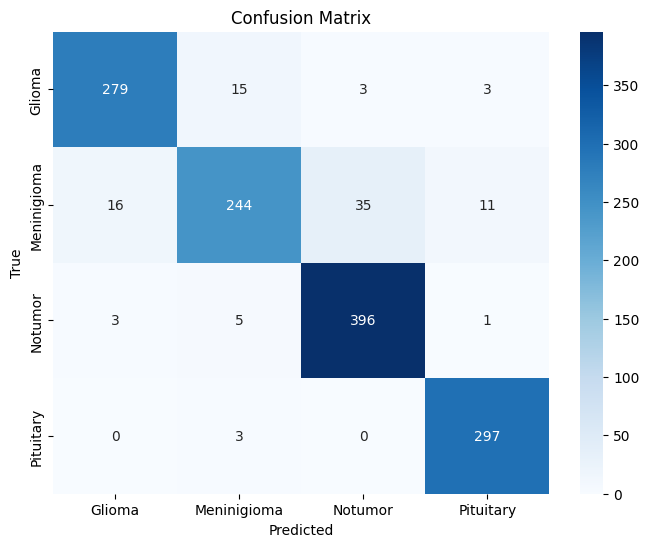

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [44]:
model.save('SSL_30-70.h5')

In [45]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_30-70.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/unlabelled"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.98
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/3996 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


  0%|          | 1/3996 [00:01<1:28:48,  1.33s/it]

Tr-me_0239.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0239.jpg to BT100/Training/notumor/20250331_213558_Tr-me_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0419.jpg to BT100/Training/pituitary/20250331_213558_Tr-pi_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 3/3996 [00:01<26:28,  2.51it/s]  

Tr-no_0473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0473.jpg to BT100/Training/notumor/20250331_213558_Tr-no_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0861.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0861.jpg to BT100/Training/meningioma/20250331_213558_Tr-me_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 5/3996 [00:01<15:09,  4.39it/s]

Tr-me_0664.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0664.jpg to BT100/Training/meningioma/20250331_213558_Tr-me_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0813.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0813.jpg to BT100/Training/notumor/20250331_213558_Tr-no_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 7/3996 [00:01<10:41,  6.22it/s]

Tr-no_0814.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0814.jpg to BT100/Training/notumor/20250331_213558_Tr-no_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1314.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1314.jpg to BT100/Training/notumor/20250331_213558_Tr-no_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 9/3996 [00:01<08:19,  7.98it/s]

Tr-no_1060.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1060.jpg to BT100/Training/notumor/20250331_213559_Tr-no_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0897.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0897.jpg to BT100/Training/pituitary/20250331_213559_Tr-pi_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 11/3996 [00:02<06:56,  9.57it/s]

Tr-no_1352.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1352.jpg to BT100/Training/notumor/20250331_213559_Tr-no_1352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_1446.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1446.jpg to BT100/Training/pituitary/20250331_213559_Tr-pi_1446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0485.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0485.jpg to BT100/Training/pituitary/20250331_213559_Tr-pi_0485.jpg


  0%|          | 13/3996 [00:02<06:07, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1026.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-me_1026.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 15/3996 [00:02<05:42, 11.61it/s]

Tr-gl_0440.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0440.jpg to BT100/Training/glioma/20250331_213559_Tr-gl_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0645.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0645.jpg to BT100/Training/glioma/20250331_213559_Tr-gl_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 17/3996 [00:02<05:24, 12.24it/s]

Tr-gl_1018.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1018.jpg to BT100/Training/glioma/20250331_213559_Tr-gl_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0157.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0157.jpg to BT100/Training/glioma/20250331_213559_Tr-gl_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 19/3996 [00:02<05:43, 11.57it/s]

Tr-no_1165.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1165.jpg to BT100/Training/notumor/20250331_213559_Tr-no_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0219.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0219.jpg to BT100/Training/pituitary/20250331_213559_Tr-pi_0219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 21/3996 [00:02<05:22, 12.32it/s]

Tr-pi_0534.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0534.jpg to BT100/Training/pituitary/20250331_213559_Tr-pi_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0041.jpg -> Class: notumor, Confidence: 0.91
Moved low-confidence image Tr-pi_0041.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|          | 23/3996 [00:02<05:35, 11.83it/s]

Tr-pi_0895.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0895.jpg to BT100/Training/pituitary/20250331_213600_Tr-pi_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0532.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0532.jpg to BT100/Training/pituitary/20250331_213600_Tr-pi_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 25/3996 [00:03<05:20, 12.40it/s]

Tr-pi_0088.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0088.jpg to BT100/Training/pituitary/20250331_213600_Tr-pi_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0634.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0634.jpg to BT100/Training/pituitary/20250331_213600_Tr-pi_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 27/3996 [00:03<05:10, 12.80it/s]

Tr-gl_0909.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0909.jpg to BT100/Training/glioma/20250331_213600_Tr-gl_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0206.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0206.jpg to BT100/Training/pituitary/20250331_213600_Tr-pi_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 29/3996 [00:03<05:03, 13.06it/s]

Tr-no_0596.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0596.jpg to BT100/Training/notumor/20250331_213600_Tr-no_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0690.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0690.jpg to BT100/Training/notumor/20250331_213600_Tr-no_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 31/3996 [00:03<05:23, 12.27it/s]

Tr-gl_0535.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0535.jpg to BT100/Training/glioma/20250331_213600_Tr-gl_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0441.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0441.jpg to BT100/Training/notumor/20250331_213600_Tr-no_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 33/3996 [00:03<05:37, 11.74it/s]

Tr-me_0366.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-me_0366.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_1270.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1270.jpg to BT100/Training/meningioma/20250331_213601_Tr-me_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|          | 35/3996 [00:04<06:41,  9.86it/s]

Tr-gl_0582.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0582.jpg to BT100/Training/glioma/20250331_213601_Tr-gl_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-no_0576.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0576.jpg to BT100/Training/notumor/20250331_213601_Tr-no_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 37/3996 [00:04<07:06,  9.29it/s]

Tr-pi_0646.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0646.jpg to BT100/Training/pituitary/20250331_213601_Tr-pi_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 38/3996 [00:04<07:28,  8.82it/s]

Tr-gl_0716.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0716.jpg to BT100/Training/glioma/20250331_213601_Tr-gl_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|          | 39/3996 [00:04<07:26,  8.85it/s]

Tr-gl_1277.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1277.jpg to BT100/Training/glioma/20250331_213601_Tr-gl_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 40/3996 [00:04<07:23,  8.92it/s]

Tr-gl_1296.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1296.jpg to BT100/Training/glioma/20250331_213601_Tr-gl_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 41/3996 [00:04<07:41,  8.57it/s]

Tr-gl_1003.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1003.jpg to BT100/Training/glioma/20250331_213601_Tr-gl_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 42/3996 [00:04<07:58,  8.26it/s]

Tr-pi_1394.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1394.jpg to BT100/Training/pituitary/20250331_213602_Tr-pi_1394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-me_0404.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0404.jpg to BT100/Training/meningioma/20250331_213602_Tr-me_0404.jpg


  1%|          | 43/3996 [00:05<08:21,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0861.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0861.jpg to BT100/Training/pituitary/20250331_213602_Tr-pi_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  1%|          | 45/3996 [00:05<08:09,  8.07it/s]

Tr-me_0865.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0865.jpg to BT100/Training/meningioma/20250331_213602_Tr-me_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  1%|          | 46/3996 [00:05<08:29,  7.75it/s]

Tr-me_0956.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0956.jpg to BT100/Training/meningioma/20250331_213602_Tr-me_0956.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  1%|          | 47/3996 [00:05<08:44,  7.52it/s]

Tr-me_0498.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0498.jpg to BT100/Training/meningioma/20250331_213602_Tr-me_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0193.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0193.jpg to BT100/Training/pituitary/20250331_213602_Tr-pi_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 49/3996 [00:05<06:57,  9.46it/s]

Tr-no_0621.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0621.jpg to BT100/Training/notumor/20250331_213602_Tr-no_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0920.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_0920.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|▏         | 51/3996 [00:05<05:57, 11.05it/s]

Tr-no_0399.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0399.jpg to BT100/Training/notumor/20250331_213603_Tr-no_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0186.jpg -> Class: notumor, Confidence: 0.71
Moved low-confidence image Tr-me_0186.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|▏         | 53/3996 [00:05<05:26, 12.09it/s]

Tr-pi_0798.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0798.jpg to BT100/Training/pituitary/20250331_213603_Tr-pi_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0414.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0414.jpg to BT100/Training/notumor/20250331_213603_Tr-no_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|▏         | 55/3996 [00:06<05:10, 12.68it/s]

Tr-glTr_0006.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0006.jpg to BT100/Training/glioma/20250331_213603_Tr-glTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1024.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1024.jpg to BT100/Training/pituitary/20250331_213603_Tr-pi_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|▏         | 57/3996 [00:06<04:56, 13.27it/s]

Tr-gl_0505.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0505.jpg to BT100/Training/glioma/20250331_213603_Tr-gl_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0248.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0248.jpg to BT100/Training/notumor/20250331_213603_Tr-no_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▏         | 59/3996 [00:06<05:24, 12.15it/s]

Tr-gl_0415.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0415.jpg to BT100/Training/glioma/20250331_213603_Tr-gl_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0491.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0491.jpg to BT100/Training/meningioma/20250331_213603_Tr-me_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 61/3996 [00:06<05:36, 11.70it/s]

Tr-pi_0341.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0341.jpg to BT100/Training/pituitary/20250331_213603_Tr-pi_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0526.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0526.jpg to BT100/Training/notumor/20250331_213603_Tr-no_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 63/3996 [00:06<05:15, 12.45it/s]

Tr-gl_0168.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0168.jpg to BT100/Training/glioma/20250331_213603_Tr-gl_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0464.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0464.jpg to BT100/Training/meningioma/20250331_213604_Tr-me_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 65/3996 [00:06<05:02, 12.98it/s]

Tr-gl_0320.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0320.jpg to BT100/Training/glioma/20250331_213604_Tr-gl_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1169.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1169.jpg to BT100/Training/notumor/20250331_213604_Tr-no_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 67/3996 [00:07<04:58, 13.16it/s]

Tr-pi_1031.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1031.jpg to BT100/Training/pituitary/20250331_213604_Tr-pi_1031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0213.jpg to BT100/Training/pituitary/20250331_213604_Tr-pi_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 69/3996 [00:07<04:54, 13.36it/s]

Tr-gl_1246.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1246.jpg to BT100/Training/glioma/20250331_213604_Tr-gl_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0945.jpg -> Class: meningioma, Confidence: 0.72
Moved low-confidence image Tr-me_0945.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 71/3996 [00:07<04:47, 13.65it/s]

Tr-no_1195.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1195.jpg to BT100/Training/notumor/20250331_213604_Tr-no_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0906.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0906.jpg to BT100/Training/pituitary/20250331_213604_Tr-pi_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 73/3996 [00:07<05:32, 11.78it/s]

Tr-no_1507.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1507.jpg to BT100/Training/notumor/20250331_213604_Tr-no_1507.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1111.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1111.jpg to BT100/Training/meningioma/20250331_213604_Tr-me_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 75/3996 [00:07<05:41, 11.49it/s]

Tr-no_1240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1240.jpg to BT100/Training/notumor/20250331_213604_Tr-no_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1309.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1309.jpg to BT100/Training/meningioma/20250331_213604_Tr-me_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 77/3996 [00:07<05:19, 12.26it/s]

Tr-gl_1176.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1176.jpg to BT100/Training/glioma/20250331_213605_Tr-gl_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0294.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0294.jpg to BT100/Training/pituitary/20250331_213605_Tr-pi_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 79/3996 [00:08<05:06, 12.76it/s]

Tr-pi_0685.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0685.jpg to BT100/Training/pituitary/20250331_213605_Tr-pi_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0400.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0400.jpg to BT100/Training/glioma/20250331_213605_Tr-gl_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1000.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1000.jpg to BT100/Training/glioma/20250331_213605_Tr-gl_1000.jpg


  2%|▏         | 81/3996 [00:08<04:53, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0079.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0079.jpg to BT100/Training/pituitary/20250331_213605_Tr-pi_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0163.jpg -> Class: glioma, Confidence: 1.00

  2%|▏         | 83/3996 [00:08<04:46, 13.67it/s]


Moving Tr-gl_0163.jpg to BT100/Training/glioma/20250331_213605_Tr-gl_0163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0247.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0247.jpg to BT100/Training/notumor/20250331_213605_Tr-me_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 85/3996 [00:08<05:06, 12.77it/s]

Tr-me_0130.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0130.jpg to BT100/Training/meningioma/20250331_213605_Tr-me_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0478.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0478.jpg to BT100/Training/pituitary/20250331_213605_Tr-pi_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 87/3996 [00:08<05:08, 12.67it/s]

Tr-pi_0703.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0703.jpg to BT100/Training/pituitary/20250331_213605_Tr-pi_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0962.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0962.jpg to BT100/Training/pituitary/20250331_213605_Tr-pi_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 89/3996 [00:08<04:59, 13.05it/s]

Tr-no_0113.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0113.jpg to BT100/Training/notumor/20250331_213605_Tr-no_0113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1067.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1067.jpg to BT100/Training/notumor/20250331_213606_Tr-no_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 91/3996 [00:08<04:53, 13.31it/s]

Tr-no_0506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0506.jpg to BT100/Training/notumor/20250331_213606_Tr-no_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0315.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0315.jpg to BT100/Training/glioma/20250331_213606_Tr-gl_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 93/3996 [00:09<04:46, 13.63it/s]

Tr-no_1052.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1052.jpg to BT100/Training/notumor/20250331_213606_Tr-no_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0446.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0446.jpg to BT100/Training/meningioma/20250331_213606_Tr-me_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 95/3996 [00:09<05:07, 12.67it/s]

Tr-me_0322.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-me_0322.jpg to BT100/Training/notumor/20250331_213606_Tr-me_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1216.jpg -> Class: glioma, Confidence: 0.72
Moved low-confidence image Tr-me_1216.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 97/3996 [00:09<04:55, 13.18it/s]

Tr-pi_1419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1419.jpg to BT100/Training/pituitary/20250331_213606_Tr-pi_1419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0039.jpg to BT100/Training/meningioma/20250331_213606_Tr-me_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 99/3996 [00:09<05:43, 11.33it/s]

Tr-me_0833.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0833.jpg to BT100/Training/meningioma/20250331_213606_Tr-me_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1094.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1094.jpg to BT100/Training/notumor/20250331_213606_Tr-no_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 101/3996 [00:09<05:23, 12.06it/s]

Tr-no_0831.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0831.jpg to BT100/Training/notumor/20250331_213606_Tr-no_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0176.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0176.jpg to BT100/Training/pituitary/20250331_213607_Tr-pi_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 103/3996 [00:09<05:06, 12.69it/s]

Tr-gl_0101.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0101.jpg to BT100/Training/glioma/20250331_213607_Tr-gl_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0753.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0753.jpg to BT100/Training/glioma/20250331_213607_Tr-gl_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 105/3996 [00:10<04:54, 13.19it/s]

Tr-pi_1019.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1019.jpg to BT100/Training/pituitary/20250331_213607_Tr-pi_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1196.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1196.jpg to BT100/Training/glioma/20250331_213607_Tr-gl_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0720.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0720.jpg to BT100/Training/meningioma/20250331_213607_Tr-me_0720.jpg


  3%|▎         | 107/3996 [00:10<05:13, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1082.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1082.jpg to BT100/Training/glioma/20250331_213607_Tr-gl_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 109/3996 [00:10<04:58, 13.02it/s]

Tr-me_1119.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1119.jpg to BT100/Training/meningioma/20250331_213607_Tr-me_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0732.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0732.jpg to BT100/Training/glioma/20250331_213607_Tr-gl_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 111/3996 [00:10<05:21, 12.07it/s]

Tr-me_0813.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0813.jpg to BT100/Training/meningioma/20250331_213607_Tr-me_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1279.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1279.jpg to BT100/Training/pituitary/20250331_213607_Tr-pi_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 113/3996 [00:10<05:10, 12.51it/s]

Tr-pi_0238.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0238.jpg to BT100/Training/pituitary/20250331_213607_Tr-pi_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1457.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1457.jpg to BT100/Training/notumor/20250331_213607_Tr-no_1457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 115/3996 [00:10<04:58, 13.02it/s]

Tr-gl_1311.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1311.jpg to BT100/Training/glioma/20250331_213608_Tr-gl_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0658.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0658.jpg to BT100/Training/glioma/20250331_213608_Tr-gl_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  3%|▎         | 117/3996 [00:10<04:52, 13.26it/s]

Tr-me_0546.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0546.jpg to BT100/Training/meningioma/20250331_213608_Tr-me_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0932.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0932.jpg to BT100/Training/meningioma/20250331_213608_Tr-me_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 119/3996 [00:11<04:46, 13.53it/s]

Tr-no_1199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1199.jpg to BT100/Training/notumor/20250331_213608_Tr-no_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1025.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1025.jpg to BT100/Training/pituitary/20250331_213608_Tr-me_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 121/3996 [00:11<04:42, 13.70it/s]

Tr-gl_1025.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_1025.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1484.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1484.jpg to BT100/Training/notumor/20250331_213608_Tr-no_1484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 123/3996 [00:11<04:40, 13.79it/s]

Tr-no_0229.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0229.jpg to BT100/Training/notumor/20250331_213608_Tr-no_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1265.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1265.jpg to BT100/Training/meningioma/20250331_213608_Tr-gl_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 125/3996 [00:11<04:53, 13.21it/s]

Tr-me_0600.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0600.jpg to BT100/Training/meningioma/20250331_213608_Tr-me_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0358.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0358.jpg to BT100/Training/notumor/20250331_213608_Tr-me_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1037.jpg -> Class: notumor, Confidence: 1.00

  3%|▎         | 127/3996 [00:11<05:19, 12.12it/s]


Moving Tr-no_1037.jpg to BT100/Training/notumor/20250331_213608_Tr-no_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1423.jpg to BT100/Training/notumor/20250331_213609_Tr-no_1423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 129/3996 [00:11<05:06, 12.60it/s]

Tr-me_0105.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0105.jpg to BT100/Training/meningioma/20250331_213609_Tr-me_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0148.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0148.jpg to BT100/Training/notumor/20250331_213609_Tr-no_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 131/3996 [00:12<04:56, 13.02it/s]

Tr-me_1120.jpg -> Class: meningioma, Confidence: 0.65
Moved low-confidence image Tr-me_1120.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0191.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0191.jpg to BT100/Training/pituitary/20250331_213609_Tr-pi_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 133/3996 [00:12<05:13, 12.34it/s]

Tr-no_0346.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0346.jpg to BT100/Training/notumor/20250331_213609_Tr-no_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0763.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0763.jpg to BT100/Training/notumor/20250331_213609_Tr-no_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 135/3996 [00:12<04:58, 12.93it/s]

Tr-no_1175.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1175.jpg to BT100/Training/notumor/20250331_213609_Tr-no_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0862.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0862.jpg to BT100/Training/glioma/20250331_213609_Tr-gl_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 137/3996 [00:12<04:48, 13.38it/s]

Tr-pi_1212.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1212.jpg to BT100/Training/pituitary/20250331_213609_Tr-pi_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0653.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0653.jpg to BT100/Training/notumor/20250331_213609_Tr-no_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 139/3996 [00:12<04:59, 12.89it/s]

Tr-gl_0220.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0220.jpg to BT100/Training/glioma/20250331_213609_Tr-gl_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0558.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0558.jpg to BT100/Training/glioma/20250331_213609_Tr-gl_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 141/3996 [00:12<04:50, 13.28it/s]

Tr-gl_1110.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1110.jpg to BT100/Training/glioma/20250331_213609_Tr-gl_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0944.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0944.jpg to BT100/Training/notumor/20250331_213610_Tr-no_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0129.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0129.jpg to BT100/Training/notumor/20250331_213610_Tr-no_0129.jpg


  4%|▎         | 143/3996 [00:13<05:08, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1185.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1185.jpg to BT100/Training/notumor/20250331_213610_Tr-no_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 145/3996 [00:13<04:59, 12.86it/s]

Tr-me_0051.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0051.jpg to BT100/Training/meningioma/20250331_213610_Tr-me_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0406.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0406.jpg to BT100/Training/meningioma/20250331_213610_Tr-me_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 147/3996 [00:13<04:49, 13.30it/s]

Tr-gl_1142.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1142.jpg to BT100/Training/glioma/20250331_213610_Tr-gl_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1131.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1131.jpg to BT100/Training/notumor/20250331_213610_Tr-no_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 149/3996 [00:13<04:42, 13.62it/s]

Tr-me_0929.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0929.jpg to BT100/Training/meningioma/20250331_213610_Tr-me_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1321.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1321.jpg to BT100/Training/notumor/20250331_213610_Tr-no_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 151/3996 [00:13<05:10, 12.40it/s]

Tr-gl_1207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1207.jpg to BT100/Training/glioma/20250331_213610_Tr-gl_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0040.jpg -> Class: meningioma, Confidence: 0.62
Moved low-confidence image Tr-pi_0040.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 153/3996 [00:13<05:01, 12.73it/s]

Tr-no_0239.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0239.jpg to BT100/Training/notumor/20250331_213610_Tr-no_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0375.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0375.jpg to BT100/Training/pituitary/20250331_213611_Tr-pi_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 155/3996 [00:13<05:15, 12.17it/s]

Tr-pi_0065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0065.jpg to BT100/Training/pituitary/20250331_213611_Tr-pi_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1007.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1007.jpg to BT100/Training/notumor/20250331_213611_Tr-no_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 157/3996 [00:14<05:03, 12.65it/s]

Tr-no_0899.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0899.jpg to BT100/Training/notumor/20250331_213611_Tr-no_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0132.jpg to BT100/Training/meningioma/20250331_213611_Tr-me_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 159/3996 [00:14<04:52, 13.10it/s]

Tr-me_0524.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0524.jpg to BT100/Training/meningioma/20250331_213611_Tr-me_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1059.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1059.jpg to BT100/Training/meningioma/20250331_213611_Tr-me_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 161/3996 [00:14<04:42, 13.59it/s]

Tr-gl_0261.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0261.jpg to BT100/Training/glioma/20250331_213611_Tr-gl_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0324.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0324.jpg to BT100/Training/notumor/20250331_213611_Tr-no_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 163/3996 [00:14<05:33, 11.48it/s]

Tr-me_0110.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0110.jpg to BT100/Training/meningioma/20250331_213611_Tr-me_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1431.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1431.jpg to BT100/Training/notumor/20250331_213611_Tr-no_1431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 165/3996 [00:14<05:19, 12.01it/s]

Tr-pi_0831.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0831.jpg to BT100/Training/pituitary/20250331_213611_Tr-pi_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1069.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1069.jpg to BT100/Training/notumor/20250331_213611_Tr-no_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 167/3996 [00:14<05:29, 11.62it/s]

Tr-me_0575.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0575.jpg to BT100/Training/meningioma/20250331_213612_Tr-me_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0889.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0889.jpg to BT100/Training/pituitary/20250331_213612_Tr-pi_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 169/3996 [00:15<05:40, 11.25it/s]

Tr-me_0293.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-me_0293.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0959.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0959.jpg to BT100/Training/pituitary/20250331_213612_Tr-pi_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 171/3996 [00:15<05:19, 11.96it/s]

Tr-no_0687.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0687.jpg to BT100/Training/notumor/20250331_213612_Tr-no_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0304.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0304.jpg to BT100/Training/meningioma/20250331_213612_Tr-me_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 173/3996 [00:15<05:07, 12.43it/s]

Tr-no_0135.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0135.jpg to BT100/Training/notumor/20250331_213612_Tr-no_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0869.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0869.jpg to BT100/Training/notumor/20250331_213612_Tr-no_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  4%|▍         | 175/3996 [00:15<05:59, 10.64it/s]

Tr-pi_0725.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0725.jpg to BT100/Training/pituitary/20250331_213612_Tr-pi_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-no_1422.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1422.jpg to BT100/Training/notumor/20250331_213612_Tr-no_1422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 177/3996 [00:15<06:16, 10.15it/s]

Tr-me_0443.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0443.jpg to BT100/Training/meningioma/20250331_213613_Tr-me_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-no_0085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0085.jpg to BT100/Training/pituitary/20250331_213613_Tr-no_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▍         | 179/3996 [00:16<06:48,  9.35it/s]

Tr-me_0810.jpg -> Class: meningioma, Confidence: 0.54
Moved low-confidence image Tr-me_0810.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▍         | 180/3996 [00:16<07:08,  8.90it/s]

Tr-me_0354.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0354.jpg to BT100/Training/meningioma/20250331_213613_Tr-me_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 181/3996 [00:16<07:28,  8.52it/s]

Tr-me_0723.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0723.jpg to BT100/Training/meningioma/20250331_213613_Tr-me_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  5%|▍         | 182/3996 [00:16<08:26,  7.53it/s]

Tr-no_1383.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1383.jpg to BT100/Training/notumor/20250331_213613_Tr-no_1383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 183/3996 [00:16<08:38,  7.35it/s]

Tr-pi_1112.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1112.jpg to BT100/Training/pituitary/20250331_213613_Tr-pi_1112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 184/3996 [00:16<08:29,  7.48it/s]

Tr-gl_0337.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0337.jpg to BT100/Training/glioma/20250331_213614_Tr-gl_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 185/3996 [00:17<08:44,  7.26it/s]

Tr-no_0314.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0314.jpg to BT100/Training/notumor/20250331_213614_Tr-no_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 186/3996 [00:17<08:19,  7.63it/s]

Tr-me_1225.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1225.jpg to BT100/Training/meningioma/20250331_213614_Tr-me_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 187/3996 [00:17<08:24,  7.54it/s]

Tr-no_0956.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0956.jpg to BT100/Training/notumor/20250331_213614_Tr-no_0956.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-pi_1001.jpg -> Class: pituitary, Confidence: 1.00

  5%|▍         | 188/3996 [00:17<08:35,  7.38it/s]


Moving Tr-pi_1001.jpg to BT100/Training/pituitary/20250331_213614_Tr-pi_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 189/3996 [00:17<08:39,  7.33it/s]

Tr-no_0992.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0992.jpg to BT100/Training/pituitary/20250331_213614_Tr-no_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_1503.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1503.jpg to BT100/Training/notumor/20250331_213614_Tr-no_1503.jpg


  5%|▍         | 190/3996 [00:17<08:46,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0856.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0856.jpg to BT100/Training/pituitary/20250331_213614_Tr-pi_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 192/3996 [00:17<06:53,  9.19it/s]

Tr-no_0096.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0096.jpg to BT100/Training/notumor/20250331_213615_Tr-no_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0774.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0774.jpg to BT100/Training/meningioma/20250331_213615_Tr-me_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▍         | 194/3996 [00:18<06:03, 10.47it/s]

Tr-no_0629.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0629.jpg to BT100/Training/notumor/20250331_213615_Tr-no_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0387.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0387.jpg to BT100/Training/glioma/20250331_213615_Tr-gl_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▍         | 196/3996 [00:18<05:28, 11.58it/s]

Tr-me_0576.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0576.jpg to BT100/Training/meningioma/20250331_213615_Tr-me_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0128.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0128.jpg to BT100/Training/notumor/20250331_213615_Tr-no_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▍         | 198/3996 [00:18<05:11, 12.21it/s]

Tr-me_1214.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1214.jpg to BT100/Training/meningioma/20250331_213615_Tr-me_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1307.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1307.jpg to BT100/Training/notumor/20250331_213615_Tr-no_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 200/3996 [00:18<05:03, 12.50it/s]

Tr-me_0265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0265.jpg to BT100/Training/notumor/20250331_213615_Tr-me_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0038.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0038.jpg to BT100/Training/glioma/20250331_213615_Tr-gl_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 202/3996 [00:18<05:23, 11.71it/s]

Tr-no_1084.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1084.jpg to BT100/Training/notumor/20250331_213615_Tr-no_1084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0019.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0019.jpg to BT100/Training/notumor/20250331_213615_Tr-no_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▌         | 204/3996 [00:18<05:15, 12.03it/s]

Tr-me_1311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1311.jpg to BT100/Training/pituitary/20250331_213615_Tr-me_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1335.jpg to BT100/Training/notumor/20250331_213616_Tr-no_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 206/3996 [00:18<05:03, 12.50it/s]

Tr-me_0715.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-me_0715.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1386.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1386.jpg to BT100/Training/notumor/20250331_213616_Tr-no_1386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▌         | 208/3996 [00:19<04:54, 12.86it/s]

Tr-no_1178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1178.jpg to BT100/Training/notumor/20250331_213616_Tr-no_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0739.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0739.jpg to BT100/Training/notumor/20250331_213616_Tr-no_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▌         | 210/3996 [00:19<04:51, 13.01it/s]

Tr-me_0181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0181.jpg to BT100/Training/meningioma/20250331_213616_Tr-me_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0351.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0351.jpg to BT100/Training/glioma/20250331_213616_Tr-gl_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▌         | 212/3996 [00:19<04:45, 13.26it/s]

Tr-gl_0783.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0783.jpg to BT100/Training/glioma/20250331_213616_Tr-gl_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0710.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0710.jpg to BT100/Training/notumor/20250331_213616_Tr-no_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▌         | 214/3996 [00:19<05:04, 12.40it/s]

Tr-me_0342.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0342.jpg to BT100/Training/notumor/20250331_213616_Tr-me_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0219.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0219.jpg to BT100/Training/glioma/20250331_213616_Tr-gl_0219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 216/3996 [00:19<05:20, 11.80it/s]

Tr-me_0988.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0988.jpg to BT100/Training/meningioma/20250331_213616_Tr-me_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1181.jpg to BT100/Training/meningioma/20250331_213616_Tr-me_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▌         | 218/3996 [00:19<05:33, 11.31it/s]

Tr-no_0856.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0856.jpg to BT100/Training/notumor/20250331_213617_Tr-no_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0523.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0523.jpg to BT100/Training/pituitary/20250331_213617_Tr-pi_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 220/3996 [00:20<05:35, 11.25it/s]

Tr-pi_0923.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0923.jpg to BT100/Training/pituitary/20250331_213617_Tr-pi_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0018.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0018.jpg to BT100/Training/glioma/20250331_213617_Tr-gl_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 222/3996 [00:20<05:18, 11.86it/s]

Tr-no_0471.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0471.jpg to BT100/Training/notumor/20250331_213617_Tr-no_0471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1069.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1069.jpg to BT100/Training/glioma/20250331_213617_Tr-gl_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 224/3996 [00:20<05:05, 12.35it/s]

Tr-pi_0630.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0630.jpg to BT100/Training/pituitary/20250331_213617_Tr-pi_0630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1111.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-pi_1111.jpg to BT100/Training/glioma/20250331_213617_Tr-pi_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 226/3996 [00:20<05:21, 11.72it/s]

Tr-pi_1280.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1280.jpg to BT100/Training/pituitary/20250331_213617_Tr-pi_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0457.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0457.jpg to BT100/Training/pituitary/20250331_213617_Tr-pi_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1186.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_1186.jpg to BT100/Training/glioma/20250331_213617_Tr-me_1186.jpg


  6%|▌         | 228/3996 [00:20<05:05, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0477.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0477.jpg to BT100/Training/pituitary/20250331_213618_Tr-pi_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 230/3996 [00:20<05:25, 11.58it/s]

Tr-pi_1162.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1162.jpg to BT100/Training/pituitary/20250331_213618_Tr-pi_1162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0765.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0765.jpg to BT100/Training/glioma/20250331_213618_Tr-gl_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 232/3996 [00:21<05:08, 12.20it/s]

Tr-me_0973.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0973.jpg to BT100/Training/meningioma/20250331_213618_Tr-me_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1177.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1177.jpg to BT100/Training/glioma/20250331_213618_Tr-gl_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 234/3996 [00:21<05:20, 11.72it/s]

Tr-no_1194.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1194.jpg to BT100/Training/notumor/20250331_213618_Tr-no_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1269.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1269.jpg to BT100/Training/glioma/20250331_213618_Tr-gl_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 236/3996 [00:21<05:08, 12.17it/s]

Tr-me_1155.jpg -> Class: glioma, Confidence: 0.75
Moved low-confidence image Tr-me_1155.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0734.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0734.jpg to BT100/Training/meningioma/20250331_213618_Tr-me_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 238/3996 [00:21<05:10, 12.12it/s]

Tr-pi_0015.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0015.jpg to BT100/Training/pituitary/20250331_213618_Tr-pi_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0249.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0249.jpg to BT100/Training/notumor/20250331_213618_Tr-no_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 240/3996 [00:21<05:29, 11.41it/s]

Tr-no_1279.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1279.jpg to BT100/Training/notumor/20250331_213618_Tr-no_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0806.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0806.jpg to BT100/Training/pituitary/20250331_213619_Tr-pi_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 242/3996 [00:22<05:45, 10.87it/s]

Tr-pi_0363.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0363.jpg to BT100/Training/pituitary/20250331_213619_Tr-pi_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0170.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0170.jpg to BT100/Training/notumor/20250331_213619_Tr-no_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 244/3996 [00:22<05:22, 11.64it/s]

Tr-me_1085.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1085.jpg to BT100/Training/meningioma/20250331_213619_Tr-me_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0815.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0815.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 246/3996 [00:22<05:09, 12.11it/s]

Tr-pi_0322.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0322.jpg to BT100/Training/pituitary/20250331_213619_Tr-pi_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0797.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0797.jpg to BT100/Training/notumor/20250331_213619_Tr-no_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 248/3996 [00:22<04:58, 12.54it/s]

Tr-pi_0173.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0173.jpg to BT100/Training/pituitary/20250331_213619_Tr-pi_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0899.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0899.jpg to BT100/Training/meningioma/20250331_213619_Tr-me_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 250/3996 [00:22<05:01, 12.41it/s]

Tr-no_0477.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0477.jpg to BT100/Training/notumor/20250331_213619_Tr-no_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0243.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0243.jpg to BT100/Training/glioma/20250331_213619_Tr-gl_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▋         | 252/3996 [00:22<05:38, 11.06it/s]

Tr-no_1065.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1065.jpg to BT100/Training/notumor/20250331_213619_Tr-no_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0570.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0570.jpg to BT100/Training/pituitary/20250331_213620_Tr-pi_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▋         | 254/3996 [00:23<05:49, 10.70it/s]

Tr-pi_0051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0051.jpg to BT100/Training/pituitary/20250331_213620_Tr-pi_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1429.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1429.jpg to BT100/Training/notumor/20250331_213620_Tr-no_1429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▋         | 256/3996 [00:23<05:47, 10.77it/s]

Tr-gl_0278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0278.jpg to BT100/Training/glioma/20250331_213620_Tr-gl_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0348.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0348.jpg to BT100/Training/meningioma/20250331_213620_Tr-me_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▋         | 258/3996 [00:23<05:25, 11.48it/s]

Tr-no_1228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1228.jpg to BT100/Training/notumor/20250331_213620_Tr-no_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1131.jpg -> Class: notumor, Confidence: 0.41
Moved low-confidence image Tr-gl_1131.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 260/3996 [00:23<05:09, 12.07it/s]

Tr-pi_1410.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1410.jpg to BT100/Training/pituitary/20250331_213620_Tr-pi_1410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0955.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-me_0955.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 262/3996 [00:23<05:27, 11.40it/s]

Tr-pi_0736.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0736.jpg to BT100/Training/pituitary/20250331_213620_Tr-pi_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1091.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1091.jpg to BT100/Training/pituitary/20250331_213620_Tr-pi_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0074.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0074.jpg to BT100/Training/glioma/20250331_213621_Tr-gl_0074.jpg


  7%|▋         | 264/3996 [00:23<05:09, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0621.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0621.jpg to BT100/Training/glioma/20250331_213621_Tr-gl_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 266/3996 [00:24<05:24, 11.50it/s]

Tr-me_1078.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1078.jpg to BT100/Training/meningioma/20250331_213621_Tr-me_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0035.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0035.jpg to BT100/Training/meningioma/20250331_213621_Tr-me_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 268/3996 [00:24<05:07, 12.11it/s]

Tr-gl_0277.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0277.jpg to BT100/Training/glioma/20250331_213621_Tr-gl_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1344.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1344.jpg to BT100/Training/pituitary/20250331_213621_Tr-pi_1344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  7%|▋         | 270/3996 [00:24<04:58, 12.50it/s]

Tr-no_0206.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0206.jpg to BT100/Training/notumor/20250331_213621_Tr-no_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0566.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0566.jpg to BT100/Training/glioma/20250331_213621_Tr-gl_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 272/3996 [00:24<04:50, 12.82it/s]

Tr-gl_0183.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0183.jpg to BT100/Training/glioma/20250331_213621_Tr-gl_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1355.jpg to BT100/Training/notumor/20250331_213621_Tr-no_1355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 274/3996 [00:24<05:11, 11.94it/s]

Tr-pi_1292.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1292.jpg to BT100/Training/pituitary/20250331_213621_Tr-pi_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0582.jpg to BT100/Training/notumor/20250331_213621_Tr-me_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 276/3996 [00:24<05:22, 11.53it/s]

Tr-no_0767.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0767.jpg to BT100/Training/notumor/20250331_213622_Tr-no_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0720.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0720.jpg to BT100/Training/glioma/20250331_213622_Tr-gl_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 278/3996 [00:25<05:29, 11.27it/s]

Tr-pi_0853.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0853.jpg to BT100/Training/pituitary/20250331_213622_Tr-pi_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0428.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0428.jpg to BT100/Training/glioma/20250331_213622_Tr-gl_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 280/3996 [00:25<05:10, 11.96it/s]

Tr-pi_0886.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0886.jpg to BT100/Training/pituitary/20250331_213622_Tr-pi_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0823.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0823.jpg to BT100/Training/pituitary/20250331_213622_Tr-pi_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 282/3996 [00:25<04:58, 12.44it/s]

Tr-pi_0553.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0553.jpg to BT100/Training/pituitary/20250331_213622_Tr-pi_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1159.jpg to BT100/Training/meningioma/20250331_213622_Tr-me_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 284/3996 [00:25<05:19, 11.62it/s]

Tr-no_1572.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1572.jpg to BT100/Training/notumor/20250331_213622_Tr-no_1572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0164.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0164.jpg to BT100/Training/notumor/20250331_213622_Tr-no_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 286/3996 [00:25<05:32, 11.16it/s]

Tr-gl_1160.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1160.jpg to BT100/Training/glioma/20250331_213622_Tr-gl_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1178.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1178.jpg to BT100/Training/meningioma/20250331_213622_Tr-me_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 288/3996 [00:25<05:16, 11.70it/s]

Tr-pi_0890.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0890.jpg to BT100/Training/pituitary/20250331_213623_Tr-pi_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_1267.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1267.jpg to BT100/Training/glioma/20250331_213623_Tr-gl_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 290/3996 [00:26<05:30, 11.21it/s]

Tr-no_1570.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1570.jpg to BT100/Training/notumor/20250331_213623_Tr-no_1570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0282.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0282.jpg to BT100/Training/notumor/20250331_213623_Tr-me_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 292/3996 [00:26<05:34, 11.06it/s]

Tr-me_0846.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0846.jpg to BT100/Training/meningioma/20250331_213623_Tr-me_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0843.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0843.jpg to BT100/Training/pituitary/20250331_213623_Tr-pi_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 294/3996 [00:26<05:17, 11.67it/s]

Tr-me_1213.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_1213.jpg to BT100/Training/glioma/20250331_213623_Tr-me_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0994.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0994.jpg to BT100/Training/pituitary/20250331_213623_Tr-pi_0994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 296/3996 [00:26<05:15, 11.73it/s]

Tr-no_0309.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0309.jpg to BT100/Training/notumor/20250331_213623_Tr-no_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0259.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0259.jpg to BT100/Training/pituitary/20250331_213623_Tr-pi_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1093.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1093.jpg to BT100/Training/pituitary/20250331_213623_Tr-pi_1093.jpg


  7%|▋         | 298/3996 [00:26<05:28, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1246.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1246.jpg to BT100/Training/notumor/20250331_213624_Tr-no_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 300/3996 [00:26<05:35, 11.00it/s]

Tr-me_0097.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0097.jpg to BT100/Training/meningioma/20250331_213624_Tr-me_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0099.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_0099.jpg to BT100/Training/glioma/20250331_213624_Tr-gl_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1248.jpg -> Class: meningioma, Confidence: 0.79

  8%|▊         | 302/3996 [00:27<05:20, 11.52it/s]


Moved low-confidence image Tr-me_1248.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1340.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1340.jpg to BT100/Training/pituitary/20250331_213624_Tr-pi_1340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 304/3996 [00:27<05:07, 12.02it/s]

Tr-me_0262.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-me_0262.jpg to BT100/Training/pituitary/20250331_213624_Tr-me_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0685.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0685.jpg to BT100/Training/notumor/20250331_213624_Tr-no_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 306/3996 [00:27<05:19, 11.55it/s]

Tr-no_0693.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0693.jpg to BT100/Training/notumor/20250331_213624_Tr-no_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0876.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0876.jpg to BT100/Training/notumor/20250331_213624_Tr-no_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 308/3996 [00:27<05:33, 11.06it/s]

Tr-no_0582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0582.jpg to BT100/Training/notumor/20250331_213624_Tr-no_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Tr-pi_0474.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0474.jpg to BT100/Training/pituitary/20250331_213624_Tr-pi_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  8%|▊         | 310/3996 [00:27<06:12,  9.90it/s]

Tr-no_0462.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0462.jpg to BT100/Training/notumor/20250331_213625_Tr-no_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Tr-me_0394.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0394.jpg to BT100/Training/meningioma/20250331_213625_Tr-me_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 312/3996 [00:28<07:01,  8.75it/s]

Tr-no_0423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0423.jpg to BT100/Training/notumor/20250331_213625_Tr-no_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 313/3996 [00:28<06:58,  8.80it/s]

Tr-gl_0987.jpg -> Class: pituitary, Confidence: 0.67
Moved low-confidence image Tr-gl_0987.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|▊         | 314/3996 [00:28<07:19,  8.37it/s]

Tr-me_0897.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0897.jpg to BT100/Training/meningioma/20250331_213625_Tr-me_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 315/3996 [00:28<07:40,  8.00it/s]

Tr-no_1356.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1356.jpg to BT100/Training/notumor/20250331_213625_Tr-no_1356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 316/3996 [00:28<07:22,  8.32it/s]

Tr-me_1112.jpg -> Class: glioma, Confidence: 0.53
Moved low-confidence image Tr-me_1112.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|▊         | 317/3996 [00:28<07:35,  8.07it/s]

Tr-no_1446.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1446.jpg to BT100/Training/notumor/20250331_213626_Tr-no_1446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0373.jpg -> Class: glioma, Confidence: 1.00

  8%|▊         | 318/3996 [00:28<07:54,  7.76it/s]


Moving Tr-gl_0373.jpg to BT100/Training/glioma/20250331_213626_Tr-gl_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  8%|▊         | 319/3996 [00:29<08:22,  7.31it/s]

Tr-gl_0991.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0991.jpg to BT100/Training/glioma/20250331_213626_Tr-gl_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 320/3996 [00:29<08:23,  7.30it/s]

Tr-no_1506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1506.jpg to BT100/Training/notumor/20250331_213626_Tr-no_1506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  8%|▊         | 321/3996 [00:29<08:14,  7.43it/s]

Tr-me_0756.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0756.jpg to BT100/Training/meningioma/20250331_213626_Tr-me_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  8%|▊         | 322/3996 [00:29<08:43,  7.01it/s]

Tr-pi_0038.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0038.jpg to BT100/Training/pituitary/20250331_213626_Tr-pi_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  8%|▊         | 323/3996 [00:29<08:23,  7.29it/s]

Tr-me_1056.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1056.jpg to BT100/Training/glioma/20250331_213626_Tr-me_1056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 324/3996 [00:29<08:20,  7.33it/s]

Tr-no_0434.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0434.jpg to BT100/Training/notumor/20250331_213626_Tr-no_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0552.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0552.jpg to BT100/Training/pituitary/20250331_213627_Tr-pi_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 326/3996 [00:29<06:39,  9.18it/s]

Tr-pi_1236.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1236.jpg to BT100/Training/pituitary/20250331_213627_Tr-pi_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1043.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1043.jpg to BT100/Training/notumor/20250331_213627_Tr-no_1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 328/3996 [00:30<05:56, 10.28it/s]

Tr-pi_0742.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0742.jpg to BT100/Training/pituitary/20250331_213627_Tr-pi_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0482.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0482.jpg to BT100/Training/pituitary/20250331_213627_Tr-pi_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 330/3996 [00:30<05:54, 10.33it/s]

Tr-gl_0662.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0662.jpg to BT100/Training/glioma/20250331_213627_Tr-gl_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1420.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1420.jpg to BT100/Training/pituitary/20250331_213627_Tr-pi_1420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 332/3996 [00:30<05:27, 11.18it/s]

Tr-no_0801.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0801.jpg to BT100/Training/notumor/20250331_213627_Tr-no_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0192.jpg to BT100/Training/notumor/20250331_213627_Tr-me_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  8%|▊         | 334/3996 [00:30<06:01, 10.14it/s]

Tr-pi_1369.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1369.jpg to BT100/Training/pituitary/20250331_213627_Tr-pi_1369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1172.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1172.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 336/3996 [00:30<05:30, 11.09it/s]

Tr-pi_0445.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0445.jpg to BT100/Training/pituitary/20250331_213628_Tr-pi_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0547.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0547.jpg to BT100/Training/meningioma/20250331_213628_Tr-me_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 338/3996 [00:31<05:11, 11.74it/s]

Tr-me_0185.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0185.jpg to BT100/Training/meningioma/20250331_213628_Tr-me_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1331.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1331.jpg to BT100/Training/meningioma/20250331_213628_Tr-me_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▊         | 340/3996 [00:31<05:44, 10.60it/s]

Tr-gl_0499.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0499.jpg to BT100/Training/glioma/20250331_213628_Tr-gl_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0593.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0593.jpg to BT100/Training/glioma/20250331_213628_Tr-gl_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▊         | 342/3996 [00:31<05:43, 10.63it/s]

Tr-no_1153.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1153.jpg to BT100/Training/notumor/20250331_213628_Tr-no_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0482.jpg to BT100/Training/notumor/20250331_213628_Tr-no_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▊         | 344/3996 [00:31<05:52, 10.37it/s]

Tr-gl_0702.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0702.jpg to BT100/Training/glioma/20250331_213628_Tr-gl_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1363.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1363.jpg to BT100/Training/pituitary/20250331_213628_Tr-pi_1363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▊         | 346/3996 [00:31<05:27, 11.13it/s]

Tr-no_0531.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0531.jpg to BT100/Training/notumor/20250331_213628_Tr-no_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1280.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1280.jpg to BT100/Training/meningioma/20250331_213629_Tr-me_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▊         | 348/3996 [00:31<05:34, 10.90it/s]

Tr-me_0038.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0038.jpg to BT100/Training/meningioma/20250331_213629_Tr-me_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1408.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1408.jpg to BT100/Training/pituitary/20250331_213629_Tr-pi_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 350/3996 [00:32<06:01, 10.08it/s]

Tr-me_1145.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1145.jpg to BT100/Training/meningioma/20250331_213629_Tr-me_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1587.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1587.jpg to BT100/Training/notumor/20250331_213629_Tr-no_1587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 352/3996 [00:32<05:32, 10.97it/s]

Tr-pi_0380.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0380.jpg to BT100/Training/pituitary/20250331_213629_Tr-pi_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0902.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0902.jpg to BT100/Training/pituitary/20250331_213629_Tr-pi_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 354/3996 [00:32<05:37, 10.79it/s]

Tr-me_0921.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0921.jpg to BT100/Training/meningioma/20250331_213629_Tr-me_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0928.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0928.jpg to BT100/Training/pituitary/20250331_213629_Tr-pi_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 356/3996 [00:32<06:03, 10.02it/s]

Tr-me_0260.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0260.jpg to BT100/Training/notumor/20250331_213629_Tr-me_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1267.jpg to BT100/Training/notumor/20250331_213630_Tr-no_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 358/3996 [00:33<06:20,  9.57it/s]

Tr-gl_0773.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0773.jpg to BT100/Training/glioma/20250331_213630_Tr-gl_0773.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0021.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0021.jpg to BT100/Training/notumor/20250331_213630_Tr-no_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0670.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0670.jpg to BT100/Training/notumor/20250331_213630_Tr-no_0670.jpg


  9%|▉         | 360/3996 [00:33<06:15,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0361.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0361.jpg to BT100/Training/pituitary/20250331_213630_Tr-pi_0361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 362/3996 [00:33<05:44, 10.55it/s]

Tr-no_0845.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0845.jpg to BT100/Training/notumor/20250331_213630_Tr-no_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0356.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0356.jpg to BT100/Training/glioma/20250331_213630_Tr-gl_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 364/3996 [00:33<06:06,  9.92it/s]

Tr-no_1451.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1451.jpg to BT100/Training/notumor/20250331_213630_Tr-no_1451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0453.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0453.jpg to BT100/Training/notumor/20250331_213630_Tr-no_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 366/3996 [00:33<06:02, 10.01it/s]

Tr-gl_0622.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0622.jpg to BT100/Training/glioma/20250331_213630_Tr-gl_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0047.jpg -> Class: notumor, Confidence: 0.52
Moved low-confidence image Tr-no_0047.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 368/3996 [00:33<05:38, 10.70it/s]

Tr-gl_0392.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0392.jpg to BT100/Training/glioma/20250331_213631_Tr-gl_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1027.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1027.jpg to BT100/Training/meningioma/20250331_213631_Tr-me_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 370/3996 [00:34<05:43, 10.56it/s]

Tr-no_0044.jpg -> Class: notumor, Confidence: 0.45
Moved low-confidence image Tr-no_0044.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_1167.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1167.jpg to BT100/Training/pituitary/20250331_213631_Tr-pi_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 372/3996 [00:34<05:52, 10.28it/s]

Tr-me_0193.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0193.jpg to BT100/Training/pituitary/20250331_213631_Tr-me_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0627.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0627.jpg to BT100/Training/meningioma/20250331_213631_Tr-me_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 374/3996 [00:34<05:26, 11.09it/s]

Tr-no_0303.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0303.jpg to BT100/Training/notumor/20250331_213631_Tr-no_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0146.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0146.jpg to BT100/Training/pituitary/20250331_213631_Tr-pi_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 376/3996 [00:34<05:33, 10.86it/s]

Tr-no_0556.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0556.jpg to BT100/Training/notumor/20250331_213631_Tr-no_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0576.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0576.jpg to BT100/Training/glioma/20250331_213631_Tr-gl_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 378/3996 [00:34<05:17, 11.38it/s]

Tr-no_1565.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1565.jpg to BT100/Training/notumor/20250331_213632_Tr-no_1565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1139.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1139.jpg to BT100/Training/pituitary/20250331_213632_Tr-pi_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|▉         | 380/3996 [00:34<05:06, 11.78it/s]

Tr-pi_0891.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0891.jpg to BT100/Training/pituitary/20250331_213632_Tr-pi_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1266.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-gl_1266.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|▉         | 382/3996 [00:35<04:59, 12.05it/s]

Tr-me_0425.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0425.jpg to BT100/Training/meningioma/20250331_213632_Tr-me_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_1235.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1235.jpg to BT100/Training/glioma/20250331_213632_Tr-gl_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 384/3996 [00:35<05:34, 10.79it/s]

Tr-no_0584.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0584.jpg to BT100/Training/notumor/20250331_213632_Tr-no_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0162.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0162.jpg to BT100/Training/pituitary/20250331_213632_Tr-pi_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 386/3996 [00:35<05:41, 10.56it/s]

Tr-no_0313.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0313.jpg to BT100/Training/notumor/20250331_213632_Tr-no_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0436.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0436.jpg to BT100/Training/pituitary/20250331_213632_Tr-pi_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|▉         | 388/3996 [00:35<05:18, 11.32it/s]

Tr-pi_0957.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0957.jpg to BT100/Training/pituitary/20250331_213632_Tr-pi_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0636.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0636.jpg to BT100/Training/meningioma/20250331_213633_Tr-me_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 390/3996 [00:35<05:25, 11.09it/s]

Tr-gl_1299.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1299.jpg to BT100/Training/glioma/20250331_213633_Tr-gl_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0516.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0516.jpg to BT100/Training/meningioma/20250331_213633_Tr-me_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|▉         | 392/3996 [00:36<05:11, 11.58it/s]

Tr-pi_0787.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0787.jpg to BT100/Training/pituitary/20250331_213633_Tr-pi_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1241.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-gl_1241.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|▉         | 394/3996 [00:36<05:20, 11.24it/s]

Tr-pi_1265.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1265.jpg to BT100/Training/pituitary/20250331_213633_Tr-pi_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0522.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0522.jpg to BT100/Training/meningioma/20250331_213633_Tr-me_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 396/3996 [00:36<05:05, 11.79it/s]

Tr-pi_0091.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0091.jpg to BT100/Training/pituitary/20250331_213633_Tr-pi_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0864.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0864.jpg to BT100/Training/pituitary/20250331_213633_Tr-pi_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 398/3996 [00:36<05:02, 11.90it/s]

Tr-me_1086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1086.jpg to BT100/Training/glioma/20250331_213633_Tr-me_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1247.jpg to BT100/Training/pituitary/20250331_213633_Tr-pi_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 400/3996 [00:36<04:51, 12.33it/s]

Tr-gl_0657.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0657.jpg to BT100/Training/glioma/20250331_213633_Tr-gl_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1255.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1255.jpg to BT100/Training/glioma/20250331_213633_Tr-gl_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 402/3996 [00:36<05:06, 11.73it/s]

Tr-me_0267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0267.jpg to BT100/Training/notumor/20250331_213634_Tr-me_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0858.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0858.jpg to BT100/Training/meningioma/20250331_213634_Tr-me_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 404/3996 [00:37<05:36, 10.66it/s]

Tr-no_0749.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0749.jpg to BT100/Training/notumor/20250331_213634_Tr-no_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0400.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0400.jpg to BT100/Training/pituitary/20250331_213634_Tr-pi_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 406/3996 [00:37<05:41, 10.51it/s]

Tr-pi_0467.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0467.jpg to BT100/Training/pituitary/20250331_213634_Tr-pi_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0147.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0147.jpg to BT100/Training/pituitary/20250331_213634_Tr-pi_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 408/3996 [00:37<05:20, 11.20it/s]

Tr-no_1477.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1477.jpg to BT100/Training/notumor/20250331_213634_Tr-no_1477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0180.jpg to BT100/Training/glioma/20250331_213634_Tr-gl_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0378.jpg -> Class: pituitary, Confidence: 1.00

 10%|█         | 410/3996 [00:37<05:30, 10.84it/s]


Moving Tr-pi_0378.jpg to BT100/Training/pituitary/20250331_213634_Tr-pi_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0774.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0774.jpg to BT100/Training/glioma/20250331_213634_Tr-gl_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 412/3996 [00:37<05:10, 11.53it/s]

Tr-no_1399.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1399.jpg to BT100/Training/notumor/20250331_213634_Tr-no_1399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1023.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1023.jpg to BT100/Training/pituitary/20250331_213635_Tr-pi_1023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 414/3996 [00:37<05:02, 11.86it/s]

Tr-me_0790.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0790.jpg to BT100/Training/meningioma/20250331_213635_Tr-me_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0057.jpg to BT100/Training/pituitary/20250331_213635_Tr-pi_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 416/3996 [00:38<05:34, 10.70it/s]

Tr-pi_0578.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0578.jpg to BT100/Training/pituitary/20250331_213635_Tr-pi_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0417.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-gl_0417.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|█         | 418/3996 [00:38<05:37, 10.60it/s]

Tr-gl_0134.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0134.jpg to BT100/Training/glioma/20250331_213635_Tr-gl_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1227.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1227.jpg to BT100/Training/pituitary/20250331_213635_Tr-pi_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 420/3996 [00:38<05:46, 10.32it/s]

Tr-me_1113.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1113.jpg to BT100/Training/meningioma/20250331_213635_Tr-me_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0382.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0382.jpg to BT100/Training/meningioma/20250331_213635_Tr-me_0382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 422/3996 [00:38<05:24, 11.02it/s]

Tr-me_0143.jpg -> Class: glioma, Confidence: 0.74
Moved low-confidence image Tr-me_0143.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1213.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1213.jpg to BT100/Training/notumor/20250331_213636_Tr-no_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 424/3996 [00:39<05:50, 10.20it/s]

Tr-me_0895.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0895.jpg to BT100/Training/meningioma/20250331_213636_Tr-me_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0655.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0655.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 426/3996 [00:39<05:31, 10.77it/s]

Tr-no_0637.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0637.jpg to BT100/Training/notumor/20250331_213636_Tr-no_0637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0509.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0509.jpg to BT100/Training/notumor/20250331_213636_Tr-no_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 428/3996 [00:39<05:16, 11.28it/s]

Tr-gl_0692.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0692.jpg to BT100/Training/glioma/20250331_213636_Tr-gl_0692.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_1265.jpg to BT100/Training/notumor/20250331_213636_Tr-me_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 430/3996 [00:39<05:48, 10.24it/s]

Tr-pi_0422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0422.jpg to BT100/Training/pituitary/20250331_213636_Tr-pi_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0733.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0733.jpg to BT100/Training/pituitary/20250331_213636_Tr-pi_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 432/3996 [00:39<05:50, 10.18it/s]

Tr-me_0128.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0128.jpg to BT100/Training/meningioma/20250331_213636_Tr-me_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-gl_0663.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0663.jpg to BT100/Training/glioma/20250331_213637_Tr-gl_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█         | 434/3996 [00:40<06:35,  9.01it/s]

Tr-me_0167.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0167.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1513.jpg -> Class: notumor, Confidence: 1.00

 11%|█         | 435/3996 [00:40<06:55,  8.57it/s]


Moving Tr-no_1513.jpg to BT100/Training/notumor/20250331_213637_Tr-no_1513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 436/3996 [00:40<06:43,  8.81it/s]

Tr-pi_1438.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1438.jpg to BT100/Training/pituitary/20250331_213637_Tr-pi_1438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 11%|█         | 437/3996 [00:40<06:57,  8.52it/s]

Tr-pi_0070.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0070.jpg to BT100/Training/pituitary/20250331_213637_Tr-pi_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 438/3996 [00:40<06:46,  8.75it/s]

Tr-gl_0096.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0096.jpg to BT100/Training/glioma/20250331_213637_Tr-gl_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█         | 439/3996 [00:40<07:18,  8.12it/s]

Tr-gl_0251.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0251.jpg to BT100/Training/glioma/20250331_213637_Tr-gl_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0531.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0531.jpg to BT100/Training/pituitary/20250331_213637_Tr-pi_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█         | 441/3996 [00:40<06:49,  8.69it/s]

Tr-no_1080.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1080.jpg to BT100/Training/notumor/20250331_213638_Tr-no_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█         | 442/3996 [00:41<06:56,  8.53it/s]

Tr-me_0469.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0469.jpg to BT100/Training/meningioma/20250331_213638_Tr-me_0469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 443/3996 [00:41<07:22,  8.02it/s]

Tr-pi_0424.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0424.jpg to BT100/Training/pituitary/20250331_213638_Tr-pi_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█         | 444/3996 [00:41<07:10,  8.25it/s]

Tr-me_1247.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1247.jpg to BT100/Training/meningioma/20250331_213638_Tr-me_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█         | 445/3996 [00:41<07:34,  7.82it/s]

Tr-no_1120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1120.jpg to BT100/Training/notumor/20250331_213638_Tr-no_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█         | 446/3996 [00:41<08:02,  7.36it/s]

Tr-pi_1435.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1435.jpg to BT100/Training/pituitary/20250331_213638_Tr-pi_1435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 447/3996 [00:41<08:05,  7.31it/s]

Tr-gl_0120.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0120.jpg to BT100/Training/glioma/20250331_213638_Tr-gl_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|█         | 448/3996 [00:41<08:05,  7.31it/s]

Tr-no_1306.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1306.jpg to BT100/Training/notumor/20250331_213639_Tr-no_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1336.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1336.jpg to BT100/Training/pituitary/20250331_213639_Tr-pi_1336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█▏        | 450/3996 [00:42<06:45,  8.74it/s]

Tr-gl_0148.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0148.jpg to BT100/Training/glioma/20250331_213639_Tr-gl_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0344.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0344.jpg to BT100/Training/pituitary/20250331_213639_Tr-pi_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█▏        | 452/3996 [00:42<06:19,  9.35it/s]

Tr-pi_0648.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0648.jpg to BT100/Training/pituitary/20250331_213639_Tr-pi_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█▏        | 453/3996 [00:42<06:25,  9.20it/s]

Tr-gl_1054.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1054.jpg to BT100/Training/glioma/20250331_213639_Tr-gl_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█▏        | 454/3996 [00:42<06:32,  9.03it/s]

Tr-gl_0040.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0040.jpg to BT100/Training/glioma/20250331_213639_Tr-gl_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█▏        | 455/3996 [00:42<06:48,  8.67it/s]

Tr-me_0993.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0993.jpg to BT100/Training/meningioma/20250331_213639_Tr-me_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█▏        | 456/3996 [00:42<06:51,  8.61it/s]

Tr-no_0828.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0828.jpg to BT100/Training/notumor/20250331_213639_Tr-no_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█▏        | 457/3996 [00:42<06:48,  8.66it/s]

Tr-pi_0748.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0748.jpg to BT100/Training/pituitary/20250331_213639_Tr-pi_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0121.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0121.jpg to BT100/Training/pituitary/20250331_213640_Tr-pi_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█▏        | 459/3996 [00:42<06:16,  9.41it/s]

Tr-pi_0081.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0081.jpg to BT100/Training/pituitary/20250331_213640_Tr-pi_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 460/3996 [00:43<06:21,  9.28it/s]

Tr-no_0316.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0316.jpg to BT100/Training/notumor/20250331_213640_Tr-no_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0421.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0421.jpg to BT100/Training/pituitary/20250331_213640_Tr-pi_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 462/3996 [00:43<06:08,  9.58it/s]

Tr-pi_0123.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0123.jpg to BT100/Training/pituitary/20250331_213640_Tr-pi_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1045.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1045.jpg to BT100/Training/pituitary/20250331_213640_Tr-pi_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 464/3996 [00:43<05:31, 10.64it/s]

Tr-pi_1360.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1360.jpg to BT100/Training/pituitary/20250331_213640_Tr-pi_1360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0565.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0565.jpg to BT100/Training/glioma/20250331_213640_Tr-gl_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 466/3996 [00:43<05:24, 10.88it/s]

Tr-me_0509.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0509.jpg to BT100/Training/meningioma/20250331_213640_Tr-me_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1152.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1152.jpg to BT100/Training/notumor/20250331_213640_Tr-no_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 468/3996 [00:43<05:05, 11.54it/s]

Tr-no_1159.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1159.jpg to BT100/Training/notumor/20250331_213640_Tr-no_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1269.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1269.jpg to BT100/Training/notumor/20250331_213641_Tr-no_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 470/3996 [00:43<04:49, 12.16it/s]

Tr-me_0082.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0082.jpg to BT100/Training/meningioma/20250331_213641_Tr-me_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0373.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0373.jpg to BT100/Training/meningioma/20250331_213641_Tr-me_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 472/3996 [00:44<04:42, 12.47it/s]

Tr-pi_0745.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0745.jpg to BT100/Training/pituitary/20250331_213641_Tr-pi_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0973.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0973.jpg to BT100/Training/glioma/20250331_213641_Tr-gl_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 474/3996 [00:44<04:39, 12.61it/s]

Tr-me_0592.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0592.jpg to BT100/Training/meningioma/20250331_213641_Tr-me_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0192.jpg to BT100/Training/pituitary/20250331_213641_Tr-pi_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 476/3996 [00:44<04:58, 11.78it/s]

Tr-pi_0596.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0596.jpg to BT100/Training/pituitary/20250331_213641_Tr-pi_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0544.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0544.jpg to BT100/Training/notumor/20250331_213641_Tr-no_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 478/3996 [00:44<05:19, 11.02it/s]

Tr-no_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0192.jpg to BT100/Training/notumor/20250331_213641_Tr-no_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1107.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1107.jpg to BT100/Training/meningioma/20250331_213641_Tr-me_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 480/3996 [00:44<05:20, 10.96it/s]

Tr-me_0415.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0415.jpg to BT100/Training/meningioma/20250331_213641_Tr-me_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0135.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0135.jpg to BT100/Training/pituitary/20250331_213642_Tr-pi_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 482/3996 [00:44<05:04, 11.54it/s]

Tr-no_1374.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1374.jpg to BT100/Training/notumor/20250331_213642_Tr-no_1374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0366.jpg to BT100/Training/notumor/20250331_213642_Tr-no_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 484/3996 [00:45<04:55, 11.89it/s]

Tr-pi_0126.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0126.jpg to BT100/Training/pituitary/20250331_213642_Tr-pi_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0863.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0863.jpg to BT100/Training/glioma/20250331_213642_Tr-gl_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0196.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0196.jpg to BT100/Training/glioma/20250331_213642_Tr-gl_0196.jpg


 12%|█▏        | 486/3996 [00:45<05:10, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1167.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1167.jpg to BT100/Training/notumor/20250331_213642_Tr-no_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 488/3996 [00:45<05:43, 10.23it/s]

Tr-pi_0529.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0529.jpg to BT100/Training/pituitary/20250331_213642_Tr-pi_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1190.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1190.jpg to BT100/Training/meningioma/20250331_213642_Tr-me_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 490/3996 [00:45<06:06,  9.57it/s]

Tr-me_0245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0245.jpg to BT100/Training/meningioma/20250331_213642_Tr-me_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 491/3996 [00:45<06:12,  9.41it/s]

Tr-me_0058.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-me_0058.jpg to BT100/Training/pituitary/20250331_213643_Tr-me_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 492/3996 [00:46<06:21,  9.19it/s]

Tr-pi_0166.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0166.jpg to BT100/Training/pituitary/20250331_213643_Tr-pi_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0942.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0942.jpg to BT100/Training/notumor/20250331_213643_Tr-no_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 494/3996 [00:46<05:40, 10.30it/s]

Tr-pi_1250.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1250.jpg to BT100/Training/pituitary/20250331_213643_Tr-pi_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1217.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1217.jpg to BT100/Training/pituitary/20250331_213643_Tr-pi_1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 496/3996 [00:46<05:59,  9.73it/s]

Tr-pi_0319.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0319.jpg to BT100/Training/pituitary/20250331_213643_Tr-pi_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1029.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1029.jpg to BT100/Training/notumor/20250331_213643_Tr-no_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 498/3996 [00:46<06:00,  9.71it/s]

Tr-me_1258.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1258.jpg to BT100/Training/meningioma/20250331_213643_Tr-me_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0236.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0236.jpg to BT100/Training/glioma/20250331_213643_Tr-gl_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 500/3996 [00:46<05:28, 10.63it/s]

Tr-pi_0366.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0366.jpg to BT100/Training/pituitary/20250331_213643_Tr-pi_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0307.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0307.jpg to BT100/Training/notumor/20250331_213644_Tr-no_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 502/3996 [00:46<05:34, 10.45it/s]

Tr-me_0386.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0386.jpg to BT100/Training/meningioma/20250331_213644_Tr-me_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0845.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0845.jpg to BT100/Training/pituitary/20250331_213644_Tr-pi_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 504/3996 [00:47<05:54,  9.85it/s]

Tr-me_0528.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0528.jpg to BT100/Training/meningioma/20250331_213644_Tr-me_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0437.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0437.jpg to BT100/Training/meningioma/20250331_213644_Tr-me_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 506/3996 [00:47<05:45, 10.11it/s]

Tr-gl_0131.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0131.jpg to BT100/Training/glioma/20250331_213644_Tr-gl_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1220.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1220.jpg to BT100/Training/pituitary/20250331_213644_Tr-pi_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 508/3996 [00:47<06:06,  9.52it/s]

Tr-me_1058.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1058.jpg to BT100/Training/meningioma/20250331_213644_Tr-me_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 509/3996 [00:47<06:13,  9.34it/s]

Tr-pi_0721.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0721.jpg to BT100/Training/pituitary/20250331_213644_Tr-pi_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 510/3996 [00:47<06:21,  9.14it/s]

Tr-no_0771.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0771.jpg to BT100/Training/notumor/20250331_213645_Tr-no_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 511/3996 [00:47<06:28,  8.98it/s]

Tr-gl_1009.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1009.jpg to BT100/Training/glioma/20250331_213645_Tr-gl_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 512/3996 [00:48<06:34,  8.83it/s]

Tr-pi_0565.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0565.jpg to BT100/Training/pituitary/20250331_213645_Tr-pi_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 513/3996 [00:48<06:36,  8.77it/s]

Tr-me_1285.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1285.jpg to BT100/Training/meningioma/20250331_213645_Tr-me_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 514/3996 [00:48<06:42,  8.66it/s]

Tr-gl_0671.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0671.jpg to BT100/Training/glioma/20250331_213645_Tr-gl_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 515/3996 [00:48<06:41,  8.66it/s]

Tr-pi_0069.jpg -> Class: pituitary, Confidence: 0.91
Moved low-confidence image Tr-pi_0069.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 516/3996 [00:48<06:42,  8.65it/s]

Tr-pi_0834.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0834.jpg to BT100/Training/pituitary/20250331_213645_Tr-pi_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0768.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0768.jpg to BT100/Training/notumor/20250331_213645_Tr-no_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 518/3996 [00:48<05:46, 10.04it/s]

Tr-pi_0945.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0945.jpg to BT100/Training/pituitary/20250331_213645_Tr-pi_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0317.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0317.jpg to BT100/Training/notumor/20250331_213645_Tr-no_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 520/3996 [00:48<05:39, 10.23it/s]

Tr-pi_0333.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0333.jpg to BT100/Training/pituitary/20250331_213646_Tr-pi_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0558.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0558.jpg to BT100/Training/pituitary/20250331_213646_Tr-pi_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 522/3996 [00:49<05:39, 10.24it/s]

Tr-me_0043.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0043.jpg to BT100/Training/meningioma/20250331_213646_Tr-me_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0782.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0782.jpg to BT100/Training/meningioma/20250331_213646_Tr-me_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 524/3996 [00:49<05:39, 10.22it/s]

Tr-me_0351.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0351.jpg to BT100/Training/meningioma/20250331_213646_Tr-me_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0271.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0271.jpg to BT100/Training/glioma/20250331_213646_Tr-me_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 526/3996 [00:49<05:21, 10.80it/s]

Tr-pi_0406.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0406.jpg to BT100/Training/pituitary/20250331_213646_Tr-pi_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0092.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0092.jpg to BT100/Training/pituitary/20250331_213646_Tr-pi_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 528/3996 [00:49<05:35, 10.34it/s]

Tr-gl_1178.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1178.jpg to BT100/Training/glioma/20250331_213646_Tr-gl_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0866.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0866.jpg to BT100/Training/notumor/20250331_213646_Tr-no_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 530/3996 [00:49<05:34, 10.36it/s]

Tr-me_0015.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0015.jpg to BT100/Training/meningioma/20250331_213647_Tr-me_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0968.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0968.jpg to BT100/Training/notumor/20250331_213647_Tr-no_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 532/3996 [00:50<05:13, 11.06it/s]

Tr-pi_0501.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0501.jpg to BT100/Training/pituitary/20250331_213647_Tr-pi_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0534.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0534.jpg to BT100/Training/meningioma/20250331_213647_Tr-me_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 534/3996 [00:50<05:43, 10.08it/s]

Tr-gl_0922.jpg -> Class: pituitary, Confidence: 0.78
Moved low-confidence image Tr-gl_0922.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0295.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0295.jpg to BT100/Training/glioma/20250331_213647_Tr-gl_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 536/3996 [00:50<05:43, 10.09it/s]

Tr-me_1157.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1157.jpg to BT100/Training/meningioma/20250331_213647_Tr-me_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0343.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0343.jpg to BT100/Training/glioma/20250331_213647_Tr-gl_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 538/3996 [00:50<06:05,  9.46it/s]

Tr-no_1276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1276.jpg to BT100/Training/notumor/20250331_213647_Tr-no_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1176.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1176.jpg to BT100/Training/pituitary/20250331_213647_Tr-pi_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▎        | 540/3996 [00:50<05:35, 10.29it/s]

Tr-gl_0122.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0122.jpg to BT100/Training/glioma/20250331_213648_Tr-gl_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1130.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1130.jpg to BT100/Training/meningioma/20250331_213648_Tr-me_1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▎        | 542/3996 [00:51<05:34, 10.32it/s]

Tr-no_1085.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1085.jpg to BT100/Training/notumor/20250331_213648_Tr-no_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0027.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0027.jpg to BT100/Training/glioma/20250331_213648_Tr-me_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1079.jpg -> Class: notumor, Confidence: 1.00

 14%|█▎        | 544/3996 [00:51<05:17, 10.89it/s]


Moving Tr-no_1079.jpg to BT100/Training/notumor/20250331_213648_Tr-no_1079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0256.jpg -> Class: notumor, Confidence: 0.81
Moved low-confidence image Tr-no_0256.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▎        | 546/3996 [00:51<05:24, 10.62it/s]

Tr-me_0717.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0717.jpg to BT100/Training/meningioma/20250331_213648_Tr-me_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0796.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-me_0796.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 548/3996 [00:51<05:53,  9.76it/s]

Tr-no_0475.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0475.jpg to BT100/Training/notumor/20250331_213648_Tr-no_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0481.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0481.jpg to BT100/Training/pituitary/20250331_213648_Tr-pi_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 550/3996 [00:51<05:52,  9.78it/s]

Tr-gl_0940.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0940.jpg to BT100/Training/glioma/20250331_213649_Tr-gl_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 551/3996 [00:51<06:05,  9.44it/s]

Tr-pi_1207.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1207.jpg to BT100/Training/pituitary/20250331_213649_Tr-pi_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 552/3996 [00:52<06:32,  8.77it/s]

Tr-me_1300.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1300.jpg to BT100/Training/meningioma/20250331_213649_Tr-me_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 14%|█▍        | 553/3996 [00:52<06:41,  8.57it/s]

Tr-noTr_0000.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0000.jpg to BT100/Training/notumor/20250331_213649_Tr-noTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 554/3996 [00:52<07:08,  8.02it/s]

Tr-me_1277.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1277.jpg to BT100/Training/meningioma/20250331_213649_Tr-me_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▍        | 555/3996 [00:52<07:21,  7.80it/s]

Tr-gl_1216.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1216.jpg to BT100/Training/glioma/20250331_213649_Tr-gl_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▍        | 556/3996 [00:52<07:01,  8.16it/s]

Tr-no_1567.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1567.jpg to BT100/Training/notumor/20250331_213649_Tr-no_1567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 557/3996 [00:52<06:45,  8.48it/s]

Tr-no_0618.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0618.jpg to BT100/Training/notumor/20250331_213649_Tr-no_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 558/3996 [00:52<06:42,  8.55it/s]

Tr-me_0801.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0801.jpg to BT100/Training/meningioma/20250331_213650_Tr-me_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▍        | 559/3996 [00:53<07:03,  8.11it/s]

Tr-me_1012.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1012.jpg to BT100/Training/meningioma/20250331_213650_Tr-me_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 560/3996 [00:53<07:08,  8.02it/s]

Tr-me_1109.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1109.jpg to BT100/Training/meningioma/20250331_213650_Tr-me_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 561/3996 [00:53<07:26,  7.69it/s]

Tr-meTr_0000.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0000.jpg to BT100/Training/meningioma/20250331_213650_Tr-meTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 562/3996 [00:53<07:00,  8.17it/s]

Tr-gl_0915.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0915.jpg to BT100/Training/glioma/20250331_213650_Tr-gl_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 563/3996 [00:53<07:26,  7.69it/s]

Tr-me_0266.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0266.jpg to BT100/Training/notumor/20250331_213650_Tr-me_0266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 564/3996 [00:53<07:42,  7.42it/s]

Tr-no_0622.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0622.jpg to BT100/Training/notumor/20250331_213650_Tr-no_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-no_0349.jpg -> Class: notumor, Confidence: 1.00

 14%|█▍        | 565/3996 [00:53<07:51,  7.27it/s]


Moving Tr-no_0349.jpg to BT100/Training/notumor/20250331_213650_Tr-no_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 566/3996 [00:53<07:51,  7.27it/s]

Tr-pi_0127.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0127.jpg to BT100/Training/pituitary/20250331_213651_Tr-pi_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-me_0479.jpg -> Class: meningioma, Confidence: 1.00

 14%|█▍        | 567/3996 [00:54<07:57,  7.18it/s]


Moving Tr-me_0479.jpg to BT100/Training/meningioma/20250331_213651_Tr-me_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 568/3996 [00:54<07:18,  7.82it/s]

Tr-gl_1083.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1083.jpg to BT100/Training/glioma/20250331_213651_Tr-gl_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 569/3996 [00:54<07:09,  7.97it/s]

Tr-pi_0576.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0576.jpg to BT100/Training/pituitary/20250331_213651_Tr-pi_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0789.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0789.jpg to BT100/Training/meningioma/20250331_213651_Tr-me_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 571/3996 [00:54<05:57,  9.57it/s]

Tr-pi_0934.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0934.jpg to BT100/Training/pituitary/20250331_213651_Tr-pi_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 572/3996 [00:54<06:20,  9.01it/s]

Tr-pi_0997.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0997.jpg to BT100/Training/pituitary/20250331_213651_Tr-pi_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1411.jpg to BT100/Training/pituitary/20250331_213651_Tr-pi_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 574/3996 [00:54<05:32, 10.28it/s]

Tr-pi_0043.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0043.jpg to BT100/Training/pituitary/20250331_213651_Tr-pi_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0417.jpg to BT100/Training/pituitary/20250331_213652_Tr-pi_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 576/3996 [00:54<05:38, 10.11it/s]

Tr-gl_1209.jpg -> Class: meningioma, Confidence: 0.71
Moved low-confidence image Tr-gl_1209.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0571.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0571.jpg to BT100/Training/glioma/20250331_213652_Tr-gl_0571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 578/3996 [00:55<06:03,  9.40it/s]

Tr-me_0191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0191.jpg to BT100/Training/notumor/20250331_213652_Tr-me_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 579/3996 [00:55<06:12,  9.16it/s]

Tr-me_0798.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0798.jpg to BT100/Training/meningioma/20250331_213652_Tr-me_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 580/3996 [00:55<06:23,  8.91it/s]

Tr-pi_1427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1427.jpg to BT100/Training/pituitary/20250331_213652_Tr-pi_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 581/3996 [00:55<06:31,  8.73it/s]

Tr-gl_0961.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0961.jpg to BT100/Training/glioma/20250331_213652_Tr-gl_0961.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 582/3996 [00:55<06:44,  8.44it/s]

Tr-me_0726.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0726.jpg to BT100/Training/meningioma/20250331_213652_Tr-me_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 583/3996 [00:55<06:49,  8.34it/s]

Tr-no_1443.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1443.jpg to BT100/Training/notumor/20250331_213652_Tr-no_1443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█▍        | 584/3996 [00:55<07:06,  7.99it/s]

Tr-no_0158.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0158.jpg to BT100/Training/notumor/20250331_213653_Tr-no_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 585/3996 [00:56<07:04,  8.04it/s]

Tr-gl_0358.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-gl_0358.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 586/3996 [00:56<07:02,  8.06it/s]

Tr-me_1316.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1316.jpg to BT100/Training/meningioma/20250331_213653_Tr-me_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0325.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0325.jpg to BT100/Training/pituitary/20250331_213653_Tr-pi_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 588/3996 [00:56<06:33,  8.67it/s]

Tr-me_0983.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0983.jpg to BT100/Training/meningioma/20250331_213653_Tr-me_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0742.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0742.jpg to BT100/Training/meningioma/20250331_213653_Tr-me_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█▍        | 590/3996 [00:56<06:19,  8.97it/s]

Tr-gl_0133.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0133.jpg to BT100/Training/glioma/20250331_213653_Tr-gl_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0991.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0991.jpg to BT100/Training/notumor/20250331_213653_Tr-no_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 592/3996 [00:56<05:36, 10.11it/s]

Tr-no_0183.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0183.jpg to BT100/Training/notumor/20250331_213653_Tr-no_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0190.jpg -> Class: pituitary, Confidence: 0.88
Moved low-confidence image Tr-pi_0190.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 594/3996 [00:56<05:41,  9.96it/s]

Tr-me_0889.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0889.jpg to BT100/Training/glioma/20250331_213654_Tr-me_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1482.jpg to BT100/Training/notumor/20250331_213654_Tr-no_1482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 596/3996 [00:57<05:42,  9.92it/s]

Tr-me_0969.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0969.jpg to BT100/Training/meningioma/20250331_213654_Tr-me_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 597/3996 [00:57<05:53,  9.62it/s]

Tr-pi_0784.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0784.jpg to BT100/Training/pituitary/20250331_213654_Tr-pi_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 598/3996 [00:57<06:04,  9.33it/s]

Tr-gl_0174.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0174.jpg to BT100/Training/glioma/20250331_213654_Tr-gl_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 599/3996 [00:57<06:14,  9.08it/s]

Tr-pi_1149.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1149.jpg to BT100/Training/pituitary/20250331_213654_Tr-pi_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0386.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0386.jpg to BT100/Training/glioma/20250331_213654_Tr-gl_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 601/3996 [00:57<05:37, 10.07it/s]

Tr-me_1070.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1070.jpg to BT100/Training/meningioma/20250331_213654_Tr-me_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 602/3996 [00:57<05:53,  9.61it/s]

Tr-gl_0436.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0436.jpg to BT100/Training/glioma/20250331_213655_Tr-gl_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 603/3996 [00:57<06:05,  9.28it/s]

Tr-no_0673.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0673.jpg to BT100/Training/notumor/20250331_213655_Tr-no_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 604/3996 [00:58<06:12,  9.11it/s]

Tr-me_0863.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0863.jpg to BT100/Training/meningioma/20250331_213655_Tr-me_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 605/3996 [00:58<06:17,  8.99it/s]

Tr-me_1207.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1207.jpg to BT100/Training/meningioma/20250331_213655_Tr-me_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 606/3996 [00:58<06:32,  8.63it/s]

Tr-no_0847.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0847.jpg to BT100/Training/notumor/20250331_213655_Tr-no_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▌        | 607/3996 [00:58<06:38,  8.50it/s]

Tr-pi_0159.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0159.jpg to BT100/Training/pituitary/20250331_213655_Tr-pi_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0427.jpg to BT100/Training/notumor/20250331_213655_Tr-no_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▌        | 609/3996 [00:58<06:01,  9.36it/s]

Tr-no_0288.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0288.jpg to BT100/Training/notumor/20250331_213655_Tr-no_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 610/3996 [00:58<06:14,  9.04it/s]

Tr-me_0504.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0504.jpg to BT100/Training/meningioma/20250331_213655_Tr-me_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 611/3996 [00:58<06:20,  8.91it/s]

Tr-pi_0888.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0888.jpg to BT100/Training/pituitary/20250331_213656_Tr-pi_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 612/3996 [00:58<06:30,  8.67it/s]

Tr-no_0914.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0914.jpg to BT100/Training/notumor/20250331_213656_Tr-no_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 613/3996 [00:59<06:36,  8.53it/s]

Tr-me_0821.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0821.jpg to BT100/Training/meningioma/20250331_213656_Tr-me_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 614/3996 [00:59<06:38,  8.49it/s]

Tr-pi_1422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1422.jpg to BT100/Training/pituitary/20250331_213656_Tr-pi_1422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 615/3996 [00:59<06:41,  8.41it/s]

Tr-me_0204.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0204.jpg to BT100/Training/meningioma/20250331_213656_Tr-me_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 616/3996 [00:59<06:42,  8.39it/s]

Tr-me_0529.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0529.jpg to BT100/Training/meningioma/20250331_213656_Tr-me_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▌        | 617/3996 [00:59<06:43,  8.37it/s]

Tr-gl_1237.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1237.jpg to BT100/Training/glioma/20250331_213656_Tr-gl_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 618/3996 [00:59<06:48,  8.26it/s]

Tr-pi_1362.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1362.jpg to BT100/Training/pituitary/20250331_213656_Tr-pi_1362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 619/3996 [00:59<06:51,  8.20it/s]

Tr-pi_0716.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0716.jpg to BT100/Training/pituitary/20250331_213657_Tr-pi_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 16%|█▌        | 620/3996 [00:59<06:53,  8.17it/s]

Tr-me_0754.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0754.jpg to BT100/Training/meningioma/20250331_213657_Tr-me_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1061.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1061.jpg to BT100/Training/pituitary/20250331_213657_Tr-pi_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 622/3996 [01:00<06:21,  8.84it/s]

Tr-gl_1293.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_1293.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 623/3996 [01:00<06:27,  8.70it/s]

Tr-pi_0581.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0581.jpg to BT100/Training/pituitary/20250331_213657_Tr-pi_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 624/3996 [01:00<06:31,  8.60it/s]

Tr-gl_0171.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0171.jpg to BT100/Training/glioma/20250331_213657_Tr-gl_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 625/3996 [01:00<06:35,  8.51it/s]

Tr-pi_0505.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0505.jpg to BT100/Training/pituitary/20250331_213657_Tr-pi_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 626/3996 [01:00<06:44,  8.33it/s]

Tr-no_1294.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1294.jpg to BT100/Training/notumor/20250331_213657_Tr-no_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 16%|█▌        | 627/3996 [01:00<06:43,  8.36it/s]

Tr-gl_0742.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0742.jpg to BT100/Training/glioma/20250331_213657_Tr-gl_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0630.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0630.jpg to BT100/Training/meningioma/20250331_213658_Tr-me_0630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0161.jpg -> Class: glioma, Confidence: 1.00

 16%|█▌        | 629/3996 [01:00<05:42,  9.82it/s]


Moving Tr-gl_0161.jpg to BT100/Training/glioma/20250331_213658_Tr-gl_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 630/3996 [01:01<06:03,  9.26it/s]

Tr-gl_1271.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1271.jpg to BT100/Training/glioma/20250331_213658_Tr-gl_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0280.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0280.jpg to BT100/Training/glioma/20250331_213658_Tr-gl_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 632/3996 [01:01<05:45,  9.74it/s]

Tr-pi_1137.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1137.jpg to BT100/Training/pituitary/20250331_213658_Tr-pi_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 633/3996 [01:01<05:58,  9.38it/s]

Tr-no_0760.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0760.jpg to BT100/Training/notumor/20250331_213658_Tr-no_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 634/3996 [01:01<06:12,  9.02it/s]

Tr-no_0242.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0242.jpg to BT100/Training/notumor/20250331_213658_Tr-no_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0954.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0954.jpg to BT100/Training/meningioma/20250331_213658_Tr-me_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 636/3996 [01:01<06:05,  9.20it/s]

Tr-no_1255.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1255.jpg to BT100/Training/notumor/20250331_213658_Tr-no_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 16%|█▌        | 637/3996 [01:01<06:09,  9.09it/s]

Tr-no_0696.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0696.jpg to BT100/Training/notumor/20250331_213658_Tr-no_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0186.jpg -> Class: notumor, Confidence: 0.79
Moved low-confidence image Tr-gl_0186.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0933.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0933.jpg to BT100/Training/meningioma/20250331_213659_Tr-me_0933.jpg


 16%|█▌        | 639/3996 [01:02<05:56,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0261.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0261.jpg to BT100/Training/notumor/20250331_213659_Tr-no_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 641/3996 [01:02<05:55,  9.45it/s]

Tr-no_0054.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0054.jpg to BT100/Training/notumor/20250331_213659_Tr-no_0054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1002.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1002.jpg to BT100/Training/meningioma/20250331_213659_Tr-me_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 643/3996 [01:02<05:47,  9.64it/s]

Tr-me_0284.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0284.jpg to BT100/Training/meningioma/20250331_213659_Tr-me_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 644/3996 [01:02<05:56,  9.40it/s]

Tr-pi_0995.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0995.jpg to BT100/Training/pituitary/20250331_213659_Tr-pi_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 645/3996 [01:02<06:09,  9.07it/s]

Tr-me_0702.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0702.jpg to BT100/Training/meningioma/20250331_213659_Tr-me_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 646/3996 [01:02<06:17,  8.88it/s]

Tr-pi_1398.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1398.jpg to BT100/Training/pituitary/20250331_213659_Tr-pi_1398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0976.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0976.jpg to BT100/Training/glioma/20250331_213700_Tr-gl_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 648/3996 [01:02<05:30, 10.14it/s]

Tr-me_0574.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0574.jpg to BT100/Training/meningioma/20250331_213700_Tr-me_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 649/3996 [01:03<05:44,  9.72it/s]

Tr-gl_0051.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0051.jpg to BT100/Training/glioma/20250331_213700_Tr-gl_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▋        | 650/3996 [01:03<06:03,  9.21it/s]

Tr-no_0539.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0539.jpg to BT100/Training/notumor/20250331_213700_Tr-no_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0656.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0656.jpg to BT100/Training/glioma/20250331_213700_Tr-gl_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▋        | 652/3996 [01:03<05:49,  9.56it/s]

Tr-me_0319.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0319.jpg to BT100/Training/meningioma/20250331_213700_Tr-me_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0314.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0314.jpg to BT100/Training/pituitary/20250331_213700_Tr-pi_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0298.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0298.jpg to BT100/Training/meningioma/20250331_213700_Tr-me_0298.jpg


 16%|█▋        | 654/3996 [01:03<05:44,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▋        | 655/3996 [01:03<05:56,  9.38it/s]

Tr-no_1188.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1188.jpg to BT100/Training/notumor/20250331_213700_Tr-no_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0746.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0746.jpg to BT100/Training/notumor/20250331_213700_Tr-no_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▋        | 657/3996 [01:03<05:52,  9.46it/s]

Tr-pi_0528.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0528.jpg to BT100/Training/pituitary/20250331_213701_Tr-pi_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▋        | 658/3996 [01:04<05:58,  9.31it/s]

Tr-no_0780.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0780.jpg to BT100/Training/notumor/20250331_213701_Tr-no_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|█▋        | 659/3996 [01:04<06:13,  8.94it/s]

Tr-no_1585.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1585.jpg to BT100/Training/notumor/20250331_213701_Tr-no_1585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 660/3996 [01:04<06:40,  8.33it/s]

Tr-no_0957.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0957.jpg to BT100/Training/notumor/20250331_213701_Tr-no_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 661/3996 [01:04<07:03,  7.87it/s]

Tr-gl_0733.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0733.jpg to BT100/Training/glioma/20250331_213701_Tr-gl_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 662/3996 [01:04<06:57,  7.99it/s]

Tr-gl_0984.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0984.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 663/3996 [01:04<06:36,  8.40it/s]

Tr-me_0515.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0515.jpg to BT100/Training/meningioma/20250331_213701_Tr-me_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 17%|█▋        | 664/3996 [01:04<06:54,  8.03it/s]

Tr-pi_0836.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0836.jpg to BT100/Training/pituitary/20250331_213701_Tr-pi_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 665/3996 [01:04<07:09,  7.75it/s]

Tr-pi_0626.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0626.jpg to BT100/Training/pituitary/20250331_213702_Tr-pi_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 666/3996 [01:05<07:04,  7.84it/s]

Tr-pi_0972.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0972.jpg to BT100/Training/pituitary/20250331_213702_Tr-pi_0972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 667/3996 [01:05<07:37,  7.27it/s]

Tr-no_0247.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0247.jpg to BT100/Training/notumor/20250331_213702_Tr-no_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0469.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0469.jpg to BT100/Training/pituitary/20250331_213702_Tr-pi_0469.jpg


 17%|█▋        | 668/3996 [01:05<07:41,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 669/3996 [01:05<07:36,  7.29it/s]

Tr-no_0262.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0262.jpg to BT100/Training/notumor/20250331_213702_Tr-no_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 670/3996 [01:05<07:49,  7.08it/s]

Tr-gl_0876.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0876.jpg to BT100/Training/glioma/20250331_213702_Tr-gl_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 671/3996 [01:05<07:14,  7.65it/s]

Tr-no_1552.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1552.jpg to BT100/Training/notumor/20250331_213702_Tr-no_1552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 17%|█▋        | 672/3996 [01:05<07:27,  7.43it/s]

Tr-pi_1359.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1359.jpg to BT100/Training/pituitary/20250331_213703_Tr-pi_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 673/3996 [01:06<07:45,  7.14it/s]

Tr-pi_1339.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1339.jpg to BT100/Training/pituitary/20250331_213703_Tr-pi_1339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 674/3996 [01:06<08:03,  6.88it/s]

Tr-no_1142.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1142.jpg to BT100/Training/notumor/20250331_213703_Tr-no_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 675/3996 [01:06<08:01,  6.90it/s]

Tr-pi_1432.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1432.jpg to BT100/Training/pituitary/20250331_213703_Tr-pi_1432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0627.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0627.jpg to BT100/Training/glioma/20250331_213703_Tr-gl_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 677/3996 [01:06<06:51,  8.07it/s]

Tr-pi_0303.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0303.jpg to BT100/Training/pituitary/20250331_213703_Tr-pi_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 678/3996 [01:06<06:52,  8.04it/s]

Tr-gl_0427.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0427.jpg to BT100/Training/glioma/20250331_213703_Tr-gl_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1035.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1035.jpg to BT100/Training/meningioma/20250331_213703_Tr-me_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 680/3996 [01:06<06:17,  8.78it/s]

Tr-no_0016.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0016.jpg to BT100/Training/notumor/20250331_213704_Tr-no_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 681/3996 [01:07<06:23,  8.65it/s]

Tr-gl_0959.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0959.jpg to BT100/Training/glioma/20250331_213704_Tr-gl_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 682/3996 [01:07<06:32,  8.45it/s]

Tr-no_0335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0335.jpg to BT100/Training/notumor/20250331_213704_Tr-no_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 683/3996 [01:07<06:37,  8.33it/s]

Tr-no_1557.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1557.jpg to BT100/Training/notumor/20250331_213704_Tr-no_1557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0364.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0364.jpg to BT100/Training/notumor/20250331_213704_Tr-me_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 685/3996 [01:07<05:42,  9.67it/s]

Tr-gl_1282.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1282.jpg to BT100/Training/glioma/20250331_213704_Tr-gl_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 686/3996 [01:07<05:56,  9.28it/s]

Tr-gl_0540.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0540.jpg to BT100/Training/glioma/20250331_213704_Tr-gl_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0027.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0027.jpg to BT100/Training/notumor/20250331_213704_Tr-no_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 688/3996 [01:07<05:18, 10.39it/s]

Tr-no_0723.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0723.jpg to BT100/Training/notumor/20250331_213704_Tr-no_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0710.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-me_0710.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 690/3996 [01:07<05:26, 10.12it/s]

Tr-pi_1157.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1157.jpg to BT100/Training/pituitary/20250331_213705_Tr-pi_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_1316.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1316.jpg to BT100/Training/glioma/20250331_213705_Tr-gl_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 692/3996 [01:08<05:46,  9.54it/s]

Tr-gl_1278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1278.jpg to BT100/Training/glioma/20250331_213705_Tr-gl_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 693/3996 [01:08<05:58,  9.22it/s]

Tr-pi_1126.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1126.jpg to BT100/Training/pituitary/20250331_213705_Tr-pi_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0384.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0384.jpg to BT100/Training/meningioma/20250331_213705_Tr-me_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0567.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0567.jpg to BT100/Training/pituitary/20250331_213705_Tr-pi_0567.jpg


 17%|█▋        | 695/3996 [01:08<05:48,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 696/3996 [01:08<06:04,  9.05it/s]

Tr-gl_0087.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0087.jpg to BT100/Training/glioma/20250331_213705_Tr-gl_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0559.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0559.jpg to BT100/Training/glioma/20250331_213705_Tr-gl_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 698/3996 [01:08<05:24, 10.18it/s]

Tr-gl_0190.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0190.jpg to BT100/Training/glioma/20250331_213705_Tr-gl_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0416.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0416.jpg to BT100/Training/glioma/20250331_213706_Tr-gl_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 700/3996 [01:08<04:57, 11.10it/s]

Tr-gl_0768.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0768.jpg to BT100/Training/glioma/20250331_213706_Tr-gl_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0381.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0381.jpg to BT100/Training/meningioma/20250331_213706_Tr-me_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 702/3996 [01:09<05:27, 10.07it/s]

Tr-no_1464.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1464.jpg to BT100/Training/notumor/20250331_213706_Tr-no_1464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1545.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1545.jpg to BT100/Training/notumor/20250331_213706_Tr-no_1545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 704/3996 [01:09<05:33,  9.88it/s]

Tr-me_0539.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0539.jpg to BT100/Training/meningioma/20250331_213706_Tr-me_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0908.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0908.jpg to BT100/Training/glioma/20250331_213706_Tr-gl_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 706/3996 [01:09<05:53,  9.31it/s]

Tr-pi_0251.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0251.jpg to BT100/Training/pituitary/20250331_213706_Tr-pi_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1103.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1103.jpg to BT100/Training/meningioma/20250331_213706_Tr-me_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 708/3996 [01:09<05:23, 10.15it/s]

Tr-pi_1294.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1294.jpg to BT100/Training/pituitary/20250331_213706_Tr-pi_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0532.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0532.jpg to BT100/Training/meningioma/20250331_213707_Tr-me_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 710/3996 [01:09<05:23, 10.17it/s]

Tr-pi_0686.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0686.jpg to BT100/Training/pituitary/20250331_213707_Tr-pi_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1260.jpg to BT100/Training/pituitary/20250331_213707_Tr-pi_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 712/3996 [01:10<04:59, 10.97it/s]

Tr-gl_0570.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0570.jpg to BT100/Training/glioma/20250331_213707_Tr-gl_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0852.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0852.jpg to BT100/Training/notumor/20250331_213707_Tr-no_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 714/3996 [01:10<05:12, 10.51it/s]

Tr-pi_1037.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1037.jpg to BT100/Training/pituitary/20250331_213707_Tr-pi_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0541.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0541.jpg to BT100/Training/meningioma/20250331_213707_Tr-me_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 716/3996 [01:10<05:36,  9.75it/s]

Tr-me_1174.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1174.jpg to BT100/Training/meningioma/20250331_213707_Tr-me_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0134.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0134.jpg to BT100/Training/notumor/20250331_213707_Tr-no_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 718/3996 [01:10<05:32,  9.87it/s]

Tr-no_0218.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0218.jpg to BT100/Training/notumor/20250331_213707_Tr-no_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0842.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0842.jpg to BT100/Training/pituitary/20250331_213708_Tr-pi_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 720/3996 [01:10<05:28,  9.98it/s]

Tr-no_0505.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0505.jpg to BT100/Training/notumor/20250331_213708_Tr-no_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0097.jpg -> Class: notumor, Confidence: 0.98
Moved low-confidence image Tr-no_0097.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 722/3996 [01:11<05:09, 10.58it/s]

Tr-me_0340.jpg -> Class: notumor, Confidence: 0.96
Moved low-confidence image Tr-me_0340.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0127.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0127.jpg to BT100/Training/notumor/20250331_213708_Tr-no_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 724/3996 [01:11<05:13, 10.43it/s]

Tr-gl_0258.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0258.jpg to BT100/Training/glioma/20250331_213708_Tr-gl_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1219.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_1219.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 726/3996 [01:11<05:25, 10.06it/s]

Tr-pi_0049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0049.jpg to BT100/Training/pituitary/20250331_213708_Tr-pi_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0647.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-me_0647.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 728/3996 [01:11<05:50,  9.33it/s]

Tr-me_0258.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0258.jpg to BT100/Training/meningioma/20250331_213708_Tr-me_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 729/3996 [01:11<05:58,  9.11it/s]

Tr-no_0595.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0595.jpg to BT100/Training/notumor/20250331_213709_Tr-no_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1319.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1319.jpg to BT100/Training/notumor/20250331_213709_Tr-no_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 731/3996 [01:12<05:45,  9.46it/s]

Tr-pi_1385.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1385.jpg to BT100/Training/pituitary/20250331_213709_Tr-pi_1385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 732/3996 [01:12<05:52,  9.26it/s]

Tr-pi_0606.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0606.jpg to BT100/Training/pituitary/20250331_213709_Tr-pi_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 733/3996 [01:12<06:01,  9.03it/s]

Tr-me_0951.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0951.jpg to BT100/Training/meningioma/20250331_213709_Tr-me_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0987.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0987.jpg to BT100/Training/notumor/20250331_213709_Tr-no_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 735/3996 [01:12<05:55,  9.18it/s]

Tr-gl_0208.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0208.jpg to BT100/Training/glioma/20250331_213709_Tr-gl_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 736/3996 [01:12<06:04,  8.95it/s]

Tr-no_0929.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0929.jpg to BT100/Training/notumor/20250331_213709_Tr-no_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 737/3996 [01:12<06:18,  8.61it/s]

Tr-gl_0696.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0696.jpg to BT100/Training/glioma/20250331_213709_Tr-gl_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 738/3996 [01:12<06:25,  8.46it/s]

Tr-no_0384.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0384.jpg to BT100/Training/notumor/20250331_213710_Tr-no_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1268.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1268.jpg to BT100/Training/pituitary/20250331_213710_Tr-pi_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▊        | 740/3996 [01:13<06:02,  8.98it/s]

Tr-no_1222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1222.jpg to BT100/Training/notumor/20250331_213710_Tr-no_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▊        | 741/3996 [01:13<06:09,  8.80it/s]

Tr-pi_0456.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0456.jpg to BT100/Training/pituitary/20250331_213710_Tr-pi_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▊        | 742/3996 [01:13<06:16,  8.64it/s]

Tr-gl_1066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1066.jpg to BT100/Training/glioma/20250331_213710_Tr-gl_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▊        | 743/3996 [01:13<06:03,  8.94it/s]

Tr-pi_0385.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0385.jpg to BT100/Training/pituitary/20250331_213710_Tr-pi_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▊        | 744/3996 [01:13<06:20,  8.54it/s]

Tr-pi_0201.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0201.jpg to BT100/Training/pituitary/20250331_213710_Tr-pi_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 745/3996 [01:13<06:24,  8.45it/s]

Tr-no_0018.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0018.jpg to BT100/Training/notumor/20250331_213710_Tr-no_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1108.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1108.jpg to BT100/Training/notumor/20250331_213710_Tr-no_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▊        | 747/3996 [01:13<05:24, 10.02it/s]

Tr-no_1569.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1569.jpg to BT100/Training/notumor/20250331_213711_Tr-no_1569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▊        | 748/3996 [01:13<05:40,  9.53it/s]

Tr-pi_0681.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0681.jpg to BT100/Training/pituitary/20250331_213711_Tr-pi_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 749/3996 [01:14<05:57,  9.08it/s]

Tr-no_0525.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0525.jpg to BT100/Training/notumor/20250331_213711_Tr-no_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 750/3996 [01:14<06:09,  8.77it/s]

Tr-me_0769.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0769.jpg to BT100/Training/meningioma/20250331_213711_Tr-me_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 751/3996 [01:14<06:19,  8.54it/s]

Tr-no_1465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1465.jpg to BT100/Training/notumor/20250331_213711_Tr-no_1465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▉        | 752/3996 [01:14<06:38,  8.14it/s]

Tr-no_0459.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0459.jpg to BT100/Training/notumor/20250331_213711_Tr-no_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 753/3996 [01:14<06:17,  8.58it/s]

Tr-no_1448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1448.jpg to BT100/Training/notumor/20250331_213711_Tr-no_1448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 754/3996 [01:14<06:26,  8.38it/s]

Tr-no_0575.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0575.jpg to BT100/Training/notumor/20250331_213711_Tr-no_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 755/3996 [01:14<06:29,  8.31it/s]

Tr-pi_0158.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0158.jpg to BT100/Training/pituitary/20250331_213712_Tr-pi_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 756/3996 [01:14<06:31,  8.27it/s]

Tr-no_0886.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0886.jpg to BT100/Training/notumor/20250331_213712_Tr-no_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 757/3996 [01:15<06:32,  8.24it/s]

Tr-me_0619.jpg -> Class: meningioma, Confidence: 0.53
Moved low-confidence image Tr-me_0619.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 758/3996 [01:15<06:30,  8.29it/s]

Tr-pi_0497.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0497.jpg to BT100/Training/pituitary/20250331_213712_Tr-pi_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0905.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0905.jpg to BT100/Training/glioma/20250331_213712_Tr-gl_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0493.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0493.jpg to BT100/Training/pituitary/20250331_213712_Tr-pi_0493.jpg


 19%|█▉        | 760/3996 [01:15<05:28,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▉        | 761/3996 [01:15<05:52,  9.19it/s]

Tr-pi_0059.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0059.jpg to BT100/Training/pituitary/20250331_213712_Tr-pi_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 762/3996 [01:15<06:12,  8.67it/s]

Tr-me_1212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1212.jpg to BT100/Training/meningioma/20250331_213712_Tr-me_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 763/3996 [01:15<06:18,  8.54it/s]

Tr-me_1106.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1106.jpg to BT100/Training/meningioma/20250331_213712_Tr-me_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 764/3996 [01:15<06:27,  8.34it/s]

Tr-pi_0605.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0605.jpg to BT100/Training/pituitary/20250331_213713_Tr-pi_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 765/3996 [01:16<06:30,  8.28it/s]

Tr-me_0080.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-me_0080.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 766/3996 [01:16<06:35,  8.16it/s]

Tr-pi_1214.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1214.jpg to BT100/Training/pituitary/20250331_213713_Tr-pi_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0854.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0854.jpg to BT100/Training/pituitary/20250331_213713_Tr-pi_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 768/3996 [01:16<06:02,  8.90it/s]

Tr-gl_0345.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0345.jpg to BT100/Training/glioma/20250331_213713_Tr-gl_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 19%|█▉        | 769/3996 [01:16<06:30,  8.26it/s]

Tr-pi_0508.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0508.jpg to BT100/Training/pituitary/20250331_213713_Tr-pi_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 19%|█▉        | 770/3996 [01:16<06:42,  8.01it/s]

Tr-no_0490.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0490.jpg to BT100/Training/notumor/20250331_213713_Tr-no_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 771/3996 [01:16<07:05,  7.58it/s]

Tr-no_0175.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0175.jpg to BT100/Training/notumor/20250331_213713_Tr-no_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 19%|█▉        | 772/3996 [01:16<07:28,  7.19it/s]

Tr-pi_0169.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0169.jpg to BT100/Training/pituitary/20250331_213714_Tr-pi_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Tr-no_0548.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0548.jpg to BT100/Training/notumor/20250331_213714_Tr-no_0548.jpg


 19%|█▉        | 773/3996 [01:17<07:32,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 19%|█▉        | 774/3996 [01:17<07:51,  6.84it/s]

Tr-me_0699.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0699.jpg to BT100/Training/meningioma/20250331_213714_Tr-me_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 19%|█▉        | 775/3996 [01:17<07:54,  6.79it/s]

Tr-pi_1240.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1240.jpg to BT100/Training/pituitary/20250331_213714_Tr-pi_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 19%|█▉        | 776/3996 [01:17<08:07,  6.60it/s]

Tr-gl_0653.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0653.jpg to BT100/Training/glioma/20250331_213714_Tr-gl_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 777/3996 [01:17<07:48,  6.87it/s]

Tr-no_0592.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0592.jpg to BT100/Training/notumor/20250331_213714_Tr-no_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 778/3996 [01:17<07:58,  6.73it/s]

Tr-me_0712.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0712.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 779/3996 [01:17<07:55,  6.76it/s]

Tr-pi_0199.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0199.jpg to BT100/Training/pituitary/20250331_213715_Tr-pi_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|█▉        | 780/3996 [01:18<07:16,  7.36it/s]

Tr-me_0708.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0708.jpg to BT100/Training/meningioma/20250331_213715_Tr-me_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|█▉        | 781/3996 [01:18<07:18,  7.33it/s]

Tr-gl_0406.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0406.jpg to BT100/Training/glioma/20250331_213715_Tr-gl_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|█▉        | 782/3996 [01:18<07:38,  7.01it/s]

Tr-gl_0856.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0856.jpg to BT100/Training/glioma/20250331_213715_Tr-gl_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|█▉        | 783/3996 [01:18<07:15,  7.38it/s]

Tr-gl_0194.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0194.jpg to BT100/Training/glioma/20250331_213715_Tr-gl_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 20%|█▉        | 784/3996 [01:18<07:47,  6.87it/s]

Tr-gl_0218.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0218.jpg to BT100/Training/glioma/20250331_213715_Tr-gl_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 785/3996 [01:18<07:41,  6.96it/s]

Tr-gl_0200.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0200.jpg to BT100/Training/glioma/20250331_213715_Tr-gl_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 786/3996 [01:18<07:23,  7.25it/s]

Tr-me_0601.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0601.jpg to BT100/Training/meningioma/20250331_213716_Tr-me_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 787/3996 [01:19<07:11,  7.44it/s]

Tr-no_0013.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0013.jpg to BT100/Training/notumor/20250331_213716_Tr-no_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0016.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0016.jpg to BT100/Training/pituitary/20250331_213716_Tr-pi_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 789/3996 [01:19<06:28,  8.26it/s]

Tr-gl_0292.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0292.jpg to BT100/Training/glioma/20250331_213716_Tr-gl_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1350.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1350.jpg to BT100/Training/notumor/20250331_213716_Tr-no_1350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 791/3996 [01:19<06:01,  8.86it/s]

Tr-no_0486.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0486.jpg to BT100/Training/notumor/20250331_213716_Tr-no_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|█▉        | 792/3996 [01:19<06:13,  8.58it/s]

Tr-me_1046.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1046.jpg to BT100/Training/meningioma/20250331_213716_Tr-me_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 793/3996 [01:19<06:24,  8.33it/s]

Tr-gl_0985.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0985.jpg to BT100/Training/glioma/20250331_213716_Tr-gl_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 794/3996 [01:19<06:22,  8.37it/s]

Tr-gl_1161.jpg -> Class: pituitary, Confidence: 0.50
Moved low-confidence image Tr-gl_1161.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 795/3996 [01:19<06:19,  8.43it/s]

Tr-me_0335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0335.jpg to BT100/Training/notumor/20250331_213717_Tr-me_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 796/3996 [01:20<06:24,  8.32it/s]

Tr-pi_0311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0311.jpg to BT100/Training/pituitary/20250331_213717_Tr-pi_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 797/3996 [01:20<06:41,  7.96it/s]

Tr-no_1003.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1003.jpg to BT100/Training/notumor/20250331_213717_Tr-no_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 798/3996 [01:20<06:39,  8.01it/s]

Tr-pi_1274.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1274.jpg to BT100/Training/pituitary/20250331_213717_Tr-pi_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0424.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0424.jpg to BT100/Training/glioma/20250331_213717_Tr-gl_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 800/3996 [01:20<06:02,  8.80it/s]

Tr-pi_1115.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1115.jpg to BT100/Training/pituitary/20250331_213717_Tr-pi_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 801/3996 [01:20<06:09,  8.65it/s]

Tr-gl_1077.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1077.jpg to BT100/Training/glioma/20250331_213717_Tr-gl_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0944.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0944.jpg to BT100/Training/glioma/20250331_213717_Tr-gl_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 803/3996 [01:20<05:47,  9.19it/s]

Tr-me_0635.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0635.jpg to BT100/Training/meningioma/20250331_213718_Tr-me_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0841.jpg -> Class: glioma, Confidence: 0.73
Moved low-confidence image Tr-gl_0841.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 805/3996 [01:21<05:39,  9.40it/s]

Tr-me_1019.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1019.jpg to BT100/Training/meningioma/20250331_213718_Tr-me_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0269.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0269.jpg to BT100/Training/notumor/20250331_213718_Tr-no_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 807/3996 [01:21<05:08, 10.32it/s]

Tr-no_0799.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0799.jpg to BT100/Training/notumor/20250331_213718_Tr-no_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1097.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1097.jpg to BT100/Training/meningioma/20250331_213718_Tr-me_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 809/3996 [01:21<04:55, 10.79it/s]

Tr-pi_1161.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1161.jpg to BT100/Training/pituitary/20250331_213718_Tr-pi_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1393.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1393.jpg to BT100/Training/pituitary/20250331_213718_Tr-pi_1393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 811/3996 [01:21<05:06, 10.38it/s]

Tr-no_0537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0537.jpg to BT100/Training/notumor/20250331_213718_Tr-no_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Tr-no_1125.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1125.jpg to BT100/Training/notumor/20250331_213718_Tr-no_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 813/3996 [01:21<05:04, 10.46it/s]

Tr-no_0593.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0593.jpg to BT100/Training/notumor/20250331_213718_Tr-no_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0187.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0187.jpg to BT100/Training/pituitary/20250331_213719_Tr-pi_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 815/3996 [01:22<05:23,  9.84it/s]

Tr-pi_0432.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0432.jpg to BT100/Training/pituitary/20250331_213719_Tr-pi_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1061.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1061.jpg to BT100/Training/glioma/20250331_213719_Tr-me_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 817/3996 [01:22<05:04, 10.44it/s]

Tr-pi_1085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1085.jpg to BT100/Training/pituitary/20250331_213719_Tr-pi_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0849.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0849.jpg to BT100/Training/meningioma/20250331_213719_Tr-me_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|██        | 819/3996 [01:22<05:25,  9.76it/s]

Tr-no_0121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0121.jpg to BT100/Training/notumor/20250331_213719_Tr-no_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 820/3996 [01:22<05:35,  9.47it/s]

Tr-no_0636.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0636.jpg to BT100/Training/notumor/20250331_213719_Tr-no_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 821/3996 [01:22<05:50,  9.07it/s]

Tr-me_1324.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-me_1324.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 822/3996 [01:22<06:05,  8.68it/s]

Tr-pi_1163.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1163.jpg to BT100/Training/pituitary/20250331_213719_Tr-pi_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 823/3996 [01:22<06:07,  8.63it/s]

Tr-no_0562.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0562.jpg to BT100/Training/notumor/20250331_213720_Tr-no_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1068.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1068.jpg to BT100/Training/notumor/20250331_213720_Tr-no_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 825/3996 [01:23<05:48,  9.09it/s]

Tr-me_0170.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0170.jpg to BT100/Training/meningioma/20250331_213720_Tr-me_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 826/3996 [01:23<05:53,  8.97it/s]

Tr-no_1403.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1403.jpg to BT100/Training/notumor/20250331_213720_Tr-no_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0372.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0372.jpg to BT100/Training/meningioma/20250331_213720_Tr-no_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 828/3996 [01:23<05:36,  9.41it/s]

Tr-me_0997.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0997.jpg to BT100/Training/meningioma/20250331_213720_Tr-me_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 829/3996 [01:23<05:46,  9.13it/s]

Tr-gl_1221.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1221.jpg to BT100/Training/meningioma/20250331_213720_Tr-gl_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 830/3996 [01:23<05:53,  8.96it/s]

Tr-pi_0340.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0340.jpg to BT100/Training/pituitary/20250331_213720_Tr-pi_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 831/3996 [01:23<06:08,  8.59it/s]

Tr-no_0570.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0570.jpg to BT100/Training/notumor/20250331_213720_Tr-no_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0504.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0504.jpg to BT100/Training/glioma/20250331_213721_Tr-gl_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 833/3996 [01:23<05:21,  9.84it/s]

Tr-no_0748.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0748.jpg to BT100/Training/notumor/20250331_213721_Tr-no_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 834/3996 [01:24<05:37,  9.38it/s]

Tr-me_1133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1133.jpg to BT100/Training/meningioma/20250331_213721_Tr-me_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 835/3996 [01:24<05:49,  9.06it/s]

Tr-pi_1078.jpg -> Class: pituitary, Confidence: 0.97
Moved low-confidence image Tr-pi_1078.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 836/3996 [01:24<05:59,  8.79it/s]

Tr-no_0419.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0419.jpg to BT100/Training/notumor/20250331_213721_Tr-no_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1230.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1230.jpg to BT100/Training/pituitary/20250331_213721_Tr-pi_1230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 838/3996 [01:24<05:19,  9.88it/s]

Tr-no_1096.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1096.jpg to BT100/Training/notumor/20250331_213721_Tr-no_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 839/3996 [01:24<05:18,  9.91it/s]

Tr-me_0753.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0753.jpg to BT100/Training/meningioma/20250331_213721_Tr-me_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 840/3996 [01:24<05:37,  9.36it/s]

Tr-pi_0805.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0805.jpg to BT100/Training/pituitary/20250331_213721_Tr-pi_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0024.jpg to BT100/Training/notumor/20250331_213722_Tr-no_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 842/3996 [01:24<05:39,  9.30it/s]

Tr-me_1252.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1252.jpg to BT100/Training/meningioma/20250331_213722_Tr-me_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0726.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0726.jpg to BT100/Training/glioma/20250331_213722_Tr-gl_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 844/3996 [01:25<05:26,  9.64it/s]

Tr-me_1096.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1096.jpg to BT100/Training/meningioma/20250331_213722_Tr-me_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0946.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0946.jpg to BT100/Training/notumor/20250331_213722_Tr-no_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1100.jpg -> Class: glioma, Confidence: 0.87


 21%|██        | 846/3996 [01:25<05:22,  9.75it/s]

Moved low-confidence image Tr-gl_1100.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 847/3996 [01:25<05:36,  9.36it/s]

Tr-pi_0284.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0284.jpg to BT100/Training/pituitary/20250331_213722_Tr-pi_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 848/3996 [01:25<06:01,  8.70it/s]

Tr-pi_0032.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0032.jpg to BT100/Training/pituitary/20250331_213722_Tr-pi_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 849/3996 [01:25<06:08,  8.54it/s]

Tr-gl_1118.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1118.jpg to BT100/Training/glioma/20250331_213722_Tr-gl_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 850/3996 [01:25<06:20,  8.26it/s]

Tr-pi_0526.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0526.jpg to BT100/Training/pituitary/20250331_213723_Tr-pi_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0650.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0650.jpg to BT100/Training/pituitary/20250331_213723_Tr-pi_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 852/3996 [01:26<05:24,  9.69it/s]

Tr-no_0212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0212.jpg to BT100/Training/meningioma/20250331_213723_Tr-no_0212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 853/3996 [01:26<05:38,  9.28it/s]

Tr-pi_0751.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0751.jpg to BT100/Training/pituitary/20250331_213723_Tr-pi_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0266.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0266.jpg to BT100/Training/glioma/20250331_213723_Tr-gl_0266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0822.jpg -> Class: meningioma, Confidence: 1.00

 21%|██▏       | 855/3996 [01:26<05:03, 10.35it/s]


Moving Tr-me_0822.jpg to BT100/Training/meningioma/20250331_213723_Tr-me_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0766.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0766.jpg to BT100/Training/pituitary/20250331_213723_Tr-pi_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██▏       | 857/3996 [01:26<05:12, 10.04it/s]

Tr-me_1330.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_1330.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██▏       | 858/3996 [01:26<05:40,  9.21it/s]

Tr-gl_1315.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1315.jpg to BT100/Training/glioma/20250331_213723_Tr-gl_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0631.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0631.jpg to BT100/Training/pituitary/20250331_213723_Tr-pi_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 860/3996 [01:26<05:33,  9.40it/s]

Tr-no_1134.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1134.jpg to BT100/Training/notumor/20250331_213724_Tr-no_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 861/3996 [01:26<05:39,  9.23it/s]

Tr-me_0240.jpg -> Class: meningioma, Confidence: 0.71
Moved low-confidence image Tr-me_0240.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 862/3996 [01:27<05:50,  8.95it/s]

Tr-gl_0812.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0812.jpg to BT100/Training/glioma/20250331_213724_Tr-gl_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0586.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0586.jpg to BT100/Training/meningioma/20250331_213724_Tr-me_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 864/3996 [01:27<05:38,  9.25it/s]

Tr-gl_0807.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0807.jpg to BT100/Training/glioma/20250331_213724_Tr-gl_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0327.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0327.jpg to BT100/Training/glioma/20250331_213724_Tr-gl_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 866/3996 [01:27<05:26,  9.58it/s]

Tr-gl_0513.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0513.jpg to BT100/Training/glioma/20250331_213724_Tr-gl_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0574.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0574.jpg to BT100/Training/pituitary/20250331_213724_Tr-pi_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 868/3996 [01:27<05:25,  9.60it/s]

Tr-gl_0213.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0213.jpg to BT100/Training/glioma/20250331_213724_Tr-gl_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0580.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0580.jpg to BT100/Training/notumor/20250331_213724_Tr-me_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|██▏       | 870/3996 [01:27<05:08, 10.12it/s]

Tr-me_1238.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1238.jpg to BT100/Training/glioma/20250331_213725_Tr-me_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0608.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0608.jpg to BT100/Training/pituitary/20250331_213725_Tr-pi_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 872/3996 [01:28<05:17,  9.84it/s]

Tr-me_0544.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0544.jpg to BT100/Training/meningioma/20250331_213725_Tr-me_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 873/3996 [01:28<05:31,  9.41it/s]

Tr-gl_0693.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0693.jpg to BT100/Training/glioma/20250331_213725_Tr-gl_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 874/3996 [01:28<05:41,  9.15it/s]

Tr-gl_0729.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0729.jpg to BT100/Training/glioma/20250331_213725_Tr-gl_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 875/3996 [01:28<05:51,  8.88it/s]

Tr-pi_0859.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0859.jpg to BT100/Training/pituitary/20250331_213725_Tr-pi_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 876/3996 [01:28<06:05,  8.54it/s]

Tr-gl_1257.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1257.jpg to BT100/Training/glioma/20250331_213725_Tr-gl_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1190.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1190.jpg to BT100/Training/notumor/20250331_213725_Tr-no_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|██▏       | 878/3996 [01:28<05:53,  8.82it/s]

Tr-meTr_0009.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0009.jpg to BT100/Training/meningioma/20250331_213725_Tr-meTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 879/3996 [01:28<06:01,  8.62it/s]

Tr-no_0278.jpg -> Class: notumor, Confidence: 0.51
Moved low-confidence image Tr-no_0278.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 22%|██▏       | 880/3996 [01:29<06:19,  8.22it/s]

Tr-pi_1219.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1219.jpg to BT100/Training/pituitary/20250331_213726_Tr-pi_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 881/3996 [01:29<06:48,  7.62it/s]

Tr-gl_0352.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0352.jpg to BT100/Training/glioma/20250331_213726_Tr-gl_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 882/3996 [01:29<07:01,  7.39it/s]

Tr-no_0389.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-no_0389.jpg to BT100/Training/pituitary/20250331_213726_Tr-no_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 883/3996 [01:29<07:16,  7.14it/s]

Tr-me_0124.jpg -> Class: pituitary, Confidence: 0.62
Moved low-confidence image Tr-me_0124.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 884/3996 [01:29<07:15,  7.14it/s]

Tr-me_0155.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0155.jpg to BT100/Training/meningioma/20250331_213726_Tr-me_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 885/3996 [01:29<06:53,  7.52it/s]

Tr-me_0121.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0121.jpg to BT100/Training/meningioma/20250331_213726_Tr-me_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▏       | 886/3996 [01:29<07:07,  7.27it/s]

Tr-pi_0882.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0882.jpg to BT100/Training/pituitary/20250331_213727_Tr-pi_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 887/3996 [01:30<07:19,  7.08it/s]

Tr-pi_1437.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1437.jpg to BT100/Training/pituitary/20250331_213727_Tr-pi_1437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 888/3996 [01:30<07:11,  7.21it/s]

Tr-no_0341.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0341.jpg to BT100/Training/notumor/20250331_213727_Tr-no_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|██▏       | 889/3996 [01:30<07:22,  7.01it/s]

Tr-pi_1179.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1179.jpg to BT100/Training/pituitary/20250331_213727_Tr-pi_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 22%|██▏       | 890/3996 [01:30<07:35,  6.82it/s]

Tr-gl_0264.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0264.jpg to BT100/Training/glioma/20250331_213727_Tr-gl_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 891/3996 [01:30<07:41,  6.72it/s]

Tr-pi_0944.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0944.jpg to BT100/Training/pituitary/20250331_213727_Tr-pi_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 892/3996 [01:30<07:35,  6.81it/s]

Tr-me_1179.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1179.jpg to BT100/Training/meningioma/20250331_213728_Tr-me_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-gl_0760.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0760.jpg to BT100/Training/glioma/20250331_213728_Tr-gl_0760.jpg


 22%|██▏       | 893/3996 [01:31<07:52,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 894/3996 [01:31<07:45,  6.67it/s]

Tr-no_1333.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1333.jpg to BT100/Training/notumor/20250331_213728_Tr-no_1333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 895/3996 [01:31<07:20,  7.05it/s]

Tr-pi_0808.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0808.jpg to BT100/Training/pituitary/20250331_213728_Tr-pi_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 896/3996 [01:31<07:00,  7.37it/s]

Tr-me_1114.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1114.jpg to BT100/Training/meningioma/20250331_213728_Tr-me_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 897/3996 [01:31<06:47,  7.61it/s]

Tr-gl_0836.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0836.jpg to BT100/Training/glioma/20250331_213728_Tr-gl_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 898/3996 [01:31<06:48,  7.59it/s]

Tr-pi_0403.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0403.jpg to BT100/Training/pituitary/20250331_213728_Tr-pi_0403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 899/3996 [01:31<06:38,  7.77it/s]

Tr-pi_0712.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0712.jpg to BT100/Training/pituitary/20250331_213728_Tr-pi_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 900/3996 [01:31<06:28,  7.97it/s]

Tr-gl_0323.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0323.jpg to BT100/Training/glioma/20250331_213729_Tr-gl_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 901/3996 [01:32<06:27,  8.00it/s]

Tr-pi_1442.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1442.jpg to BT100/Training/pituitary/20250331_213729_Tr-pi_1442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0862.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0862.jpg to BT100/Training/notumor/20250331_213729_Tr-no_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 903/3996 [01:32<05:26,  9.46it/s]

Tr-pi_0335.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0335.jpg to BT100/Training/pituitary/20250331_213729_Tr-pi_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 904/3996 [01:32<05:42,  9.03it/s]

Tr-no_1076.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1076.jpg to BT100/Training/notumor/20250331_213729_Tr-no_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 905/3996 [01:32<05:56,  8.68it/s]

Tr-me_0361.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0361.jpg to BT100/Training/meningioma/20250331_213729_Tr-me_0361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 906/3996 [01:32<05:58,  8.61it/s]

Tr-pi_0874.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0874.jpg to BT100/Training/pituitary/20250331_213729_Tr-pi_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 907/3996 [01:32<06:09,  8.37it/s]

Tr-me_0642.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0642.jpg to BT100/Training/meningioma/20250331_213729_Tr-me_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1258.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1258.jpg to BT100/Training/pituitary/20250331_213729_Tr-pi_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 909/3996 [01:32<05:16,  9.76it/s]

Tr-no_1573.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1573.jpg to BT100/Training/notumor/20250331_213730_Tr-no_1573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 910/3996 [01:32<05:32,  9.27it/s]

Tr-no_0947.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0947.jpg to BT100/Training/notumor/20250331_213730_Tr-no_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 911/3996 [01:33<05:44,  8.96it/s]

Tr-pi_1074.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1074.jpg to BT100/Training/pituitary/20250331_213730_Tr-pi_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0110.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0110.jpg to BT100/Training/pituitary/20250331_213730_Tr-pi_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 913/3996 [01:33<05:27,  9.41it/s]

Tr-me_0603.jpg -> Class: meningioma, Confidence: 0.68
Moved low-confidence image Tr-me_0603.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 914/3996 [01:33<05:36,  9.15it/s]

Tr-gl_0414.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0414.jpg to BT100/Training/glioma/20250331_213730_Tr-gl_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 915/3996 [01:33<05:44,  8.96it/s]

Tr-pi_1273.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1273.jpg to BT100/Training/pituitary/20250331_213730_Tr-pi_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1328.jpg -> Class: meningioma, Confidence: 0.77
Moved low-confidence image Tr-me_1328.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 917/3996 [01:33<05:37,  9.11it/s]

Tr-pi_1106.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1106.jpg to BT100/Training/pituitary/20250331_213730_Tr-pi_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0202.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0202.jpg to BT100/Training/notumor/20250331_213730_Tr-no_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 919/3996 [01:33<05:02, 10.16it/s]

Tr-pi_1060.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1060.jpg to BT100/Training/pituitary/20250331_213731_Tr-pi_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0053.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0053.jpg to BT100/Training/notumor/20250331_213731_Tr-no_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 921/3996 [01:34<05:25,  9.46it/s]

Tr-no_0065.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-no_0065.jpg to BT100/Training/meningioma/20250331_213731_Tr-no_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0948.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0948.jpg to BT100/Training/glioma/20250331_213731_Tr-gl_0948.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 923/3996 [01:34<05:04, 10.10it/s]

Tr-pi_0723.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0723.jpg to BT100/Training/pituitary/20250331_213731_Tr-pi_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0383.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0383.jpg to BT100/Training/pituitary/20250331_213731_Tr-pi_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 925/3996 [01:34<05:24,  9.45it/s]

Tr-me_1018.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-me_1018.jpg to BT100/Training/pituitary/20250331_213731_Tr-me_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 926/3996 [01:34<05:37,  9.09it/s]

Tr-no_0063.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0063.jpg to BT100/Training/notumor/20250331_213731_Tr-no_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 927/3996 [01:34<05:43,  8.93it/s]

Tr-no_0227.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0227.jpg to BT100/Training/notumor/20250331_213731_Tr-no_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 928/3996 [01:34<05:48,  8.81it/s]

Tr-pi_1215.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1215.jpg to BT100/Training/pituitary/20250331_213732_Tr-pi_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 929/3996 [01:35<05:56,  8.60it/s]

Tr-gl_0600.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0600.jpg to BT100/Training/glioma/20250331_213732_Tr-gl_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 930/3996 [01:35<06:01,  8.48it/s]

Tr-pi_0795.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0795.jpg to BT100/Training/pituitary/20250331_213732_Tr-pi_0795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0306.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0306.jpg to BT100/Training/pituitary/20250331_213732_Tr-pi_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 932/3996 [01:35<05:48,  8.79it/s]

Tr-no_1168.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1168.jpg to BT100/Training/notumor/20250331_213732_Tr-no_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 933/3996 [01:35<05:57,  8.57it/s]

Tr-gl_0279.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0279.jpg to BT100/Training/glioma/20250331_213732_Tr-gl_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 934/3996 [01:35<06:11,  8.25it/s]

Tr-me_0010.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0010.jpg to BT100/Training/meningioma/20250331_213732_Tr-me_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1272.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-gl_1272.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 936/3996 [01:35<05:43,  8.90it/s]

Tr-no_1137.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1137.jpg to BT100/Training/notumor/20250331_213733_Tr-no_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 937/3996 [01:35<05:49,  8.76it/s]

Tr-pi_1319.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1319.jpg to BT100/Training/pituitary/20250331_213733_Tr-pi_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 938/3996 [01:36<05:54,  8.62it/s]

Tr-no_0123.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0123.jpg to BT100/Training/notumor/20250331_213733_Tr-no_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 939/3996 [01:36<06:09,  8.26it/s]

Tr-no_1077.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1077.jpg to BT100/Training/notumor/20250331_213733_Tr-no_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▎       | 940/3996 [01:36<06:16,  8.11it/s]

Tr-me_1170.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1170.jpg to BT100/Training/meningioma/20250331_213733_Tr-me_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0377.jpg -> Class: pituitary, Confidence: 0.77
Moved low-confidence image Tr-no_0377.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▎       | 942/3996 [01:36<05:52,  8.66it/s]

Tr-gl_0891.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0891.jpg to BT100/Training/glioma/20250331_213733_Tr-gl_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0229.jpg to BT100/Training/pituitary/20250331_213733_Tr-pi_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▎       | 944/3996 [01:36<05:37,  9.05it/s]

Tr-me_0615.jpg -> Class: glioma, Confidence: 0.73
Moved low-confidence image Tr-me_0615.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 945/3996 [01:36<05:38,  9.01it/s]

Tr-gl_0313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0313.jpg to BT100/Training/glioma/20250331_213734_Tr-gl_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▎       | 946/3996 [01:36<05:46,  8.80it/s]

Tr-no_0487.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0487.jpg to BT100/Training/notumor/20250331_213734_Tr-no_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▎       | 947/3996 [01:37<05:52,  8.66it/s]

Tr-no_0568.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0568.jpg to BT100/Training/notumor/20250331_213734_Tr-no_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1265.jpg to BT100/Training/notumor/20250331_213734_Tr-no_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▎       | 949/3996 [01:37<05:39,  8.96it/s]

Tr-no_0971.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0971.jpg to BT100/Training/notumor/20250331_213734_Tr-no_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 950/3996 [01:37<05:42,  8.89it/s]

Tr-pi_1006.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1006.jpg to BT100/Training/pituitary/20250331_213734_Tr-pi_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▍       | 951/3996 [01:37<05:47,  8.77it/s]

Tr-no_0724.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0724.jpg to BT100/Training/notumor/20250331_213734_Tr-no_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-pi_0262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0262.jpg to BT100/Training/pituitary/20250331_213734_Tr-pi_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 953/3996 [01:37<05:34,  9.10it/s]

Tr-pi_0545.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0545.jpg to BT100/Training/pituitary/20250331_213734_Tr-pi_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 954/3996 [01:37<05:36,  9.04it/s]

Tr-no_0705.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0705.jpg to BT100/Training/notumor/20250331_213735_Tr-no_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 955/3996 [01:38<05:43,  8.85it/s]

Tr-no_1579.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1579.jpg to BT100/Training/notumor/20250331_213735_Tr-no_1579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0456.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0456.jpg to BT100/Training/meningioma/20250331_213735_Tr-me_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 957/3996 [01:38<05:04,  9.99it/s]

Tr-no_0495.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0495.jpg to BT100/Training/notumor/20250331_213735_Tr-no_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 958/3996 [01:38<05:07,  9.87it/s]

Tr-me_0107.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0107.jpg to BT100/Training/meningioma/20250331_213735_Tr-me_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1420.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1420.jpg to BT100/Training/notumor/20250331_213735_Tr-no_1420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 960/3996 [01:38<05:13,  9.70it/s]

Tr-me_0919.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0919.jpg to BT100/Training/meningioma/20250331_213735_Tr-me_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0937.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0937.jpg to BT100/Training/meningioma/20250331_213735_Tr-me_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 962/3996 [01:38<05:20,  9.46it/s]

Tr-me_0792.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0792.jpg to BT100/Training/glioma/20250331_213735_Tr-me_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 963/3996 [01:38<05:26,  9.28it/s]

Tr-no_0928.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0928.jpg to BT100/Training/notumor/20250331_213735_Tr-no_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 964/3996 [01:38<05:33,  9.08it/s]

Tr-me_0970.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0970.jpg to BT100/Training/meningioma/20250331_213736_Tr-me_0970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0538.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0538.jpg to BT100/Training/glioma/20250331_213736_Tr-gl_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 966/3996 [01:39<05:28,  9.24it/s]

Tr-no_0519.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0519.jpg to BT100/Training/notumor/20250331_213736_Tr-no_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 967/3996 [01:39<05:32,  9.11it/s]

Tr-gl_1064.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1064.jpg to BT100/Training/glioma/20250331_213736_Tr-gl_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 968/3996 [01:39<05:41,  8.86it/s]

Tr-no_1126.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1126.jpg to BT100/Training/notumor/20250331_213736_Tr-no_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0715.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0715.jpg to BT100/Training/pituitary/20250331_213736_Tr-pi_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 970/3996 [01:39<05:31,  9.14it/s]

Tr-me_0943.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0943.jpg to BT100/Training/meningioma/20250331_213736_Tr-me_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 971/3996 [01:39<05:38,  8.95it/s]

Tr-me_0936.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0936.jpg to BT100/Training/meningioma/20250331_213736_Tr-me_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0045.jpg -> Class: glioma, Confidence: 0.64
Moved low-confidence image Tr-gl_0045.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 973/3996 [01:39<05:01, 10.02it/s]

Tr-pi_0315.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0315.jpg to BT100/Training/pituitary/20250331_213737_Tr-pi_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1014.jpg to BT100/Training/glioma/20250331_213737_Tr-gl_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0207.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0207.jpg to BT100/Training/meningioma/20250331_213737_Tr-me_0207.jpg


 24%|██▍       | 975/3996 [01:40<05:02, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 976/3996 [01:40<05:13,  9.64it/s]

Tr-no_0805.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0805.jpg to BT100/Training/notumor/20250331_213737_Tr-no_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 977/3996 [01:40<05:36,  8.98it/s]

Tr-me_0665.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0665.jpg to BT100/Training/meningioma/20250331_213737_Tr-me_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 978/3996 [01:40<05:47,  8.69it/s]

Tr-no_1123.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1123.jpg to BT100/Training/notumor/20250331_213737_Tr-no_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 979/3996 [01:40<05:57,  8.44it/s]

Tr-no_0818.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0818.jpg to BT100/Training/notumor/20250331_213737_Tr-no_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 980/3996 [01:40<06:03,  8.30it/s]

Tr-me_0779.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0779.jpg to BT100/Training/meningioma/20250331_213737_Tr-me_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 981/3996 [01:40<06:07,  8.20it/s]

Tr-gl_0049.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_0049.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 982/3996 [01:40<06:07,  8.19it/s]

Tr-gl_0550.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0550.jpg to BT100/Training/glioma/20250331_213738_Tr-gl_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 983/3996 [01:41<06:07,  8.21it/s]

Tr-pi_0865.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0865.jpg to BT100/Training/pituitary/20250331_213738_Tr-pi_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▍       | 984/3996 [01:41<06:32,  7.66it/s]

Tr-pi_0067.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0067.jpg to BT100/Training/pituitary/20250331_213738_Tr-pi_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▍       | 985/3996 [01:41<06:59,  7.18it/s]

Tr-pi_0074.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0074.jpg to BT100/Training/pituitary/20250331_213738_Tr-pi_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▍       | 986/3996 [01:41<07:09,  7.01it/s]

Tr-gl_0735.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0735.jpg to BT100/Training/glioma/20250331_213738_Tr-gl_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 25%|██▍       | 987/3996 [01:41<07:31,  6.66it/s]

Tr-gl_1063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1063.jpg to BT100/Training/glioma/20250331_213738_Tr-gl_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 25%|██▍       | 988/3996 [01:41<07:17,  6.88it/s]

Tr-noTr_0005.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0005.jpg to BT100/Training/notumor/20250331_213739_Tr-noTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▍       | 989/3996 [01:41<07:15,  6.90it/s]

Tr-no_0365.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0365.jpg to BT100/Training/notumor/20250331_213739_Tr-no_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▍       | 990/3996 [01:42<07:14,  6.92it/s]

Tr-gl_0685.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0685.jpg to BT100/Training/glioma/20250331_213739_Tr-gl_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▍       | 991/3996 [01:42<07:28,  6.69it/s]

Tr-no_0498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0498.jpg to BT100/Training/notumor/20250331_213739_Tr-no_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-gl_0890.jpg -> Class: notumor, Confidence: 0.62

 25%|██▍       | 992/3996 [01:42<07:22,  6.79it/s]


Moved low-confidence image Tr-gl_0890.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 25%|██▍       | 993/3996 [01:42<07:01,  7.12it/s]

Tr-no_0417.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0417.jpg to BT100/Training/notumor/20250331_213739_Tr-no_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 25%|██▍       | 994/3996 [01:42<07:23,  6.78it/s]

Tr-no_0950.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0950.jpg to BT100/Training/notumor/20250331_213739_Tr-no_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 25%|██▍       | 995/3996 [01:42<07:17,  6.87it/s]

Tr-pi_0951.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0951.jpg to BT100/Training/pituitary/20250331_213740_Tr-pi_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▍       | 996/3996 [01:43<07:25,  6.73it/s]

Tr-pi_0150.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0150.jpg to BT100/Training/pituitary/20250331_213740_Tr-pi_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 997/3996 [01:43<07:26,  6.72it/s]

Tr-no_0296.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0296.jpg to BT100/Training/notumor/20250331_213740_Tr-no_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▍       | 998/3996 [01:43<07:21,  6.79it/s]

Tr-me_1149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1149.jpg to BT100/Training/meningioma/20250331_213740_Tr-me_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 25%|██▌       | 999/3996 [01:43<07:10,  6.96it/s]

Tr-me_0324.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0324.jpg to BT100/Training/notumor/20250331_213740_Tr-me_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▌       | 1000/3996 [01:43<07:27,  6.69it/s]

Tr-no_0851.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0851.jpg to BT100/Training/notumor/20250331_213740_Tr-no_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0276.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0276.jpg to BT100/Training/glioma/20250331_213740_Tr-gl_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1002/3996 [01:43<06:24,  7.78it/s]

Tr-me_1028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1028.jpg to BT100/Training/meningioma/20250331_213740_Tr-me_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1003/3996 [01:43<06:16,  7.95it/s]

Tr-pi_1310.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1310.jpg to BT100/Training/pituitary/20250331_213741_Tr-pi_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0631.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0631.jpg to BT100/Training/glioma/20250331_213741_Tr-gl_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 1005/3996 [01:44<05:46,  8.64it/s]

Tr-me_0728.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0728.jpg to BT100/Training/meningioma/20250331_213741_Tr-me_0728.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0934.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0934.jpg to BT100/Training/meningioma/20250331_213741_Tr-me_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 1007/3996 [01:44<05:31,  9.00it/s]

Tr-me_0398.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0398.jpg to BT100/Training/meningioma/20250331_213741_Tr-me_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0833.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0833.jpg to BT100/Training/notumor/20250331_213741_Tr-no_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 1009/3996 [01:44<05:21,  9.29it/s]

Tr-pi_1122.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1122.jpg to BT100/Training/pituitary/20250331_213741_Tr-pi_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 1010/3996 [01:44<05:28,  9.10it/s]

Tr-no_1526.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1526.jpg to BT100/Training/notumor/20250331_213741_Tr-no_1526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1053.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1053.jpg to BT100/Training/pituitary/20250331_213741_Tr-pi_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 1012/3996 [01:44<05:16,  9.44it/s]

Tr-pi_1216.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1216.jpg to BT100/Training/pituitary/20250331_213742_Tr-pi_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0663.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0663.jpg to BT100/Training/notumor/20250331_213742_Tr-no_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1014/3996 [01:45<05:09,  9.63it/s]

Tr-gl_0557.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0557.jpg to BT100/Training/glioma/20250331_213742_Tr-gl_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1015/3996 [01:45<05:19,  9.33it/s]

Tr-pi_0476.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0476.jpg to BT100/Training/pituitary/20250331_213742_Tr-pi_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 1016/3996 [01:45<05:29,  9.04it/s]

Tr-gl_1099.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1099.jpg to BT100/Training/glioma/20250331_213742_Tr-gl_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1017/3996 [01:45<05:36,  8.84it/s]

Tr-gl_0532.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0532.jpg to BT100/Training/glioma/20250331_213742_Tr-gl_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 1018/3996 [01:45<05:50,  8.50it/s]

Tr-no_0750.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0750.jpg to BT100/Training/notumor/20250331_213742_Tr-no_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1019/3996 [01:45<05:55,  8.38it/s]

Tr-no_0910.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0910.jpg to BT100/Training/notumor/20250331_213742_Tr-no_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 1020/3996 [01:45<05:57,  8.33it/s]

Tr-me_0182.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0182.jpg to BT100/Training/meningioma/20250331_213742_Tr-me_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0327.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0327.jpg to BT100/Training/notumor/20250331_213743_Tr-no_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 1022/3996 [01:46<05:26,  9.10it/s]

Tr-no_1467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1467.jpg to BT100/Training/notumor/20250331_213743_Tr-no_1467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 1023/3996 [01:46<05:31,  8.97it/s]

Tr-no_0412.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0412.jpg to BT100/Training/notumor/20250331_213743_Tr-no_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 1024/3996 [01:46<05:39,  8.76it/s]

Tr-me_1043.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1043.jpg to BT100/Training/meningioma/20250331_213743_Tr-me_1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1025/3996 [01:46<05:46,  8.57it/s]

Tr-pi_1174.jpg -> Class: pituitary, Confidence: 0.94
Moved low-confidence image Tr-pi_1174.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1026/3996 [01:46<05:52,  8.42it/s]

Tr-no_1270.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1270.jpg to BT100/Training/notumor/20250331_213743_Tr-no_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▌       | 1027/3996 [01:46<05:41,  8.70it/s]

Tr-gl_1192.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1192.jpg to BT100/Training/meningioma/20250331_213743_Tr-gl_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 1028/3996 [01:46<05:59,  8.26it/s]

Tr-no_0699.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0699.jpg to BT100/Training/notumor/20250331_213743_Tr-no_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 1029/3996 [01:46<06:03,  8.16it/s]

Tr-pi_0288.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0288.jpg to BT100/Training/pituitary/20250331_213744_Tr-pi_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1030/3996 [01:46<06:06,  8.09it/s]

Tr-no_0721.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0721.jpg to BT100/Training/notumor/20250331_213744_Tr-no_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1031/3996 [01:47<06:08,  8.05it/s]

Tr-me_0519.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-me_0519.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1032/3996 [01:47<06:08,  8.05it/s]

Tr-pi_0489.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0489.jpg to BT100/Training/pituitary/20250331_213744_Tr-pi_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 1033/3996 [01:47<06:07,  8.06it/s]

Tr-pi_0929.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0929.jpg to BT100/Training/pituitary/20250331_213744_Tr-pi_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1034/3996 [01:47<06:09,  8.02it/s]

Tr-me_0595.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0595.jpg to BT100/Training/notumor/20250331_213744_Tr-me_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 26%|██▌       | 1035/3996 [01:47<06:39,  7.41it/s]

Tr-gl_0715.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0715.jpg to BT100/Training/glioma/20250331_213744_Tr-gl_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1275.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1275.jpg to BT100/Training/notumor/20250331_213744_Tr-no_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 1037/3996 [01:47<06:02,  8.16it/s]

Tr-pi_1414.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1414.jpg to BT100/Training/pituitary/20250331_213745_Tr-pi_1414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 1038/3996 [01:47<06:07,  8.05it/s]

Tr-pi_0954.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0954.jpg to BT100/Training/pituitary/20250331_213745_Tr-pi_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1039/3996 [01:48<06:08,  8.03it/s]

Tr-gl_0022.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0022.jpg to BT100/Training/glioma/20250331_213745_Tr-gl_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1040/3996 [01:48<06:10,  7.98it/s]

Tr-pi_1187.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1187.jpg to BT100/Training/pituitary/20250331_213745_Tr-pi_1187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1041/3996 [01:48<06:11,  7.95it/s]

Tr-me_0095.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0095.jpg to BT100/Training/meningioma/20250331_213745_Tr-me_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1042/3996 [01:48<06:14,  7.88it/s]

Tr-no_1021.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1021.jpg to BT100/Training/notumor/20250331_213745_Tr-no_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 1043/3996 [01:48<06:22,  7.72it/s]

Tr-gl_0349.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0349.jpg to BT100/Training/glioma/20250331_213745_Tr-gl_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1044/3996 [01:48<06:17,  7.83it/s]

Tr-me_0910.jpg -> Class: meningioma, Confidence: 0.65
Moved low-confidence image Tr-me_0910.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 1045/3996 [01:48<06:12,  7.92it/s]

Tr-no_1256.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1256.jpg to BT100/Training/notumor/20250331_213746_Tr-no_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0466.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0466.jpg to BT100/Training/glioma/20250331_213746_Tr-gl_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 1047/3996 [01:49<05:11,  9.48it/s]

Tr-gl_0676.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0676.jpg to BT100/Training/glioma/20250331_213746_Tr-gl_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0604.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0604.jpg to BT100/Training/meningioma/20250331_213746_Tr-me_0604.jpg


 26%|██▌       | 1048/3996 [01:49<05:22,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1434.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1434.jpg to BT100/Training/notumor/20250331_213746_Tr-no_1434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▋       | 1050/3996 [01:49<05:20,  9.20it/s]

Tr-pi_1256.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1256.jpg to BT100/Training/pituitary/20250331_213746_Tr-pi_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▋       | 1051/3996 [01:49<05:30,  8.92it/s]

Tr-me_1132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1132.jpg to BT100/Training/meningioma/20250331_213746_Tr-me_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0671.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0671.jpg to BT100/Training/meningioma/20250331_213746_Tr-me_0671.jpg


 26%|██▋       | 1052/3996 [01:49<05:51,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0182.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0182.jpg to BT100/Training/glioma/20250331_213746_Tr-gl_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▋       | 1054/3996 [01:49<05:13,  9.39it/s]

Tr-no_1129.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1129.jpg to BT100/Training/notumor/20250331_213746_Tr-no_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1262.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1262.jpg to BT100/Training/meningioma/20250331_213747_Tr-me_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▋       | 1056/3996 [01:50<04:54,  9.97it/s]

Tr-me_1126.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1126.jpg to BT100/Training/meningioma/20250331_213747_Tr-me_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▋       | 1057/3996 [01:50<05:10,  9.47it/s]

Tr-gl_0283.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0283.jpg to BT100/Training/glioma/20250331_213747_Tr-gl_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 1058/3996 [01:50<05:19,  9.19it/s]

Tr-gl_0192.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0192.jpg to BT100/Training/glioma/20250331_213747_Tr-gl_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 1059/3996 [01:50<05:30,  8.89it/s]

Tr-pi_1116.jpg -> Class: pituitary, Confidence: 0.72
Moved low-confidence image Tr-pi_1116.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0436.jpg to BT100/Training/notumor/20250331_213747_Tr-no_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 1061/3996 [01:50<05:05,  9.62it/s]

Tr-pi_1313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1313.jpg to BT100/Training/pituitary/20250331_213747_Tr-pi_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 1062/3996 [01:50<05:23,  9.07it/s]

Tr-pi_1114.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1114.jpg to BT100/Training/pituitary/20250331_213747_Tr-pi_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1063/3996 [01:50<05:40,  8.61it/s]

Tr-me_1219.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1219.jpg to BT100/Training/meningioma/20250331_213747_Tr-me_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1064/3996 [01:50<05:47,  8.44it/s]

Tr-gl_0898.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0898.jpg to BT100/Training/meningioma/20250331_213748_Tr-gl_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0126.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0126.jpg to BT100/Training/pituitary/20250331_213748_Tr-me_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1066/3996 [01:51<05:28,  8.93it/s]

Tr-me_0074.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0074.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0299.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0299.jpg to BT100/Training/glioma/20250331_213748_Tr-gl_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 1068/3996 [01:51<05:13,  9.34it/s]

Tr-me_0228.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-me_0228.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0778.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0778.jpg to BT100/Training/meningioma/20250331_213748_Tr-me_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1070/3996 [01:51<05:05,  9.57it/s]

Tr-gl_0226.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0226.jpg to BT100/Training/meningioma/20250331_213748_Tr-gl_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1071/3996 [01:51<05:19,  9.17it/s]

Tr-pi_0771.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0771.jpg to BT100/Training/pituitary/20250331_213748_Tr-pi_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 1072/3996 [01:51<05:31,  8.82it/s]

Tr-pi_0261.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0261.jpg to BT100/Training/pituitary/20250331_213748_Tr-pi_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0174.jpg -> Class: pituitary, Confidence: 0.83
Moved low-confidence image Tr-me_0174.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 1074/3996 [01:52<05:23,  9.03it/s]

Tr-gl_1108.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1108.jpg to BT100/Training/glioma/20250331_213749_Tr-gl_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1036.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1036.jpg to BT100/Training/glioma/20250331_213749_Tr-gl_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1113.jpg -> Class: glioma, Confidence: 1.00

 27%|██▋       | 1076/3996 [01:52<05:12,  9.34it/s]


Moving Tr-gl_1113.jpg to BT100/Training/glioma/20250331_213749_Tr-gl_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1077/3996 [01:52<05:23,  9.01it/s]

Tr-no_0474.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0474.jpg to BT100/Training/notumor/20250331_213749_Tr-no_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 1078/3996 [01:52<05:36,  8.68it/s]

Tr-me_0436.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0436.jpg to BT100/Training/meningioma/20250331_213749_Tr-me_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 1079/3996 [01:52<05:48,  8.36it/s]

Tr-gl_0937.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0937.jpg to BT100/Training/glioma/20250331_213749_Tr-gl_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0294.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0294.jpg to BT100/Training/notumor/20250331_213749_Tr-no_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1081/3996 [01:52<05:38,  8.62it/s]

Tr-gl_0072.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0072.jpg to BT100/Training/glioma/20250331_213749_Tr-gl_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1082/3996 [01:52<05:42,  8.50it/s]

Tr-no_0878.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0878.jpg to BT100/Training/notumor/20250331_213750_Tr-no_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0267.jpg to BT100/Training/glioma/20250331_213750_Tr-gl_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 1084/3996 [01:53<05:21,  9.05it/s]

Tr-gl_0041.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0041.jpg to BT100/Training/glioma/20250331_213750_Tr-gl_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1085/3996 [01:53<05:33,  8.73it/s]

Tr-me_0164.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0164.jpg to BT100/Training/meningioma/20250331_213750_Tr-me_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1086/3996 [01:53<05:42,  8.51it/s]

Tr-gl_1150.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1150.jpg to BT100/Training/meningioma/20250331_213750_Tr-gl_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1087/3996 [01:53<05:50,  8.29it/s]

Tr-no_1365.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1365.jpg to BT100/Training/notumor/20250331_213750_Tr-no_1365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Tr-pi_0827.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0827.jpg to BT100/Training/pituitary/20250331_213750_Tr-pi_0827.jpg


 27%|██▋       | 1088/3996 [01:53<06:05,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-me_1255.jpg -> Class: meningioma, Confidence: 1.00

 27%|██▋       | 1089/3996 [01:53<06:30,  7.45it/s]


Moving Tr-me_1255.jpg to BT100/Training/meningioma/20250331_213750_Tr-me_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 27%|██▋       | 1090/3996 [01:53<06:44,  7.19it/s]

Tr-me_1023.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_1023.jpg to BT100/Training/meningioma/20250331_213751_Tr-me_1023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 1091/3996 [01:54<06:59,  6.93it/s]

Tr-no_1273.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1273.jpg to BT100/Training/notumor/20250331_213751_Tr-no_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 1092/3996 [01:54<07:15,  6.67it/s]

Tr-pi_0402.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0402.jpg to BT100/Training/pituitary/20250331_213751_Tr-pi_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██▋       | 1093/3996 [01:54<07:24,  6.53it/s]

Tr-no_0491.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0491.jpg to BT100/Training/notumor/20250331_213751_Tr-no_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 27%|██▋       | 1094/3996 [01:54<07:18,  6.61it/s]

Tr-pi_0149.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0149.jpg to BT100/Training/pituitary/20250331_213751_Tr-pi_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1571.jpg -> Class: notumor, Confidence: 1.00

 27%|██▋       | 1095/3996 [01:54<07:12,  6.71it/s]


Moving Tr-no_1571.jpg to BT100/Training/notumor/20250331_213751_Tr-no_1571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 27%|██▋       | 1096/3996 [01:54<07:07,  6.79it/s]

Tr-gl_1270.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1270.jpg to BT100/Training/glioma/20250331_213752_Tr-gl_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 1097/3996 [01:55<07:13,  6.69it/s]

Tr-gl_0039.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0039.jpg to BT100/Training/glioma/20250331_213752_Tr-gl_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 1098/3996 [01:55<06:58,  6.93it/s]

Tr-me_1134.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1134.jpg to BT100/Training/meningioma/20250331_213752_Tr-me_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 28%|██▊       | 1099/3996 [01:55<07:07,  6.78it/s]

Tr-gl_0217.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0217.jpg to BT100/Training/glioma/20250331_213752_Tr-gl_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Tr-no_0136.jpg -> Class: notumor, Confidence: 1.00

 28%|██▊       | 1100/3996 [01:55<07:02,  6.85it/s]


Moving Tr-no_0136.jpg to BT100/Training/notumor/20250331_213752_Tr-no_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 28%|██▊       | 1101/3996 [01:55<07:35,  6.35it/s]

Tr-pi_0518.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0518.jpg to BT100/Training/pituitary/20250331_213752_Tr-pi_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 1102/3996 [01:55<07:13,  6.67it/s]

Tr-me_0923.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0923.jpg to BT100/Training/meningioma/20250331_213752_Tr-me_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 28%|██▊       | 1103/3996 [01:55<07:01,  6.86it/s]

Tr-no_1258.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1258.jpg to BT100/Training/notumor/20250331_213753_Tr-no_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 28%|██▊       | 1104/3996 [01:56<07:17,  6.61it/s]

Tr-me_0405.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0405.jpg to BT100/Training/meningioma/20250331_213753_Tr-me_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1228.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1228.jpg to BT100/Training/glioma/20250331_213753_Tr-gl_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1106/3996 [01:56<06:16,  7.67it/s]

Tr-pi_1098.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1098.jpg to BT100/Training/pituitary/20250331_213753_Tr-pi_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1174.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1174.jpg to BT100/Training/notumor/20250331_213753_Tr-no_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 1108/3996 [01:56<05:22,  8.97it/s]

Tr-me_0605.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0605.jpg to BT100/Training/meningioma/20250331_213753_Tr-me_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 1109/3996 [01:56<05:40,  8.49it/s]

Tr-gl_0999.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0999.jpg to BT100/Training/glioma/20250331_213753_Tr-gl_0999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1110/3996 [01:56<05:46,  8.33it/s]

Tr-pi_0488.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0488.jpg to BT100/Training/pituitary/20250331_213753_Tr-pi_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1111/3996 [01:56<05:52,  8.19it/s]

Tr-gl_0027.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0027.jpg to BT100/Training/glioma/20250331_213754_Tr-gl_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1112/3996 [01:57<06:03,  7.93it/s]

Tr-no_1101.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1101.jpg to BT100/Training/notumor/20250331_213754_Tr-no_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1113/3996 [01:57<05:45,  8.36it/s]

Tr-pi_0492.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0492.jpg to BT100/Training/pituitary/20250331_213754_Tr-pi_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1114/3996 [01:57<05:52,  8.17it/s]

Tr-no_0492.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0492.jpg to BT100/Training/notumor/20250331_213754_Tr-no_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1115/3996 [01:57<05:52,  8.18it/s]

Tr-gl_1128.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1128.jpg to BT100/Training/glioma/20250331_213754_Tr-gl_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1116/3996 [01:57<05:52,  8.16it/s]

Tr-gl_0151.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0151.jpg to BT100/Training/glioma/20250331_213754_Tr-gl_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1117/3996 [01:57<05:34,  8.60it/s]

Tr-pi_0538.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0538.jpg to BT100/Training/pituitary/20250331_213754_Tr-pi_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1118/3996 [01:57<05:42,  8.41it/s]

Tr-no_1512.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1512.jpg to BT100/Training/notumor/20250331_213754_Tr-no_1512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1119/3996 [01:57<05:44,  8.34it/s]

Tr-me_0236.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0236.jpg to BT100/Training/meningioma/20250331_213755_Tr-me_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 1120/3996 [01:57<05:46,  8.29it/s]

Tr-no_1391.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1391.jpg to BT100/Training/notumor/20250331_213755_Tr-no_1391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1121/3996 [01:58<05:56,  8.06it/s]

Tr-me_0691.jpg -> Class: meningioma, Confidence: 0.67
Moved low-confidence image Tr-me_0691.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1122/3996 [01:58<05:59,  8.00it/s]

Tr-me_0287.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0287.jpg to BT100/Training/meningioma/20250331_213755_Tr-me_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1123/3996 [01:58<06:01,  7.94it/s]

Tr-no_1138.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1138.jpg to BT100/Training/notumor/20250331_213755_Tr-no_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1403.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1403.jpg to BT100/Training/pituitary/20250331_213755_Tr-pi_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 1125/3996 [01:58<05:12,  9.18it/s]

Tr-me_0117.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0117.jpg to BT100/Training/meningioma/20250331_213755_Tr-me_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1126/3996 [01:58<05:07,  9.34it/s]

Tr-pi_0820.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0820.jpg to BT100/Training/pituitary/20250331_213755_Tr-pi_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1127/3996 [01:58<05:23,  8.86it/s]

Tr-pi_0547.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0547.jpg to BT100/Training/pituitary/20250331_213755_Tr-pi_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 1128/3996 [01:58<05:35,  8.54it/s]

Tr-me_0257.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0257.jpg to BT100/Training/meningioma/20250331_213756_Tr-me_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 1129/3996 [01:59<05:44,  8.32it/s]

Tr-no_0628.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0628.jpg to BT100/Training/notumor/20250331_213756_Tr-no_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1130/3996 [01:59<05:50,  8.18it/s]

Tr-gl_1197.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1197.jpg to BT100/Training/glioma/20250331_213756_Tr-gl_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1076.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1076.jpg to BT100/Training/pituitary/20250331_213756_Tr-pi_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1132/3996 [01:59<05:23,  8.87it/s]

Tr-me_0109.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-me_0109.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1133/3996 [01:59<05:32,  8.61it/s]

Tr-gl_0367.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0367.jpg to BT100/Training/glioma/20250331_213756_Tr-gl_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██▊       | 1134/3996 [01:59<05:45,  8.27it/s]

Tr-no_1249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1249.jpg to BT100/Training/notumor/20250331_213756_Tr-no_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1135/3996 [01:59<05:51,  8.14it/s]

Tr-no_0194.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0194.jpg to BT100/Training/notumor/20250331_213756_Tr-no_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1137.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1137.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1137/3996 [01:59<05:28,  8.69it/s]

Tr-me_0460.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0460.jpg to BT100/Training/meningioma/20250331_213757_Tr-me_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 1138/3996 [02:00<05:21,  8.88it/s]

Tr-no_0980.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0980.jpg to BT100/Training/notumor/20250331_213757_Tr-no_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▊       | 1139/3996 [02:00<05:36,  8.50it/s]

Tr-me_0139.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0139.jpg to BT100/Training/meningioma/20250331_213757_Tr-me_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0253.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0253.jpg to BT100/Training/glioma/20250331_213757_Tr-gl_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 1141/3996 [02:00<05:17,  9.01it/s]

Tr-pi_0241.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0241.jpg to BT100/Training/pituitary/20250331_213757_Tr-pi_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▊       | 1142/3996 [02:00<05:20,  8.91it/s]

Tr-me_0268.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0268.jpg to BT100/Training/notumor/20250331_213757_Tr-me_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 1143/3996 [02:00<05:13,  9.10it/s]

Tr-pi_1401.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1401.jpg to BT100/Training/pituitary/20250331_213757_Tr-pi_1401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 1144/3996 [02:00<05:22,  8.83it/s]

Tr-pi_0094.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0094.jpg to BT100/Training/pituitary/20250331_213757_Tr-pi_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0070.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0070.jpg to BT100/Training/notumor/20250331_213757_Tr-no_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▊       | 1146/3996 [02:00<04:56,  9.62it/s]

Tr-no_0056.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0056.jpg to BT100/Training/notumor/20250331_213758_Tr-no_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 1147/3996 [02:01<05:15,  9.02it/s]

Tr-no_0407.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0407.jpg to BT100/Training/notumor/20250331_213758_Tr-no_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▊       | 1148/3996 [02:01<05:30,  8.61it/s]

Tr-no_1143.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1143.jpg to BT100/Training/notumor/20250331_213758_Tr-no_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1149/3996 [02:01<05:42,  8.32it/s]

Tr-me_0461.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0461.jpg to BT100/Training/meningioma/20250331_213758_Tr-me_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1150/3996 [02:01<05:47,  8.18it/s]

Tr-pi_0713.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0713.jpg to BT100/Training/pituitary/20250331_213758_Tr-pi_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_1056.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1056.jpg to BT100/Training/glioma/20250331_213758_Tr-gl_1056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 1152/3996 [02:01<05:36,  8.44it/s]

Tr-me_1303.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1303.jpg to BT100/Training/meningioma/20250331_213758_Tr-me_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1153/3996 [02:01<05:42,  8.29it/s]

Tr-me_0475.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0475.jpg to BT100/Training/meningioma/20250331_213758_Tr-me_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1154/3996 [02:01<05:47,  8.17it/s]

Tr-gl_1047.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1047.jpg to BT100/Training/glioma/20250331_213759_Tr-gl_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1155/3996 [02:02<05:49,  8.12it/s]

Tr-pi_1124.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1124.jpg to BT100/Training/pituitary/20250331_213759_Tr-pi_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1156/3996 [02:02<05:49,  8.13it/s]

Tr-pi_0514.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0514.jpg to BT100/Training/pituitary/20250331_213759_Tr-pi_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1522.jpg to BT100/Training/notumor/20250331_213759_Tr-no_1522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▉       | 1158/3996 [02:02<05:13,  9.06it/s]

Tr-me_0311.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0311.jpg to BT100/Training/meningioma/20250331_213759_Tr-me_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0305.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0305.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 1160/3996 [02:02<05:10,  9.14it/s]

Tr-gl_0809.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0809.jpg to BT100/Training/glioma/20250331_213759_Tr-gl_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0057.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0057.jpg to BT100/Training/glioma/20250331_213759_Tr-gl_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1162/3996 [02:02<05:08,  9.20it/s]

Tr-no_0702.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0702.jpg to BT100/Training/notumor/20250331_213759_Tr-no_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 1163/3996 [02:02<05:18,  8.90it/s]

Tr-gl_1126.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1126.jpg to BT100/Training/glioma/20250331_213800_Tr-gl_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 1164/3996 [02:03<05:25,  8.71it/s]

Tr-me_0540.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0540.jpg to BT100/Training/glioma/20250331_213800_Tr-me_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1165/3996 [02:03<05:42,  8.26it/s]

Tr-gl_0739.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0739.jpg to BT100/Training/glioma/20250331_213800_Tr-gl_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1166/3996 [02:03<05:45,  8.18it/s]

Tr-gl_1147.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1147.jpg to BT100/Training/glioma/20250331_213800_Tr-gl_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0839.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0839.jpg to BT100/Training/meningioma/20250331_213800_Tr-me_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1168/3996 [02:03<05:35,  8.44it/s]

Tr-pi_0777.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0777.jpg to BT100/Training/pituitary/20250331_213800_Tr-pi_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 1169/3996 [02:03<05:47,  8.14it/s]

Tr-gl_0271.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0271.jpg to BT100/Training/glioma/20250331_213800_Tr-gl_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 1170/3996 [02:03<05:56,  7.93it/s]

Tr-pi_1181.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1181.jpg to BT100/Training/pituitary/20250331_213800_Tr-pi_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1171/3996 [02:03<05:37,  8.37it/s]

Tr-no_0014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0014.jpg to BT100/Training/notumor/20250331_213801_Tr-no_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 1172/3996 [02:04<05:51,  8.04it/s]

Tr-pi_1158.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1158.jpg to BT100/Training/pituitary/20250331_213801_Tr-pi_1158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 29%|██▉       | 1173/3996 [02:04<06:02,  7.79it/s]

Tr-no_0932.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0932.jpg to BT100/Training/notumor/20250331_213801_Tr-no_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0700.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0700.jpg to BT100/Training/notumor/20250331_213801_Tr-no_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 1175/3996 [02:04<05:31,  8.52it/s]

Tr-no_1401.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1401.jpg to BT100/Training/notumor/20250331_213801_Tr-no_1401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 1176/3996 [02:04<05:38,  8.32it/s]

Tr-me_0785.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-me_0785.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0316.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0316.jpg to BT100/Training/meningioma/20250331_213801_Tr-me_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▉       | 1178/3996 [02:04<05:31,  8.50it/s]

Tr-gl_1035.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1035.jpg to BT100/Training/glioma/20250331_213801_Tr-gl_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|██▉       | 1179/3996 [02:04<05:35,  8.39it/s]

Tr-no_0998.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0998.jpg to BT100/Training/notumor/20250331_213802_Tr-no_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0279.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0279.jpg to BT100/Training/notumor/20250331_213802_Tr-no_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|██▉       | 1181/3996 [02:05<05:25,  8.64it/s]

Tr-no_0370.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0370.jpg to BT100/Training/notumor/20250331_213802_Tr-no_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|██▉       | 1182/3996 [02:05<05:40,  8.27it/s]

Tr-no_1575.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1575.jpg to BT100/Training/notumor/20250331_213802_Tr-no_1575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0494.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0494.jpg to BT100/Training/notumor/20250331_213802_Tr-no_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 1184/3996 [02:05<05:21,  8.74it/s]

Tr-no_0150.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0150.jpg to BT100/Training/notumor/20250331_213802_Tr-no_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0281.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0281.jpg to BT100/Training/meningioma/20250331_213802_Tr-me_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|██▉       | 1186/3996 [02:05<04:54,  9.54it/s]

Tr-gl_0118.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0118.jpg to BT100/Training/glioma/20250331_213802_Tr-gl_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0786.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0786.jpg to BT100/Training/glioma/20250331_213802_Tr-gl_0786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 1188/3996 [02:05<04:55,  9.50it/s]

Tr-pi_0678.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0678.jpg to BT100/Training/pituitary/20250331_213802_Tr-pi_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0289.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0289.jpg to BT100/Training/glioma/20250331_213803_Tr-gl_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1190/3996 [02:06<04:54,  9.51it/s]

Tr-me_1039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1039.jpg to BT100/Training/meningioma/20250331_213803_Tr-me_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|██▉       | 1191/3996 [02:06<05:12,  8.96it/s]

Tr-no_0522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0522.jpg to BT100/Training/notumor/20250331_213803_Tr-no_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 1192/3996 [02:06<05:30,  8.48it/s]

Tr-pi_1035.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1035.jpg to BT100/Training/pituitary/20250331_213803_Tr-pi_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|██▉       | 1193/3996 [02:06<05:33,  8.41it/s]

Tr-no_0257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0257.jpg to BT100/Training/notumor/20250331_213803_Tr-no_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 30%|██▉       | 1194/3996 [02:06<06:03,  7.72it/s]

Tr-no_0589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0589.jpg to BT100/Training/notumor/20250331_213803_Tr-no_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|██▉       | 1195/3996 [02:06<06:04,  7.68it/s]

Tr-no_1548.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1548.jpg to BT100/Training/notumor/20250331_213803_Tr-no_1548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 1196/3996 [02:06<06:00,  7.77it/s]

Tr-pi_0184.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0184.jpg to BT100/Training/pituitary/20250331_213804_Tr-pi_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|██▉       | 1197/3996 [02:06<05:53,  7.92it/s]

Tr-no_1349.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1349.jpg to BT100/Training/notumor/20250331_213804_Tr-no_1349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|██▉       | 1198/3996 [02:07<06:04,  7.68it/s]

Tr-no_1099.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1099.jpg to BT100/Training/notumor/20250331_213804_Tr-no_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 30%|███       | 1199/3996 [02:07<06:15,  7.45it/s]

Tr-me_0624.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0624.jpg to BT100/Training/meningioma/20250331_213804_Tr-me_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 1200/3996 [02:07<06:19,  7.37it/s]

Tr-no_0480.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0480.jpg to BT100/Training/notumor/20250331_213804_Tr-no_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1201/3996 [02:07<06:23,  7.29it/s]

Tr-no_1048.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1048.jpg to BT100/Training/notumor/20250331_213804_Tr-no_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1202/3996 [02:07<06:13,  7.49it/s]

Tr-no_1262.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1262.jpg to BT100/Training/notumor/20250331_213804_Tr-no_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 1203/3996 [02:07<06:15,  7.44it/s]

Tr-pi_0172.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0172.jpg to BT100/Training/pituitary/20250331_213804_Tr-pi_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 30%|███       | 1204/3996 [02:07<06:12,  7.49it/s]

Tr-me_0948.jpg -> Class: meningioma, Confidence: 0.57
Moved low-confidence image Tr-me_0948.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 30%|███       | 1205/3996 [02:08<06:31,  7.13it/s]

Tr-gl_1123.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1123.jpg to BT100/Training/glioma/20250331_213805_Tr-gl_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 30%|███       | 1206/3996 [02:08<06:26,  7.22it/s]

Tr-pi_1090.jpg -> Class: meningioma, Confidence: 0.73
Moved low-confidence image Tr-pi_1090.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 30%|███       | 1207/3996 [02:08<06:19,  7.36it/s]

Tr-me_0367.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0367.jpg to BT100/Training/meningioma/20250331_213805_Tr-me_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 30%|███       | 1208/3996 [02:08<06:37,  7.01it/s]

Tr-no_0995.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0995.jpg to BT100/Training/notumor/20250331_213805_Tr-no_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 30%|███       | 1209/3996 [02:08<06:34,  7.07it/s]

Tr-pi_0370.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0370.jpg to BT100/Training/pituitary/20250331_213805_Tr-pi_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 1210/3996 [02:08<06:18,  7.37it/s]

Tr-me_1299.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1299.jpg to BT100/Training/meningioma/20250331_213805_Tr-me_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 1211/3996 [02:08<06:08,  7.56it/s]

Tr-no_1071.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1071.jpg to BT100/Training/notumor/20250331_213806_Tr-no_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1212/3996 [02:09<06:03,  7.66it/s]

Tr-no_0778.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0778.jpg to BT100/Training/notumor/20250331_213806_Tr-no_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 1213/3996 [02:09<05:56,  7.81it/s]

Tr-gl_0401.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0401.jpg to BT100/Training/glioma/20250331_213806_Tr-gl_0401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███       | 1214/3996 [02:09<05:52,  7.90it/s]

Tr-gl_0764.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0764.jpg to BT100/Training/glioma/20250331_213806_Tr-gl_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0976.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0976.jpg to BT100/Training/notumor/20250331_213806_Tr-no_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1216/3996 [02:09<05:02,  9.20it/s]

Tr-gl_0872.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0872.jpg to BT100/Training/glioma/20250331_213806_Tr-gl_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███       | 1217/3996 [02:09<05:22,  8.63it/s]

Tr-pi_0892.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0892.jpg to BT100/Training/pituitary/20250331_213806_Tr-pi_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0850.jpg -> Class: glioma, Confidence: 0.71
Moved low-confidence image Tr-me_0850.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 1219/3996 [02:09<04:57,  9.33it/s]

Tr-no_0553.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0553.jpg to BT100/Training/notumor/20250331_213806_Tr-no_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0209.jpg to BT100/Training/glioma/20250331_213807_Tr-gl_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 1221/3996 [02:09<05:01,  9.21it/s]

Tr-pi_0504.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0504.jpg to BT100/Training/pituitary/20250331_213807_Tr-pi_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 1222/3996 [02:10<05:13,  8.86it/s]

Tr-pi_0260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0260.jpg to BT100/Training/pituitary/20250331_213807_Tr-pi_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1223/3996 [02:10<05:21,  8.62it/s]

Tr-gl_1309.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1309.jpg to BT100/Training/glioma/20250331_213807_Tr-gl_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1224/3996 [02:10<05:30,  8.39it/s]

Tr-gl_1120.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1120.jpg to BT100/Training/glioma/20250331_213807_Tr-gl_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1225/3996 [02:10<05:42,  8.08it/s]

Tr-me_1308.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1308.jpg to BT100/Training/meningioma/20250331_213807_Tr-me_1308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1226/3996 [02:10<05:50,  7.91it/s]

Tr-pi_0426.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0426.jpg to BT100/Training/pituitary/20250331_213807_Tr-pi_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1227/3996 [02:10<05:50,  7.91it/s]

Tr-me_0012.jpg -> Class: meningioma, Confidence: 0.54
Moved low-confidence image Tr-me_0012.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1228/3996 [02:10<05:47,  7.97it/s]

Tr-no_0565.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0565.jpg to BT100/Training/notumor/20250331_213808_Tr-no_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1229/3996 [02:10<05:28,  8.43it/s]

Tr-no_1224.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1224.jpg to BT100/Training/notumor/20250331_213808_Tr-no_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 1230/3996 [02:11<05:37,  8.20it/s]

Tr-gl_1231.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1231.jpg to BT100/Training/meningioma/20250331_213808_Tr-gl_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 1231/3996 [02:11<05:40,  8.12it/s]

Tr-no_1351.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1351.jpg to BT100/Training/notumor/20250331_213808_Tr-no_1351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1232/3996 [02:11<05:44,  8.02it/s]

Tr-pi_1384.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1384.jpg to BT100/Training/pituitary/20250331_213808_Tr-pi_1384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1233/3996 [02:11<05:53,  7.81it/s]

Tr-no_1468.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1468.jpg to BT100/Training/notumor/20250331_213808_Tr-no_1468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 1234/3996 [02:11<06:06,  7.54it/s]

Tr-pi_0812.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0812.jpg to BT100/Training/pituitary/20250331_213808_Tr-pi_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1235/3996 [02:11<06:03,  7.59it/s]

Tr-gl_0425.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0425.jpg to BT100/Training/glioma/20250331_213808_Tr-gl_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1194.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1194.jpg to BT100/Training/meningioma/20250331_213809_Tr-me_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1237/3996 [02:11<05:08,  8.95it/s]

Tr-me_1199.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1199.jpg to BT100/Training/meningioma/20250331_213809_Tr-me_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1238/3996 [02:12<05:21,  8.57it/s]

Tr-pi_0573.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0573.jpg to BT100/Training/pituitary/20250331_213809_Tr-pi_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1239/3996 [02:12<05:29,  8.37it/s]

Tr-gl_0191.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0191.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1240/3996 [02:12<05:33,  8.26it/s]

Tr-me_0649.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0649.jpg to BT100/Training/meningioma/20250331_213809_Tr-me_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 1241/3996 [02:12<05:43,  8.03it/s]

Tr-no_1343.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1343.jpg to BT100/Training/notumor/20250331_213809_Tr-no_1343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1242/3996 [02:12<05:28,  8.38it/s]

Tr-no_0443.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0443.jpg to BT100/Training/notumor/20250331_213809_Tr-no_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1316.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1316.jpg to BT100/Training/notumor/20250331_213809_Tr-no_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1244/3996 [02:12<04:51,  9.45it/s]

Tr-me_0873.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0873.jpg to BT100/Training/meningioma/20250331_213809_Tr-me_0873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1245/3996 [02:12<05:06,  8.97it/s]

Tr-pi_0242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0242.jpg to BT100/Training/pituitary/20250331_213810_Tr-pi_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1246/3996 [02:13<05:15,  8.72it/s]

Tr-no_0030.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0030.jpg to BT100/Training/notumor/20250331_213810_Tr-no_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0343.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0343.jpg to BT100/Training/glioma/20250331_213810_Tr-me_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1248/3996 [02:13<05:01,  9.11it/s]

Tr-me_0278.jpg -> Class: notumor, Confidence: 0.98
Moved low-confidence image Tr-me_0278.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 1249/3996 [02:13<05:07,  8.95it/s]

Tr-me_1237.jpg -> Class: meningioma, Confidence: 0.57
Moved low-confidence image Tr-me_1237.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 1250/3996 [02:13<05:18,  8.61it/s]

Tr-pi_0332.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0332.jpg to BT100/Training/pituitary/20250331_213810_Tr-pi_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███▏      | 1251/3996 [02:13<05:31,  8.28it/s]

Tr-gl_0707.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0707.jpg to BT100/Training/glioma/20250331_213810_Tr-gl_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 1252/3996 [02:13<05:30,  8.30it/s]

Tr-me_0203.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0203.jpg to BT100/Training/notumor/20250331_213810_Tr-me_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███▏      | 1253/3996 [02:13<05:36,  8.16it/s]

Tr-gl_0011.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0011.jpg to BT100/Training/glioma/20250331_213811_Tr-gl_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1500.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1500.jpg to BT100/Training/notumor/20250331_213811_Tr-no_1500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 1255/3996 [02:14<05:13,  8.73it/s]

Tr-pi_1057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1057.jpg to BT100/Training/pituitary/20250331_213811_Tr-pi_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 1256/3996 [02:14<05:17,  8.62it/s]

Tr-me_0291.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0291.jpg to BT100/Training/meningioma/20250331_213811_Tr-me_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1000.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1000.jpg to BT100/Training/notumor/20250331_213811_Tr-no_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 1258/3996 [02:14<05:04,  8.98it/s]

Tr-me_0526.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0526.jpg to BT100/Training/meningioma/20250331_213811_Tr-me_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1259/3996 [02:14<05:11,  8.77it/s]

Tr-pi_0894.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0894.jpg to BT100/Training/pituitary/20250331_213811_Tr-pi_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1260/3996 [02:14<05:30,  8.28it/s]

Tr-me_1093.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1093.jpg to BT100/Training/meningioma/20250331_213811_Tr-me_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 1261/3996 [02:14<05:31,  8.25it/s]

Tr-no_0141.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0141.jpg to BT100/Training/notumor/20250331_213811_Tr-no_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1294.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1294.jpg to BT100/Training/glioma/20250331_213812_Tr-gl_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1260.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1260.jpg to BT100/Training/notumor/20250331_213812_Tr-no_1260.jpg


 32%|███▏      | 1263/3996 [02:14<05:07,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0560.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0560.jpg to BT100/Training/pituitary/20250331_213812_Tr-pi_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1265/3996 [02:15<04:43,  9.63it/s]

Tr-gl_0947.jpg -> Class: meningioma, Confidence: 0.65
Moved low-confidence image Tr-gl_0947.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1266/3996 [02:15<04:59,  9.12it/s]

Tr-pi_1354.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1354.jpg to BT100/Training/pituitary/20250331_213812_Tr-pi_1354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1267/3996 [02:15<05:09,  8.81it/s]

Tr-no_1297.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1297.jpg to BT100/Training/notumor/20250331_213812_Tr-no_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1268/3996 [02:15<05:18,  8.57it/s]

Tr-gl_0195.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0195.jpg to BT100/Training/glioma/20250331_213812_Tr-gl_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1269/3996 [02:15<05:09,  8.81it/s]

Tr-me_0133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0133.jpg to BT100/Training/meningioma/20250331_213812_Tr-me_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1270/3996 [02:15<05:20,  8.50it/s]

Tr-pi_0632.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0632.jpg to BT100/Training/pituitary/20250331_213812_Tr-pi_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 1271/3996 [02:15<05:25,  8.38it/s]

Tr-pi_1165.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1165.jpg to BT100/Training/pituitary/20250331_213813_Tr-pi_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1306.jpg to BT100/Training/glioma/20250331_213813_Tr-gl_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 1273/3996 [02:16<05:15,  8.62it/s]

Tr-me_0926.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0926.jpg to BT100/Training/meningioma/20250331_213813_Tr-me_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0665.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0665.jpg to BT100/Training/pituitary/20250331_213813_Tr-pi_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 1275/3996 [02:16<05:07,  8.85it/s]

Tr-gl_0823.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0823.jpg to BT100/Training/glioma/20250331_213813_Tr-gl_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1276/3996 [02:16<05:15,  8.62it/s]

Tr-me_0086.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0086.jpg to BT100/Training/meningioma/20250331_213813_Tr-me_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1277/3996 [02:16<05:33,  8.16it/s]

Tr-gl_0443.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0443.jpg to BT100/Training/glioma/20250331_213813_Tr-gl_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1278/3996 [02:16<05:34,  8.13it/s]

Tr-gl_0642.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0642.jpg to BT100/Training/glioma/20250331_213813_Tr-gl_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1279/3996 [02:16<05:34,  8.13it/s]

Tr-no_0534.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0534.jpg to BT100/Training/notumor/20250331_213814_Tr-no_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1280/3996 [02:16<05:36,  8.07it/s]

Tr-no_0306.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-no_0306.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1392.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1392.jpg to BT100/Training/pituitary/20250331_213814_Tr-pi_1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1282/3996 [02:17<04:46,  9.47it/s]

Tr-me_0654.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0654.jpg to BT100/Training/meningioma/20250331_213814_Tr-me_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0514.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0514.jpg to BT100/Training/notumor/20250331_213814_Tr-no_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 1284/3996 [02:17<04:45,  9.49it/s]

Tr-me_0996.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0996.jpg to BT100/Training/meningioma/20250331_213814_Tr-me_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0029.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0029.jpg to BT100/Training/pituitary/20250331_213814_Tr-pi_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0773.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0773.jpg to BT100/Training/notumor/20250331_213814_Tr-no_0773.jpg


 32%|███▏      | 1286/3996 [02:17<04:40,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 1287/3996 [02:17<04:59,  9.04it/s]

Tr-gl_0585.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0585.jpg to BT100/Training/glioma/20250331_213814_Tr-gl_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0482.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0482.jpg to BT100/Training/meningioma/20250331_213814_Tr-me_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1289/3996 [02:17<04:55,  9.16it/s]

Tr-gl_1261.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_1261.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_1196.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1196.jpg to BT100/Training/meningioma/20250331_213815_Tr-me_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1291/3996 [02:18<04:48,  9.37it/s]

Tr-no_1486.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1486.jpg to BT100/Training/notumor/20250331_213815_Tr-no_1486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0978.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0978.jpg to BT100/Training/notumor/20250331_213815_Tr-no_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 1293/3996 [02:18<04:51,  9.27it/s]

Tr-me_0044.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0044.jpg to BT100/Training/meningioma/20250331_213815_Tr-me_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-gl_1184.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1184.jpg to BT100/Training/glioma/20250331_213815_Tr-gl_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1295/3996 [02:18<05:01,  8.97it/s]

Tr-no_1286.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1286.jpg to BT100/Training/notumor/20250331_213815_Tr-no_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 1296/3996 [02:18<05:12,  8.64it/s]

Tr-gl_1116.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1116.jpg to BT100/Training/glioma/20250331_213815_Tr-gl_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0985.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0985.jpg to BT100/Training/notumor/20250331_213815_Tr-no_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1298/3996 [02:18<04:57,  9.07it/s]

Tr-no_1394.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1394.jpg to BT100/Training/notumor/20250331_213816_Tr-no_1394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 1299/3996 [02:19<05:03,  8.88it/s]

Tr-gl_0793.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0793.jpg to BT100/Training/glioma/20250331_213816_Tr-gl_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 33%|███▎      | 1300/3996 [02:19<05:29,  8.17it/s]

Tr-me_0784.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0784.jpg to BT100/Training/glioma/20250331_213816_Tr-me_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1301/3996 [02:19<05:49,  7.72it/s]

Tr-no_1590.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1590.jpg to BT100/Training/notumor/20250331_213816_Tr-no_1590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 33%|███▎      | 1302/3996 [02:19<06:08,  7.32it/s]

Tr-gl_0363.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0363.jpg to BT100/Training/glioma/20250331_213816_Tr-gl_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 1303/3996 [02:19<06:12,  7.23it/s]

Tr-me_0089.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0089.jpg to BT100/Training/meningioma/20250331_213816_Tr-me_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 33%|███▎      | 1304/3996 [02:19<06:10,  7.26it/s]

Tr-no_1519.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1519.jpg to BT100/Training/notumor/20250331_213816_Tr-no_1519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1305/3996 [02:19<06:18,  7.11it/s]

Tr-gl_0020.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0020.jpg to BT100/Training/glioma/20250331_213817_Tr-gl_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 1306/3996 [02:20<06:25,  6.97it/s]

Tr-me_1169.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1169.jpg to BT100/Training/meningioma/20250331_213817_Tr-me_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1307/3996 [02:20<05:54,  7.58it/s]

Tr-no_1102.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1102.jpg to BT100/Training/notumor/20250331_213817_Tr-no_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0170.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0170.jpg to BT100/Training/glioma/20250331_213817_Tr-gl_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1309/3996 [02:20<05:34,  8.03it/s]

Tr-gl_0549.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0549.jpg to BT100/Training/glioma/20250331_213817_Tr-gl_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 1310/3996 [02:20<05:49,  7.70it/s]

Tr-pi_0328.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0328.jpg to BT100/Training/pituitary/20250331_213817_Tr-pi_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 1311/3996 [02:20<05:54,  7.56it/s]

Tr-no_1049.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1049.jpg to BT100/Training/notumor/20250331_213817_Tr-no_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 1312/3996 [02:20<06:08,  7.29it/s]

Tr-no_0353.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0353.jpg to BT100/Training/notumor/20250331_213818_Tr-no_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-pi_1109.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1109.jpg to BT100/Training/pituitary/20250331_213818_Tr-pi_1109.jpg


 33%|███▎      | 1313/3996 [02:20<06:11,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1314/3996 [02:21<05:57,  7.51it/s]

Tr-pi_1229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1229.jpg to BT100/Training/pituitary/20250331_213818_Tr-pi_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 1315/3996 [02:21<06:14,  7.15it/s]

Tr-me_0116.jpg -> Class: pituitary, Confidence: 0.64
Moved low-confidence image Tr-me_0116.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 33%|███▎      | 1316/3996 [02:21<06:16,  7.12it/s]

Tr-no_1411.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1411.jpg to BT100/Training/notumor/20250331_213818_Tr-no_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 1317/3996 [02:21<06:26,  6.93it/s]

Tr-pi_1143.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1143.jpg to BT100/Training/pituitary/20250331_213818_Tr-pi_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0151.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0151.jpg to BT100/Training/pituitary/20250331_213818_Tr-pi_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 1319/3996 [02:21<05:37,  7.93it/s]

Tr-no_0864.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0864.jpg to BT100/Training/notumor/20250331_213818_Tr-no_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1320/3996 [02:21<05:37,  7.92it/s]

Tr-gl_1254.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1254.jpg to BT100/Training/glioma/20250331_213819_Tr-gl_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1321/3996 [02:22<05:35,  7.96it/s]

Tr-no_1382.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1382.jpg to BT100/Training/notumor/20250331_213819_Tr-no_1382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1322/3996 [02:22<05:36,  7.96it/s]

Tr-gl_1085.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1085.jpg to BT100/Training/glioma/20250331_213819_Tr-gl_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0296.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0296.jpg to BT100/Training/meningioma/20250331_213819_Tr-me_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1324/3996 [02:22<04:47,  9.29it/s]

Tr-pi_1331.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1331.jpg to BT100/Training/pituitary/20250331_213819_Tr-pi_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1325/3996 [02:22<05:01,  8.85it/s]

Tr-me_1029.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1029.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0987.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0987.jpg to BT100/Training/pituitary/20250331_213819_Tr-pi_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 1327/3996 [02:22<04:59,  8.91it/s]

Tr-me_1004.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1004.jpg to BT100/Training/meningioma/20250331_213819_Tr-me_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0175.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0175.jpg to BT100/Training/pituitary/20250331_213819_Tr-pi_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1329/3996 [02:22<04:37,  9.63it/s]

Tr-pi_0312.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0312.jpg to BT100/Training/pituitary/20250331_213820_Tr-pi_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1330/3996 [02:22<04:50,  9.18it/s]

Tr-me_0447.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0447.jpg to BT100/Training/meningioma/20250331_213820_Tr-me_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0661.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0661.jpg to BT100/Training/notumor/20250331_213820_Tr-no_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1332/3996 [02:23<04:23, 10.11it/s]

Tr-pi_0658.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0658.jpg to BT100/Training/pituitary/20250331_213820_Tr-pi_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0610.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0610.jpg to BT100/Training/glioma/20250331_213820_Tr-gl_0610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1334/3996 [02:23<04:30,  9.86it/s]

Tr-pi_0299.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0299.jpg to BT100/Training/pituitary/20250331_213820_Tr-pi_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0410.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0410.jpg to BT100/Training/notumor/20250331_213820_Tr-no_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1336/3996 [02:23<04:28,  9.92it/s]

Tr-no_1223.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1223.jpg to BT100/Training/notumor/20250331_213820_Tr-no_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1337/3996 [02:23<04:44,  9.35it/s]

Tr-no_0315.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0315.jpg to BT100/Training/notumor/20250331_213820_Tr-no_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0232.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0232.jpg to BT100/Training/pituitary/20250331_213820_Tr-pi_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▎      | 1339/3996 [02:23<04:48,  9.21it/s]

Tr-no_1414.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1414.jpg to BT100/Training/notumor/20250331_213821_Tr-no_1414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▎      | 1340/3996 [02:24<04:55,  8.98it/s]

Tr-no_1205.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1205.jpg to BT100/Training/notumor/20250331_213821_Tr-no_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1341/3996 [02:24<05:01,  8.80it/s]

Tr-gl_0713.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0713.jpg to BT100/Training/glioma/20250331_213821_Tr-gl_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1335.jpg -> Class: pituitary, Confidence: 0.50
Moved low-confidence image Tr-me_1335.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▎      | 1343/3996 [02:24<04:55,  8.99it/s]

Tr-me_0480.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0480.jpg to BT100/Training/meningioma/20250331_213821_Tr-me_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▎      | 1344/3996 [02:24<04:57,  8.91it/s]

Tr-gl_0689.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0689.jpg to BT100/Training/glioma/20250331_213821_Tr-gl_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▎      | 1345/3996 [02:24<05:07,  8.62it/s]

Tr-pi_0023.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0023.jpg to BT100/Training/pituitary/20250331_213821_Tr-pi_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 1346/3996 [02:24<05:12,  8.49it/s]

Tr-me_0915.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0915.jpg to BT100/Training/meningioma/20250331_213821_Tr-me_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0463.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0463.jpg to BT100/Training/notumor/20250331_213821_Tr-no_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 1348/3996 [02:24<04:52,  9.05it/s]

Tr-gl_0260.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0260.jpg to BT100/Training/glioma/20250331_213822_Tr-gl_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1349/3996 [02:25<04:58,  8.87it/s]

Tr-no_0086.jpg -> Class: notumor, Confidence: 0.59
Moved low-confidence image Tr-no_0086.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1350/3996 [02:25<05:07,  8.62it/s]

Tr-no_0611.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0611.jpg to BT100/Training/notumor/20250331_213822_Tr-no_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0735.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0735.jpg to BT100/Training/meningioma/20250331_213822_Tr-me_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1352/3996 [02:25<04:34,  9.64it/s]

Tr-me_0826.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0826.jpg to BT100/Training/meningioma/20250331_213822_Tr-me_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 1353/3996 [02:25<04:54,  8.97it/s]

Tr-gl_1199.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1199.jpg to BT100/Training/meningioma/20250331_213822_Tr-gl_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 1354/3996 [02:25<05:08,  8.58it/s]

Tr-no_0230.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0230.jpg to BT100/Training/notumor/20250331_213822_Tr-no_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1355/3996 [02:25<05:11,  8.47it/s]

Tr-pi_1104.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1104.jpg to BT100/Training/pituitary/20250331_213822_Tr-pi_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1356/3996 [02:25<05:17,  8.32it/s]

Tr-gl_1005.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1005.jpg to BT100/Training/glioma/20250331_213823_Tr-gl_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1566.jpg to BT100/Training/notumor/20250331_213823_Tr-no_1566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 1358/3996 [02:26<04:42,  9.35it/s]

Tr-gl_1188.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1188.jpg to BT100/Training/glioma/20250331_213823_Tr-gl_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 1359/3996 [02:26<04:56,  8.90it/s]

Tr-gl_0012.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0012.jpg to BT100/Training/glioma/20250331_213823_Tr-gl_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 1360/3996 [02:26<05:07,  8.58it/s]

Tr-pi_0656.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0656.jpg to BT100/Training/pituitary/20250331_213823_Tr-pi_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1361/3996 [02:26<05:16,  8.33it/s]

Tr-no_1502.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1502.jpg to BT100/Training/notumor/20250331_213823_Tr-no_1502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 1362/3996 [02:26<05:23,  8.14it/s]

Tr-pi_1221.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1221.jpg to BT100/Training/pituitary/20250331_213823_Tr-pi_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1363/3996 [02:26<05:35,  7.84it/s]

Tr-pi_0012.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0012.jpg to BT100/Training/pituitary/20250331_213823_Tr-pi_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1364/3996 [02:26<05:35,  7.85it/s]

Tr-pi_1325.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1325.jpg to BT100/Training/pituitary/20250331_213823_Tr-pi_1325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 1365/3996 [02:26<05:16,  8.31it/s]

Tr-me_0021.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0021.jpg to BT100/Training/meningioma/20250331_213824_Tr-me_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 1366/3996 [02:27<05:28,  8.02it/s]

Tr-me_0292.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0292.jpg to BT100/Training/notumor/20250331_213824_Tr-me_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0934.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0934.jpg to BT100/Training/notumor/20250331_213824_Tr-no_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 1368/3996 [02:27<05:11,  8.45it/s]

Tr-me_0978.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0978.jpg to BT100/Training/meningioma/20250331_213824_Tr-me_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1369/3996 [02:27<05:14,  8.36it/s]

Tr-pi_0131.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0131.jpg to BT100/Training/pituitary/20250331_213824_Tr-pi_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1370/3996 [02:27<05:18,  8.23it/s]

Tr-me_0804.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0804.jpg to BT100/Training/meningioma/20250331_213824_Tr-me_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1371/3996 [02:27<05:23,  8.12it/s]

Tr-pi_0117.jpg -> Class: pituitary, Confidence: 0.97
Moved low-confidence image Tr-pi_0117.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0878.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0878.jpg to BT100/Training/meningioma/20250331_213824_Tr-me_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1373/3996 [02:27<05:00,  8.74it/s]

Tr-pi_1351.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1351.jpg to BT100/Training/pituitary/20250331_213825_Tr-pi_1351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 1374/3996 [02:28<05:12,  8.38it/s]

Tr-pi_0561.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0561.jpg to BT100/Training/pituitary/20250331_213825_Tr-pi_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 1375/3996 [02:28<05:02,  8.66it/s]

Tr-pi_0499.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0499.jpg to BT100/Training/pituitary/20250331_213825_Tr-pi_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 1376/3996 [02:28<05:12,  8.37it/s]

Tr-no_0339.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0339.jpg to BT100/Training/notumor/20250331_213825_Tr-no_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▍      | 1377/3996 [02:28<05:18,  8.22it/s]

Tr-me_1236.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1236.jpg to BT100/Training/meningioma/20250331_213825_Tr-me_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1283.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1283.jpg to BT100/Training/meningioma/20250331_213825_Tr-me_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|███▍      | 1379/3996 [02:28<05:05,  8.56it/s]

Tr-gl_0813.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0813.jpg to BT100/Training/glioma/20250331_213825_Tr-gl_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1441.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1441.jpg to BT100/Training/pituitary/20250331_213825_Tr-pi_1441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 1381/3996 [02:28<04:54,  8.88it/s]

Tr-noTr_0003.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0003.jpg to BT100/Training/notumor/20250331_213825_Tr-noTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 1382/3996 [02:28<04:57,  8.79it/s]

Tr-gl_0430.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0430.jpg to BT100/Training/glioma/20250331_213826_Tr-gl_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1383/3996 [02:29<05:09,  8.44it/s]

Tr-me_0098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0098.jpg to BT100/Training/meningioma/20250331_213826_Tr-me_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1384/3996 [02:29<05:11,  8.38it/s]

Tr-gl_1260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-gl_1260.jpg to BT100/Training/pituitary/20250331_213826_Tr-gl_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1385/3996 [02:29<04:58,  8.74it/s]

Tr-gl_0241.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0241.jpg to BT100/Training/glioma/20250331_213826_Tr-gl_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▍      | 1386/3996 [02:29<05:14,  8.30it/s]

Tr-pi_0867.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0867.jpg to BT100/Training/pituitary/20250331_213826_Tr-pi_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 1387/3996 [02:29<05:18,  8.19it/s]

Tr-no_0786.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0786.jpg to BT100/Training/notumor/20250331_213826_Tr-no_0786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1388/3996 [02:29<05:02,  8.63it/s]

Tr-pi_1014.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1014.jpg to BT100/Training/pituitary/20250331_213826_Tr-pi_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 1389/3996 [02:29<05:10,  8.39it/s]

Tr-pi_1300.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1300.jpg to BT100/Training/pituitary/20250331_213826_Tr-pi_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0479.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0479.jpg to BT100/Training/pituitary/20250331_213827_Tr-pi_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 1391/3996 [02:29<04:58,  8.72it/s]

Tr-me_0935.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0935.jpg to BT100/Training/meningioma/20250331_213827_Tr-me_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 1392/3996 [02:30<05:10,  8.40it/s]

Tr-pi_0239.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0239.jpg to BT100/Training/pituitary/20250331_213827_Tr-pi_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1393/3996 [02:30<05:13,  8.31it/s]

Tr-pi_0178.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0178.jpg to BT100/Training/pituitary/20250331_213827_Tr-pi_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1394/3996 [02:30<05:17,  8.21it/s]

Tr-pi_1046.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1046.jpg to BT100/Training/pituitary/20250331_213827_Tr-pi_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 1395/3996 [02:30<05:20,  8.11it/s]

Tr-pi_1357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1357.jpg to BT100/Training/pituitary/20250331_213827_Tr-pi_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0028.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0028.jpg to BT100/Training/pituitary/20250331_213827_Tr-pi_0028.jpg


 35%|███▍      | 1396/3996 [02:30<05:32,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1397/3996 [02:30<05:34,  7.77it/s]

Tr-pi_1027.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1027.jpg to BT100/Training/pituitary/20250331_213827_Tr-pi_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1398/3996 [02:30<05:33,  7.80it/s]

Tr-gl_0938.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0938.jpg to BT100/Training/glioma/20250331_213828_Tr-gl_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1399/3996 [02:31<05:32,  7.82it/s]

Tr-no_0719.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0719.jpg to BT100/Training/notumor/20250331_213828_Tr-no_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 1400/3996 [02:31<05:20,  8.11it/s]

Tr-gl_0617.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0617.jpg to BT100/Training/glioma/20250331_213828_Tr-gl_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0562.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0562.jpg to BT100/Training/pituitary/20250331_213828_Tr-pi_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1402/3996 [02:31<04:38,  9.31it/s]

Tr-me_0545.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0545.jpg to BT100/Training/meningioma/20250331_213828_Tr-me_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0301.jpg to BT100/Training/glioma/20250331_213828_Tr-gl_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 1404/3996 [02:31<04:40,  9.23it/s]

Tr-gl_0104.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0104.jpg to BT100/Training/glioma/20250331_213828_Tr-gl_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▌      | 1405/3996 [02:31<05:04,  8.50it/s]

Tr-pi_1146.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1146.jpg to BT100/Training/pituitary/20250331_213828_Tr-pi_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 1406/3996 [02:31<05:22,  8.03it/s]

Tr-pi_1251.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1251.jpg to BT100/Training/pituitary/20250331_213828_Tr-pi_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▌      | 1407/3996 [02:32<05:49,  7.41it/s]

Tr-no_0098.jpg -> Class: notumor, Confidence: 0.90
Moved low-confidence image Tr-no_0098.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 35%|███▌      | 1408/3996 [02:32<05:56,  7.26it/s]

Tr-no_0325.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0325.jpg to BT100/Training/notumor/20250331_213829_Tr-no_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 35%|███▌      | 1409/3996 [02:32<06:04,  7.10it/s]

Tr-me_0435.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0435.jpg to BT100/Training/meningioma/20250331_213829_Tr-me_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 1410/3996 [02:32<06:10,  6.98it/s]

Tr-no_1449.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1449.jpg to BT100/Training/notumor/20250331_213829_Tr-no_1449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 35%|███▌      | 1411/3996 [02:32<06:30,  6.63it/s]

Tr-pi_1134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1134.jpg to BT100/Training/pituitary/20250331_213829_Tr-pi_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▌      | 1412/3996 [02:32<06:18,  6.82it/s]

Tr-no_1242.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1242.jpg to BT100/Training/notumor/20250331_213829_Tr-no_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 35%|███▌      | 1413/3996 [02:32<06:39,  6.46it/s]

Tr-me_0079.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0079.jpg to BT100/Training/glioma/20250331_213830_Tr-me_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▌      | 1414/3996 [02:33<06:21,  6.77it/s]

Tr-pi_1121.jpg -> Class: glioma, Confidence: 0.68
Moved low-confidence image Tr-pi_1121.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▌      | 1415/3996 [02:33<06:32,  6.58it/s]

Tr-no_0642.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0642.jpg to BT100/Training/notumor/20250331_213830_Tr-no_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▌      | 1416/3996 [02:33<06:36,  6.50it/s]

Tr-gl_0197.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-gl_0197.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 1417/3996 [02:33<06:36,  6.50it/s]

Tr-me_0075.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0075.jpg to BT100/Training/meningioma/20250331_213830_Tr-me_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▌      | 1418/3996 [02:33<06:21,  6.75it/s]

Tr-me_0687.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0687.jpg to BT100/Training/meningioma/20250331_213830_Tr-me_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 36%|███▌      | 1419/3996 [02:33<06:36,  6.50it/s]

Tr-me_0067.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0067.jpg to BT100/Training/meningioma/20250331_213830_Tr-me_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 36%|███▌      | 1420/3996 [02:33<06:22,  6.74it/s]

Tr-pi_0281.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0281.jpg to BT100/Training/pituitary/20250331_213831_Tr-pi_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▌      | 1421/3996 [02:34<06:32,  6.56it/s]

Tr-gl_1050.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 1422/3996 [02:34<06:04,  7.06it/s]

Tr-no_0689.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0689.jpg to BT100/Training/notumor/20250331_213831_Tr-no_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 1423/3996 [02:34<05:33,  7.71it/s]

Tr-pi_1170.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1170.jpg to BT100/Training/pituitary/20250331_213831_Tr-pi_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0195.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0195.jpg to BT100/Training/notumor/20250331_213831_Tr-no_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 1425/3996 [02:34<05:10,  8.28it/s]

Tr-meTr_0005.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0005.jpg to BT100/Training/meningioma/20250331_213831_Tr-meTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 1426/3996 [02:34<05:12,  8.22it/s]

Tr-pi_0389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0389.jpg to BT100/Training/pituitary/20250331_213831_Tr-pi_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1427/3996 [02:34<05:15,  8.14it/s]

Tr-pi_1326.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1326.jpg to BT100/Training/pituitary/20250331_213831_Tr-pi_1326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0867.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0867.jpg to BT100/Training/notumor/20250331_213832_Tr-no_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1429/3996 [02:35<04:56,  8.65it/s]

Tr-no_1015.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1015.jpg to BT100/Training/notumor/20250331_213832_Tr-no_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1430/3996 [02:35<04:57,  8.62it/s]

Tr-pi_1144.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1144.jpg to BT100/Training/pituitary/20250331_213832_Tr-pi_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0916.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0916.jpg to BT100/Training/pituitary/20250331_213832_Tr-pi_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1432/3996 [02:35<04:53,  8.73it/s]

Tr-gl_0981.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0981.jpg to BT100/Training/glioma/20250331_213832_Tr-gl_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 1433/3996 [02:35<05:04,  8.41it/s]

Tr-me_1253.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1253.jpg to BT100/Training/meningioma/20250331_213832_Tr-me_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 1434/3996 [02:35<05:17,  8.06it/s]

Tr-no_1047.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1047.jpg to BT100/Training/notumor/20250331_213832_Tr-no_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1435/3996 [02:35<05:20,  7.99it/s]

Tr-pi_1284.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1284.jpg to BT100/Training/pituitary/20250331_213832_Tr-pi_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1436/3996 [02:35<05:19,  8.01it/s]

Tr-pi_0761.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0761.jpg to BT100/Training/pituitary/20250331_213833_Tr-pi_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1437/3996 [02:36<05:20,  7.98it/s]

Tr-pi_1282.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1282.jpg to BT100/Training/pituitary/20250331_213833_Tr-pi_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1438/3996 [02:36<05:20,  7.97it/s]

Tr-me_0171.jpg -> Class: pituitary, Confidence: 0.46
Moved low-confidence image Tr-me_0171.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1112.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1112.jpg to BT100/Training/notumor/20250331_213833_Tr-no_1112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▌      | 1440/3996 [02:36<05:06,  8.35it/s]

Tr-me_0484.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0484.jpg to BT100/Training/meningioma/20250331_213833_Tr-me_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0453.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0453.jpg to BT100/Training/pituitary/20250331_213833_Tr-pi_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 1442/3996 [02:36<04:56,  8.61it/s]

Tr-me_0749.jpg -> Class: meningioma, Confidence: 0.55
Moved low-confidence image Tr-me_0749.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1443/3996 [02:36<04:58,  8.56it/s]

Tr-no_0207.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0207.jpg to BT100/Training/notumor/20250331_213833_Tr-no_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0784.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0784.jpg to BT100/Training/notumor/20250331_213833_Tr-no_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 1445/3996 [02:36<04:49,  8.81it/s]

Tr-no_0875.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0875.jpg to BT100/Training/notumor/20250331_213834_Tr-no_0875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 1446/3996 [02:37<04:58,  8.53it/s]

Tr-pi_1117.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1117.jpg to BT100/Training/pituitary/20250331_213834_Tr-pi_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0727.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0727.jpg to BT100/Training/meningioma/20250331_213834_Tr-me_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 1448/3996 [02:37<04:37,  9.18it/s]

Tr-pi_1232.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1232.jpg to BT100/Training/pituitary/20250331_213834_Tr-pi_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 1449/3996 [02:37<04:33,  9.32it/s]

Tr-gl_0817.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0817.jpg to BT100/Training/glioma/20250331_213834_Tr-gl_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 1450/3996 [02:37<04:52,  8.71it/s]

Tr-gl_0433.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0433.jpg to BT100/Training/glioma/20250331_213834_Tr-gl_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▋      | 1451/3996 [02:37<04:44,  8.94it/s]

Tr-gl_0185.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0185.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 1452/3996 [02:37<04:58,  8.53it/s]

Tr-gl_0889.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0889.jpg to BT100/Training/glioma/20250331_213834_Tr-gl_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 1453/3996 [02:37<05:04,  8.36it/s]

Tr-no_0322.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0322.jpg to BT100/Training/notumor/20250331_213835_Tr-no_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▋      | 1454/3996 [02:37<05:07,  8.26it/s]

Tr-gl_0775.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0775.jpg to BT100/Training/glioma/20250331_213835_Tr-gl_0775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 1455/3996 [02:38<05:11,  8.15it/s]

Tr-me_0732.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0732.jpg to BT100/Training/meningioma/20250331_213835_Tr-me_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0870.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0870.jpg to BT100/Training/meningioma/20250331_213835_Tr-me_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▋      | 1457/3996 [02:38<04:40,  9.05it/s]

Tr-me_0332.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0332.jpg to BT100/Training/meningioma/20250331_213835_Tr-me_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 1458/3996 [02:38<04:38,  9.12it/s]

Tr-pi_1303.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1303.jpg to BT100/Training/pituitary/20250331_213835_Tr-pi_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|███▋      | 1459/3996 [02:38<05:00,  8.45it/s]

Tr-no_0023.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0023.jpg to BT100/Training/notumor/20250331_213835_Tr-no_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0179.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0179.jpg to BT100/Training/glioma/20250331_213835_Tr-gl_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 1461/3996 [02:38<04:53,  8.65it/s]

Tr-gl_0396.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0396.jpg to BT100/Training/glioma/20250331_213835_Tr-gl_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 1462/3996 [02:38<05:01,  8.40it/s]

Tr-pi_0418.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0418.jpg to BT100/Training/pituitary/20250331_213836_Tr-pi_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1463/3996 [02:39<05:09,  8.20it/s]

Tr-no_0155.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0155.jpg to BT100/Training/notumor/20250331_213836_Tr-no_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0428.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0428.jpg to BT100/Training/notumor/20250331_213836_Tr-no_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1465/3996 [02:39<04:51,  8.69it/s]

Tr-me_0349.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0349.jpg to BT100/Training/meningioma/20250331_213836_Tr-me_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1466/3996 [02:39<04:53,  8.63it/s]

Tr-me_0183.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0183.jpg to BT100/Training/meningioma/20250331_213836_Tr-me_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1074.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_1074.jpg to BT100/Training/pituitary/20250331_213836_Tr-no_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 37%|███▋      | 1468/3996 [02:39<04:44,  8.90it/s]

Tr-no_1338.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1338.jpg to BT100/Training/notumor/20250331_213836_Tr-no_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1469/3996 [02:39<05:01,  8.38it/s]

Tr-pi_1064.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1064.jpg to BT100/Training/pituitary/20250331_213836_Tr-pi_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1470/3996 [02:39<05:06,  8.25it/s]

Tr-gl_0290.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0290.jpg to BT100/Training/glioma/20250331_213837_Tr-gl_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1471/3996 [02:39<05:09,  8.16it/s]

Tr-gl_1019.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1019.jpg to BT100/Training/glioma/20250331_213837_Tr-gl_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1020.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1020.jpg to BT100/Training/glioma/20250331_213837_Tr-gl_1020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 1473/3996 [02:40<04:51,  8.65it/s]

Tr-gl_0880.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0880.jpg to BT100/Training/glioma/20250331_213837_Tr-gl_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1474/3996 [02:40<04:57,  8.46it/s]

Tr-me_1135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1135.jpg to BT100/Training/meningioma/20250331_213837_Tr-me_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1475/3996 [02:40<05:04,  8.27it/s]

Tr-me_0673.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0673.jpg to BT100/Training/meningioma/20250331_213837_Tr-me_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 37%|███▋      | 1476/3996 [02:40<04:59,  8.40it/s]

Tr-pi_0919.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0919.jpg to BT100/Training/pituitary/20250331_213837_Tr-pi_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1477/3996 [02:40<05:06,  8.21it/s]

Tr-me_0409.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0409.jpg to BT100/Training/meningioma/20250331_213837_Tr-me_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1478/3996 [02:40<05:08,  8.16it/s]

Tr-gl_0874.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0874.jpg to BT100/Training/glioma/20250331_213837_Tr-gl_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1479/3996 [02:40<05:08,  8.16it/s]

Tr-gl_0652.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0652.jpg to BT100/Training/glioma/20250331_213838_Tr-gl_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1480/3996 [02:41<05:09,  8.13it/s]

Tr-me_0159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0159.jpg to BT100/Training/meningioma/20250331_213838_Tr-me_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0249.jpg -> Class: glioma, Confidence: 0.79
Moved low-confidence image Tr-gl_0249.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1482/3996 [02:41<04:50,  8.66it/s]

Tr-no_0715.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0715.jpg to BT100/Training/notumor/20250331_213838_Tr-no_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1483/3996 [02:41<04:51,  8.61it/s]

Tr-pi_1371.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1371.jpg to BT100/Training/pituitary/20250331_213838_Tr-pi_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1484/3996 [02:41<04:58,  8.42it/s]

Tr-gl_0026.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0026.jpg to BT100/Training/glioma/20250331_213838_Tr-gl_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1485/3996 [02:41<05:18,  7.88it/s]

Tr-no_1252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1252.jpg to BT100/Training/notumor/20250331_213838_Tr-no_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1347.jpg to BT100/Training/pituitary/20250331_213838_Tr-pi_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1487/3996 [02:41<04:51,  8.60it/s]

Tr-gl_0257.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0257.jpg to BT100/Training/glioma/20250331_213839_Tr-gl_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0748.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-me_0748.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 1489/3996 [02:42<04:37,  9.04it/s]

Tr-no_1361.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1361.jpg to BT100/Training/notumor/20250331_213839_Tr-no_1361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0681.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0681.jpg to BT100/Training/notumor/20250331_213839_Tr-no_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1491/3996 [02:42<04:30,  9.27it/s]

Tr-no_0235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0235.jpg to BT100/Training/notumor/20250331_213839_Tr-no_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1492/3996 [02:42<04:35,  9.08it/s]

Tr-me_0721.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0721.jpg to BT100/Training/meningioma/20250331_213839_Tr-me_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1152.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1152.jpg to BT100/Training/glioma/20250331_213839_Tr-me_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-pi_0111.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0111.jpg to BT100/Training/pituitary/20250331_213839_Tr-pi_0111.jpg


 37%|███▋      | 1494/3996 [02:42<04:25,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1495/3996 [02:42<04:44,  8.78it/s]

Tr-no_1543.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1543.jpg to BT100/Training/notumor/20250331_213839_Tr-no_1543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1421.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1421.jpg to BT100/Training/notumor/20250331_213839_Tr-no_1421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1497/3996 [02:42<04:21,  9.54it/s]

Tr-no_0802.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0802.jpg to BT100/Training/notumor/20250331_213840_Tr-no_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1498/3996 [02:43<04:33,  9.14it/s]

Tr-no_1558.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1558.jpg to BT100/Training/notumor/20250331_213840_Tr-no_1558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_0212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0212.jpg to BT100/Training/meningioma/20250331_213840_Tr-me_0212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 1500/3996 [02:43<04:32,  9.15it/s]

Tr-no_1087.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1087.jpg to BT100/Training/notumor/20250331_213840_Tr-no_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1211.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_1211.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 1502/3996 [02:43<04:13,  9.85it/s]

Tr-me_0263.jpg -> Class: meningioma, Confidence: 0.85
Moved low-confidence image Tr-me_0263.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 1503/3996 [02:43<04:27,  9.30it/s]

Tr-pi_0789.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0789.jpg to BT100/Training/pituitary/20250331_213840_Tr-pi_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1504/3996 [02:43<04:40,  8.88it/s]

Tr-pi_0835.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0835.jpg to BT100/Training/pituitary/20250331_213840_Tr-pi_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 1505/3996 [02:43<04:49,  8.60it/s]

Tr-gl_0581.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0581.jpg to BT100/Training/glioma/20250331_213840_Tr-gl_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0287.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0287.jpg to BT100/Training/glioma/20250331_213841_Tr-gl_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 1507/3996 [02:44<04:40,  8.86it/s]

Tr-no_0683.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0683.jpg to BT100/Training/notumor/20250331_213841_Tr-no_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 1508/3996 [02:44<04:41,  8.83it/s]

Tr-gl_0815.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0815.jpg to BT100/Training/glioma/20250331_213841_Tr-gl_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_0351.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0351.jpg to BT100/Training/notumor/20250331_213841_Tr-no_0351.jpg


 38%|███▊      | 1509/3996 [02:44<04:59,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 1510/3996 [02:44<05:19,  7.79it/s]

Tr-me_0205.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0205.jpg to BT100/Training/meningioma/20250331_213841_Tr-me_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 38%|███▊      | 1511/3996 [02:44<05:26,  7.61it/s]

Tr-gl_0408.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0408.jpg to BT100/Training/glioma/20250331_213841_Tr-gl_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 38%|███▊      | 1512/3996 [02:44<05:39,  7.31it/s]

Tr-me_0187.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0187.jpg to BT100/Training/meningioma/20250331_213841_Tr-me_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1513/3996 [02:44<05:47,  7.15it/s]

Tr-pi_0171.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0171.jpg to BT100/Training/pituitary/20250331_213842_Tr-pi_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 1514/3996 [02:45<05:49,  7.10it/s]

Tr-gl_0147.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0147.jpg to BT100/Training/glioma/20250331_213842_Tr-gl_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 1515/3996 [02:45<05:53,  7.02it/s]

Tr-pi_1222.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1222.jpg to BT100/Training/pituitary/20250331_213842_Tr-pi_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 1516/3996 [02:45<06:03,  6.82it/s]

Tr-me_1122.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1122.jpg to BT100/Training/meningioma/20250331_213842_Tr-me_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 1517/3996 [02:45<06:07,  6.74it/s]

Tr-pi_0491.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0491.jpg to BT100/Training/pituitary/20250331_213842_Tr-pi_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 1518/3996 [02:45<06:14,  6.62it/s]

Tr-pi_0221.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0221.jpg to BT100/Training/pituitary/20250331_213842_Tr-pi_0221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 38%|███▊      | 1519/3996 [02:45<06:02,  6.83it/s]

Tr-gl_1029.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1029.jpg to BT100/Training/glioma/20250331_213842_Tr-gl_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1520/3996 [02:45<06:01,  6.85it/s]

Tr-me_0808.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0808.jpg to BT100/Training/meningioma/20250331_213843_Tr-me_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 38%|███▊      | 1521/3996 [02:46<06:08,  6.71it/s]

Tr-no_1293.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1293.jpg to BT100/Training/notumor/20250331_213843_Tr-no_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 1522/3996 [02:46<06:03,  6.81it/s]

Tr-gl_0996.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0996.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 1523/3996 [02:46<06:00,  6.86it/s]

Tr-pi_1151.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1151.jpg to BT100/Training/pituitary/20250331_213843_Tr-pi_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 38%|███▊      | 1524/3996 [02:46<06:01,  6.84it/s]

Tr-gl_1191.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_1191.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 38%|███▊      | 1525/3996 [02:46<06:20,  6.50it/s]

Tr-me_0621.jpg -> Class: glioma, Confidence: 0.53
Moved low-confidence image Tr-me_0621.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 38%|███▊      | 1526/3996 [02:46<06:08,  6.71it/s]

Tr-no_1458.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1458.jpg to BT100/Training/notumor/20250331_213843_Tr-no_1458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 1527/3996 [02:46<06:14,  6.60it/s]

Tr-gl_0375.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0375.jpg to BT100/Training/glioma/20250331_213844_Tr-gl_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 1528/3996 [02:47<05:50,  7.04it/s]

Tr-pi_1009.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1009.jpg to BT100/Training/pituitary/20250331_213844_Tr-pi_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0120.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0120.jpg to BT100/Training/meningioma/20250331_213844_Tr-me_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 1530/3996 [02:47<04:51,  8.45it/s]

Tr-piTr_0001.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0001.jpg to BT100/Training/pituitary/20250331_213844_Tr-piTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0641.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0641.jpg to BT100/Training/notumor/20250331_213844_Tr-no_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 1532/3996 [02:47<04:44,  8.66it/s]

Tr-no_0040.jpg -> Class: pituitary, Confidence: 0.54
Moved low-confidence image Tr-no_0040.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-me_0238.jpg -> Class: meningioma, Confidence: 0.94


 38%|███▊      | 1533/3996 [02:47<04:58,  8.25it/s]

Moved low-confidence image Tr-me_0238.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 1534/3996 [02:47<05:04,  8.08it/s]

Tr-gl_0518.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0518.jpg to BT100/Training/glioma/20250331_213844_Tr-gl_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 1535/3996 [02:47<04:51,  8.46it/s]

Tr-me_0906.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0906.jpg to BT100/Training/meningioma/20250331_213845_Tr-me_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1116.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1116.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 1537/3996 [02:48<04:22,  9.38it/s]

Tr-pi_0411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0411.jpg to BT100/Training/pituitary/20250331_213845_Tr-pi_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1328.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1328.jpg to BT100/Training/notumor/20250331_213845_Tr-no_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▊      | 1539/3996 [02:48<04:05,  9.99it/s]

Tr-gl_0719.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0719.jpg to BT100/Training/glioma/20250331_213845_Tr-gl_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 1540/3996 [02:48<04:21,  9.39it/s]

Tr-pi_0427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0427.jpg to BT100/Training/pituitary/20250331_213845_Tr-pi_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▊      | 1541/3996 [02:48<04:43,  8.66it/s]

Tr-pi_0930.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0930.jpg to BT100/Training/pituitary/20250331_213845_Tr-pi_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▊      | 1542/3996 [02:48<04:40,  8.74it/s]

Tr-pi_1289.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1289.jpg to BT100/Training/pituitary/20250331_213845_Tr-pi_1289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▊      | 1543/3996 [02:48<04:51,  8.40it/s]

Tr-no_1251.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1251.jpg to BT100/Training/notumor/20250331_213845_Tr-no_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▊      | 1544/3996 [02:48<05:10,  7.90it/s]

Tr-pi_0515.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0515.jpg to BT100/Training/meningioma/20250331_213846_Tr-pi_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0869.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_0869.jpg to BT100/Training/pituitary/20250331_213846_Tr-pi_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 1546/3996 [02:49<04:29,  9.10it/s]

Tr-piTr_0006.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0006.jpg to BT100/Training/pituitary/20250331_213846_Tr-piTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▊      | 1547/3996 [02:49<04:43,  8.65it/s]

Tr-no_1115.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1115.jpg to BT100/Training/notumor/20250331_213846_Tr-no_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▊      | 1548/3996 [02:49<04:51,  8.41it/s]

Tr-pi_0397.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0397.jpg to BT100/Training/pituitary/20250331_213846_Tr-pi_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 1549/3996 [02:49<04:57,  8.22it/s]

Tr-me_1087.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1087.jpg to BT100/Training/meningioma/20250331_213846_Tr-me_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 1550/3996 [02:49<04:43,  8.63it/s]

Tr-no_0890.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0890.jpg to BT100/Training/notumor/20250331_213846_Tr-no_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 1551/3996 [02:49<04:55,  8.28it/s]

Tr-me_0894.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0894.jpg to BT100/Training/meningioma/20250331_213846_Tr-me_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0300.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0300.jpg to BT100/Training/notumor/20250331_213846_Tr-no_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 39%|███▉      | 1553/3996 [02:49<04:42,  8.66it/s]

Tr-no_0827.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0827.jpg to BT100/Training/notumor/20250331_213847_Tr-no_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_0925.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0925.jpg to BT100/Training/meningioma/20250331_213847_Tr-me_0925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 1555/3996 [02:50<04:39,  8.72it/s]

Tr-me_0338.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0338.jpg to BT100/Training/meningioma/20250331_213847_Tr-me_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_0736.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0736.jpg to BT100/Training/glioma/20250331_213847_Tr-gl_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 1557/3996 [02:50<04:21,  9.34it/s]

Tr-me_0432.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0432.jpg to BT100/Training/meningioma/20250331_213847_Tr-me_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 1558/3996 [02:50<04:37,  8.78it/s]

Tr-no_1064.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1064.jpg to BT100/Training/notumor/20250331_213847_Tr-no_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 1559/3996 [02:50<04:47,  8.48it/s]

Tr-gl_1171.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1171.jpg to BT100/Training/glioma/20250331_213847_Tr-gl_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 1560/3996 [02:50<04:54,  8.28it/s]

Tr-no_0359.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-no_0359.jpg to BT100/Training/meningioma/20250331_213847_Tr-no_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 1561/3996 [02:50<04:55,  8.24it/s]

Tr-no_0290.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0290.jpg to BT100/Training/notumor/20250331_213848_Tr-no_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 1562/3996 [02:50<04:44,  8.56it/s]

Tr-pi_0371.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0371.jpg to BT100/Training/pituitary/20250331_213848_Tr-pi_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 1563/3996 [02:51<04:55,  8.24it/s]

Tr-pi_1283.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1283.jpg to BT100/Training/pituitary/20250331_213848_Tr-pi_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1564/3996 [02:51<04:56,  8.19it/s]

Tr-pi_1056.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1056.jpg to BT100/Training/pituitary/20250331_213848_Tr-pi_1056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0467.jpg to BT100/Training/notumor/20250331_213848_Tr-no_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 1566/3996 [02:51<04:39,  8.69it/s]

Tr-pi_0739.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0739.jpg to BT100/Training/pituitary/20250331_213848_Tr-pi_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_1055.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1055.jpg to BT100/Training/glioma/20250331_213848_Tr-gl_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▉      | 1568/3996 [02:51<04:20,  9.32it/s]

Tr-noTr_0007.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0007.jpg to BT100/Training/notumor/20250331_213848_Tr-noTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1569/3996 [02:51<04:17,  9.41it/s]

Tr-gl_0479.jpg -> Class: notumor, Confidence: 0.76
Moved low-confidence image Tr-gl_0479.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 1570/3996 [02:51<04:30,  8.98it/s]

Tr-gl_1048.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1048.jpg to BT100/Training/glioma/20250331_213849_Tr-gl_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 1571/3996 [02:51<04:38,  8.71it/s]

Tr-no_0842.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0842.jpg to BT100/Training/notumor/20250331_213849_Tr-no_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0633.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0633.jpg to BT100/Training/glioma/20250331_213849_Tr-gl_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 1573/3996 [02:52<04:28,  9.03it/s]

Tr-no_1578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1578.jpg to BT100/Training/notumor/20250331_213849_Tr-no_1578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 1574/3996 [02:52<04:34,  8.84it/s]

Tr-no_0785.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0785.jpg to BT100/Training/notumor/20250331_213849_Tr-no_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 1575/3996 [02:52<04:43,  8.55it/s]

Tr-gl_0455.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0455.jpg to BT100/Training/glioma/20250331_213849_Tr-gl_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1576/3996 [02:52<04:51,  8.29it/s]

Tr-me_0786.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0786.jpg to BT100/Training/meningioma/20250331_213849_Tr-me_0786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 1577/3996 [02:52<04:58,  8.11it/s]

Tr-gl_1087.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1087.jpg to BT100/Training/glioma/20250331_213849_Tr-gl_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 1578/3996 [02:52<05:01,  8.02it/s]

Tr-no_1404.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1404.jpg to BT100/Training/notumor/20250331_213849_Tr-no_1404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 1579/3996 [02:52<05:05,  7.90it/s]

Tr-gl_0463.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0463.jpg to BT100/Training/glioma/20250331_213850_Tr-gl_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 1580/3996 [02:53<04:51,  8.29it/s]

Tr-pi_0227.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0227.jpg to BT100/Training/pituitary/20250331_213850_Tr-pi_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 1581/3996 [02:53<04:56,  8.15it/s]

Tr-me_0157.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0157.jpg to BT100/Training/meningioma/20250331_213850_Tr-me_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 1582/3996 [02:53<04:59,  8.06it/s]

Tr-no_0649.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0649.jpg to BT100/Training/notumor/20250331_213850_Tr-no_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1583/3996 [02:53<05:03,  7.95it/s]

Tr-pi_0412.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0412.jpg to BT100/Training/pituitary/20250331_213850_Tr-pi_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 1584/3996 [02:53<05:10,  7.78it/s]

Tr-gl_0237.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0237.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 1585/3996 [02:53<05:08,  7.82it/s]

Tr-pi_0813.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0813.jpg to BT100/Training/pituitary/20250331_213850_Tr-pi_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1163.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1163.jpg to BT100/Training/meningioma/20250331_213850_Tr-me_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 1587/3996 [02:53<04:38,  8.64it/s]

Tr-no_0163.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0163.jpg to BT100/Training/notumor/20250331_213851_Tr-no_0163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 1588/3996 [02:54<04:40,  8.59it/s]

Tr-no_0481.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0481.jpg to BT100/Training/notumor/20250331_213851_Tr-no_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1589/3996 [02:54<04:47,  8.36it/s]

Tr-pi_0556.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0556.jpg to BT100/Training/pituitary/20250331_213851_Tr-pi_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0363.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0363.jpg to BT100/Training/notumor/20250331_213851_Tr-no_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1591/3996 [02:54<04:11,  9.57it/s]

Tr-gl_0516.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0516.jpg to BT100/Training/glioma/20250331_213851_Tr-gl_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███▉      | 1592/3996 [02:54<04:30,  8.88it/s]

Tr-me_0531.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0531.jpg to BT100/Training/meningioma/20250331_213851_Tr-me_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███▉      | 1593/3996 [02:54<04:29,  8.91it/s]

Tr-no_0337.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0337.jpg to BT100/Training/notumor/20250331_213851_Tr-no_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███▉      | 1594/3996 [02:54<04:27,  8.99it/s]

Tr-me_0056.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0056.jpg to BT100/Training/meningioma/20250331_213851_Tr-me_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 1595/3996 [02:54<04:42,  8.50it/s]

Tr-pi_0197.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0197.jpg to BT100/Training/pituitary/20250331_213851_Tr-pi_0197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 1596/3996 [02:54<04:48,  8.32it/s]

Tr-gl_1168.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_1168.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███▉      | 1597/3996 [02:55<04:52,  8.20it/s]

Tr-me_1229.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_1229.jpg to BT100/Training/glioma/20250331_213852_Tr-me_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1598/3996 [02:55<04:54,  8.13it/s]

Tr-no_0807.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0807.jpg to BT100/Training/notumor/20250331_213852_Tr-no_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 1599/3996 [02:55<04:58,  8.02it/s]

Tr-gl_0447.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0447.jpg to BT100/Training/glioma/20250331_213852_Tr-gl_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1600/3996 [02:55<05:02,  7.93it/s]

Tr-no_0559.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0559.jpg to BT100/Training/notumor/20250331_213852_Tr-no_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 1601/3996 [02:55<05:09,  7.74it/s]

Tr-pi_0431.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0431.jpg to BT100/Training/pituitary/20250331_213852_Tr-pi_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1454.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1454.jpg to BT100/Training/notumor/20250331_213852_Tr-no_1454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 1603/3996 [02:55<04:41,  8.50it/s]

Tr-gl_1114.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1114.jpg to BT100/Training/glioma/20250331_213852_Tr-gl_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1161.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1161.jpg to BT100/Training/notumor/20250331_213853_Tr-no_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████      | 1605/3996 [02:56<04:29,  8.89it/s]

Tr-pi_0679.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0679.jpg to BT100/Training/pituitary/20250331_213853_Tr-pi_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 1606/3996 [02:56<04:43,  8.42it/s]

Tr-me_0859.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0859.jpg to BT100/Training/pituitary/20250331_213853_Tr-me_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 1607/3996 [02:56<04:47,  8.32it/s]

Tr-gl_0607.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0607.jpg to BT100/Training/glioma/20250331_213853_Tr-gl_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 1608/3996 [02:56<04:51,  8.20it/s]

Tr-pi_0801.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0801.jpg to BT100/Training/pituitary/20250331_213853_Tr-pi_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 1609/3996 [02:56<04:37,  8.60it/s]

Tr-pi_0209.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0209.jpg to BT100/Training/pituitary/20250331_213853_Tr-pi_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1610/3996 [02:56<04:32,  8.77it/s]

Tr-pi_0617.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0617.jpg to BT100/Training/pituitary/20250331_213853_Tr-pi_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1292.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1292.jpg to BT100/Training/notumor/20250331_213853_Tr-no_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 1612/3996 [02:56<04:07,  9.64it/s]

Tr-no_0922.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0922.jpg to BT100/Training/notumor/20250331_213853_Tr-no_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 1613/3996 [02:56<04:05,  9.71it/s]

Tr-no_0208.jpg -> Class: notumor, Confidence: 0.56
Moved low-confidence image Tr-no_0208.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 1614/3996 [02:57<08:19,  4.77it/s]

Tr-gl_0722.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0722.jpg to BT100/Training/glioma/20250331_213854_Tr-gl_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|████      | 1615/3996 [02:57<07:33,  5.25it/s]

Tr-gl_0107.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-gl_0107.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 1616/3996 [02:57<07:03,  5.62it/s]

Tr-no_0843.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0843.jpg to BT100/Training/notumor/20250331_213854_Tr-no_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0895.jpg -> Class: pituitary, Confidence: 0.71


 40%|████      | 1617/3996 [02:57<06:39,  5.95it/s]

Moved low-confidence image Tr-gl_0895.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 40%|████      | 1618/3996 [02:57<06:16,  6.31it/s]

Tr-no_0997.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0997.jpg to BT100/Training/notumor/20250331_213855_Tr-no_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████      | 1619/3996 [02:58<06:20,  6.25it/s]

Tr-me_0031.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0031.jpg to BT100/Training/meningioma/20250331_213855_Tr-me_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 41%|████      | 1620/3996 [02:58<06:17,  6.30it/s]

Tr-no_1381.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1381.jpg to BT100/Training/notumor/20250331_213855_Tr-no_1381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 1621/3996 [02:58<06:17,  6.30it/s]

Tr-no_0984.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0984.jpg to BT100/Training/notumor/20250331_213855_Tr-no_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████      | 1622/3996 [02:58<06:13,  6.36it/s]

Tr-gl_0606.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0606.jpg to BT100/Training/glioma/20250331_213855_Tr-gl_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 1623/3996 [02:58<06:14,  6.33it/s]

Tr-no_0326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0326.jpg to BT100/Training/notumor/20250331_213855_Tr-no_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 1624/3996 [02:58<06:04,  6.50it/s]

Tr-gl_1121.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1121.jpg to BT100/Training/glioma/20250331_213856_Tr-gl_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 41%|████      | 1625/3996 [02:59<06:16,  6.30it/s]

Tr-no_1384.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1384.jpg to BT100/Training/notumor/20250331_213856_Tr-no_1384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 41%|████      | 1626/3996 [02:59<06:13,  6.34it/s]

Tr-gl_1167.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1167.jpg to BT100/Training/meningioma/20250331_213856_Tr-gl_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████      | 1627/3996 [02:59<06:17,  6.27it/s]

Tr-no_0116.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0116.jpg to BT100/Training/notumor/20250331_213856_Tr-no_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Tr-me_1118.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1118.jpg to BT100/Training/meningioma/20250331_213856_Tr-me_1118.jpg


 41%|████      | 1628/3996 [02:59<06:07,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 1629/3996 [02:59<06:08,  6.43it/s]

Tr-pi_1108.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1108.jpg to BT100/Training/pituitary/20250331_213856_Tr-pi_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1022.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1022.jpg to BT100/Training/notumor/20250331_213856_Tr-no_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 1631/3996 [02:59<04:58,  7.92it/s]

Tr-gl_0042.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0042.jpg to BT100/Training/glioma/20250331_213857_Tr-gl_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 1632/3996 [03:00<04:44,  8.30it/s]

Tr-no_0713.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0713.jpg to BT100/Training/notumor/20250331_213857_Tr-no_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████      | 1633/3996 [03:00<04:33,  8.63it/s]

Tr-me_1337.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1337.jpg to BT100/Training/meningioma/20250331_213857_Tr-me_1337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 1634/3996 [03:00<04:37,  8.51it/s]

Tr-pi_0066.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0066.jpg to BT100/Training/pituitary/20250331_213857_Tr-pi_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████      | 1635/3996 [03:00<04:48,  8.19it/s]

Tr-me_0326.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0326.jpg to BT100/Training/meningioma/20250331_213857_Tr-me_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 1636/3996 [03:00<04:56,  7.95it/s]

Tr-me_0444.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0444.jpg to BT100/Training/meningioma/20250331_213857_Tr-me_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1637/3996 [03:00<04:49,  8.15it/s]

Tr-gl_0597.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0597.jpg to BT100/Training/glioma/20250331_213857_Tr-gl_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 1638/3996 [03:00<05:00,  7.85it/s]

Tr-me_0902.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0902.jpg to BT100/Training/meningioma/20250331_213857_Tr-me_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 1639/3996 [03:00<05:01,  7.81it/s]

Tr-no_0542.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0542.jpg to BT100/Training/notumor/20250331_213858_Tr-no_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1640/3996 [03:01<05:04,  7.75it/s]

Tr-me_0127.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0127.jpg to BT100/Training/meningioma/20250331_213858_Tr-me_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 1641/3996 [03:01<05:02,  7.78it/s]

Tr-no_0996.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0996.jpg to BT100/Training/notumor/20250331_213858_Tr-no_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1087.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1087.jpg to BT100/Training/pituitary/20250331_213858_Tr-pi_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1643/3996 [03:01<04:30,  8.69it/s]

Tr-pi_0936.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0936.jpg to BT100/Training/pituitary/20250331_213858_Tr-pi_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1644/3996 [03:01<04:40,  8.40it/s]

Tr-gl_1313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1313.jpg to BT100/Training/glioma/20250331_213858_Tr-gl_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████      | 1645/3996 [03:01<04:32,  8.63it/s]

Tr-no_0010.jpg -> Class: notumor, Confidence: 0.60
Moved low-confidence image Tr-no_0010.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 1646/3996 [03:01<04:47,  8.18it/s]

Tr-no_0478.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0478.jpg to BT100/Training/notumor/20250331_213858_Tr-no_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 1647/3996 [03:01<04:47,  8.17it/s]

Tr-me_1158.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1158.jpg to BT100/Training/meningioma/20250331_213858_Tr-me_1158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 1648/3996 [03:01<04:54,  7.97it/s]

Tr-pi_0026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0026.jpg to BT100/Training/pituitary/20250331_213859_Tr-pi_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 1649/3996 [03:02<04:53,  8.00it/s]

Tr-no_0500.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0500.jpg to BT100/Training/notumor/20250331_213859_Tr-no_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0961.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0961.jpg to BT100/Training/notumor/20250331_213859_Tr-no_0961.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████▏     | 1651/3996 [03:02<04:25,  8.84it/s]

Tr-me_0508.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0508.jpg to BT100/Training/meningioma/20250331_213859_Tr-me_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████▏     | 1652/3996 [03:02<04:37,  8.45it/s]

Tr-no_0282.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0282.jpg to BT100/Training/notumor/20250331_213859_Tr-no_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████▏     | 1653/3996 [03:02<04:43,  8.27it/s]

Tr-no_1582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1582.jpg to BT100/Training/notumor/20250331_213859_Tr-no_1582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0171.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0171.jpg to BT100/Training/notumor/20250331_213859_Tr-no_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████▏     | 1655/3996 [03:02<04:33,  8.56it/s]

Tr-no_1342.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1342.jpg to BT100/Training/notumor/20250331_213859_Tr-no_1342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████▏     | 1656/3996 [03:02<04:40,  8.35it/s]

Tr-pi_0953.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0953.jpg to BT100/Training/pituitary/20250331_213900_Tr-pi_0953.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 1657/3996 [03:03<04:45,  8.20it/s]

Tr-gl_0379.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0379.jpg to BT100/Training/glioma/20250331_213900_Tr-gl_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████▏     | 1658/3996 [03:03<04:33,  8.56it/s]

Tr-me_0817.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0817.jpg to BT100/Training/meningioma/20250331_213900_Tr-me_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1659/3996 [03:03<04:44,  8.20it/s]

Tr-me_0137.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0137.jpg to BT100/Training/meningioma/20250331_213900_Tr-me_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 1660/3996 [03:03<04:52,  7.99it/s]

Tr-me_0590.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0590.jpg to BT100/Training/meningioma/20250331_213900_Tr-me_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1661/3996 [03:03<04:57,  7.85it/s]

Tr-gl_0394.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0394.jpg to BT100/Training/glioma/20250331_213900_Tr-gl_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1662/3996 [03:03<04:42,  8.27it/s]

Tr-me_1156.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_1156.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 1663/3996 [03:03<04:51,  7.99it/s]

Tr-no_1041.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1041.jpg to BT100/Training/notumor/20250331_213900_Tr-no_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1050.jpg to BT100/Training/notumor/20250331_213901_Tr-no_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 1665/3996 [03:04<04:37,  8.40it/s]

Tr-pi_0700.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0700.jpg to BT100/Training/pituitary/20250331_213901_Tr-pi_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 1666/3996 [03:04<04:44,  8.18it/s]

Tr-me_1278.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1278.jpg to BT100/Training/meningioma/20250331_213901_Tr-me_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1667/3996 [03:04<04:53,  7.93it/s]

Tr-me_0683.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0683.jpg to BT100/Training/meningioma/20250331_213901_Tr-me_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 42%|████▏     | 1668/3996 [03:04<04:47,  8.10it/s]

Tr-me_0214.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0214.jpg to BT100/Training/notumor/20250331_213901_Tr-me_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 1669/3996 [03:04<04:57,  7.83it/s]

Tr-pi_1089.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1089.jpg to BT100/Training/pituitary/20250331_213901_Tr-pi_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1670/3996 [03:04<05:09,  7.52it/s]

Tr-gl_0210.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0210.jpg to BT100/Training/glioma/20250331_213901_Tr-gl_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1671/3996 [03:04<05:08,  7.53it/s]

Tr-me_1175.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1175.jpg to BT100/Training/meningioma/20250331_213901_Tr-me_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1672/3996 [03:04<05:06,  7.57it/s]

Tr-gl_1045.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1045.jpg to BT100/Training/glioma/20250331_213902_Tr-gl_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1673/3996 [03:05<05:05,  7.61it/s]

Tr-me_1139.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1139.jpg to BT100/Training/meningioma/20250331_213902_Tr-me_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1674/3996 [03:05<04:45,  8.15it/s]

Tr-pi_0373.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0373.jpg to BT100/Training/pituitary/20250331_213902_Tr-pi_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 1675/3996 [03:05<04:31,  8.53it/s]

Tr-gl_0967.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0967.jpg to BT100/Training/glioma/20250331_213902_Tr-gl_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1676/3996 [03:05<04:35,  8.42it/s]

Tr-gl_0881.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0881.jpg to BT100/Training/glioma/20250331_213902_Tr-gl_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 1677/3996 [03:05<04:25,  8.75it/s]

Tr-gl_0325.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0325.jpg to BT100/Training/glioma/20250331_213902_Tr-gl_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 1678/3996 [03:05<04:42,  8.22it/s]

Tr-me_0360.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0360.jpg to BT100/Training/notumor/20250331_213902_Tr-me_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 1679/3996 [03:05<04:48,  8.04it/s]

Tr-me_0806.jpg -> Class: meningioma, Confidence: 0.73
Moved low-confidence image Tr-me_0806.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1027.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1027.jpg to BT100/Training/glioma/20250331_213903_Tr-gl_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 1681/3996 [03:05<04:12,  9.18it/s]

Tr-no_0167.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0167.jpg to BT100/Training/notumor/20250331_213903_Tr-no_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1682/3996 [03:06<04:26,  8.69it/s]

Tr-no_0919.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0919.jpg to BT100/Training/notumor/20250331_213903_Tr-no_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0925.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0925.jpg to BT100/Training/pituitary/20250331_213903_Tr-pi_0925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 1684/3996 [03:06<04:21,  8.85it/s]

Tr-pi_0181.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0181.jpg to BT100/Training/pituitary/20250331_213903_Tr-pi_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 1685/3996 [03:06<04:24,  8.74it/s]

Tr-no_1536.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1536.jpg to BT100/Training/notumor/20250331_213903_Tr-no_1536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1686/3996 [03:06<04:33,  8.46it/s]

Tr-pi_1343.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1343.jpg to BT100/Training/pituitary/20250331_213903_Tr-pi_1343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1687/3996 [03:06<04:24,  8.73it/s]

Tr-no_1373.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1373.jpg to BT100/Training/notumor/20250331_213903_Tr-no_1373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1688/3996 [03:06<04:37,  8.30it/s]

Tr-no_0753.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0753.jpg to BT100/Training/notumor/20250331_213903_Tr-no_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 1689/3996 [03:06<04:26,  8.67it/s]

Tr-me_0334.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0334.jpg to BT100/Training/meningioma/20250331_213904_Tr-me_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 1690/3996 [03:07<04:38,  8.27it/s]

Tr-pi_1199.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1199.jpg to BT100/Training/pituitary/20250331_213904_Tr-pi_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 1691/3996 [03:07<04:46,  8.06it/s]

Tr-piTr_0007.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0007.jpg to BT100/Training/pituitary/20250331_213904_Tr-piTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0602.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0602.jpg to BT100/Training/glioma/20250331_213904_Tr-gl_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1693/3996 [03:07<04:35,  8.36it/s]

Tr-me_0641.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0641.jpg to BT100/Training/meningioma/20250331_213904_Tr-me_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 42%|████▏     | 1694/3996 [03:07<04:29,  8.54it/s]

Tr-gl_0717.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0717.jpg to BT100/Training/glioma/20250331_213904_Tr-gl_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 1695/3996 [03:07<04:48,  7.98it/s]

Tr-no_0571.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0571.jpg to BT100/Training/notumor/20250331_213904_Tr-no_0571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1696/3996 [03:07<04:50,  7.93it/s]

Tr-me_1172.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1172.jpg to BT100/Training/meningioma/20250331_213904_Tr-me_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 1697/3996 [03:07<04:49,  7.95it/s]

Tr-no_0132.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0132.jpg to BT100/Training/notumor/20250331_213905_Tr-no_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1204.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1204.jpg to BT100/Training/meningioma/20250331_213905_Tr-me_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 1699/3996 [03:08<04:14,  9.04it/s]

Tr-pi_0848.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0848.jpg to BT100/Training/pituitary/20250331_213905_Tr-pi_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 1700/3996 [03:08<04:26,  8.60it/s]

Tr-no_0182.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0182.jpg to BT100/Training/notumor/20250331_213905_Tr-no_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 1701/3996 [03:08<04:35,  8.34it/s]

Tr-me_0724.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0724.jpg to BT100/Training/meningioma/20250331_213905_Tr-me_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 1702/3996 [03:08<04:23,  8.71it/s]

Tr-pi_1183.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1183.jpg to BT100/Training/pituitary/20250331_213905_Tr-pi_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1703/3996 [03:08<04:26,  8.62it/s]

Tr-pi_0218.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0218.jpg to BT100/Training/pituitary/20250331_213905_Tr-pi_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 1704/3996 [03:08<04:22,  8.74it/s]

Tr-no_0042.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0042.jpg to BT100/Training/notumor/20250331_213905_Tr-no_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 1705/3996 [03:08<04:33,  8.39it/s]

Tr-no_1166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1166.jpg to BT100/Training/notumor/20250331_213905_Tr-no_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 1706/3996 [03:08<04:39,  8.20it/s]

Tr-me_1089.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1089.jpg to BT100/Training/meningioma/20250331_213906_Tr-me_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 1707/3996 [03:09<04:25,  8.62it/s]

Tr-pi_0509.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0509.jpg to BT100/Training/pituitary/20250331_213906_Tr-pi_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 1708/3996 [03:09<04:40,  8.17it/s]

Tr-gl_0344.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0344.jpg to BT100/Training/glioma/20250331_213906_Tr-gl_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0745.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0745.jpg to BT100/Training/notumor/20250331_213906_Tr-no_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 1710/3996 [03:09<04:30,  8.45it/s]

Tr-me_0458.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0458.jpg to BT100/Training/meningioma/20250331_213906_Tr-me_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 1711/3996 [03:09<04:38,  8.21it/s]

Tr-no_0034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0034.jpg to BT100/Training/notumor/20250331_213906_Tr-no_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1712/3996 [03:09<04:52,  7.80it/s]

Tr-pi_0410.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0410.jpg to BT100/Training/pituitary/20250331_213906_Tr-pi_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 1713/3996 [03:09<05:12,  7.31it/s]

Tr-gl_1091.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1091.jpg to BT100/Training/glioma/20250331_213907_Tr-gl_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1714/3996 [03:10<05:28,  6.94it/s]

Tr-gl_0924.jpg -> Class: pituitary, Confidence: 0.82
Moved low-confidence image Tr-gl_0924.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Tr-noTr_0006.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0006.jpg to BT100/Training/notumor/20250331_213907_Tr-noTr_0006.jpg


 43%|████▎     | 1715/3996 [03:10<05:41,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 43%|████▎     | 1716/3996 [03:10<05:41,  6.68it/s]

Tr-pi_0071.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0071.jpg to BT100/Training/pituitary/20250331_213907_Tr-pi_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 43%|████▎     | 1717/3996 [03:10<06:01,  6.31it/s]

Tr-gl_0458.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0458.jpg to BT100/Training/glioma/20250331_213907_Tr-gl_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 43%|████▎     | 1718/3996 [03:10<06:12,  6.11it/s]

Tr-gl_1169.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1169.jpg to BT100/Training/meningioma/20250331_213907_Tr-gl_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 1719/3996 [03:10<05:56,  6.39it/s]

Tr-pi_0731.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0731.jpg to BT100/Training/pituitary/20250331_213907_Tr-pi_0731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 43%|████▎     | 1720/3996 [03:10<06:11,  6.12it/s]

Tr-gl_0699.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0699.jpg to BT100/Training/glioma/20250331_213908_Tr-gl_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 43%|████▎     | 1721/3996 [03:11<06:09,  6.16it/s]

Tr-gl_0084.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0084.jpg to BT100/Training/glioma/20250331_213908_Tr-gl_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 43%|████▎     | 1722/3996 [03:11<05:52,  6.45it/s]

Tr-no_1234.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1234.jpg to BT100/Training/notumor/20250331_213908_Tr-no_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 43%|████▎     | 1723/3996 [03:11<06:00,  6.31it/s]

Tr-no_1432.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1432.jpg to BT100/Training/notumor/20250331_213908_Tr-no_1432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 43%|████▎     | 1724/3996 [03:11<06:01,  6.29it/s]

Tr-pi_0589.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0589.jpg to BT100/Training/pituitary/20250331_213908_Tr-pi_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 43%|████▎     | 1725/3996 [03:11<06:11,  6.11it/s]

Tr-pi_0666.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0666.jpg to BT100/Training/pituitary/20250331_213908_Tr-pi_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Tr-pi_0803.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0803.jpg to BT100/Training/pituitary/20250331_213909_Tr-pi_0803.jpg


 43%|████▎     | 1726/3996 [03:11<06:19,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 43%|████▎     | 1727/3996 [03:12<06:15,  6.04it/s]

Tr-no_0677.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0677.jpg to BT100/Training/notumor/20250331_213909_Tr-no_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 1728/3996 [03:12<06:19,  5.97it/s]

Tr-no_0079.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0079.jpg to BT100/Training/notumor/20250331_213909_Tr-no_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 1729/3996 [03:12<06:01,  6.27it/s]

Tr-pi_1132.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1132.jpg to BT100/Training/pituitary/20250331_213909_Tr-pi_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 43%|████▎     | 1730/3996 [03:12<05:47,  6.52it/s]

Tr-me_1306.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1306.jpg to BT100/Training/meningioma/20250331_213909_Tr-me_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1731/3996 [03:12<05:29,  6.88it/s]

Tr-pi_0350.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0350.jpg to BT100/Training/pituitary/20250331_213909_Tr-pi_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0706.jpg -> Class: pituitary, Confidence: 1.00

 43%|████▎     | 1732/3996 [03:12<05:27,  6.92it/s]


Moving Tr-pi_0706.jpg to BT100/Training/pituitary/20250331_213910_Tr-pi_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 1733/3996 [03:12<05:21,  7.05it/s]

Tr-gl_0983.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0983.jpg to BT100/Training/glioma/20250331_213910_Tr-gl_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 1734/3996 [03:13<05:16,  7.16it/s]

Tr-no_1538.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1538.jpg to BT100/Training/notumor/20250331_213910_Tr-no_1538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 1735/3996 [03:13<05:10,  7.27it/s]

Tr-pi_0549.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0549.jpg to BT100/Training/pituitary/20250331_213910_Tr-pi_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0325.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0325.jpg to BT100/Training/meningioma/20250331_213910_Tr-me_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 1737/3996 [03:13<04:44,  7.94it/s]

Tr-no_0939.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0939.jpg to BT100/Training/notumor/20250331_213910_Tr-no_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1738/3996 [03:13<04:48,  7.82it/s]

Tr-pi_0840.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0840.jpg to BT100/Training/pituitary/20250331_213910_Tr-pi_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 1739/3996 [03:13<04:50,  7.78it/s]

Tr-me_0877.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0877.jpg to BT100/Training/meningioma/20250331_213910_Tr-me_0877.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▎     | 1740/3996 [03:13<04:56,  7.61it/s]

Tr-no_0558.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0558.jpg to BT100/Training/notumor/20250331_213911_Tr-no_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 1741/3996 [03:14<04:56,  7.60it/s]

Tr-gl_0962.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0962.jpg to BT100/Training/glioma/20250331_213911_Tr-gl_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▎     | 1742/3996 [03:14<04:56,  7.59it/s]

Tr-no_1412.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1412.jpg to BT100/Training/notumor/20250331_213911_Tr-no_1412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0567.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0567.jpg to BT100/Training/notumor/20250331_213911_Tr-no_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▎     | 1744/3996 [03:14<04:37,  8.12it/s]

Tr-gl_1288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1288.jpg to BT100/Training/glioma/20250331_213911_Tr-gl_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▎     | 1745/3996 [03:14<04:42,  7.98it/s]

Tr-me_0053.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0053.jpg to BT100/Training/meningioma/20250331_213911_Tr-me_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▎     | 1746/3996 [03:14<04:56,  7.58it/s]

Tr-gl_0083.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0083.jpg to BT100/Training/glioma/20250331_213911_Tr-gl_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_1298.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1298.jpg to BT100/Training/meningioma/20250331_213911_Tr-me_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▎     | 1748/3996 [03:14<04:42,  7.95it/s]

Tr-me_0045.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0045.jpg to BT100/Training/meningioma/20250331_213912_Tr-me_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 1749/3996 [03:15<04:47,  7.81it/s]

Tr-pi_0055.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0055.jpg to BT100/Training/pituitary/20250331_213912_Tr-pi_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 1750/3996 [03:15<04:49,  7.77it/s]

Tr-gl_0853.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0853.jpg to BT100/Training/glioma/20250331_213912_Tr-gl_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1751/3996 [03:15<04:53,  7.66it/s]

Tr-pi_1243.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1243.jpg to BT100/Training/pituitary/20250331_213912_Tr-pi_1243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 1752/3996 [03:15<04:52,  7.68it/s]

Tr-me_0081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0081.jpg to BT100/Training/meningioma/20250331_213912_Tr-me_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 1753/3996 [03:15<04:52,  7.67it/s]

Tr-me_1050.jpg -> Class: meningioma, Confidence: 0.54
Moved low-confidence image Tr-me_1050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0152.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0152.jpg to BT100/Training/notumor/20250331_213912_Tr-no_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 1755/3996 [03:15<04:17,  8.70it/s]

Tr-me_0390.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0390.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0108.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0108.jpg to BT100/Training/pituitary/20250331_213913_Tr-pi_0108.jpg


 44%|████▍     | 1756/3996 [03:15<04:12,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 1757/3996 [03:15<04:09,  8.96it/s]

Tr-me_0259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0259.jpg to BT100/Training/notumor/20250331_213913_Tr-me_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 1758/3996 [03:16<04:24,  8.45it/s]

Tr-no_0139.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0139.jpg to BT100/Training/notumor/20250331_213913_Tr-no_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 1759/3996 [03:16<04:35,  8.13it/s]

Tr-no_1011.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1011.jpg to BT100/Training/notumor/20250331_213913_Tr-no_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 1760/3996 [03:16<04:41,  7.95it/s]

Tr-no_0431.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0431.jpg to BT100/Training/notumor/20250331_213913_Tr-no_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 1761/3996 [03:16<04:44,  7.86it/s]

Tr-gl_0095.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0095.jpg to BT100/Training/glioma/20250331_213913_Tr-gl_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_1302.jpg -> Class: glioma, Confidence: 1.00

 44%|████▍     | 1762/3996 [03:16<04:54,  7.58it/s]


Moving Tr-gl_1302.jpg to BT100/Training/glioma/20250331_213913_Tr-gl_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▍     | 1763/3996 [03:16<04:58,  7.47it/s]

Tr-gl_0055.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0055.jpg to BT100/Training/glioma/20250331_213913_Tr-gl_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▍     | 1764/3996 [03:16<04:56,  7.54it/s]

Tr-me_1267.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1267.jpg to BT100/Training/meningioma/20250331_213914_Tr-me_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 1765/3996 [03:17<04:56,  7.53it/s]

Tr-pi_0641.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0641.jpg to BT100/Training/pituitary/20250331_213914_Tr-pi_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 1766/3996 [03:17<04:53,  7.60it/s]

Tr-gl_0780.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0780.jpg to BT100/Training/glioma/20250331_213914_Tr-gl_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0866.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0866.jpg to BT100/Training/glioma/20250331_213914_Tr-gl_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 1768/3996 [03:17<04:22,  8.47it/s]

Tr-pi_1329.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1329.jpg to BT100/Training/pituitary/20250331_213914_Tr-pi_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 1769/3996 [03:17<04:25,  8.39it/s]

Tr-me_0046.jpg -> Class: meningioma, Confidence: 0.86
Moved low-confidence image Tr-me_0046.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▍     | 1770/3996 [03:17<04:23,  8.44it/s]

Tr-me_0644.jpg -> Class: meningioma, Confidence: 0.68
Moved low-confidence image Tr-me_0644.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 1771/3996 [03:17<04:32,  8.16it/s]

Tr-me_0162.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0162.jpg to BT100/Training/meningioma/20250331_213914_Tr-me_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 1772/3996 [03:17<04:34,  8.10it/s]

Tr-no_1186.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1186.jpg to BT100/Training/notumor/20250331_213915_Tr-no_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 1773/3996 [03:18<04:45,  7.78it/s]

Tr-no_0679.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0679.jpg to BT100/Training/notumor/20250331_213915_Tr-no_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 1774/3996 [03:18<04:45,  7.79it/s]

Tr-pi_1379.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1379.jpg to BT100/Training/pituitary/20250331_213915_Tr-pi_1379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 1775/3996 [03:18<04:45,  7.79it/s]

Tr-gl_0322.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0322.jpg to BT100/Training/glioma/20250331_213915_Tr-gl_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0370.jpg -> Class: glioma, Confidence: 0.93
Moved low-confidence image Tr-me_0370.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 1777/3996 [03:18<04:24,  8.38it/s]

Tr-no_0357.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0357.jpg to BT100/Training/notumor/20250331_213915_Tr-no_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 1778/3996 [03:18<04:28,  8.26it/s]

Tr-gl_1218.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-gl_1218.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1036.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1036.jpg to BT100/Training/pituitary/20250331_213915_Tr-pi_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 1780/3996 [03:18<03:53,  9.49it/s]

Tr-no_0988.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0988.jpg to BT100/Training/notumor/20250331_213915_Tr-no_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0849.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0849.jpg to BT100/Training/notumor/20250331_213916_Tr-no_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 1782/3996 [03:18<03:46,  9.77it/s]

Tr-no_1259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1259.jpg to BT100/Training/notumor/20250331_213916_Tr-no_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 1783/3996 [03:19<04:04,  9.06it/s]

Tr-me_1210.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1210.jpg to BT100/Training/meningioma/20250331_213916_Tr-me_1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▍     | 1784/3996 [03:19<04:15,  8.65it/s]

Tr-me_0092.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0092.jpg to BT100/Training/meningioma/20250331_213916_Tr-me_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1357.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1357.jpg to BT100/Training/notumor/20250331_213916_Tr-no_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 1786/3996 [03:19<04:05,  9.00it/s]

Tr-no_0654.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0654.jpg to BT100/Training/notumor/20250331_213916_Tr-no_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 45%|████▍     | 1787/3996 [03:19<04:00,  9.17it/s]

Tr-gl_0830.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0830.jpg to BT100/Training/glioma/20250331_213916_Tr-gl_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▍     | 1788/3996 [03:19<04:19,  8.50it/s]

Tr-pi_0909.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0909.jpg to BT100/Training/pituitary/20250331_213916_Tr-pi_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 1789/3996 [03:19<04:24,  8.33it/s]

Tr-no_0758.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0758.jpg to BT100/Training/notumor/20250331_213916_Tr-no_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 1790/3996 [03:19<04:27,  8.25it/s]

Tr-gl_0757.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0757.jpg to BT100/Training/glioma/20250331_213917_Tr-gl_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 1791/3996 [03:20<04:17,  8.57it/s]

Tr-no_1336.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1336.jpg to BT100/Training/notumor/20250331_213917_Tr-no_1336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 1792/3996 [03:20<04:26,  8.27it/s]

Tr-me_0149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0149.jpg to BT100/Training/meningioma/20250331_213917_Tr-me_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_1026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1026.jpg to BT100/Training/pituitary/20250331_213917_Tr-pi_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▍     | 1794/3996 [03:20<04:15,  8.62it/s]

Tr-me_0985.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0985.jpg to BT100/Training/meningioma/20250331_213917_Tr-me_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▍     | 1795/3996 [03:20<04:23,  8.34it/s]

Tr-me_0631.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0631.jpg to BT100/Training/meningioma/20250331_213917_Tr-me_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 1796/3996 [03:20<04:29,  8.16it/s]

Tr-no_1428.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1428.jpg to BT100/Training/notumor/20250331_213917_Tr-no_1428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 1797/3996 [03:20<04:33,  8.05it/s]

Tr-no_1504.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1504.jpg to BT100/Training/notumor/20250331_213917_Tr-no_1504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 1798/3996 [03:20<04:35,  7.97it/s]

Tr-pi_0407.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0407.jpg to BT100/Training/pituitary/20250331_213918_Tr-pi_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 1799/3996 [03:21<04:21,  8.41it/s]

Tr-pi_1291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1291.jpg to BT100/Training/pituitary/20250331_213918_Tr-pi_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 1800/3996 [03:21<04:32,  8.05it/s]

Tr-me_0231.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0231.jpg to BT100/Training/meningioma/20250331_213918_Tr-me_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 1801/3996 [03:21<04:38,  7.89it/s]

Tr-me_0099.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0099.jpg to BT100/Training/meningioma/20250331_213918_Tr-me_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 1802/3996 [03:21<04:34,  8.00it/s]

Tr-me_1245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1245.jpg to BT100/Training/meningioma/20250331_213918_Tr-me_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 1803/3996 [03:21<04:34,  7.98it/s]

Tr-no_0466.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0466.jpg to BT100/Training/notumor/20250331_213918_Tr-no_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 1804/3996 [03:21<04:38,  7.87it/s]

Tr-no_0292.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0292.jpg to BT100/Training/notumor/20250331_213918_Tr-no_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0642.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0642.jpg to BT100/Training/pituitary/20250331_213918_Tr-pi_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 1806/3996 [03:21<04:18,  8.47it/s]

Tr-pi_0933.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0933.jpg to BT100/Training/pituitary/20250331_213919_Tr-pi_0933.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 1807/3996 [03:22<04:18,  8.46it/s]

Tr-gl_0250.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0250.jpg to BT100/Training/glioma/20250331_213919_Tr-gl_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0504.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0504.jpg to BT100/Training/notumor/20250331_213919_Tr-no_0504.jpg


 45%|████▌     | 1808/3996 [03:22<04:32,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 1809/3996 [03:22<04:33,  7.99it/s]

Tr-me_1151.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_1151.jpg to BT100/Training/glioma/20250331_213919_Tr-me_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▌     | 1810/3996 [03:22<04:49,  7.56it/s]

Tr-pi_0420.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0420.jpg to BT100/Training/pituitary/20250331_213919_Tr-pi_0420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▌     | 1811/3996 [03:22<04:58,  7.31it/s]

Tr-gl_1071.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1071.jpg to BT100/Training/glioma/20250331_213919_Tr-gl_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 45%|████▌     | 1812/3996 [03:22<05:10,  7.03it/s]

Tr-me_0328.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0328.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▌     | 1813/3996 [03:22<04:58,  7.31it/s]

Tr-pi_1195.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1195.jpg to BT100/Training/pituitary/20250331_213920_Tr-pi_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 1814/3996 [03:22<04:59,  7.29it/s]

Tr-no_1086.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_1086.jpg to BT100/Training/pituitary/20250331_213920_Tr-no_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 45%|████▌     | 1815/3996 [03:23<05:03,  7.18it/s]

Tr-gl_0680.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0680.jpg to BT100/Training/glioma/20250331_213920_Tr-gl_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Tr-gl_0761.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0761.jpg to BT100/Training/glioma/20250331_213920_Tr-gl_0761.jpg


 45%|████▌     | 1816/3996 [03:23<05:30,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 45%|████▌     | 1817/3996 [03:23<05:38,  6.45it/s]

Tr-gl_0321.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0321.jpg to BT100/Training/glioma/20250331_213920_Tr-gl_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 45%|████▌     | 1818/3996 [03:23<05:25,  6.70it/s]

Tr-pi_0884.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0884.jpg to BT100/Training/pituitary/20250331_213920_Tr-pi_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 46%|████▌     | 1819/3996 [03:23<05:33,  6.53it/s]

Tr-pi_0256.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0256.jpg to BT100/Training/pituitary/20250331_213920_Tr-pi_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 46%|████▌     | 1820/3996 [03:23<05:35,  6.48it/s]

Tr-pi_0607.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0607.jpg to BT100/Training/pituitary/20250331_213921_Tr-pi_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 46%|████▌     | 1821/3996 [03:24<05:24,  6.71it/s]

Tr-pi_1152.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1152.jpg to BT100/Training/pituitary/20250331_213921_Tr-pi_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 46%|████▌     | 1822/3996 [03:24<05:28,  6.62it/s]

Tr-no_1409.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1409.jpg to BT100/Training/notumor/20250331_213921_Tr-no_1409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 1823/3996 [03:24<05:32,  6.54it/s]

Tr-me_0295.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0295.jpg to BT100/Training/meningioma/20250331_213921_Tr-me_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▌     | 1824/3996 [03:24<05:21,  6.76it/s]

Tr-pi_0577.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0577.jpg to BT100/Training/pituitary/20250331_213921_Tr-pi_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 1825/3996 [03:24<05:27,  6.64it/s]

Tr-no_1406.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1406.jpg to BT100/Training/notumor/20250331_213921_Tr-no_1406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 46%|████▌     | 1826/3996 [03:24<05:14,  6.89it/s]

Tr-me_0499.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-me_0499.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 46%|████▌     | 1827/3996 [03:24<05:01,  7.20it/s]

Tr-pi_1399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1399.jpg to BT100/Training/pituitary/20250331_213922_Tr-pi_1399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 1828/3996 [03:25<05:09,  7.00it/s]

Tr-pi_0452.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0452.jpg to BT100/Training/pituitary/20250331_213922_Tr-pi_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|████▌     | 1829/3996 [03:25<05:17,  6.84it/s]

Tr-me_0235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0235.jpg to BT100/Training/meningioma/20250331_213922_Tr-me_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 1830/3996 [03:25<05:17,  6.82it/s]

Tr-me_0588.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0588.jpg to BT100/Training/meningioma/20250331_213922_Tr-me_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 1831/3996 [03:25<04:49,  7.48it/s]

Tr-pi_1241.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1241.jpg to BT100/Training/pituitary/20250331_213922_Tr-pi_1241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|████▌     | 1832/3996 [03:25<04:49,  7.47it/s]

Tr-no_0935.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0935.jpg to BT100/Training/notumor/20250331_213922_Tr-no_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 1833/3996 [03:25<04:45,  7.57it/s]

Tr-gl_0912.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0912.jpg to BT100/Training/glioma/20250331_213922_Tr-gl_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 1834/3996 [03:25<04:39,  7.73it/s]

Tr-gl_0376.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0376.jpg to BT100/Training/glioma/20250331_213923_Tr-gl_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0527.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0527.jpg to BT100/Training/pituitary/20250331_213923_Tr-pi_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1836/3996 [03:26<04:17,  8.40it/s]

Tr-pi_1374.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1374.jpg to BT100/Training/pituitary/20250331_213923_Tr-pi_1374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 1837/3996 [03:26<04:19,  8.33it/s]

Tr-pi_0254.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0254.jpg to BT100/Training/pituitary/20250331_213923_Tr-pi_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1838/3996 [03:26<04:34,  7.86it/s]

Tr-gl_0611.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0611.jpg to BT100/Training/glioma/20250331_213923_Tr-gl_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 1839/3996 [03:26<04:37,  7.78it/s]

Tr-no_0083.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0083.jpg to BT100/Training/notumor/20250331_213923_Tr-no_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 1840/3996 [03:26<04:41,  7.67it/s]

Tr-no_0528.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0528.jpg to BT100/Training/notumor/20250331_213923_Tr-no_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 1841/3996 [03:26<04:38,  7.74it/s]

Tr-pi_0217.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0217.jpg to BT100/Training/pituitary/20250331_213923_Tr-pi_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1842/3996 [03:26<04:37,  7.75it/s]

Tr-pi_0866.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0866.jpg to BT100/Training/pituitary/20250331_213924_Tr-pi_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 1843/3996 [03:27<04:37,  7.77it/s]

Tr-gl_1279.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1279.jpg to BT100/Training/glioma/20250331_213924_Tr-gl_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 1844/3996 [03:27<04:37,  7.74it/s]

Tr-pi_0170.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0170.jpg to BT100/Training/pituitary/20250331_213924_Tr-pi_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1338.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1338.jpg to BT100/Training/pituitary/20250331_213924_Tr-pi_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 1846/3996 [03:27<04:19,  8.27it/s]

Tr-me_0421.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0421.jpg to BT100/Training/meningioma/20250331_213924_Tr-me_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▌     | 1847/3996 [03:27<04:24,  8.13it/s]

Tr-gl_0910.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0910.jpg to BT100/Training/glioma/20250331_213924_Tr-gl_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▌     | 1848/3996 [03:27<04:35,  7.80it/s]

Tr-me_0455.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0455.jpg to BT100/Training/meningioma/20250331_213924_Tr-me_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 1849/3996 [03:27<04:32,  7.88it/s]

Tr-no_1583.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1583.jpg to BT100/Training/notumor/20250331_213924_Tr-no_1583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0459.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0459.jpg to BT100/Training/glioma/20250331_213925_Tr-gl_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 1851/3996 [03:27<04:10,  8.57it/s]

Tr-me_0918.jpg -> Class: meningioma, Confidence: 0.81
Moved low-confidence image Tr-me_0918.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 1852/3996 [03:28<04:12,  8.48it/s]

Tr-gl_1015.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1015.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 1853/3996 [03:28<04:18,  8.29it/s]

Tr-pi_0758.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0758.jpg to BT100/Training/pituitary/20250331_213925_Tr-pi_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 1854/3996 [03:28<04:07,  8.66it/s]

Tr-me_0975.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0975.jpg to BT100/Training/meningioma/20250331_213925_Tr-me_0975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▋     | 1855/3996 [03:28<04:21,  8.18it/s]

Tr-no_0455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0455.jpg to BT100/Training/notumor/20250331_213925_Tr-no_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▋     | 1856/3996 [03:28<04:32,  7.85it/s]

Tr-pi_0714.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0714.jpg to BT100/Training/pituitary/20250331_213925_Tr-pi_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 1857/3996 [03:28<04:32,  7.84it/s]

Tr-me_0707.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0707.jpg to BT100/Training/meningioma/20250331_213925_Tr-me_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0632.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0632.jpg to BT100/Training/glioma/20250331_213925_Tr-gl_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1859/3996 [03:28<04:11,  8.50it/s]

Tr-no_1490.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1490.jpg to BT100/Training/notumor/20250331_213926_Tr-no_1490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1860/3996 [03:29<04:14,  8.39it/s]

Tr-pi_0042.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0042.jpg to BT100/Training/pituitary/20250331_213926_Tr-pi_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1861/3996 [03:29<04:03,  8.75it/s]

Tr-gl_0044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0044.jpg to BT100/Training/glioma/20250331_213926_Tr-gl_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0305.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0305.jpg to BT100/Training/pituitary/20250331_213926_Tr-pi_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1863/3996 [03:29<04:02,  8.81it/s]

Tr-pi_1118.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1118.jpg to BT100/Training/pituitary/20250331_213926_Tr-pi_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 1864/3996 [03:29<04:07,  8.61it/s]

Tr-no_0311.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0311.jpg to BT100/Training/notumor/20250331_213926_Tr-no_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 1865/3996 [03:29<04:19,  8.21it/s]

Tr-gl_0438.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0438.jpg to BT100/Training/glioma/20250331_213926_Tr-gl_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1866/3996 [03:29<04:27,  7.96it/s]

Tr-me_0646.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0646.jpg to BT100/Training/glioma/20250331_213926_Tr-me_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1867/3996 [03:29<04:29,  7.89it/s]

Tr-no_0884.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0884.jpg to BT100/Training/notumor/20250331_213927_Tr-no_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 1868/3996 [03:30<04:31,  7.84it/s]

Tr-pi_0602.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0602.jpg to BT100/Training/pituitary/20250331_213927_Tr-pi_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1869/3996 [03:30<04:33,  7.78it/s]

Tr-no_1322.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1322.jpg to BT100/Training/notumor/20250331_213927_Tr-no_1322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1870/3996 [03:30<04:33,  7.76it/s]

Tr-pi_1123.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1123.jpg to BT100/Training/pituitary/20250331_213927_Tr-pi_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 1871/3996 [03:30<04:19,  8.19it/s]

Tr-gl_0149.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0149.jpg to BT100/Training/glioma/20250331_213927_Tr-gl_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1872/3996 [03:30<04:26,  7.97it/s]

Tr-pi_0969.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0969.jpg to BT100/Training/pituitary/20250331_213927_Tr-pi_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1873/3996 [03:30<04:12,  8.42it/s]

Tr-pi_1067.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1067.jpg to BT100/Training/pituitary/20250331_213927_Tr-pi_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 1874/3996 [03:30<04:23,  8.06it/s]

Tr-pi_0027.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0027.jpg to BT100/Training/pituitary/20250331_213927_Tr-pi_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1875/3996 [03:30<04:25,  7.99it/s]

Tr-pi_0744.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0744.jpg to BT100/Training/pituitary/20250331_213928_Tr-pi_0744.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0138.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0138.jpg to BT100/Training/meningioma/20250331_213928_Tr-me_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1877/3996 [03:31<04:07,  8.57it/s]

Tr-pi_1200.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1200.jpg to BT100/Training/pituitary/20250331_213928_Tr-pi_1200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 1878/3996 [03:31<04:16,  8.26it/s]

Tr-pi_1180.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1180.jpg to BT100/Training/pituitary/20250331_213928_Tr-pi_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1879/3996 [03:31<04:07,  8.55it/s]

Tr-no_1520.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1520.jpg to BT100/Training/notumor/20250331_213928_Tr-no_1520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 47%|████▋     | 1880/3996 [03:31<04:10,  8.44it/s]

Tr-no_1211.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1211.jpg to BT100/Training/notumor/20250331_213928_Tr-no_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1881/3996 [03:31<04:32,  7.77it/s]

Tr-me_0416.jpg -> Class: meningioma, Confidence: 0.71
Moved low-confidence image Tr-me_0416.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1882/3996 [03:31<04:19,  8.15it/s]

Tr-pi_0673.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0673.jpg to BT100/Training/pituitary/20250331_213928_Tr-pi_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 1883/3996 [03:31<04:30,  7.82it/s]

Tr-gl_0651.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0651.jpg to BT100/Training/glioma/20250331_213929_Tr-gl_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1884/3996 [03:32<04:32,  7.74it/s]

Tr-pi_0114.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0114.jpg to BT100/Training/pituitary/20250331_213929_Tr-pi_0114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0175.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0175.jpg to BT100/Training/glioma/20250331_213929_Tr-gl_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1886/3996 [03:32<04:17,  8.19it/s]

Tr-me_1208.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1208.jpg to BT100/Training/meningioma/20250331_213929_Tr-me_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1887/3996 [03:32<04:17,  8.20it/s]

Tr-me_1217.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_1217.jpg to BT100/Training/glioma/20250331_213929_Tr-me_1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1888/3996 [03:32<04:21,  8.06it/s]

Tr-me_0290.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0290.jpg to BT100/Training/meningioma/20250331_213929_Tr-me_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1889/3996 [03:32<04:12,  8.35it/s]

Tr-pi_1365.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1365.jpg to BT100/Training/pituitary/20250331_213929_Tr-pi_1365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 1890/3996 [03:32<04:22,  8.02it/s]

Tr-gl_0791.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0791.jpg to BT100/Training/glioma/20250331_213929_Tr-gl_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1891/3996 [03:32<04:27,  7.88it/s]

Tr-pi_0780.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0780.jpg to BT100/Training/pituitary/20250331_213930_Tr-pi_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1892/3996 [03:32<04:11,  8.37it/s]

Tr-me_0076.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0076.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 1893/3996 [03:33<04:21,  8.04it/s]

Tr-no_0516.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0516.jpg to BT100/Training/notumor/20250331_213930_Tr-no_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 1894/3996 [03:33<04:08,  8.45it/s]

Tr-pi_0981.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0981.jpg to BT100/Training/pituitary/20250331_213930_Tr-pi_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1895/3996 [03:33<04:19,  8.09it/s]

Tr-no_0809.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0809.jpg to BT100/Training/notumor/20250331_213930_Tr-no_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 1896/3996 [03:33<04:25,  7.90it/s]

Tr-pi_0533.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0533.jpg to BT100/Training/pituitary/20250331_213930_Tr-pi_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1897/3996 [03:33<04:39,  7.52it/s]

Tr-me_0704.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0704.jpg to BT100/Training/meningioma/20250331_213930_Tr-me_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1898/3996 [03:33<04:36,  7.58it/s]

Tr-me_0357.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0357.jpg to BT100/Training/meningioma/20250331_213930_Tr-me_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 1899/3996 [03:33<04:33,  7.68it/s]

Tr-no_0520.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0520.jpg to BT100/Training/notumor/20250331_213931_Tr-no_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 1900/3996 [03:34<04:29,  7.77it/s]

Tr-pi_0975.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0975.jpg to BT100/Training/pituitary/20250331_213931_Tr-pi_0975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 1901/3996 [03:34<04:28,  7.80it/s]

Tr-pi_0300.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0300.jpg to BT100/Training/pituitary/20250331_213931_Tr-pi_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 1902/3996 [03:34<04:32,  7.67it/s]

Tr-no_1146.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1146.jpg to BT100/Training/notumor/20250331_213931_Tr-no_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 1903/3996 [03:34<04:39,  7.49it/s]

Tr-pi_1285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1285.jpg to BT100/Training/pituitary/20250331_213931_Tr-pi_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 1904/3996 [03:34<04:20,  8.03it/s]

Tr-me_1098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1098.jpg to BT100/Training/meningioma/20250331_213931_Tr-me_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 1905/3996 [03:34<04:35,  7.59it/s]

Tr-no_0062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0062.jpg to BT100/Training/notumor/20250331_213931_Tr-no_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 1906/3996 [03:34<04:34,  7.62it/s]

Tr-no_0871.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0871.jpg to BT100/Training/notumor/20250331_213931_Tr-no_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0765.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0765.jpg to BT100/Training/meningioma/20250331_213932_Tr-me_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 1908/3996 [03:35<04:17,  8.12it/s]

Tr-meTr_0007.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0007.jpg to BT100/Training/meningioma/20250331_213932_Tr-meTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 1909/3996 [03:35<04:21,  7.97it/s]

Tr-pi_0164.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0164.jpg to BT100/Training/pituitary/20250331_213932_Tr-pi_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 1910/3996 [03:35<04:21,  7.98it/s]

Tr-gl_0705.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0705.jpg to BT100/Training/glioma/20250331_213932_Tr-gl_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 48%|████▊     | 1911/3996 [03:35<04:32,  7.66it/s]

Tr-no_0076.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0076.jpg to BT100/Training/notumor/20250331_213932_Tr-no_0076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 48%|████▊     | 1912/3996 [03:35<04:50,  7.16it/s]

Tr-pi_0870.jpg -> Class: pituitary, Confidence: 0.96
Moved low-confidence image Tr-pi_0870.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 1913/3996 [03:35<05:03,  6.87it/s]

Tr-pi_0428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0428.jpg to BT100/Training/pituitary/20250331_213932_Tr-pi_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1914/3996 [03:35<05:11,  6.68it/s]

Tr-me_1290.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1290.jpg to BT100/Training/meningioma/20250331_213933_Tr-me_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 48%|████▊     | 1915/3996 [03:36<04:54,  7.07it/s]

Tr-pi_0039.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0039.jpg to BT100/Training/pituitary/20250331_213933_Tr-pi_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 48%|████▊     | 1916/3996 [03:36<05:07,  6.75it/s]

Tr-pi_0060.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0060.jpg to BT100/Training/pituitary/20250331_213933_Tr-pi_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 1917/3996 [03:36<04:48,  7.21it/s]

Tr-no_1511.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1511.jpg to BT100/Training/notumor/20250331_213933_Tr-no_1511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 48%|████▊     | 1918/3996 [03:36<05:08,  6.73it/s]

Tr-gl_0970.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0970.jpg to BT100/Training/glioma/20250331_213933_Tr-gl_0970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|████▊     | 1919/3996 [03:36<05:08,  6.73it/s]

Tr-me_1317.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-me_1317.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 1920/3996 [03:36<05:14,  6.61it/s]

Tr-no_0068.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0068.jpg to BT100/Training/notumor/20250331_213933_Tr-no_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 48%|████▊     | 1921/3996 [03:36<05:24,  6.39it/s]

Tr-gl_0069.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0069.jpg to BT100/Training/glioma/20250331_213934_Tr-gl_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 48%|████▊     | 1922/3996 [03:37<05:30,  6.28it/s]

Tr-pi_0106.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0106.jpg to BT100/Training/pituitary/20250331_213934_Tr-pi_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 48%|████▊     | 1923/3996 [03:37<05:14,  6.58it/s]

Tr-gl_0731.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0731.jpg to BT100/Training/glioma/20250331_213934_Tr-gl_0731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 1924/3996 [03:37<05:13,  6.60it/s]

Tr-me_0255.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0255.jpg to BT100/Training/meningioma/20250331_213934_Tr-me_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 48%|████▊     | 1925/3996 [03:37<05:31,  6.24it/s]

Tr-me_0989.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0989.jpg to BT100/Training/meningioma/20250331_213934_Tr-me_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1926/3996 [03:37<05:31,  6.25it/s]

Tr-pi_0388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0388.jpg to BT100/Training/pituitary/20250331_213934_Tr-pi_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 48%|████▊     | 1927/3996 [03:37<05:17,  6.51it/s]

Tr-gl_0389.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0389.jpg to BT100/Training/glioma/20250331_213935_Tr-gl_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 48%|████▊     | 1928/3996 [03:38<05:20,  6.45it/s]

Tr-no_0091.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0091.jpg to BT100/Training/notumor/20250331_213935_Tr-no_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 48%|████▊     | 1929/3996 [03:38<05:37,  6.13it/s]

Tr-me_0652.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0652.jpg to BT100/Training/meningioma/20250331_213935_Tr-me_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 1930/3996 [03:38<05:37,  6.13it/s]

Tr-pi_1131.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1131.jpg to BT100/Training/pituitary/20250331_213935_Tr-pi_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 1931/3996 [03:38<05:20,  6.44it/s]

Tr-no_0638.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0638.jpg to BT100/Training/notumor/20250331_213935_Tr-no_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 1932/3996 [03:38<05:13,  6.59it/s]

Tr-me_0594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0594.jpg to BT100/Training/notumor/20250331_213935_Tr-me_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 1933/3996 [03:38<04:59,  6.89it/s]

Tr-me_1177.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1177.jpg to BT100/Training/meningioma/20250331_213935_Tr-me_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0354.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0354.jpg to BT100/Training/pituitary/20250331_213936_Tr-pi_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1935/3996 [03:39<04:21,  7.87it/s]

Tr-no_0951.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0951.jpg to BT100/Training/notumor/20250331_213936_Tr-no_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 1936/3996 [03:39<04:19,  7.95it/s]

Tr-no_1263.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1263.jpg to BT100/Training/notumor/20250331_213936_Tr-no_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 1937/3996 [03:39<04:19,  7.93it/s]

Tr-pi_0680.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0680.jpg to BT100/Training/pituitary/20250331_213936_Tr-pi_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 1938/3996 [03:39<04:25,  7.75it/s]

Tr-no_0355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0355.jpg to BT100/Training/notumor/20250331_213936_Tr-no_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0541.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0541.jpg to BT100/Training/notumor/20250331_213936_Tr-no_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▊     | 1940/3996 [03:39<04:03,  8.43it/s]

Tr-no_1438.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1438.jpg to BT100/Training/notumor/20250331_213936_Tr-no_1438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▊     | 1941/3996 [03:39<04:11,  8.18it/s]

Tr-no_0850.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0850.jpg to BT100/Training/notumor/20250331_213936_Tr-no_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▊     | 1942/3996 [03:39<04:19,  7.92it/s]

Tr-me_1054.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1054.jpg to BT100/Training/meningioma/20250331_213937_Tr-me_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0792.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0792.jpg to BT100/Training/notumor/20250331_213937_Tr-no_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▊     | 1944/3996 [03:40<04:08,  8.27it/s]

Tr-me_1140.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1140.jpg to BT100/Training/meningioma/20250331_213937_Tr-me_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▊     | 1945/3996 [03:40<04:09,  8.23it/s]

Tr-no_0870.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0870.jpg to BT100/Training/notumor/20250331_213937_Tr-no_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▊     | 1946/3996 [03:40<04:11,  8.16it/s]

Tr-no_0038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0038.jpg to BT100/Training/notumor/20250331_213937_Tr-no_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 1947/3996 [03:40<04:15,  8.01it/s]

Tr-no_1247.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1247.jpg to BT100/Training/notumor/20250331_213937_Tr-no_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▊     | 1948/3996 [03:40<04:27,  7.66it/s]

Tr-no_1473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1473.jpg to BT100/Training/notumor/20250331_213937_Tr-no_1473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-glTr_0002.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0002.jpg to BT100/Training/glioma/20250331_213937_Tr-glTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 1950/3996 [03:40<04:08,  8.23it/s]

Tr-no_0142.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0142.jpg to BT100/Training/notumor/20250331_213938_Tr-no_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 1951/3996 [03:40<04:09,  8.21it/s]

Tr-gl_0176.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0176.jpg to BT100/Training/glioma/20250331_213938_Tr-gl_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1952/3996 [03:41<04:15,  8.01it/s]

Tr-me_0028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0028.jpg to BT100/Training/meningioma/20250331_213938_Tr-me_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1341.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1341.jpg to BT100/Training/notumor/20250331_213938_Tr-no_1341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 1954/3996 [03:41<04:04,  8.36it/s]

Tr-pi_0807.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0807.jpg to BT100/Training/pituitary/20250331_213938_Tr-pi_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0746.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0746.jpg to BT100/Training/pituitary/20250331_213938_Tr-pi_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 1956/3996 [03:41<03:58,  8.56it/s]

Tr-pi_1416.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1416.jpg to BT100/Training/pituitary/20250331_213938_Tr-pi_1416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1957/3996 [03:41<04:03,  8.36it/s]

Tr-pi_0818.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0818.jpg to BT100/Training/pituitary/20250331_213938_Tr-pi_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 1958/3996 [03:41<04:06,  8.27it/s]

Tr-gl_0123.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0123.jpg to BT100/Training/glioma/20250331_213938_Tr-gl_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1959/3996 [03:41<04:18,  7.89it/s]

Tr-gl_0620.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0620.jpg to BT100/Training/glioma/20250331_213939_Tr-gl_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0447.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0447.jpg to BT100/Training/notumor/20250331_213939_Tr-no_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1961/3996 [03:42<04:03,  8.35it/s]

Tr-pi_1166.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1166.jpg to BT100/Training/pituitary/20250331_213939_Tr-pi_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 1962/3996 [03:42<04:07,  8.21it/s]

Tr-gl_0577.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0577.jpg to BT100/Training/glioma/20250331_213939_Tr-gl_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0417.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0417.jpg to BT100/Training/meningioma/20250331_213939_Tr-me_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 1964/3996 [03:42<04:00,  8.45it/s]

Tr-no_1459.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1459.jpg to BT100/Training/notumor/20250331_213939_Tr-no_1459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 1965/3996 [03:42<04:09,  8.14it/s]

Tr-gl_1320.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1320.jpg to BT100/Training/glioma/20250331_213939_Tr-gl_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1966/3996 [03:42<04:14,  7.97it/s]

Tr-me_0189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0189.jpg to BT100/Training/pituitary/20250331_213939_Tr-me_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 1967/3996 [03:42<04:17,  7.89it/s]

Tr-no_0643.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0643.jpg to BT100/Training/notumor/20250331_213940_Tr-no_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 1968/3996 [03:43<04:18,  7.86it/s]

Tr-pi_0444.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0444.jpg to BT100/Training/pituitary/20250331_213940_Tr-pi_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1969/3996 [03:43<04:03,  8.34it/s]

Tr-pi_0064.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0064.jpg to BT100/Training/pituitary/20250331_213940_Tr-pi_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 1970/3996 [03:43<04:11,  8.05it/s]

Tr-no_0874.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0874.jpg to BT100/Training/notumor/20250331_213940_Tr-no_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 1971/3996 [03:43<04:18,  7.83it/s]

Tr-me_1315.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-me_1315.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▉     | 1972/3996 [03:43<04:21,  7.74it/s]

Tr-gl_0019.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0019.jpg to BT100/Training/glioma/20250331_213940_Tr-gl_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 1973/3996 [03:43<04:24,  7.64it/s]

Tr-no_0943.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0943.jpg to BT100/Training/notumor/20250331_213940_Tr-no_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1974/3996 [03:43<04:25,  7.60it/s]

Tr-gl_0155.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0155.jpg to BT100/Training/glioma/20250331_213941_Tr-gl_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 1975/3996 [03:43<04:28,  7.53it/s]

Tr-no_0973.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0973.jpg to BT100/Training/notumor/20250331_213941_Tr-no_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0185.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0185.jpg to BT100/Training/pituitary/20250331_213941_Tr-pi_0185.jpg


 49%|████▉     | 1976/3996 [03:44<04:31,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1977/3996 [03:44<04:31,  7.45it/s]

Tr-no_1232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1232.jpg to BT100/Training/notumor/20250331_213941_Tr-no_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1978/3996 [03:44<04:28,  7.50it/s]

Tr-gl_0431.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0431.jpg to BT100/Training/glioma/20250331_213941_Tr-gl_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 1979/3996 [03:44<04:28,  7.52it/s]

Tr-pi_0629.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0629.jpg to BT100/Training/pituitary/20250331_213941_Tr-pi_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 1980/3996 [03:44<04:33,  7.38it/s]

Tr-no_0898.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0898.jpg to BT100/Training/notumor/20250331_213941_Tr-no_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 1981/3996 [03:44<04:30,  7.45it/s]

Tr-gl_0124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0124.jpg to BT100/Training/glioma/20250331_213941_Tr-gl_0124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 1982/3996 [03:44<04:30,  7.44it/s]

Tr-me_0762.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0762.jpg to BT100/Training/meningioma/20250331_213942_Tr-me_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 1983/3996 [03:45<04:13,  7.94it/s]

Tr-gl_1140.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1140.jpg to BT100/Training/glioma/20250331_213942_Tr-gl_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 1984/3996 [03:45<04:22,  7.68it/s]

Tr-no_1445.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1445.jpg to BT100/Training/notumor/20250331_213942_Tr-no_1445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 1985/3996 [03:45<04:21,  7.68it/s]

Tr-gl_1149.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1149.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 1986/3996 [03:45<04:26,  7.53it/s]

Tr-pi_0996.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0996.jpg to BT100/Training/pituitary/20250331_213942_Tr-pi_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 1987/3996 [03:45<04:27,  7.51it/s]

Tr-no_0289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0289.jpg to BT100/Training/notumor/20250331_213942_Tr-no_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 1988/3996 [03:45<04:11,  7.99it/s]

Tr-me_0142.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0142.jpg to BT100/Training/meningioma/20250331_213942_Tr-me_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 1989/3996 [03:45<03:59,  8.37it/s]

Tr-me_0794.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0794.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 1990/3996 [03:45<04:08,  8.08it/s]

Tr-gl_0803.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0803.jpg to BT100/Training/glioma/20250331_213943_Tr-gl_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 1991/3996 [03:46<04:12,  7.95it/s]

Tr-me_1250.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_1250.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 1992/3996 [03:46<04:19,  7.71it/s]

Tr-me_0196.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0196.jpg to BT100/Training/notumor/20250331_213943_Tr-me_0196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0899.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0899.jpg to BT100/Training/meningioma/20250331_213943_Tr-gl_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 1994/3996 [03:46<04:05,  8.16it/s]

Tr-gl_0957.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0957.jpg to BT100/Training/glioma/20250331_213943_Tr-gl_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 1995/3996 [03:46<04:11,  7.95it/s]

Tr-me_1314.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_1314.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 1996/3996 [03:46<04:06,  8.12it/s]

Tr-no_1135.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1135.jpg to BT100/Training/notumor/20250331_213943_Tr-no_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 1997/3996 [03:46<04:13,  7.87it/s]

Tr-gl_0275.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0275.jpg to BT100/Training/glioma/20250331_213943_Tr-gl_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 1998/3996 [03:46<04:17,  7.77it/s]

Tr-gl_0173.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0173.jpg to BT100/Training/glioma/20250331_213944_Tr-gl_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0955.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0955.jpg to BT100/Training/glioma/20250331_213944_Tr-gl_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 2000/3996 [03:47<03:53,  8.53it/s]

Tr-no_0945.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0945.jpg to BT100/Training/notumor/20250331_213944_Tr-no_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0333.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0333.jpg to BT100/Training/glioma/20250331_213944_Tr-gl_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 2002/3996 [03:47<03:50,  8.65it/s]

Tr-gl_0943.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0943.jpg to BT100/Training/glioma/20250331_213944_Tr-gl_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 2003/3996 [03:47<03:59,  8.31it/s]

Tr-pi_0754.jpg -> Class: pituitary, Confidence: 0.90
Moved low-confidence image Tr-pi_0754.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 2004/3996 [03:47<03:58,  8.34it/s]

Tr-gl_0464.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0464.jpg to BT100/Training/glioma/20250331_213944_Tr-gl_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|█████     | 2005/3996 [03:47<04:09,  7.97it/s]

Tr-pi_0938.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0938.jpg to BT100/Training/pituitary/20250331_213944_Tr-pi_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 2006/3996 [03:47<04:13,  7.84it/s]

Tr-pi_1194.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1194.jpg to BT100/Training/pituitary/20250331_213945_Tr-pi_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 2007/3996 [03:48<04:18,  7.69it/s]

Tr-pi_0855.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0855.jpg to BT100/Training/pituitary/20250331_213945_Tr-pi_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 2008/3996 [03:48<04:25,  7.49it/s]

Tr-pi_0767.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0767.jpg to BT100/Training/pituitary/20250331_213945_Tr-pi_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2009/3996 [03:48<04:24,  7.51it/s]

Tr-gl_0405.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0405.jpg to BT100/Training/glioma/20250331_213945_Tr-gl_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 2010/3996 [03:48<04:43,  7.01it/s]

Tr-pi_0265.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0265.jpg to BT100/Training/pituitary/20250331_213945_Tr-pi_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Tr-me_0730.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0730.jpg to BT100/Training/meningioma/20250331_213945_Tr-me_0730.jpg


 50%|█████     | 2011/3996 [03:48<04:40,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|█████     | 2012/3996 [03:48<04:33,  7.26it/s]

Tr-pi_1382.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1382.jpg to BT100/Training/pituitary/20250331_213945_Tr-pi_1382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 50%|█████     | 2013/3996 [03:48<04:49,  6.84it/s]

Tr-me_0423.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0423.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|█████     | 2014/3996 [03:49<04:55,  6.72it/s]

Tr-no_1591.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1591.jpg to BT100/Training/notumor/20250331_213946_Tr-no_1591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 50%|█████     | 2015/3996 [03:49<04:55,  6.71it/s]

Tr-pi_1252.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1252.jpg to BT100/Training/pituitary/20250331_213946_Tr-pi_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 2016/3996 [03:49<04:51,  6.80it/s]

Tr-pi_1447.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1447.jpg to BT100/Training/pituitary/20250331_213946_Tr-pi_1447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 50%|█████     | 2017/3996 [03:49<05:02,  6.54it/s]

Tr-me_0698.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0698.jpg to BT100/Training/meningioma/20250331_213946_Tr-me_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 51%|█████     | 2018/3996 [03:49<05:07,  6.44it/s]

Tr-me_0395.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0395.jpg to BT100/Training/meningioma/20250331_213946_Tr-me_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 51%|█████     | 2019/3996 [03:49<05:07,  6.42it/s]

Tr-gl_0691.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0691.jpg to BT100/Training/glioma/20250331_213947_Tr-gl_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 51%|█████     | 2020/3996 [03:49<04:50,  6.79it/s]

Tr-pi_0129.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0129.jpg to BT100/Training/pituitary/20250331_213947_Tr-pi_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 51%|█████     | 2021/3996 [03:50<04:51,  6.78it/s]

Tr-gl_1008.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1008.jpg to BT100/Training/glioma/20250331_213947_Tr-gl_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 51%|█████     | 2022/3996 [03:50<04:54,  6.70it/s]

Tr-pi_0240.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0240.jpg to BT100/Training/pituitary/20250331_213947_Tr-pi_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 51%|█████     | 2023/3996 [03:50<04:52,  6.74it/s]

Tr-gl_0435.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0435.jpg to BT100/Training/glioma/20250331_213947_Tr-gl_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 51%|█████     | 2024/3996 [03:50<04:55,  6.66it/s]

Tr-no_1387.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1387.jpg to BT100/Training/notumor/20250331_213947_Tr-no_1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 51%|█████     | 2025/3996 [03:50<05:00,  6.55it/s]

Tr-no_0232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0232.jpg to BT100/Training/notumor/20250331_213947_Tr-no_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████     | 2026/3996 [03:50<04:56,  6.65it/s]

Tr-pi_0779.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0779.jpg to BT100/Training/pituitary/20250331_213948_Tr-pi_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 51%|█████     | 2027/3996 [03:51<04:57,  6.62it/s]

Tr-gl_0708.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0708.jpg to BT100/Training/glioma/20250331_213948_Tr-gl_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 51%|█████     | 2028/3996 [03:51<04:54,  6.68it/s]

Tr-gl_0350.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0350.jpg to BT100/Training/glioma/20250331_213948_Tr-gl_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████     | 2029/3996 [03:51<04:44,  6.92it/s]

Tr-me_0453.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0453.jpg to BT100/Training/meningioma/20250331_213948_Tr-me_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 51%|█████     | 2030/3996 [03:51<04:48,  6.81it/s]

Tr-me_0309.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0309.jpg to BT100/Training/meningioma/20250331_213948_Tr-me_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 2031/3996 [03:51<04:55,  6.65it/s]

Tr-pi_1028.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1028.jpg to BT100/Training/pituitary/20250331_213948_Tr-pi_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 2032/3996 [03:51<04:45,  6.88it/s]

Tr-no_0782.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0782.jpg to BT100/Training/notumor/20250331_213948_Tr-no_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 2033/3996 [03:51<04:36,  7.11it/s]

Tr-pi_1380.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1380.jpg to BT100/Training/pituitary/20250331_213949_Tr-pi_1380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 2034/3996 [03:52<04:17,  7.63it/s]

Tr-no_0310.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0310.jpg to BT100/Training/notumor/20250331_213949_Tr-no_0310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2035/3996 [03:52<04:17,  7.61it/s]

Tr-pi_1160.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1160.jpg to BT100/Training/pituitary/20250331_213949_Tr-pi_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████     | 2036/3996 [03:52<04:03,  8.05it/s]

Tr-pi_1073.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1073.jpg to BT100/Training/pituitary/20250331_213949_Tr-pi_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 2037/3996 [03:52<04:08,  7.89it/s]

Tr-no_1164.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1164.jpg to BT100/Training/notumor/20250331_213949_Tr-no_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 2038/3996 [03:52<03:57,  8.26it/s]

Tr-no_0421.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0421.jpg to BT100/Training/notumor/20250331_213949_Tr-no_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 2039/3996 [03:52<03:47,  8.59it/s]

Tr-me_1052.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1052.jpg to BT100/Training/meningioma/20250331_213949_Tr-me_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████     | 2040/3996 [03:52<04:01,  8.11it/s]

Tr-pi_0693.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0693.jpg to BT100/Training/pituitary/20250331_213949_Tr-pi_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2041/3996 [03:52<04:06,  7.93it/s]

Tr-pi_1387.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1387.jpg to BT100/Training/pituitary/20250331_213950_Tr-pi_1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2042/3996 [03:52<04:10,  7.79it/s]

Tr-no_0816.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0816.jpg to BT100/Training/notumor/20250331_213950_Tr-no_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2043/3996 [03:53<04:13,  7.71it/s]

Tr-gl_0281.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0281.jpg to BT100/Training/glioma/20250331_213950_Tr-gl_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2044/3996 [03:53<04:17,  7.57it/s]

Tr-me_0560.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0560.jpg to BT100/Training/meningioma/20250331_213950_Tr-me_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 2045/3996 [03:53<04:19,  7.51it/s]

Tr-pi_1390.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1390.jpg to BT100/Training/pituitary/20250331_213950_Tr-pi_1390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 2046/3996 [03:53<04:04,  7.97it/s]

Tr-me_0567.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0567.jpg to BT100/Training/meningioma/20250331_213950_Tr-me_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 2047/3996 [03:53<03:58,  8.16it/s]

Tr-pi_0464.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0464.jpg to BT100/Training/pituitary/20250331_213950_Tr-pi_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████▏    | 2048/3996 [03:53<04:09,  7.82it/s]

Tr-no_0272.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0272.jpg to BT100/Training/pituitary/20250331_213950_Tr-no_0272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████▏    | 2049/3996 [03:53<04:14,  7.65it/s]

Tr-me_0493.jpg -> Class: pituitary, Confidence: 0.78
Moved low-confidence image Tr-me_0493.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 2050/3996 [03:54<04:15,  7.62it/s]

Tr-pi_0554.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0554.jpg to BT100/Training/pituitary/20250331_213951_Tr-pi_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1371.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1371.jpg to BT100/Training/notumor/20250331_213951_Tr-no_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████▏    | 2052/3996 [03:54<04:00,  8.07it/s]

Tr-me_0681.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0681.jpg to BT100/Training/meningioma/20250331_213951_Tr-me_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 2053/3996 [03:54<04:04,  7.95it/s]

Tr-me_0450.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0450.jpg to BT100/Training/meningioma/20250331_213951_Tr-me_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████▏    | 2054/3996 [03:54<04:10,  7.74it/s]

Tr-pi_1034.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1034.jpg to BT100/Training/pituitary/20250331_213951_Tr-pi_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 2055/3996 [03:54<04:17,  7.55it/s]

Tr-pi_0800.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0800.jpg to BT100/Training/pituitary/20250331_213951_Tr-pi_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████▏    | 2056/3996 [03:54<04:16,  7.57it/s]

Tr-me_1147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1147.jpg to BT100/Training/meningioma/20250331_213951_Tr-me_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████▏    | 2057/3996 [03:54<04:14,  7.61it/s]

Tr-pi_0568.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0568.jpg to BT100/Training/pituitary/20250331_213952_Tr-pi_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2058/3996 [03:55<04:18,  7.50it/s]

Tr-me_0150.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0150.jpg to BT100/Training/meningioma/20250331_213952_Tr-me_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2059/3996 [03:55<04:00,  8.05it/s]

Tr-no_1303.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1303.jpg to BT100/Training/notumor/20250331_213952_Tr-no_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2060/3996 [03:55<04:06,  7.85it/s]

Tr-pi_0635.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0635.jpg to BT100/Training/pituitary/20250331_213952_Tr-pi_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 2061/3996 [03:55<04:07,  7.80it/s]

Tr-no_0080.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0080.jpg to BT100/Training/notumor/20250331_213952_Tr-no_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 2062/3996 [03:55<04:12,  7.67it/s]

Tr-me_0840.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0840.jpg to BT100/Training/meningioma/20250331_213952_Tr-me_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 2063/3996 [03:55<03:58,  8.11it/s]

Tr-no_1508.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1508.jpg to BT100/Training/notumor/20250331_213952_Tr-no_1508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2064/3996 [03:55<04:04,  7.92it/s]

Tr-me_0377.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0377.jpg to BT100/Training/meningioma/20250331_213952_Tr-me_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2065/3996 [03:55<04:09,  7.73it/s]

Tr-no_1212.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1212.jpg to BT100/Training/notumor/20250331_213953_Tr-no_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2066/3996 [03:56<03:54,  8.23it/s]

Tr-gl_0522.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0522.jpg to BT100/Training/glioma/20250331_213953_Tr-gl_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 2067/3996 [03:56<04:01,  7.98it/s]

Tr-me_0513.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0513.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0078.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0078.jpg to BT100/Training/pituitary/20250331_213953_Tr-pi_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2069/3996 [03:56<03:48,  8.42it/s]

Tr-me_1067.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_1067.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 52%|█████▏    | 2070/3996 [03:56<03:59,  8.04it/s]

Tr-gl_0824.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0824.jpg to BT100/Training/glioma/20250331_213953_Tr-gl_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2071/3996 [03:56<03:51,  8.32it/s]

Tr-no_1359.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1359.jpg to BT100/Training/notumor/20250331_213953_Tr-no_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2072/3996 [03:56<03:58,  8.07it/s]

Tr-gl_0112.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0112.jpg to BT100/Training/glioma/20250331_213953_Tr-gl_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-no_0403.jpg -> Class: notumor, Confidence: 1.00

 52%|█████▏    | 2073/3996 [03:56<04:07,  7.76it/s]


Moving Tr-no_0403.jpg to BT100/Training/notumor/20250331_213954_Tr-no_0403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2074/3996 [03:57<04:11,  7.63it/s]

Tr-no_0624.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0624.jpg to BT100/Training/notumor/20250331_213954_Tr-no_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 2075/3996 [03:57<04:13,  7.59it/s]

Tr-no_0686.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0686.jpg to BT100/Training/notumor/20250331_213954_Tr-no_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0198.jpg to BT100/Training/notumor/20250331_213954_Tr-me_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2077/3996 [03:57<03:40,  8.70it/s]

Tr-no_1461.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1461.jpg to BT100/Training/notumor/20250331_213954_Tr-no_1461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 2078/3996 [03:57<03:49,  8.37it/s]

Tr-no_1366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1366.jpg to BT100/Training/notumor/20250331_213954_Tr-no_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 2079/3996 [03:57<04:01,  7.93it/s]

Tr-pi_0384.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0384.jpg to BT100/Training/pituitary/20250331_213954_Tr-pi_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2080/3996 [03:57<04:07,  7.74it/s]

Tr-no_1378.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1378.jpg to BT100/Training/notumor/20250331_213954_Tr-no_1378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2081/3996 [03:57<04:11,  7.60it/s]

Tr-gl_0441.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0441.jpg to BT100/Training/glioma/20250331_213955_Tr-gl_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2082/3996 [03:58<03:58,  8.04it/s]

Tr-me_1049.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-me_1049.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 2083/3996 [03:58<04:05,  7.79it/s]

Tr-me_0314.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0314.jpg to BT100/Training/meningioma/20250331_213955_Tr-me_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2084/3996 [03:58<04:08,  7.69it/s]

Tr-me_1198.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1198.jpg to BT100/Training/meningioma/20250331_213955_Tr-me_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2085/3996 [03:58<04:10,  7.64it/s]

Tr-me_1184.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1184.jpg to BT100/Training/meningioma/20250331_213955_Tr-me_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 2086/3996 [03:58<04:18,  7.40it/s]

Tr-me_0685.jpg -> Class: meningioma, Confidence: 0.73
Moved low-confidence image Tr-me_0685.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2087/3996 [03:58<04:17,  7.42it/s]

Tr-gl_0395.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0395.jpg to BT100/Training/glioma/20250331_213955_Tr-gl_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2088/3996 [03:58<04:17,  7.41it/s]

Tr-gl_0495.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0495.jpg to BT100/Training/glioma/20250331_213956_Tr-gl_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2089/3996 [03:59<04:18,  7.38it/s]

Tr-me_0210.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0210.jpg to BT100/Training/glioma/20250331_213956_Tr-me_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2090/3996 [03:59<04:15,  7.45it/s]

Tr-pi_0550.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0550.jpg to BT100/Training/pituitary/20250331_213956_Tr-pi_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0445.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0445.jpg to BT100/Training/glioma/20250331_213956_Tr-gl_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2092/3996 [03:59<03:52,  8.19it/s]

Tr-gl_0312.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0312.jpg to BT100/Training/glioma/20250331_213956_Tr-gl_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2093/3996 [03:59<03:55,  8.07it/s]

Tr-me_0880.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0880.jpg to BT100/Training/meningioma/20250331_213956_Tr-me_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 52%|█████▏    | 2094/3996 [03:59<04:13,  7.49it/s]

Tr-me_0521.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0521.jpg to BT100/Training/meningioma/20250331_213956_Tr-me_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2095/3996 [03:59<04:15,  7.45it/s]

Tr-noTr_0009.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-noTr_0009.jpg to BT100/Training/notumor/20250331_213956_Tr-noTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2096/3996 [03:59<04:14,  7.47it/s]

Tr-pi_0214.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0214.jpg to BT100/Training/pituitary/20250331_213957_Tr-pi_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 2097/3996 [04:00<03:58,  7.98it/s]

Tr-pi_1449.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1449.jpg to BT100/Training/pituitary/20250331_213957_Tr-pi_1449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 2098/3996 [04:00<04:03,  7.78it/s]

Tr-me_0123.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0123.jpg to BT100/Training/meningioma/20250331_213957_Tr-me_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2099/3996 [04:00<04:05,  7.71it/s]

Tr-gl_0875.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0875.jpg to BT100/Training/glioma/20250331_213957_Tr-gl_0875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2100/3996 [04:00<04:05,  7.72it/s]

Tr-pi_1021.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1021.jpg to BT100/Training/pituitary/20250331_213957_Tr-pi_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0140.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0140.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████▎    | 2102/3996 [04:00<03:51,  8.17it/s]

Tr-pi_0564.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0564.jpg to BT100/Training/pituitary/20250331_213957_Tr-pi_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2103/3996 [04:00<03:54,  8.06it/s]

Tr-no_1035.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1035.jpg to BT100/Training/notumor/20250331_213957_Tr-no_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 2104/3996 [04:00<03:56,  7.99it/s]

Tr-gl_0446.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0446.jpg to BT100/Training/glioma/20250331_213958_Tr-gl_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0472.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0472.jpg to BT100/Training/pituitary/20250331_213958_Tr-pi_0472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2106/3996 [04:01<03:31,  8.96it/s]

Tr-me_1310.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1310.jpg to BT100/Training/meningioma/20250331_213958_Tr-me_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2107/3996 [04:01<03:39,  8.62it/s]

Tr-gl_0835.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0835.jpg to BT100/Training/glioma/20250331_213958_Tr-gl_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 2108/3996 [04:01<03:47,  8.31it/s]

Tr-pi_0980.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0980.jpg to BT100/Training/pituitary/20250331_213958_Tr-pi_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|█████▎    | 2109/3996 [04:01<03:56,  7.99it/s]

Tr-gl_1021.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1021.jpg to BT100/Training/glioma/20250331_213958_Tr-gl_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 53%|█████▎    | 2110/3996 [04:01<04:07,  7.61it/s]

Tr-pi_0356.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0356.jpg to BT100/Training/pituitary/20250331_213958_Tr-pi_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 2111/3996 [04:01<04:18,  7.28it/s]

Tr-me_0844.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0844.jpg to BT100/Training/meningioma/20250331_213958_Tr-me_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Tr-pi_0811.jpg -> Class: pituitary, Confidence: 1.00

 53%|█████▎    | 2112/3996 [04:01<04:24,  7.12it/s]


Moving Tr-pi_0811.jpg to BT100/Training/pituitary/20250331_213959_Tr-pi_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 53%|█████▎    | 2113/3996 [04:02<04:42,  6.66it/s]

Tr-no_1075.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1075.jpg to BT100/Training/notumor/20250331_213959_Tr-no_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 53%|█████▎    | 2114/3996 [04:02<04:30,  6.96it/s]

Tr-gl_0246.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0246.jpg to BT100/Training/glioma/20250331_213959_Tr-gl_0246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 53%|█████▎    | 2115/3996 [04:02<04:29,  6.97it/s]

Tr-gl_0047.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_0047.jpg to BT100/Training/meningioma/20250331_213959_Tr-gl_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 53%|█████▎    | 2116/3996 [04:02<04:47,  6.55it/s]

Tr-pi_1029.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1029.jpg to BT100/Training/pituitary/20250331_213959_Tr-pi_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|█████▎    | 2117/3996 [04:02<04:47,  6.54it/s]

Tr-pi_0868.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0868.jpg to BT100/Training/pituitary/20250331_213959_Tr-pi_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 53%|█████▎    | 2118/3996 [04:02<04:49,  6.49it/s]

Tr-no_0694.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0694.jpg to BT100/Training/notumor/20250331_214000_Tr-no_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 53%|█████▎    | 2119/3996 [04:03<04:40,  6.68it/s]

Tr-me_0040.jpg -> Class: meningioma, Confidence: 0.71
Moved low-confidence image Tr-me_0040.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 53%|█████▎    | 2120/3996 [04:03<04:33,  6.85it/s]

Tr-pi_1172.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1172.jpg to BT100/Training/pituitary/20250331_214000_Tr-pi_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 53%|█████▎    | 2121/3996 [04:03<04:27,  7.00it/s]

Tr-no_0185.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0185.jpg to BT100/Training/notumor/20250331_214000_Tr-no_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|█████▎    | 2122/3996 [04:03<04:24,  7.10it/s]

Tr-no_0872.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0872.jpg to BT100/Training/notumor/20250331_214000_Tr-no_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 53%|█████▎    | 2123/3996 [04:03<04:31,  6.91it/s]

Tr-me_0229.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0229.jpg to BT100/Training/meningioma/20250331_214000_Tr-me_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 53%|█████▎    | 2124/3996 [04:03<04:41,  6.65it/s]

Tr-no_1289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1289.jpg to BT100/Training/notumor/20250331_214000_Tr-no_1289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 53%|█████▎    | 2125/3996 [04:03<04:47,  6.51it/s]

Tr-gl_0239.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0239.jpg to BT100/Training/glioma/20250331_214001_Tr-gl_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 53%|█████▎    | 2126/3996 [04:04<04:38,  6.71it/s]

Tr-pi_0826.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0826.jpg to BT100/Training/pituitary/20250331_214001_Tr-pi_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 53%|█████▎    | 2127/3996 [04:04<04:32,  6.85it/s]

Tr-no_0452.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0452.jpg to BT100/Training/notumor/20250331_214001_Tr-no_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████▎    | 2128/3996 [04:04<04:20,  7.16it/s]

Tr-me_1009.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1009.jpg to BT100/Training/meningioma/20250331_214001_Tr-me_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 2129/3996 [04:04<04:30,  6.90it/s]

Tr-no_1455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1455.jpg to BT100/Training/notumor/20250331_214001_Tr-no_1455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 2130/3996 [04:04<04:11,  7.42it/s]

Tr-me_0078.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-me_0078.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 2131/3996 [04:04<04:13,  7.36it/s]

Tr-pi_0772.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0772.jpg to BT100/Training/pituitary/20250331_214001_Tr-pi_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 53%|█████▎    | 2132/3996 [04:04<04:10,  7.43it/s]

Tr-me_1224.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1224.jpg to BT100/Training/meningioma/20250331_214002_Tr-me_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2133/3996 [04:04<04:10,  7.44it/s]

Tr-gl_0573.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0573.jpg to BT100/Training/glioma/20250331_214002_Tr-gl_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2134/3996 [04:05<04:11,  7.39it/s]

Tr-me_0898.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0898.jpg to BT100/Training/meningioma/20250331_214002_Tr-me_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 2135/3996 [04:05<04:14,  7.32it/s]

Tr-pi_0984.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0984.jpg to BT100/Training/pituitary/20250331_214002_Tr-pi_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2136/3996 [04:05<04:12,  7.36it/s]

Tr-no_0233.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0233.jpg to BT100/Training/notumor/20250331_214002_Tr-no_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|█████▎    | 2137/3996 [04:05<04:16,  7.25it/s]

Tr-gl_0751.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0751.jpg to BT100/Training/glioma/20250331_214002_Tr-gl_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1518.jpg -> Class: notumor, Confidence: 1.00

 54%|█████▎    | 2138/3996 [04:05<04:17,  7.22it/s]


Moving Tr-no_1518.jpg to BT100/Training/notumor/20250331_214002_Tr-no_1518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▎    | 2139/3996 [04:05<04:16,  7.24it/s]

Tr-me_0307.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0307.jpg to BT100/Training/meningioma/20250331_214002_Tr-me_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▎    | 2140/3996 [04:05<04:17,  7.21it/s]

Tr-no_0284.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0284.jpg to BT100/Training/notumor/20250331_214003_Tr-no_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▎    | 2141/3996 [04:06<04:14,  7.30it/s]

Tr-me_0323.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0323.jpg to BT100/Training/notumor/20250331_214003_Tr-me_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_0356.jpg -> Class: meningioma, Confidence: 1.00

 54%|█████▎    | 2142/3996 [04:06<04:18,  7.18it/s]


Moving Tr-me_0356.jpg to BT100/Training/meningioma/20250331_214003_Tr-me_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▎    | 2143/3996 [04:06<04:17,  7.20it/s]

Tr-me_0242.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-me_0242.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▎    | 2144/3996 [04:06<04:18,  7.17it/s]

Tr-me_0180.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0180.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▎    | 2145/3996 [04:06<04:26,  6.95it/s]

Tr-me_1326.jpg -> Class: meningioma, Confidence: 0.74
Moved low-confidence image Tr-me_1326.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1130.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1130.jpg to BT100/Training/pituitary/20250331_214003_Tr-pi_1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▎    | 2147/3996 [04:06<03:46,  8.16it/s]

Tr-no_0915.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0915.jpg to BT100/Training/notumor/20250331_214004_Tr-no_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 2148/3996 [04:07<04:01,  7.66it/s]

Tr-me_1117.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1117.jpg to BT100/Training/meningioma/20250331_214004_Tr-me_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2149/3996 [04:07<04:04,  7.56it/s]

Tr-no_1424.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1424.jpg to BT100/Training/notumor/20250331_214004_Tr-no_1424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2150/3996 [04:07<03:50,  8.00it/s]

Tr-pi_1038.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1038.jpg to BT100/Training/pituitary/20250331_214004_Tr-pi_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 2151/3996 [04:07<03:42,  8.31it/s]

Tr-no_1563.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1563.jpg to BT100/Training/notumor/20250331_214004_Tr-no_1563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 2152/3996 [04:07<03:53,  7.90it/s]

Tr-me_0026.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0026.jpg to BT100/Training/meningioma/20250331_214004_Tr-me_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 54%|█████▍    | 2153/3996 [04:07<04:15,  7.20it/s]

Tr-pi_0653.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0653.jpg to BT100/Training/pituitary/20250331_214004_Tr-pi_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 2154/3996 [04:07<04:17,  7.16it/s]

Tr-no_0572.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0572.jpg to BT100/Training/notumor/20250331_214004_Tr-no_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 2155/3996 [04:07<04:12,  7.30it/s]

Tr-gl_0614.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0614.jpg to BT100/Training/glioma/20250331_214005_Tr-gl_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 2156/3996 [04:08<04:13,  7.26it/s]

Tr-gl_1130.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1130.jpg to BT100/Training/glioma/20250331_214005_Tr-gl_1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 2157/3996 [04:08<04:00,  7.63it/s]

Tr-gl_0639.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0639.jpg to BT100/Training/glioma/20250331_214005_Tr-gl_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▍    | 2158/3996 [04:08<04:05,  7.48it/s]

Tr-gl_0618.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0618.jpg to BT100/Training/glioma/20250331_214005_Tr-gl_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 2159/3996 [04:08<04:08,  7.38it/s]

Tr-pi_1368.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1368.jpg to BT100/Training/pituitary/20250331_214005_Tr-pi_1368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▍    | 2160/3996 [04:08<03:57,  7.72it/s]

Tr-no_0530.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0530.jpg to BT100/Training/notumor/20250331_214005_Tr-no_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 2161/3996 [04:08<04:03,  7.53it/s]

Tr-pi_0654.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0654.jpg to BT100/Training/pituitary/20250331_214005_Tr-pi_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2162/3996 [04:08<04:04,  7.51it/s]

Tr-pi_0484.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0484.jpg to BT100/Training/pituitary/20250331_214006_Tr-pi_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████▍    | 2163/3996 [04:08<04:03,  7.53it/s]

Tr-gl_1059.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1059.jpg to BT100/Training/glioma/20250331_214006_Tr-gl_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 2164/3996 [04:09<04:06,  7.43it/s]

Tr-pi_0674.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0674.jpg to BT100/Training/pituitary/20250331_214006_Tr-pi_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 2165/3996 [04:09<04:07,  7.40it/s]

Tr-gl_0317.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0317.jpg to BT100/Training/glioma/20250331_214006_Tr-gl_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2166/3996 [04:09<03:49,  7.97it/s]

Tr-gl_0963.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0963.jpg to BT100/Training/glioma/20250331_214006_Tr-gl_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 2167/3996 [04:09<03:55,  7.78it/s]

Tr-me_0820.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0820.jpg to BT100/Training/meningioma/20250331_214006_Tr-me_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 2168/3996 [04:09<03:45,  8.11it/s]

Tr-pi_0971.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0971.jpg to BT100/Training/pituitary/20250331_214006_Tr-pi_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 2169/3996 [04:09<03:35,  8.50it/s]

Tr-me_1240.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1240.jpg to BT100/Training/meningioma/20250331_214006_Tr-me_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 2170/3996 [04:09<03:44,  8.13it/s]

Tr-me_0523.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0523.jpg to BT100/Training/meningioma/20250331_214007_Tr-me_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 2171/3996 [04:09<03:51,  7.90it/s]

Tr-me_0100.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0100.jpg to BT100/Training/meningioma/20250331_214007_Tr-me_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0021.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0021.jpg to BT100/Training/glioma/20250331_214007_Tr-gl_0021.jpg


 54%|█████▍    | 2172/3996 [04:10<03:58,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 2173/3996 [04:10<04:00,  7.57it/s]

Tr-me_0542.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0542.jpg to BT100/Training/meningioma/20250331_214007_Tr-me_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 2174/3996 [04:10<04:02,  7.51it/s]

Tr-me_1081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1081.jpg to BT100/Training/meningioma/20250331_214007_Tr-me_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2175/3996 [04:10<04:02,  7.52it/s]

Tr-me_1168.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1168.jpg to BT100/Training/meningioma/20250331_214007_Tr-me_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 2176/3996 [04:10<03:45,  8.06it/s]

Tr-gl_0787.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0787.jpg to BT100/Training/glioma/20250331_214007_Tr-gl_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 2177/3996 [04:10<03:50,  7.88it/s]

Tr-me_0661.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-me_0661.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 2178/3996 [04:10<03:56,  7.68it/s]

Tr-no_0779.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0779.jpg to BT100/Training/notumor/20250331_214008_Tr-no_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 2179/3996 [04:11<03:58,  7.61it/s]

Tr-me_1068.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1068.jpg to BT100/Training/meningioma/20250331_214008_Tr-me_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 2180/3996 [04:11<03:44,  8.09it/s]

Tr-no_1173.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1173.jpg to BT100/Training/notumor/20250331_214008_Tr-no_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 2181/3996 [04:11<03:47,  7.96it/s]

Tr-gl_0907.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0907.jpg to BT100/Training/glioma/20250331_214008_Tr-gl_0907.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 2182/3996 [04:11<03:51,  7.83it/s]

Tr-me_0559.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0559.jpg to BT100/Training/meningioma/20250331_214008_Tr-me_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2183/3996 [04:11<03:52,  7.80it/s]

Tr-me_1084.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1084.jpg to BT100/Training/meningioma/20250331_214008_Tr-me_1084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 2184/3996 [04:11<03:56,  7.67it/s]

Tr-gl_0503.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0503.jpg to BT100/Training/glioma/20250331_214008_Tr-gl_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2185/3996 [04:11<03:58,  7.59it/s]

Tr-no_0692.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0692.jpg to BT100/Training/notumor/20250331_214008_Tr-no_0692.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 2186/3996 [04:11<03:58,  7.59it/s]

Tr-no_0615.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0615.jpg to BT100/Training/notumor/20250331_214009_Tr-no_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 2187/3996 [04:12<03:43,  8.09it/s]

Tr-me_1193.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1193.jpg to BT100/Training/meningioma/20250331_214009_Tr-me_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 2188/3996 [04:12<03:36,  8.36it/s]

Tr-no_1525.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1525.jpg to BT100/Training/notumor/20250331_214009_Tr-no_1525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 2189/3996 [04:12<03:46,  7.96it/s]

Tr-me_1304.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1304.jpg to BT100/Training/meningioma/20250331_214009_Tr-me_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-pi_0740.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0740.jpg to BT100/Training/pituitary/20250331_214009_Tr-pi_0740.jpg


 55%|█████▍    | 2190/3996 [04:12<03:56,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1436.jpg to BT100/Training/notumor/20250331_214009_Tr-no_1436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 2192/3996 [04:12<03:28,  8.67it/s]

Tr-gl_0397.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0397.jpg to BT100/Training/glioma/20250331_214009_Tr-gl_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 2193/3996 [04:12<03:34,  8.39it/s]

Tr-me_1323.jpg -> Class: glioma, Confidence: 0.75
Moved low-confidence image Tr-me_1323.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 2194/3996 [04:12<03:39,  8.21it/s]

Tr-no_0695.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0695.jpg to BT100/Training/notumor/20250331_214010_Tr-no_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 2195/3996 [04:13<03:43,  8.07it/s]

Tr-me_0457.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0457.jpg to BT100/Training/meningioma/20250331_214010_Tr-me_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 2196/3996 [04:13<03:51,  7.78it/s]

Tr-pi_1062.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1062.jpg to BT100/Training/pituitary/20250331_214010_Tr-pi_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2197/3996 [04:13<03:52,  7.75it/s]

Tr-me_1242.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1242.jpg to BT100/Training/meningioma/20250331_214010_Tr-me_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2198/3996 [04:13<03:51,  7.76it/s]

Tr-me_0648.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0648.jpg to BT100/Training/meningioma/20250331_214010_Tr-me_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2199/3996 [04:13<03:52,  7.74it/s]

Tr-pi_0821.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0821.jpg to BT100/Training/pituitary/20250331_214010_Tr-pi_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2200/3996 [04:13<03:52,  7.71it/s]

Tr-gl_1286.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1286.jpg to BT100/Training/glioma/20250331_214010_Tr-gl_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0492.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-me_0492.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 2202/3996 [04:13<03:23,  8.83it/s]

Tr-gl_0324.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0324.jpg to BT100/Training/glioma/20250331_214011_Tr-gl_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▌    | 2203/3996 [04:14<03:30,  8.50it/s]

Tr-pi_1192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1192.jpg to BT100/Training/pituitary/20250331_214011_Tr-pi_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 2204/3996 [04:14<03:37,  8.23it/s]

Tr-no_0045.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0045.jpg to BT100/Training/notumor/20250331_214011_Tr-no_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2205/3996 [04:14<03:28,  8.60it/s]

Tr-gl_1198.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1198.jpg to BT100/Training/glioma/20250331_214011_Tr-gl_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 2206/3996 [04:14<03:35,  8.31it/s]

Tr-me_0233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0233.jpg to BT100/Training/meningioma/20250331_214011_Tr-me_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 55%|█████▌    | 2207/3996 [04:14<03:50,  7.75it/s]

Tr-no_1295.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1295.jpg to BT100/Training/notumor/20250331_214011_Tr-no_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 55%|█████▌    | 2208/3996 [04:14<04:04,  7.31it/s]

Tr-pi_1066.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1066.jpg to BT100/Training/pituitary/20250331_214011_Tr-pi_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 2209/3996 [04:14<04:13,  7.06it/s]

Tr-me_0427.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0427.jpg to BT100/Training/meningioma/20250331_214011_Tr-me_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 55%|█████▌    | 2210/3996 [04:14<04:11,  7.10it/s]

Tr-me_1022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1022.jpg to BT100/Training/meningioma/20250331_214012_Tr-me_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 55%|█████▌    | 2211/3996 [04:15<04:23,  6.79it/s]

Tr-gl_1287.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1287.jpg to BT100/Training/glioma/20250331_214012_Tr-gl_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▌    | 2212/3996 [04:15<04:27,  6.68it/s]

Tr-gl_0025.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0025.jpg to BT100/Training/glioma/20250331_214012_Tr-gl_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 55%|█████▌    | 2213/3996 [04:15<04:16,  6.94it/s]

Tr-pi_0024.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0024.jpg to BT100/Training/pituitary/20250331_214012_Tr-pi_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 55%|█████▌    | 2214/3996 [04:15<04:31,  6.55it/s]

Tr-pi_0619.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0619.jpg to BT100/Training/pituitary/20250331_214012_Tr-pi_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 55%|█████▌    | 2215/3996 [04:15<04:41,  6.32it/s]

Tr-no_0697.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0697.jpg to BT100/Training/notumor/20250331_214012_Tr-no_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 2216/3996 [04:15<04:42,  6.30it/s]

Tr-no_0255.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0255.jpg to BT100/Training/glioma/20250331_214013_Tr-no_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 55%|█████▌    | 2217/3996 [04:16<04:37,  6.40it/s]

Tr-me_0920.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0920.jpg to BT100/Training/meningioma/20250331_214013_Tr-me_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Tr-no_0761.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0761.jpg to BT100/Training/notumor/20250331_214013_Tr-no_0761.jpg


 56%|█████▌    | 2218/3996 [04:16<04:30,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 56%|█████▌    | 2219/3996 [04:16<04:29,  6.59it/s]

Tr-no_1334.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1334.jpg to BT100/Training/notumor/20250331_214013_Tr-no_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 56%|█████▌    | 2220/3996 [04:16<04:25,  6.69it/s]

Tr-no_0067.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0067.jpg to BT100/Training/notumor/20250331_214013_Tr-no_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 56%|█████▌    | 2221/3996 [04:16<04:22,  6.75it/s]

Tr-gl_0825.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0825.jpg to BT100/Training/glioma/20250331_214013_Tr-gl_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 56%|█████▌    | 2222/3996 [04:16<04:26,  6.66it/s]

Tr-pi_0722.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0722.jpg to BT100/Training/pituitary/20250331_214013_Tr-pi_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Tr-pi_0401.jpg -> Class: pituitary, Confidence: 1.00

 56%|█████▌    | 2223/3996 [04:16<04:31,  6.52it/s]


Moving Tr-pi_0401.jpg to BT100/Training/pituitary/20250331_214014_Tr-pi_0401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 56%|█████▌    | 2224/3996 [04:17<04:25,  6.68it/s]

Tr-no_1114.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1114.jpg to BT100/Training/notumor/20250331_214014_Tr-no_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 2225/3996 [04:17<04:24,  6.69it/s]

Tr-pi_0047.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0047.jpg to BT100/Training/pituitary/20250331_214014_Tr-pi_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 56%|█████▌    | 2226/3996 [04:17<04:31,  6.53it/s]

Tr-pi_0308.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0308.jpg to BT100/Training/pituitary/20250331_214014_Tr-pi_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 56%|█████▌    | 2227/3996 [04:17<04:39,  6.32it/s]

Tr-pi_0220.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0220.jpg to BT100/Training/pituitary/20250331_214014_Tr-pi_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-gl_0799.jpg -> Class: glioma, Confidence: 1.00

 56%|█████▌    | 2228/3996 [04:17<04:33,  6.47it/s]


Moving Tr-gl_0799.jpg to BT100/Training/glioma/20250331_214014_Tr-gl_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 2229/3996 [04:17<04:27,  6.61it/s]

Tr-pi_0044.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0044.jpg to BT100/Training/pituitary/20250331_214015_Tr-pi_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 2230/3996 [04:18<04:18,  6.82it/s]

Tr-pi_1205.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1205.jpg to BT100/Training/pituitary/20250331_214015_Tr-pi_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 2231/3996 [04:18<04:10,  7.06it/s]

Tr-pi_1075.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1075.jpg to BT100/Training/pituitary/20250331_214015_Tr-pi_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 2232/3996 [04:18<03:51,  7.62it/s]

Tr-no_1285.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1285.jpg to BT100/Training/notumor/20250331_214015_Tr-no_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 2233/3996 [04:18<03:54,  7.53it/s]

Tr-pi_0454.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0454.jpg to BT100/Training/pituitary/20250331_214015_Tr-pi_0454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 2234/3996 [04:18<03:41,  7.97it/s]

Tr-me_0470.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0470.jpg to BT100/Training/meningioma/20250331_214015_Tr-me_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 2235/3996 [04:18<03:29,  8.40it/s]

Tr-gl_0562.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0562.jpg to BT100/Training/glioma/20250331_214015_Tr-gl_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 2236/3996 [04:18<03:36,  8.11it/s]

Tr-me_0227.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0227.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 2237/3996 [04:18<03:43,  7.86it/s]

Tr-pi_0966.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0966.jpg to BT100/Training/pituitary/20250331_214016_Tr-pi_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 2238/3996 [04:19<03:50,  7.63it/s]

Tr-me_0658.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0658.jpg to BT100/Training/meningioma/20250331_214016_Tr-me_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 2239/3996 [04:19<03:33,  8.22it/s]

Tr-pi_0655.jpg -> Class: notumor, Confidence: 0.52
Moved low-confidence image Tr-pi_0655.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 2240/3996 [04:19<03:22,  8.68it/s]

Tr-me_0916.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0916.jpg to BT100/Training/meningioma/20250331_214016_Tr-me_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 2241/3996 [04:19<03:33,  8.23it/s]

Tr-me_1044.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1044.jpg to BT100/Training/meningioma/20250331_214016_Tr-me_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 2242/3996 [04:19<03:33,  8.20it/s]

Tr-gl_0868.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0868.jpg to BT100/Training/glioma/20250331_214016_Tr-gl_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 2243/3996 [04:19<03:33,  8.22it/s]

Tr-no_1318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1318.jpg to BT100/Training/notumor/20250331_214016_Tr-no_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 2244/3996 [04:19<03:41,  7.92it/s]

Tr-no_0088.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0088.jpg to BT100/Training/notumor/20250331_214016_Tr-no_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 56%|█████▌    | 2245/3996 [04:19<03:56,  7.40it/s]

Tr-me_1094.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-me_1094.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 2246/3996 [04:20<03:56,  7.38it/s]

Tr-gl_0489.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0489.jpg to BT100/Training/glioma/20250331_214017_Tr-gl_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 2247/3996 [04:20<03:57,  7.36it/s]

Tr-gl_1081.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_1081.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▋    | 2248/3996 [04:20<03:58,  7.33it/s]

Tr-no_1181.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1181.jpg to BT100/Training/notumor/20250331_214017_Tr-no_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▋    | 2249/3996 [04:20<03:42,  7.85it/s]

Tr-pi_0785.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0785.jpg to BT100/Training/pituitary/20250331_214017_Tr-pi_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▋    | 2250/3996 [04:20<03:54,  7.43it/s]

Tr-pi_0276.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0276.jpg to BT100/Training/pituitary/20250331_214017_Tr-pi_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▋    | 2251/3996 [04:20<03:39,  7.93it/s]

Tr-gl_0744.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0744.jpg to BT100/Training/glioma/20250331_214017_Tr-gl_0744.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▋    | 2252/3996 [04:20<03:44,  7.76it/s]

Tr-me_0845.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0845.jpg to BT100/Training/meningioma/20250331_214017_Tr-me_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▋    | 2253/3996 [04:20<03:30,  8.29it/s]

Tr-no_0657.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0657.jpg to BT100/Training/notumor/20250331_214018_Tr-no_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▋    | 2254/3996 [04:21<03:22,  8.59it/s]

Tr-pi_0186.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0186.jpg to BT100/Training/pituitary/20250331_214018_Tr-pi_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▋    | 2255/3996 [04:21<03:32,  8.19it/s]

Tr-no_0793.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0793.jpg to BT100/Training/notumor/20250331_214018_Tr-no_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▋    | 2256/3996 [04:21<03:41,  7.87it/s]

Tr-no_0555.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0555.jpg to BT100/Training/notumor/20250331_214018_Tr-no_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▋    | 2257/3996 [04:21<03:46,  7.68it/s]

Tr-no_0149.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0149.jpg to BT100/Training/notumor/20250331_214018_Tr-no_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 2258/3996 [04:21<03:35,  8.07it/s]

Tr-no_0658.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0658.jpg to BT100/Training/notumor/20250331_214018_Tr-no_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████▋    | 2259/3996 [04:21<03:31,  8.20it/s]

Tr-no_1535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1535.jpg to BT100/Training/notumor/20250331_214018_Tr-no_1535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 2260/3996 [04:21<03:40,  7.89it/s]

Tr-no_0465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0465.jpg to BT100/Training/notumor/20250331_214018_Tr-no_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 2261/3996 [04:21<03:41,  7.83it/s]

Tr-meTr_0001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0001.jpg to BT100/Training/meningioma/20250331_214019_Tr-meTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2262/3996 [04:22<03:33,  8.13it/s]

Tr-gl_1125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1125.jpg to BT100/Training/glioma/20250331_214019_Tr-gl_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 2263/3996 [04:22<03:39,  7.91it/s]

Tr-no_0118.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0118.jpg to BT100/Training/notumor/20250331_214019_Tr-no_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2264/3996 [04:22<03:44,  7.71it/s]

Tr-no_0461.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0461.jpg to BT100/Training/notumor/20250331_214019_Tr-no_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████▋    | 2265/3996 [04:22<03:46,  7.64it/s]

Tr-gl_1079.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1079.jpg to BT100/Training/glioma/20250331_214019_Tr-gl_1079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2266/3996 [04:22<03:33,  8.12it/s]

Tr-no_1320.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1320.jpg to BT100/Training/notumor/20250331_214019_Tr-no_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 2267/3996 [04:22<03:53,  7.41it/s]

Tr-gl_0589.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0589.jpg to BT100/Training/glioma/20250331_214019_Tr-gl_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 2268/3996 [04:22<03:54,  7.36it/s]

Tr-no_1327.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1327.jpg to BT100/Training/notumor/20250331_214020_Tr-no_1327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 2269/3996 [04:22<03:53,  7.41it/s]

Tr-no_0336.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0336.jpg to BT100/Training/notumor/20250331_214020_Tr-no_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1413.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1413.jpg to BT100/Training/pituitary/20250331_214020_Tr-pi_1413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 2271/3996 [04:23<03:35,  8.00it/s]

Tr-gl_1096.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1096.jpg to BT100/Training/glioma/20250331_214020_Tr-gl_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0336.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0336.jpg to BT100/Training/glioma/20250331_214020_Tr-gl_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 2273/3996 [04:23<03:24,  8.44it/s]

Tr-me_0711.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-me_0711.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 2274/3996 [04:23<03:29,  8.24it/s]

Tr-pi_0337.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0337.jpg to BT100/Training/pituitary/20250331_214020_Tr-pi_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 2275/3996 [04:23<03:39,  7.84it/s]

Tr-gl_1105.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1105.jpg to BT100/Training/glioma/20250331_214020_Tr-gl_1105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0636.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0636.jpg to BT100/Training/glioma/20250331_214020_Tr-gl_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 2277/3996 [04:23<03:27,  8.27it/s]

Tr-pi_0301.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0301.jpg to BT100/Training/pituitary/20250331_214021_Tr-pi_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 2278/3996 [04:24<03:30,  8.16it/s]

Tr-me_0254.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0254.jpg to BT100/Training/meningioma/20250331_214021_Tr-me_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 2279/3996 [04:24<03:34,  7.99it/s]

Tr-no_0982.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0982.jpg to BT100/Training/notumor/20250331_214021_Tr-no_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2280/3996 [04:24<03:25,  8.37it/s]

Tr-pi_1318.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1318.jpg to BT100/Training/pituitary/20250331_214021_Tr-pi_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 2281/3996 [04:24<03:33,  8.03it/s]

Tr-no_0660.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0660.jpg to BT100/Training/notumor/20250331_214021_Tr-no_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_1074.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1074.jpg to BT100/Training/meningioma/20250331_214021_Tr-me_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 2283/3996 [04:24<03:24,  8.38it/s]

Tr-me_0797.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0797.jpg to BT100/Training/meningioma/20250331_214021_Tr-me_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 2284/3996 [04:24<03:33,  8.00it/s]

Tr-pi_0702.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0702.jpg to BT100/Training/pituitary/20250331_214021_Tr-pi_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 2285/3996 [04:24<03:36,  7.91it/s]

Tr-me_0912.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0912.jpg to BT100/Training/meningioma/20250331_214022_Tr-me_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████▋    | 2286/3996 [04:25<03:41,  7.72it/s]

Tr-no_0885.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0885.jpg to BT100/Training/notumor/20250331_214022_Tr-no_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 2287/3996 [04:25<03:42,  7.70it/s]

Tr-no_0927.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0927.jpg to BT100/Training/notumor/20250331_214022_Tr-no_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2288/3996 [04:25<03:31,  8.07it/s]

Tr-pi_1298.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1298.jpg to BT100/Training/pituitary/20250331_214022_Tr-pi_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 2289/3996 [04:25<03:40,  7.73it/s]

Tr-pi_0290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0290.jpg to BT100/Training/pituitary/20250331_214022_Tr-pi_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2290/3996 [04:25<03:43,  7.62it/s]

Tr-pi_0918.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0918.jpg to BT100/Training/pituitary/20250331_214022_Tr-pi_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 2291/3996 [04:25<03:43,  7.63it/s]

Tr-no_1078.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1078.jpg to BT100/Training/notumor/20250331_214022_Tr-no_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 2292/3996 [04:25<03:28,  8.17it/s]

Tr-no_0717.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0717.jpg to BT100/Training/notumor/20250331_214022_Tr-no_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 2293/3996 [04:25<03:35,  7.92it/s]

Tr-me_0057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0057.jpg to BT100/Training/meningioma/20250331_214023_Tr-me_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 2294/3996 [04:26<03:37,  7.81it/s]

Tr-me_1032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1032.jpg to BT100/Training/meningioma/20250331_214023_Tr-me_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 2295/3996 [04:26<03:42,  7.64it/s]

Tr-me_0418.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0418.jpg to BT100/Training/meningioma/20250331_214023_Tr-me_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0189.jpg -> Class: notumor, Confidence: 1.00

 57%|█████▋    | 2296/3996 [04:26<03:48,  7.45it/s]


Moving Tr-no_0189.jpg to BT100/Training/notumor/20250331_214023_Tr-no_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 2297/3996 [04:26<03:47,  7.48it/s]

Tr-pi_0134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0134.jpg to BT100/Training/pituitary/20250331_214023_Tr-pi_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_1136.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1136.jpg to BT100/Training/pituitary/20250331_214023_Tr-pi_1136.jpg


 58%|█████▊    | 2298/3996 [04:26<03:52,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2299/3996 [04:26<03:38,  7.76it/s]

Tr-no_0348.jpg -> Class: notumor, Confidence: 0.84
Moved low-confidence image Tr-no_0348.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 2300/3996 [04:26<03:28,  8.12it/s]

Tr-pi_1453.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1453.jpg to BT100/Training/pituitary/20250331_214024_Tr-pi_1453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2301/3996 [04:26<03:32,  7.98it/s]

Tr-me_0330.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-me_0330.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2302/3996 [04:27<03:20,  8.46it/s]

Tr-gl_0377.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0377.jpg to BT100/Training/glioma/20250331_214024_Tr-gl_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2303/3996 [04:27<03:12,  8.81it/s]

Tr-pi_1443.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1443.jpg to BT100/Training/pituitary/20250331_214024_Tr-pi_1443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 2304/3996 [04:27<03:08,  8.99it/s]

Tr-pi_1262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1262.jpg to BT100/Training/pituitary/20250331_214024_Tr-pi_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2305/3996 [04:27<03:18,  8.53it/s]

Tr-no_0066.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0066.jpg to BT100/Training/notumor/20250331_214024_Tr-no_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 2306/3996 [04:27<03:27,  8.15it/s]

Tr-gl_0448.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0448.jpg to BT100/Training/glioma/20250331_214024_Tr-gl_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 58%|█████▊    | 2307/3996 [04:27<03:44,  7.53it/s]

Tr-pi_0908.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0908.jpg to BT100/Training/pituitary/20250331_214024_Tr-pi_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 58%|█████▊    | 2308/3996 [04:27<03:48,  7.39it/s]

Tr-gl_0467.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0467.jpg to BT100/Training/glioma/20250331_214025_Tr-gl_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 2309/3996 [04:28<03:56,  7.13it/s]

Tr-no_1182.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1182.jpg to BT100/Training/notumor/20250331_214025_Tr-no_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 58%|█████▊    | 2310/3996 [04:28<04:09,  6.77it/s]

Tr-gl_0697.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0697.jpg to BT100/Training/glioma/20250331_214025_Tr-gl_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2311/3996 [04:28<04:13,  6.66it/s]

Tr-no_1280.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1280.jpg to BT100/Training/notumor/20250331_214025_Tr-no_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 2312/3996 [04:28<04:15,  6.60it/s]

Tr-no_1546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1546.jpg to BT100/Training/notumor/20250331_214025_Tr-no_1546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 58%|█████▊    | 2313/3996 [04:28<04:15,  6.59it/s]

Tr-pi_0168.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0168.jpg to BT100/Training/pituitary/20250331_214025_Tr-pi_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 58%|█████▊    | 2314/3996 [04:28<04:24,  6.37it/s]

Tr-pi_0603.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0603.jpg to BT100/Training/pituitary/20250331_214025_Tr-pi_0603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 58%|█████▊    | 2315/3996 [04:28<04:25,  6.33it/s]

Tr-me_0153.jpg -> Class: meningioma, Confidence: 0.88
Moved low-confidence image Tr-me_0153.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 2316/3996 [04:29<04:21,  6.42it/s]

Tr-me_1072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1072.jpg to BT100/Training/meningioma/20250331_214026_Tr-me_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 2317/3996 [04:29<04:25,  6.33it/s]

Tr-pi_1299.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1299.jpg to BT100/Training/pituitary/20250331_214026_Tr-pi_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 2318/3996 [04:29<04:18,  6.49it/s]

Tr-me_1200.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1200.jpg to BT100/Training/meningioma/20250331_214026_Tr-me_1200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 2319/3996 [04:29<04:11,  6.68it/s]

Tr-no_0839.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0839.jpg to BT100/Training/notumor/20250331_214026_Tr-no_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 2320/3996 [04:29<04:14,  6.59it/s]

Tr-gl_0682.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0682.jpg to BT100/Training/glioma/20250331_214026_Tr-gl_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 58%|█████▊    | 2321/3996 [04:29<04:13,  6.62it/s]

Tr-pi_1224.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1224.jpg to BT100/Training/pituitary/20250331_214027_Tr-pi_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 58%|█████▊    | 2322/3996 [04:30<04:28,  6.23it/s]

Tr-no_0203.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0203.jpg to BT100/Training/notumor/20250331_214027_Tr-no_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Tr-no_1360.jpg -> Class: notumor, Confidence: 1.00

 58%|█████▊    | 2323/3996 [04:30<04:34,  6.09it/s]


Moving Tr-no_1360.jpg to BT100/Training/notumor/20250331_214027_Tr-no_1360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 58%|█████▊    | 2324/3996 [04:30<04:28,  6.23it/s]

Tr-no_1516.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1516.jpg to BT100/Training/notumor/20250331_214027_Tr-no_1516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 2325/3996 [04:30<04:27,  6.24it/s]

Tr-me_1188.jpg -> Class: glioma, Confidence: 0.75
Moved low-confidence image Tr-me_1188.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 58%|█████▊    | 2326/3996 [04:30<04:25,  6.28it/s]

Tr-no_0238.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0238.jpg to BT100/Training/notumor/20250331_214027_Tr-no_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 2327/3996 [04:30<04:12,  6.62it/s]

Tr-pi_0949.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0949.jpg to BT100/Training/pituitary/20250331_214027_Tr-pi_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2328/3996 [04:30<04:05,  6.80it/s]

Tr-no_0551.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0551.jpg to BT100/Training/notumor/20250331_214028_Tr-no_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 2329/3996 [04:31<04:01,  6.91it/s]

Tr-me_1292.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1292.jpg to BT100/Training/meningioma/20250331_214028_Tr-me_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 2330/3996 [04:31<03:57,  7.01it/s]

Tr-me_0459.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0459.jpg to BT100/Training/meningioma/20250331_214028_Tr-me_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 2331/3996 [04:31<03:56,  7.05it/s]

Tr-pi_1017.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1017.jpg to BT100/Training/pituitary/20250331_214028_Tr-pi_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2332/3996 [04:31<03:53,  7.12it/s]

Tr-me_1221.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-me_1221.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 2333/3996 [04:31<03:36,  7.69it/s]

Tr-me_0725.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0725.jpg to BT100/Training/meningioma/20250331_214028_Tr-me_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2334/3996 [04:31<03:41,  7.50it/s]

Tr-gl_1230.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1230.jpg to BT100/Training/glioma/20250331_214028_Tr-gl_1230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 2335/3996 [04:31<03:43,  7.44it/s]

Tr-no_0848.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0848.jpg to BT100/Training/notumor/20250331_214029_Tr-no_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2336/3996 [04:32<03:28,  7.97it/s]

Tr-no_0916.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0916.jpg to BT100/Training/notumor/20250331_214029_Tr-no_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 2337/3996 [04:32<03:34,  7.73it/s]

Tr-gl_1225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_1225.jpg to BT100/Training/notumor/20250331_214029_Tr-gl_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▊    | 2338/3996 [04:32<03:38,  7.59it/s]

Tr-gl_1298.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1298.jpg to BT100/Training/glioma/20250331_214029_Tr-gl_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▊    | 2339/3996 [04:32<03:38,  7.58it/s]

Tr-pi_0510.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0510.jpg to BT100/Training/pituitary/20250331_214029_Tr-pi_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▊    | 2340/3996 [04:32<03:40,  7.52it/s]

Tr-pi_1334.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1334.jpg to BT100/Training/pituitary/20250331_214029_Tr-pi_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▊    | 2341/3996 [04:32<03:43,  7.41it/s]

Tr-no_0330.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0330.jpg to BT100/Training/notumor/20250331_214029_Tr-no_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▊    | 2342/3996 [04:32<03:43,  7.42it/s]

Tr-no_0926.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0926.jpg to BT100/Training/notumor/20250331_214029_Tr-no_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▊    | 2343/3996 [04:32<03:42,  7.41it/s]

Tr-pi_1206.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1206.jpg to BT100/Training/pituitary/20250331_214030_Tr-pi_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 59%|█████▊    | 2344/3996 [04:33<03:45,  7.33it/s]

Tr-gl_0461.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0461.jpg to BT100/Training/glioma/20250331_214030_Tr-gl_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 2345/3996 [04:33<03:42,  7.42it/s]

Tr-me_0872.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0872.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_1084.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1084.jpg to BT100/Training/glioma/20250331_214030_Tr-gl_1084.jpg


 59%|█████▊    | 2346/3996 [04:33<03:45,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▊    | 2347/3996 [04:33<03:46,  7.27it/s]

Tr-no_0074.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0074.jpg to BT100/Training/notumor/20250331_214030_Tr-no_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 2348/3996 [04:33<03:56,  6.96it/s]

Tr-pi_0045.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0045.jpg to BT100/Training/pituitary/20250331_214030_Tr-pi_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2349/3996 [04:33<03:53,  7.05it/s]

Tr-me_0857.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-me_0857.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 2350/3996 [04:33<03:49,  7.18it/s]

Tr-pi_1244.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1244.jpg to BT100/Training/pituitary/20250331_214031_Tr-pi_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 59%|█████▉    | 2351/3996 [04:34<03:42,  7.39it/s]

Tr-gl_0470.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0470.jpg to BT100/Training/glioma/20250331_214031_Tr-gl_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 2352/3996 [04:34<03:32,  7.73it/s]

Tr-no_1171.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1171.jpg to BT100/Training/notumor/20250331_214031_Tr-no_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 2353/3996 [04:34<03:35,  7.63it/s]

Tr-pi_0671.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0671.jpg to BT100/Training/pituitary/20250331_214031_Tr-pi_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 2354/3996 [04:34<03:39,  7.48it/s]

Tr-me_0502.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0502.jpg to BT100/Training/meningioma/20250331_214031_Tr-me_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▉    | 2355/3996 [04:34<03:42,  7.37it/s]

Tr-gl_0338.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0338.jpg to BT100/Training/glioma/20250331_214031_Tr-gl_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2356/3996 [04:34<03:41,  7.41it/s]

Tr-pi_0278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0278.jpg to BT100/Training/pituitary/20250331_214031_Tr-pi_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 2357/3996 [04:34<03:41,  7.39it/s]

Tr-me_0471.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0471.jpg to BT100/Training/meningioma/20250331_214032_Tr-me_0471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 2358/3996 [04:35<03:42,  7.36it/s]

Tr-gl_0782.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0782.jpg to BT100/Training/glioma/20250331_214032_Tr-gl_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 2359/3996 [04:35<03:27,  7.90it/s]

Tr-gl_0189.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0189.jpg to BT100/Training/glioma/20250331_214032_Tr-gl_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 2360/3996 [04:35<03:36,  7.56it/s]

Tr-me_0931.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0931.jpg to BT100/Training/meningioma/20250331_214032_Tr-me_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 2361/3996 [04:35<03:20,  8.15it/s]

Tr-me_0864.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0864.jpg to BT100/Training/meningioma/20250331_214032_Tr-me_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 2362/3996 [04:35<03:27,  7.89it/s]

Tr-no_1332.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1332.jpg to BT100/Training/notumor/20250331_214032_Tr-no_1332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2363/3996 [04:35<03:42,  7.33it/s]

Tr-me_0577.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0577.jpg to BT100/Training/glioma/20250331_214032_Tr-me_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 2364/3996 [04:35<03:41,  7.35it/s]

Tr-gl_0491.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0491.jpg to BT100/Training/glioma/20250331_214032_Tr-gl_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 2365/3996 [04:35<03:40,  7.40it/s]

Tr-no_1193.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1193.jpg to BT100/Training/notumor/20250331_214033_Tr-no_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0331.jpg -> Class: glioma, Confidence: 0.56
Moved low-confidence image Tr-me_0331.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 2367/3996 [04:36<03:24,  7.97it/s]

Tr-pi_0838.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0838.jpg to BT100/Training/pituitary/20250331_214033_Tr-pi_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 2368/3996 [04:36<03:16,  8.29it/s]

Tr-pi_0657.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0657.jpg to BT100/Training/pituitary/20250331_214033_Tr-pi_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 2369/3996 [04:36<03:21,  8.09it/s]

Tr-pi_1323.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1323.jpg to BT100/Training/pituitary/20250331_214033_Tr-pi_1323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 2370/3996 [04:36<03:29,  7.76it/s]

Tr-pi_0979.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0979.jpg to BT100/Training/pituitary/20250331_214033_Tr-pi_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 2371/3996 [04:36<03:34,  7.56it/s]

Tr-gl_0035.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0035.jpg to BT100/Training/glioma/20250331_214033_Tr-gl_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 2372/3996 [04:36<03:33,  7.61it/s]

Tr-pi_0279.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0279.jpg to BT100/Training/pituitary/20250331_214033_Tr-pi_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1404.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1404.jpg to BT100/Training/pituitary/20250331_214034_Tr-pi_1404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 2374/3996 [04:37<03:17,  8.20it/s]

Tr-no_0273.jpg -> Class: notumor, Confidence: 0.67
Moved low-confidence image Tr-no_0273.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 2375/3996 [04:37<03:19,  8.14it/s]

Tr-no_0790.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0790.jpg to BT100/Training/notumor/20250331_214034_Tr-no_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▉    | 2376/3996 [04:37<03:16,  8.26it/s]

Tr-me_1008.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1008.jpg to BT100/Training/meningioma/20250331_214034_Tr-me_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 2377/3996 [04:37<03:08,  8.60it/s]

Tr-gl_0960.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0960.jpg to BT100/Training/glioma/20250331_214034_Tr-gl_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 2378/3996 [04:37<03:16,  8.24it/s]

Tr-me_1045.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1045.jpg to BT100/Training/glioma/20250331_214034_Tr-me_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 2379/3996 [04:37<03:23,  7.93it/s]

Tr-no_0374.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0374.jpg to BT100/Training/notumor/20250331_214034_Tr-no_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 2380/3996 [04:37<03:27,  7.80it/s]

Tr-no_0764.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0764.jpg to BT100/Training/notumor/20250331_214034_Tr-no_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 2381/3996 [04:37<03:25,  7.85it/s]

Tr-gl_0648.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0648.jpg to BT100/Training/glioma/20250331_214035_Tr-gl_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 2382/3996 [04:38<03:31,  7.64it/s]

Tr-no_0549.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0549.jpg to BT100/Training/notumor/20250331_214035_Tr-no_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 2383/3996 [04:38<03:17,  8.17it/s]

Tr-no_1239.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1239.jpg to BT100/Training/notumor/20250331_214035_Tr-no_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 2384/3996 [04:38<03:22,  7.95it/s]

Tr-gl_0374.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0374.jpg to BT100/Training/glioma/20250331_214035_Tr-gl_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 2385/3996 [04:38<03:29,  7.68it/s]

Tr-no_0904.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0904.jpg to BT100/Training/notumor/20250331_214035_Tr-no_0904.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 2386/3996 [04:38<03:31,  7.61it/s]

Tr-noTr_0008.jpg -> Class: notumor, Confidence: 0.82
Moved low-confidence image Tr-noTr_0008.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|█████▉    | 2387/3996 [04:38<03:38,  7.36it/s]

Tr-me_0511.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0511.jpg to BT100/Training/meningioma/20250331_214035_Tr-me_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 2388/3996 [04:38<03:35,  7.45it/s]

Tr-me_1202.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1202.jpg to BT100/Training/meningioma/20250331_214035_Tr-me_1202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0591.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0591.jpg to BT100/Training/notumor/20250331_214036_Tr-no_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 2390/3996 [04:39<03:17,  8.14it/s]

Tr-me_0414.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0414.jpg to BT100/Training/meningioma/20250331_214036_Tr-me_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 2391/3996 [04:39<03:18,  8.08it/s]

Tr-no_1398.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1398.jpg to BT100/Training/notumor/20250331_214036_Tr-no_1398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 2392/3996 [04:39<03:22,  7.94it/s]

Tr-me_1153.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1153.jpg to BT100/Training/meningioma/20250331_214036_Tr-me_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 2393/3996 [04:39<03:22,  7.92it/s]

Tr-pi_0992.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0992.jpg to BT100/Training/pituitary/20250331_214036_Tr-pi_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 2394/3996 [04:39<03:28,  7.69it/s]

Tr-me_0505.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0505.jpg to BT100/Training/meningioma/20250331_214036_Tr-me_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 2395/3996 [04:39<03:14,  8.21it/s]

Tr-no_0439.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0439.jpg to BT100/Training/notumor/20250331_214036_Tr-no_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1062.jpg to BT100/Training/notumor/20250331_214036_Tr-no_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 2397/3996 [04:39<03:07,  8.51it/s]

Tr-no_1059.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1059.jpg to BT100/Training/notumor/20250331_214037_Tr-no_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 2398/3996 [04:40<03:14,  8.23it/s]

Tr-pi_0956.jpg -> Class: pituitary, Confidence: 0.58
Moved low-confidence image Tr-pi_0956.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 2399/3996 [04:40<03:18,  8.03it/s]

Tr-gl_0681.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0681.jpg to BT100/Training/glioma/20250331_214037_Tr-gl_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 2400/3996 [04:40<03:22,  7.88it/s]

Tr-no_0609.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0609.jpg to BT100/Training/notumor/20250331_214037_Tr-no_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|██████    | 2401/3996 [04:40<03:33,  7.46it/s]

Tr-me_0807.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0807.jpg to BT100/Training/glioma/20250331_214037_Tr-me_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|██████    | 2402/3996 [04:40<03:34,  7.43it/s]

Tr-gl_0268.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0268.jpg to BT100/Training/glioma/20250331_214037_Tr-gl_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 2403/3996 [04:40<03:33,  7.46it/s]

Tr-me_0612.jpg -> Class: pituitary, Confidence: 0.88
Moved low-confidence image Tr-me_0612.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1151.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1151.jpg to BT100/Training/notumor/20250331_214037_Tr-no_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 2405/3996 [04:40<03:22,  7.85it/s]

Tr-me_0758.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0758.jpg to BT100/Training/meningioma/20250331_214038_Tr-me_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 60%|██████    | 2406/3996 [04:41<03:33,  7.44it/s]

Tr-gl_1240.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1240.jpg to BT100/Training/glioma/20250331_214038_Tr-gl_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|██████    | 2407/3996 [04:41<03:40,  7.22it/s]

Tr-no_1368.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1368.jpg to BT100/Training/notumor/20250331_214038_Tr-no_1368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 60%|██████    | 2408/3996 [04:41<03:47,  6.98it/s]

Tr-pi_0627.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0627.jpg to BT100/Training/pituitary/20250331_214038_Tr-pi_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|██████    | 2409/3996 [04:41<03:54,  6.75it/s]

Tr-no_0909.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0909.jpg to BT100/Training/notumor/20250331_214038_Tr-no_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Tr-me_0154.jpg -> Class: meningioma, Confidence: 0.74
Moved low-confidence image Tr-me_0154.jpg to BT100/low_confidence


 60%|██████    | 2410/3996 [04:41<03:52,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 60%|██████    | 2411/3996 [04:41<03:46,  6.99it/s]

Tr-me_0243.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0243.jpg to BT100/Training/notumor/20250331_214039_Tr-me_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 60%|██████    | 2412/3996 [04:41<03:43,  7.08it/s]

Tr-me_0387.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0387.jpg to BT100/Training/meningioma/20250331_214039_Tr-me_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 60%|██████    | 2413/3996 [04:42<03:50,  6.88it/s]

Tr-gl_0297.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0297.jpg to BT100/Training/glioma/20250331_214039_Tr-gl_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 2414/3996 [04:42<03:51,  6.83it/s]

Tr-pi_1141.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1141.jpg to BT100/Training/pituitary/20250331_214039_Tr-pi_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|██████    | 2415/3996 [04:42<03:53,  6.76it/s]

Tr-no_1018.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1018.jpg to BT100/Training/notumor/20250331_214039_Tr-no_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 60%|██████    | 2416/3996 [04:42<03:54,  6.75it/s]

Tr-pi_0161.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0161.jpg to BT100/Training/pituitary/20250331_214039_Tr-pi_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 60%|██████    | 2417/3996 [04:42<03:54,  6.74it/s]

Tr-gl_0701.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0701.jpg to BT100/Training/glioma/20250331_214039_Tr-gl_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 61%|██████    | 2418/3996 [04:42<04:13,  6.21it/s]

Tr-no_1353.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1353.jpg to BT100/Training/notumor/20250331_214040_Tr-no_1353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 61%|██████    | 2419/3996 [04:43<04:17,  6.12it/s]

Tr-no_0546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0546.jpg to BT100/Training/notumor/20250331_214040_Tr-no_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 61%|██████    | 2420/3996 [04:43<04:20,  6.05it/s]

Tr-pi_1127.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1127.jpg to BT100/Training/pituitary/20250331_214040_Tr-pi_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 61%|██████    | 2421/3996 [04:43<04:13,  6.21it/s]

Tr-gl_0980.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-gl_0980.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 61%|██████    | 2422/3996 [04:43<04:16,  6.14it/s]

Tr-gl_0198.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0198.jpg to BT100/Training/glioma/20250331_214040_Tr-gl_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████    | 2423/3996 [04:43<04:00,  6.53it/s]

Tr-gl_0514.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0514.jpg to BT100/Training/glioma/20250331_214040_Tr-gl_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2424/3996 [04:43<03:54,  6.71it/s]

Tr-no_1577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1577.jpg to BT100/Training/notumor/20250331_214041_Tr-no_1577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 2425/3996 [04:43<03:47,  6.91it/s]

Tr-no_0358.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0358.jpg to BT100/Training/notumor/20250331_214041_Tr-no_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 2426/3996 [04:44<03:42,  7.06it/s]

Tr-gl_0714.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0714.jpg to BT100/Training/glioma/20250331_214041_Tr-gl_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2427/3996 [04:44<03:38,  7.18it/s]

Tr-no_0789.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0789.jpg to BT100/Training/notumor/20250331_214041_Tr-no_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 2428/3996 [04:44<03:33,  7.34it/s]

Tr-no_0837.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0837.jpg to BT100/Training/notumor/20250331_214041_Tr-no_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 2429/3996 [04:44<03:32,  7.38it/s]

Tr-me_1066.jpg -> Class: meningioma, Confidence: 0.76
Moved low-confidence image Tr-me_1066.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2430/3996 [04:44<03:25,  7.64it/s]

Tr-pi_1086.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1086.jpg to BT100/Training/pituitary/20250331_214041_Tr-pi_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 2431/3996 [04:44<03:29,  7.45it/s]

Tr-me_0096.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0096.jpg to BT100/Training/meningioma/20250331_214041_Tr-me_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 2432/3996 [04:44<03:15,  8.00it/s]

Tr-gl_0413.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0413.jpg to BT100/Training/glioma/20250331_214042_Tr-gl_0413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 61%|██████    | 2433/3996 [04:45<03:25,  7.60it/s]

Tr-gl_1201.jpg -> Class: glioma, Confidence: 0.68
Moved low-confidence image Tr-gl_1201.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 2434/3996 [04:45<03:13,  8.06it/s]

Tr-no_0650.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0650.jpg to BT100/Training/notumor/20250331_214042_Tr-no_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 2435/3996 [04:45<03:19,  7.84it/s]

Tr-gl_1291.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1291.jpg to BT100/Training/glioma/20250331_214042_Tr-gl_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2436/3996 [04:45<03:23,  7.68it/s]

Tr-pi_1044.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1044.jpg to BT100/Training/pituitary/20250331_214042_Tr-pi_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Tr-gl_0851.jpg -> Class: glioma, Confidence: 1.00

 61%|██████    | 2437/3996 [04:45<03:29,  7.45it/s]


Moving Tr-gl_0851.jpg to BT100/Training/glioma/20250331_214042_Tr-gl_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2438/3996 [04:45<03:32,  7.33it/s]

Tr-gl_1312.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1312.jpg to BT100/Training/glioma/20250331_214042_Tr-gl_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 2439/3996 [04:45<03:33,  7.31it/s]

Tr-gl_0274.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0274.jpg to BT100/Training/glioma/20250331_214043_Tr-gl_0274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 2440/3996 [04:45<03:17,  7.89it/s]

Tr-gl_0769.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0769.jpg to BT100/Training/glioma/20250331_214043_Tr-gl_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 2441/3996 [04:46<03:23,  7.64it/s]

Tr-gl_1290.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1290.jpg to BT100/Training/glioma/20250331_214043_Tr-gl_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 2442/3996 [04:46<03:28,  7.45it/s]

Tr-me_0433.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0433.jpg to BT100/Training/meningioma/20250331_214043_Tr-me_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 2443/3996 [04:46<03:32,  7.32it/s]

Tr-me_0616.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0616.jpg to BT100/Training/meningioma/20250331_214043_Tr-me_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2444/3996 [04:46<03:32,  7.30it/s]

Tr-gl_0958.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0958.jpg to BT100/Training/glioma/20250331_214043_Tr-gl_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|██████    | 2445/3996 [04:46<03:54,  6.62it/s]

Tr-no_0682.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0682.jpg to BT100/Training/notumor/20250331_214043_Tr-no_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2446/3996 [04:46<03:32,  7.30it/s]

Tr-pi_0569.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0569.jpg to BT100/Training/pituitary/20250331_214043_Tr-pi_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 2447/3996 [04:46<03:29,  7.39it/s]

Tr-gl_0629.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0629.jpg to BT100/Training/glioma/20250331_214044_Tr-gl_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0587.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0587.jpg to BT100/Training/notumor/20250331_214044_Tr-no_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████▏   | 2449/3996 [04:47<03:15,  7.93it/s]

Tr-me_1320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1320.jpg to BT100/Training/meningioma/20250331_214044_Tr-me_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1550.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1550.jpg to BT100/Training/notumor/20250331_214044_Tr-no_1550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████▏   | 2451/3996 [04:47<03:06,  8.29it/s]

Tr-me_1104.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1104.jpg to BT100/Training/meningioma/20250331_214044_Tr-me_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0694.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-me_0694.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████▏   | 2453/3996 [04:47<03:03,  8.43it/s]

Tr-pi_0097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0097.jpg to BT100/Training/pituitary/20250331_214044_Tr-pi_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████▏   | 2454/3996 [04:47<03:14,  7.93it/s]

Tr-pi_1261.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1261.jpg to BT100/Training/pituitary/20250331_214044_Tr-pi_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████▏   | 2455/3996 [04:47<03:18,  7.77it/s]

Tr-gl_0887.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0887.jpg to BT100/Training/glioma/20250331_214045_Tr-gl_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1183.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1183.jpg to BT100/Training/notumor/20250331_214045_Tr-no_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 2457/3996 [04:48<03:09,  8.14it/s]

Tr-gl_0398.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0398.jpg to BT100/Training/glioma/20250331_214045_Tr-gl_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 2458/3996 [04:48<03:12,  7.97it/s]

Tr-gl_1117.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1117.jpg to BT100/Training/glioma/20250331_214045_Tr-gl_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 2459/3996 [04:48<03:18,  7.76it/s]

Tr-pi_0470.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0470.jpg to BT100/Training/pituitary/20250331_214045_Tr-pi_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 2460/3996 [04:48<03:20,  7.67it/s]

Tr-pi_1421.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1421.jpg to BT100/Training/pituitary/20250331_214045_Tr-pi_1421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 2461/3996 [04:48<03:22,  7.57it/s]

Tr-pi_1304.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1304.jpg to BT100/Training/pituitary/20250331_214045_Tr-pi_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2462/3996 [04:48<03:26,  7.43it/s]

Tr-me_1141.jpg -> Class: meningioma, Confidence: 0.86
Moved low-confidence image Tr-me_1141.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 2463/3996 [04:48<03:27,  7.39it/s]

Tr-pi_0537.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0537.jpg to BT100/Training/pituitary/20250331_214046_Tr-pi_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0253.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0253.jpg to BT100/Training/notumor/20250331_214046_Tr-no_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 2465/3996 [04:49<03:12,  7.96it/s]

Tr-gl_0563.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0563.jpg to BT100/Training/glioma/20250331_214046_Tr-gl_0563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 2466/3996 [04:49<03:05,  8.26it/s]

Tr-gl_1307.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1307.jpg to BT100/Training/glioma/20250331_214046_Tr-gl_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 2467/3996 [04:49<02:58,  8.58it/s]

Tr-gl_0273.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0273.jpg to BT100/Training/glioma/20250331_214046_Tr-gl_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2468/3996 [04:49<03:04,  8.27it/s]

Tr-me_0533.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0533.jpg to BT100/Training/meningioma/20250331_214046_Tr-me_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2469/3996 [04:49<03:13,  7.90it/s]

Tr-gl_0048.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0048.jpg to BT100/Training/glioma/20250331_214046_Tr-gl_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 62%|██████▏   | 2470/3996 [04:49<03:25,  7.41it/s]

Tr-me_0706.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0706.jpg to BT100/Training/meningioma/20250331_214046_Tr-me_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 2471/3996 [04:49<03:26,  7.40it/s]

Tr-pi_0709.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0709.jpg to BT100/Training/pituitary/20250331_214047_Tr-pi_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2472/3996 [04:50<03:26,  7.39it/s]

Tr-gl_1301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1301.jpg to BT100/Training/glioma/20250331_214047_Tr-gl_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 62%|██████▏   | 2473/3996 [04:50<03:36,  7.02it/s]

Tr-me_0352.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0352.jpg to BT100/Training/meningioma/20250331_214047_Tr-me_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2474/3996 [04:50<03:21,  7.54it/s]

Tr-gl_0619.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0619.jpg to BT100/Training/glioma/20250331_214047_Tr-gl_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2475/3996 [04:50<03:28,  7.31it/s]

Tr-pi_0387.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0387.jpg to BT100/Training/pituitary/20250331_214047_Tr-pi_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2476/3996 [04:50<03:27,  7.32it/s]

Tr-gl_0483.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0483.jpg to BT100/Training/glioma/20250331_214047_Tr-gl_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2477/3996 [04:50<03:30,  7.22it/s]

Tr-pi_0875.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0875.jpg to BT100/Training/pituitary/20250331_214047_Tr-pi_0875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2478/3996 [04:50<03:34,  7.07it/s]

Tr-me_0199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0199.jpg to BT100/Training/notumor/20250331_214048_Tr-me_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0472.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0472.jpg to BT100/Training/meningioma/20250331_214048_Tr-me_0472.jpg


 62%|██████▏   | 2479/3996 [04:51<03:34,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 2480/3996 [04:51<03:35,  7.05it/s]

Tr-me_1294.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1294.jpg to BT100/Training/meningioma/20250331_214048_Tr-me_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 2481/3996 [04:51<03:32,  7.12it/s]

Tr-me_1233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1233.jpg to BT100/Training/meningioma/20250331_214048_Tr-me_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 2482/3996 [04:51<03:33,  7.08it/s]

Tr-me_0065.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0065.jpg to BT100/Training/meningioma/20250331_214048_Tr-me_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 2483/3996 [04:51<03:37,  6.97it/s]

Tr-gl_1285.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1285.jpg to BT100/Training/glioma/20250331_214048_Tr-gl_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2484/3996 [04:51<03:33,  7.07it/s]

Tr-gl_0369.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0369.jpg to BT100/Training/glioma/20250331_214048_Tr-gl_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 2485/3996 [04:51<03:17,  7.63it/s]

Tr-me_1220.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1220.jpg to BT100/Training/meningioma/20250331_214049_Tr-me_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 2486/3996 [04:52<03:07,  8.07it/s]

Tr-gl_0126.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0126.jpg to BT100/Training/glioma/20250331_214049_Tr-gl_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2487/3996 [04:52<03:16,  7.68it/s]

Tr-me_0369.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0369.jpg to BT100/Training/meningioma/20250331_214049_Tr-me_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0402.jpg -> Class: notumor, Confidence: 1.00

 62%|██████▏   | 2488/3996 [04:52<03:19,  7.58it/s]


Moving Tr-no_0402.jpg to BT100/Training/notumor/20250331_214049_Tr-no_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 2489/3996 [04:52<03:19,  7.57it/s]

Tr-pi_0309.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0309.jpg to BT100/Training/pituitary/20250331_214049_Tr-pi_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-no_0245.jpg -> Class: notumor, Confidence: 1.00

 62%|██████▏   | 2490/3996 [04:52<03:23,  7.38it/s]


Moving Tr-no_0245.jpg to BT100/Training/notumor/20250331_214049_Tr-no_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 2491/3996 [04:52<03:13,  7.78it/s]

Tr-no_0535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0535.jpg to BT100/Training/notumor/20250331_214049_Tr-no_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2492/3996 [04:52<03:21,  7.48it/s]

Tr-pi_0819.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0819.jpg to BT100/Training/pituitary/20250331_214049_Tr-pi_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2493/3996 [04:52<03:29,  7.17it/s]

Tr-gl_0167.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0167.jpg to BT100/Training/glioma/20250331_214050_Tr-gl_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2494/3996 [04:53<03:14,  7.74it/s]

Tr-pi_0156.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0156.jpg to BT100/Training/pituitary/20250331_214050_Tr-pi_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2495/3996 [04:53<03:18,  7.54it/s]

Tr-no_0446.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0446.jpg to BT100/Training/notumor/20250331_214050_Tr-no_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 2496/3996 [04:53<03:19,  7.50it/s]

Tr-no_0640.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0640.jpg to BT100/Training/notumor/20250331_214050_Tr-no_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2497/3996 [04:53<03:24,  7.34it/s]

Tr-pi_0683.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0683.jpg to BT100/Training/pituitary/20250331_214050_Tr-pi_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 2498/3996 [04:53<03:31,  7.09it/s]

Tr-me_0668.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0668.jpg to BT100/Training/meningioma/20250331_214050_Tr-me_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|██████▎   | 2499/3996 [04:53<03:24,  7.34it/s]

Tr-gl_0457.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0457.jpg to BT100/Training/glioma/20250331_214050_Tr-gl_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 63%|██████▎   | 2500/3996 [04:53<03:18,  7.54it/s]

Tr-gl_0024.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0024.jpg to BT100/Training/glioma/20250331_214051_Tr-gl_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 63%|██████▎   | 2501/3996 [04:54<03:38,  6.84it/s]

Tr-gl_1262.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1262.jpg to BT100/Training/glioma/20250331_214051_Tr-gl_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 63%|██████▎   | 2502/3996 [04:54<03:46,  6.60it/s]

Tr-no_0981.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0981.jpg to BT100/Training/notumor/20250331_214051_Tr-no_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2503/3996 [04:54<03:47,  6.56it/s]

Tr-gl_0754.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0754.jpg to BT100/Training/glioma/20250331_214051_Tr-gl_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2504/3996 [04:54<03:49,  6.51it/s]

Tr-no_0714.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0714.jpg to BT100/Training/notumor/20250331_214051_Tr-no_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 63%|██████▎   | 2505/3996 [04:54<03:53,  6.38it/s]

Tr-me_0593.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-me_0593.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 63%|██████▎   | 2506/3996 [04:54<03:59,  6.22it/s]

Tr-me_0500.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0500.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 63%|██████▎   | 2507/3996 [04:55<03:55,  6.32it/s]

Tr-gl_1141.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1141.jpg to BT100/Training/glioma/20250331_214052_Tr-gl_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 63%|██████▎   | 2508/3996 [04:55<03:52,  6.41it/s]

Tr-me_0775.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0775.jpg to BT100/Training/meningioma/20250331_214052_Tr-me_0775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 63%|██████▎   | 2509/3996 [04:55<03:45,  6.60it/s]

Tr-pi_0095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0095.jpg to BT100/Training/pituitary/20250331_214052_Tr-pi_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2510/3996 [04:55<03:39,  6.76it/s]

Tr-gl_0779.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0779.jpg to BT100/Training/glioma/20250331_214052_Tr-gl_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|██████▎   | 2511/3996 [04:55<03:43,  6.63it/s]

Tr-gl_1061.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1061.jpg to BT100/Training/glioma/20250331_214052_Tr-gl_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 63%|██████▎   | 2512/3996 [04:55<03:45,  6.59it/s]

Tr-gl_0897.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0897.jpg to BT100/Training/glioma/20250331_214052_Tr-gl_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 63%|██████▎   | 2513/3996 [04:55<03:49,  6.45it/s]

Tr-pi_0058.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0058.jpg to BT100/Training/pituitary/20250331_214053_Tr-pi_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 63%|██████▎   | 2514/3996 [04:56<04:00,  6.17it/s]

Tr-me_0158.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0158.jpg to BT100/Training/meningioma/20250331_214053_Tr-me_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 63%|██████▎   | 2515/3996 [04:56<04:00,  6.16it/s]

Tr-no_0741.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0741.jpg to BT100/Training/notumor/20250331_214053_Tr-no_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 63%|██████▎   | 2516/3996 [04:56<04:01,  6.13it/s]

Tr-gl_0712.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0712.jpg to BT100/Training/glioma/20250331_214053_Tr-gl_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 63%|██████▎   | 2517/3996 [04:56<03:58,  6.20it/s]

Tr-gl_1143.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-gl_1143.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 63%|██████▎   | 2518/3996 [04:56<03:46,  6.53it/s]

Tr-no_1397.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1397.jpg to BT100/Training/notumor/20250331_214053_Tr-no_1397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|██████▎   | 2519/3996 [04:56<03:45,  6.54it/s]

Tr-gl_0199.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0199.jpg to BT100/Training/glioma/20250331_214054_Tr-gl_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0496.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0496.jpg to BT100/Training/notumor/20250331_214054_Tr-no_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 2521/3996 [04:57<03:10,  7.73it/s]

Tr-pi_1156.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1156.jpg to BT100/Training/pituitary/20250331_214054_Tr-pi_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0485.jpg to BT100/Training/notumor/20250331_214054_Tr-no_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 2523/3996 [04:57<02:59,  8.21it/s]

Tr-gl_0624.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0624.jpg to BT100/Training/glioma/20250331_214054_Tr-gl_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2524/3996 [04:57<03:02,  8.05it/s]

Tr-no_1073.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1073.jpg to BT100/Training/notumor/20250331_214054_Tr-no_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 2525/3996 [04:57<03:05,  7.94it/s]

Tr-no_1111.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1111.jpg to BT100/Training/notumor/20250331_214054_Tr-no_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 2526/3996 [04:57<03:09,  7.76it/s]

Tr-gl_1222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_1222.jpg to BT100/Training/notumor/20250331_214054_Tr-gl_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2527/3996 [04:57<03:12,  7.63it/s]

Tr-no_0424.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0424.jpg to BT100/Training/notumor/20250331_214055_Tr-no_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 2528/3996 [04:57<03:13,  7.59it/s]

Tr-gl_0229.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0229.jpg to BT100/Training/glioma/20250331_214055_Tr-gl_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 2529/3996 [04:58<03:15,  7.50it/s]

Tr-gl_0511.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0511.jpg to BT100/Training/glioma/20250331_214055_Tr-gl_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2530/3996 [04:58<03:15,  7.50it/s]

Tr-gl_0869.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0869.jpg to BT100/Training/glioma/20250331_214055_Tr-gl_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0672.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0672.jpg to BT100/Training/meningioma/20250331_214055_Tr-me_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 2532/3996 [04:58<03:04,  7.94it/s]

Tr-no_0100.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0100.jpg to BT100/Training/notumor/20250331_214055_Tr-no_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Tr-no_0448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0448.jpg to BT100/Training/notumor/20250331_214055_Tr-no_0448.jpg


 63%|██████▎   | 2533/3996 [04:58<03:17,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 2534/3996 [04:58<03:16,  7.44it/s]

Tr-gl_1310.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1310.jpg to BT100/Training/glioma/20250331_214055_Tr-gl_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 2535/3996 [04:58<03:16,  7.44it/s]

Tr-no_1476.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1476.jpg to BT100/Training/notumor/20250331_214056_Tr-no_1476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 2536/3996 [04:59<03:14,  7.50it/s]

Tr-me_1036.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1036.jpg to BT100/Training/meningioma/20250331_214056_Tr-me_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 2537/3996 [04:59<03:15,  7.47it/s]

Tr-me_0430.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0430.jpg to BT100/Training/meningioma/20250331_214056_Tr-me_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▎   | 2538/3996 [04:59<03:19,  7.32it/s]

Tr-gl_0933.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0933.jpg to BT100/Training/glioma/20250331_214056_Tr-gl_0933.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 2539/3996 [04:59<03:16,  7.41it/s]

Tr-pi_1272.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1272.jpg to BT100/Training/pituitary/20250331_214056_Tr-pi_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 64%|██████▎   | 2540/3996 [04:59<03:17,  7.39it/s]

Tr-me_1180.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1180.jpg to BT100/Training/meningioma/20250331_214056_Tr-me_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 2541/3996 [04:59<03:02,  7.99it/s]

Tr-me_0064.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0064.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▎   | 2542/3996 [04:59<03:04,  7.87it/s]

Tr-gl_0296.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0296.jpg to BT100/Training/glioma/20250331_214056_Tr-gl_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▎   | 2543/3996 [04:59<03:07,  7.75it/s]

Tr-gl_0687.jpg -> Class: meningioma, Confidence: 0.71
Moved low-confidence image Tr-gl_0687.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▎   | 2544/3996 [05:00<02:55,  8.28it/s]

Tr-me_0136.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0136.jpg to BT100/Training/meningioma/20250331_214057_Tr-me_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 2545/3996 [05:00<03:00,  8.03it/s]

Tr-gl_0578.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0578.jpg to BT100/Training/glioma/20250331_214057_Tr-gl_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▎   | 2546/3996 [05:00<03:04,  7.86it/s]

Tr-gl_0314.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0314.jpg to BT100/Training/glioma/20250331_214057_Tr-gl_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 2547/3996 [05:00<03:09,  7.65it/s]

Tr-me_1271.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1271.jpg to BT100/Training/meningioma/20250331_214057_Tr-me_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 2548/3996 [05:00<03:11,  7.58it/s]

Tr-no_0857.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0857.jpg to BT100/Training/notumor/20250331_214057_Tr-no_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 2549/3996 [05:00<03:10,  7.58it/s]

Tr-no_1568.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1568.jpg to BT100/Training/notumor/20250331_214057_Tr-no_1568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 2550/3996 [05:00<03:14,  7.43it/s]

Tr-no_0438.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0438.jpg to BT100/Training/notumor/20250331_214058_Tr-no_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2551/3996 [05:01<03:15,  7.41it/s]

Tr-pi_1428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1428.jpg to BT100/Training/pituitary/20250331_214058_Tr-pi_1428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2552/3996 [05:01<03:17,  7.32it/s]

Tr-no_1148.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1148.jpg to BT100/Training/notumor/20250331_214058_Tr-no_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2553/3996 [05:01<03:07,  7.71it/s]

Tr-pi_0898.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0898.jpg to BT100/Training/pituitary/20250331_214058_Tr-pi_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2554/3996 [05:01<03:07,  7.68it/s]

Tr-no_0197.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0197.jpg to BT100/Training/notumor/20250331_214058_Tr-no_0197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2555/3996 [05:01<03:08,  7.66it/s]

Tr-gl_0245.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0245.jpg to BT100/Training/glioma/20250331_214058_Tr-gl_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 2556/3996 [05:01<02:55,  8.20it/s]

Tr-no_0479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0479.jpg to BT100/Training/notumor/20250331_214058_Tr-no_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 2557/3996 [05:01<03:02,  7.88it/s]

Tr-gl_0031.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0031.jpg to BT100/Training/glioma/20250331_214058_Tr-gl_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 2558/3996 [05:01<03:06,  7.71it/s]

Tr-gl_0202.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0202.jpg to BT100/Training/glioma/20250331_214059_Tr-gl_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 2559/3996 [05:02<03:07,  7.66it/s]

Tr-gl_0116.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0116.jpg to BT100/Training/glioma/20250331_214059_Tr-gl_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 2560/3996 [05:02<03:05,  7.73it/s]

Tr-gl_0265.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0265.jpg to BT100/Training/glioma/20250331_214059_Tr-gl_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 2561/3996 [05:02<03:07,  7.67it/s]

Tr-pi_0737.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0737.jpg to BT100/Training/pituitary/20250331_214059_Tr-pi_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 2562/3996 [05:02<03:10,  7.51it/s]

Tr-no_0547.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0547.jpg to BT100/Training/notumor/20250331_214059_Tr-no_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|██████▍   | 2563/3996 [05:02<03:03,  7.79it/s]

Tr-gl_0846.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0846.jpg to BT100/Training/glioma/20250331_214059_Tr-gl_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 2564/3996 [05:02<03:12,  7.45it/s]

Tr-pi_0285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0285.jpg to BT100/Training/pituitary/20250331_214059_Tr-pi_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 2565/3996 [05:02<02:58,  8.03it/s]

Tr-pi_0947.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0947.jpg to BT100/Training/pituitary/20250331_214059_Tr-pi_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2566/3996 [05:02<03:01,  7.88it/s]

Tr-no_1160.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1160.jpg to BT100/Training/notumor/20250331_214100_Tr-no_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 2567/3996 [05:03<03:04,  7.75it/s]

Tr-pi_1456.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1456.jpg to BT100/Training/pituitary/20250331_214100_Tr-pi_1456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2568/3996 [05:03<02:52,  8.28it/s]

Tr-pi_0107.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0107.jpg to BT100/Training/pituitary/20250331_214100_Tr-pi_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 2569/3996 [05:03<02:58,  8.01it/s]

Tr-no_1109.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1109.jpg to BT100/Training/notumor/20250331_214100_Tr-no_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2570/3996 [05:03<03:00,  7.88it/s]

Tr-gl_0770.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0770.jpg to BT100/Training/glioma/20250331_214100_Tr-gl_0770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|██████▍   | 2571/3996 [05:03<03:03,  7.75it/s]

Tr-pi_0264.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0264.jpg to BT100/Training/pituitary/20250331_214100_Tr-pi_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 2572/3996 [05:03<03:07,  7.61it/s]

Tr-me_0830.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0830.jpg to BT100/Training/meningioma/20250331_214100_Tr-me_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 2573/3996 [05:03<03:07,  7.58it/s]

Tr-no_1180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1180.jpg to BT100/Training/notumor/20250331_214101_Tr-no_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 2574/3996 [05:03<03:13,  7.35it/s]

Tr-no_0099.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0099.jpg to BT100/Training/notumor/20250331_214101_Tr-no_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2575/3996 [05:04<03:11,  7.42it/s]

Tr-gl_0143.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0143.jpg to BT100/Training/glioma/20250331_214101_Tr-gl_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 2576/3996 [05:04<03:10,  7.44it/s]

Tr-no_0959.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0959.jpg to BT100/Training/notumor/20250331_214101_Tr-no_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2577/3996 [05:04<03:11,  7.41it/s]

Tr-no_0606.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0606.jpg to BT100/Training/notumor/20250331_214101_Tr-no_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0721.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0721.jpg to BT100/Training/glioma/20250331_214101_Tr-gl_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▍   | 2579/3996 [05:04<03:02,  7.77it/s]

Tr-me_0337.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0337.jpg to BT100/Training/meningioma/20250331_214101_Tr-me_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▍   | 2580/3996 [05:04<03:02,  7.75it/s]

Tr-no_1419.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1419.jpg to BT100/Training/notumor/20250331_214101_Tr-no_1419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 2581/3996 [05:04<03:04,  7.66it/s]

Tr-pi_1171.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1171.jpg to BT100/Training/pituitary/20250331_214102_Tr-pi_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▍   | 2582/3996 [05:05<03:05,  7.61it/s]

Tr-no_1594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1594.jpg to BT100/Training/notumor/20250331_214102_Tr-no_1594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 2583/3996 [05:05<03:06,  7.59it/s]

Tr-me_0403.jpg -> Class: meningioma, Confidence: 0.77
Moved low-confidence image Tr-me_0403.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 2584/3996 [05:05<03:04,  7.65it/s]

Tr-pi_0833.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0833.jpg to BT100/Training/pituitary/20250331_214102_Tr-pi_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▍   | 2585/3996 [05:05<03:05,  7.62it/s]

Tr-no_0623.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0623.jpg to BT100/Training/notumor/20250331_214102_Tr-no_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 2586/3996 [05:05<02:56,  7.98it/s]

Tr-no_0740.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0740.jpg to BT100/Training/notumor/20250331_214102_Tr-no_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 2587/3996 [05:05<03:09,  7.43it/s]

Tr-gl_0215.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0215.jpg to BT100/Training/glioma/20250331_214102_Tr-gl_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 2588/3996 [05:05<03:07,  7.51it/s]

Tr-no_1389.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1389.jpg to BT100/Training/notumor/20250331_214102_Tr-no_1389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 2589/3996 [05:05<03:07,  7.52it/s]

Tr-no_0983.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0983.jpg to BT100/Training/notumor/20250331_214103_Tr-no_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 2590/3996 [05:06<03:05,  7.58it/s]

Tr-gl_1245.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1245.jpg to BT100/Training/glioma/20250331_214103_Tr-gl_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 2591/3996 [05:06<03:06,  7.52it/s]

Tr-me_1146.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1146.jpg to BT100/Training/meningioma/20250331_214103_Tr-me_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 2592/3996 [05:06<02:53,  8.11it/s]

Tr-no_0188.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0188.jpg to BT100/Training/notumor/20250331_214103_Tr-no_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 65%|██████▍   | 2593/3996 [05:06<03:03,  7.67it/s]

Tr-me_0467.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0467.jpg to BT100/Training/meningioma/20250331_214103_Tr-me_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▍   | 2594/3996 [05:06<03:06,  7.51it/s]

Tr-pi_0718.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0718.jpg to BT100/Training/pituitary/20250331_214103_Tr-pi_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 2595/3996 [05:06<03:05,  7.56it/s]

Tr-me_1192.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1192.jpg to BT100/Training/meningioma/20250331_214103_Tr-me_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 2596/3996 [05:06<03:02,  7.65it/s]

Tr-no_0824.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0824.jpg to BT100/Training/notumor/20250331_214104_Tr-no_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▍   | 2597/3996 [05:07<03:06,  7.50it/s]

Tr-pi_1196.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1196.jpg to BT100/Training/pituitary/20250331_214104_Tr-pi_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 65%|██████▌   | 2598/3996 [05:07<03:18,  7.03it/s]

Tr-me_1015.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1015.jpg to BT100/Training/meningioma/20250331_214104_Tr-me_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 65%|██████▌   | 2599/3996 [05:07<03:22,  6.90it/s]

Tr-pi_1218.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1218.jpg to BT100/Training/pituitary/20250331_214104_Tr-pi_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 65%|██████▌   | 2600/3996 [05:07<03:32,  6.58it/s]

Tr-gl_1089.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1089.jpg to BT100/Training/glioma/20250331_214104_Tr-gl_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 65%|██████▌   | 2601/3996 [05:07<03:32,  6.58it/s]

Tr-no_1128.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1128.jpg to BT100/Training/notumor/20250331_214104_Tr-no_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 65%|██████▌   | 2602/3996 [05:07<03:29,  6.66it/s]

Tr-pi_1150.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1150.jpg to BT100/Training/pituitary/20250331_214104_Tr-pi_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 65%|██████▌   | 2603/3996 [05:07<03:29,  6.65it/s]

Tr-gl_0089.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0089.jpg to BT100/Training/glioma/20250331_214105_Tr-gl_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 65%|██████▌   | 2604/3996 [05:08<03:26,  6.73it/s]

Tr-gl_0814.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0814.jpg to BT100/Training/glioma/20250331_214105_Tr-gl_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 65%|██████▌   | 2605/3996 [05:08<03:24,  6.79it/s]

Tr-no_0958.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0958.jpg to BT100/Training/notumor/20250331_214105_Tr-no_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 2606/3996 [05:08<03:23,  6.82it/s]

Tr-pi_0871.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0871.jpg to BT100/Training/pituitary/20250331_214105_Tr-pi_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▌   | 2607/3996 [05:08<03:12,  7.23it/s]

Tr-gl_0583.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0583.jpg to BT100/Training/glioma/20250331_214105_Tr-gl_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▌   | 2608/3996 [05:08<03:08,  7.38it/s]

Tr-gl_0485.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0485.jpg to BT100/Training/glioma/20250331_214105_Tr-gl_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 2609/3996 [05:08<03:16,  7.07it/s]

Tr-gl_0520.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0520.jpg to BT100/Training/glioma/20250331_214105_Tr-gl_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 65%|██████▌   | 2610/3996 [05:08<03:27,  6.70it/s]

Tr-no_1156.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1156.jpg to BT100/Training/notumor/20250331_214106_Tr-no_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▌   | 2611/3996 [05:09<03:27,  6.69it/s]

Tr-no_0405.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0405.jpg to BT100/Training/notumor/20250331_214106_Tr-no_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 2612/3996 [05:09<03:28,  6.64it/s]

Tr-pi_0014.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0014.jpg to BT100/Training/pituitary/20250331_214106_Tr-pi_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▌   | 2613/3996 [05:09<03:28,  6.64it/s]

Tr-no_0631.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0631.jpg to BT100/Training/notumor/20250331_214106_Tr-no_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Tr-me_0976.jpg -> Class: meningioma, Confidence: 1.00

 65%|██████▌   | 2614/3996 [05:09<03:33,  6.47it/s]


Moving Tr-me_0976.jpg to BT100/Training/meningioma/20250331_214106_Tr-me_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 65%|██████▌   | 2615/3996 [05:09<03:33,  6.45it/s]

Tr-me_1183.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1183.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 65%|██████▌   | 2616/3996 [05:09<03:41,  6.24it/s]

Tr-no_1208.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1208.jpg to BT100/Training/notumor/20250331_214107_Tr-no_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 2617/3996 [05:09<03:16,  7.03it/s]

Tr-gl_0926.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0926.jpg to BT100/Training/glioma/20250331_214107_Tr-gl_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 2618/3996 [05:10<03:13,  7.14it/s]

Tr-no_0921.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0921.jpg to BT100/Training/notumor/20250331_214107_Tr-no_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2619/3996 [05:10<03:09,  7.26it/s]

Tr-no_0114.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0114.jpg to BT100/Training/notumor/20250331_214107_Tr-no_0114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 2620/3996 [05:10<03:07,  7.35it/s]

Tr-gl_0478.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0478.jpg to BT100/Training/glioma/20250331_214107_Tr-gl_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2621/3996 [05:10<03:07,  7.33it/s]

Tr-no_1209.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1209.jpg to BT100/Training/notumor/20250331_214107_Tr-no_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████▌   | 2622/3996 [05:10<03:03,  7.47it/s]

Tr-gl_0102.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0102.jpg to BT100/Training/glioma/20250331_214107_Tr-gl_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0651.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0651.jpg to BT100/Training/pituitary/20250331_214107_Tr-pi_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2624/3996 [05:10<02:40,  8.55it/s]

Tr-gl_0129.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0129.jpg to BT100/Training/glioma/20250331_214108_Tr-gl_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2625/3996 [05:10<02:46,  8.26it/s]

Tr-no_0524.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0524.jpg to BT100/Training/notumor/20250331_214108_Tr-no_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 2626/3996 [05:11<02:54,  7.87it/s]

Tr-no_0240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0240.jpg to BT100/Training/notumor/20250331_214108_Tr-no_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2627/3996 [05:11<02:58,  7.67it/s]

Tr-gl_0939.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0939.jpg to BT100/Training/glioma/20250331_214108_Tr-gl_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2628/3996 [05:11<03:00,  7.58it/s]

Tr-pi_1129.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1129.jpg to BT100/Training/pituitary/20250331_214108_Tr-pi_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2629/3996 [05:11<03:01,  7.53it/s]

Tr-me_1182.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1182.jpg to BT100/Training/meningioma/20250331_214108_Tr-me_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 2630/3996 [05:11<03:05,  7.35it/s]

Tr-me_0070.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0070.jpg to BT100/Training/meningioma/20250331_214108_Tr-me_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 2631/3996 [05:11<03:03,  7.42it/s]

Tr-gl_0674.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0674.jpg to BT100/Training/glioma/20250331_214108_Tr-gl_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 2632/3996 [05:11<03:02,  7.49it/s]

Tr-me_1138.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1138.jpg to BT100/Training/meningioma/20250331_214109_Tr-me_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 2633/3996 [05:12<03:00,  7.54it/s]

Tr-no_0817.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0817.jpg to BT100/Training/notumor/20250331_214109_Tr-no_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 2634/3996 [05:12<02:49,  8.05it/s]

Tr-gl_0819.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0819.jpg to BT100/Training/glioma/20250331_214109_Tr-gl_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0330.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0330.jpg to BT100/Training/pituitary/20250331_214109_Tr-pi_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 2636/3996 [05:12<02:32,  8.93it/s]

Tr-pi_0881.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0881.jpg to BT100/Training/pituitary/20250331_214109_Tr-pi_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0613.jpg -> Class: notumor, Confidence: 0.64
Moved low-confidence image Tr-me_0613.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▌   | 2638/3996 [05:12<02:34,  8.81it/s]

Tr-me_0743.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0743.jpg to BT100/Training/meningioma/20250331_214109_Tr-me_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▌   | 2639/3996 [05:12<02:40,  8.47it/s]

Tr-me_1197.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1197.jpg to BT100/Training/meningioma/20250331_214109_Tr-me_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2640/3996 [05:12<02:45,  8.22it/s]

Tr-no_0931.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0931.jpg to BT100/Training/notumor/20250331_214110_Tr-no_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-no_0803.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0803.jpg to BT100/Training/notumor/20250331_214110_Tr-no_0803.jpg


 66%|██████▌   | 2641/3996 [05:13<02:51,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-pi_1296.jpg -> Class: pituitary, Confidence: 1.00

 66%|██████▌   | 2642/3996 [05:13<02:57,  7.61it/s]


Moving Tr-pi_1296.jpg to BT100/Training/pituitary/20250331_214110_Tr-pi_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2643/3996 [05:13<03:00,  7.49it/s]

Tr-me_0438.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0438.jpg to BT100/Training/meningioma/20250331_214110_Tr-me_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 2644/3996 [05:13<03:01,  7.45it/s]

Tr-pi_0101.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0101.jpg to BT100/Training/pituitary/20250331_214110_Tr-pi_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▌   | 2645/3996 [05:13<03:01,  7.43it/s]

Tr-pi_0911.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0911.jpg to BT100/Training/pituitary/20250331_214110_Tr-pi_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 2646/3996 [05:13<02:58,  7.55it/s]

Tr-no_0179.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0179.jpg to BT100/Training/notumor/20250331_214110_Tr-no_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████▌   | 2647/3996 [05:13<03:12,  7.02it/s]

Tr-gl_1026.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_1026.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▋   | 2648/3996 [05:14<03:13,  6.98it/s]

Tr-me_0917.jpg -> Class: meningioma, Confidence: 0.64
Moved low-confidence image Tr-me_0917.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-gl_1023.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1023.jpg to BT100/Training/glioma/20250331_214111_Tr-gl_1023.jpg


 66%|██████▋   | 2649/3996 [05:14<03:12,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 2650/3996 [05:14<03:08,  7.13it/s]

Tr-gl_0567.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0567.jpg to BT100/Training/glioma/20250331_214111_Tr-gl_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 2651/3996 [05:14<03:08,  7.15it/s]

Tr-gl_0543.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0543.jpg to BT100/Training/glioma/20250331_214111_Tr-gl_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▋   | 2652/3996 [05:14<03:06,  7.22it/s]

Tr-no_1437.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1437.jpg to BT100/Training/notumor/20250331_214111_Tr-no_1437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▋   | 2653/3996 [05:14<03:05,  7.24it/s]

Tr-pi_0963.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0963.jpg to BT100/Training/pituitary/20250331_214111_Tr-pi_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▋   | 2654/3996 [05:14<03:04,  7.26it/s]

Tr-me_0066.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0066.jpg to BT100/Training/meningioma/20250331_214111_Tr-me_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 2655/3996 [05:14<03:05,  7.24it/s]

Tr-gl_0142.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0142.jpg to BT100/Training/glioma/20250331_214112_Tr-gl_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▋   | 2656/3996 [05:15<03:05,  7.24it/s]

Tr-pi_1353.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1353.jpg to BT100/Training/pituitary/20250331_214112_Tr-pi_1353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▋   | 2657/3996 [05:15<03:03,  7.29it/s]

Tr-me_1275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1275.jpg to BT100/Training/meningioma/20250331_214112_Tr-me_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2658/3996 [05:15<02:53,  7.71it/s]

Tr-no_0458.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0458.jpg to BT100/Training/notumor/20250331_214112_Tr-no_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 2659/3996 [05:15<02:45,  8.07it/s]

Tr-me_0216.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-me_0216.jpg to BT100/Training/notumor/20250331_214112_Tr-me_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 67%|██████▋   | 2660/3996 [05:15<03:01,  7.37it/s]

Tr-pi_1330.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1330.jpg to BT100/Training/pituitary/20250331_214112_Tr-pi_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2661/3996 [05:15<03:00,  7.41it/s]

Tr-no_1540.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1540.jpg to BT100/Training/notumor/20250331_214112_Tr-no_1540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 67%|██████▋   | 2662/3996 [05:15<03:03,  7.28it/s]

Tr-gl_0385.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0385.jpg to BT100/Training/glioma/20250331_214113_Tr-gl_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2663/3996 [05:16<03:02,  7.31it/s]

Tr-me_0764.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0764.jpg to BT100/Training/meningioma/20250331_214113_Tr-me_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2664/3996 [05:16<03:02,  7.30it/s]

Tr-no_0963.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0963.jpg to BT100/Training/notumor/20250331_214113_Tr-no_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2665/3996 [05:16<02:47,  7.93it/s]

Tr-gl_0555.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0555.jpg to BT100/Training/glioma/20250331_214113_Tr-gl_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 2666/3996 [05:16<02:49,  7.84it/s]

Tr-pi_0225.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0225.jpg to BT100/Training/pituitary/20250331_214113_Tr-pi_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 2667/3996 [05:16<02:42,  8.18it/s]

Tr-no_1493.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1493.jpg to BT100/Training/notumor/20250331_214113_Tr-no_1493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2668/3996 [05:16<02:34,  8.59it/s]

Tr-no_1369.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1369.jpg to BT100/Training/notumor/20250331_214113_Tr-no_1369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 2669/3996 [05:16<02:37,  8.40it/s]

Tr-gl_0660.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0660.jpg to BT100/Training/glioma/20250331_214113_Tr-gl_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2670/3996 [05:16<02:43,  8.10it/s]

Tr-pi_0701.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0701.jpg to BT100/Training/pituitary/20250331_214114_Tr-pi_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2671/3996 [05:16<02:40,  8.27it/s]

Tr-no_0810.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0810.jpg to BT100/Training/notumor/20250331_214114_Tr-no_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2672/3996 [05:17<02:46,  7.96it/s]

Tr-me_0697.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0697.jpg to BT100/Training/meningioma/20250331_214114_Tr-me_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2673/3996 [05:17<02:50,  7.76it/s]

Tr-no_1517.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1517.jpg to BT100/Training/notumor/20250331_214114_Tr-no_1517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2674/3996 [05:17<02:51,  7.69it/s]

Tr-no_1083.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1083.jpg to BT100/Training/notumor/20250331_214114_Tr-no_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2675/3996 [05:17<02:52,  7.65it/s]

Tr-pi_0601.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0601.jpg to BT100/Training/pituitary/20250331_214114_Tr-pi_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2676/3996 [05:17<02:41,  8.15it/s]

Tr-pi_1322.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1322.jpg to BT100/Training/pituitary/20250331_214114_Tr-pi_1322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2677/3996 [05:17<02:46,  7.94it/s]

Tr-no_0160.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0160.jpg to BT100/Training/notumor/20250331_214114_Tr-no_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 2678/3996 [05:17<02:48,  7.82it/s]

Tr-pi_0386.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0386.jpg to BT100/Training/pituitary/20250331_214115_Tr-pi_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 67%|██████▋   | 2679/3996 [05:18<02:58,  7.39it/s]

Tr-gl_0902.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0902.jpg to BT100/Training/glioma/20250331_214115_Tr-gl_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 2680/3996 [05:18<02:55,  7.49it/s]

Tr-pi_1305.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1305.jpg to BT100/Training/pituitary/20250331_214115_Tr-pi_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 2681/3996 [05:18<02:55,  7.48it/s]

Tr-pi_0542.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0542.jpg to BT100/Training/pituitary/20250331_214115_Tr-pi_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 2682/3996 [05:18<02:59,  7.32it/s]

Tr-pi_0154.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0154.jpg to BT100/Training/pituitary/20250331_214115_Tr-pi_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2683/3996 [05:18<02:57,  7.39it/s]

Tr-gl_1049.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1049.jpg to BT100/Training/glioma/20250331_214115_Tr-gl_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 2684/3996 [05:18<02:59,  7.31it/s]

Tr-gl_0034.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0034.jpg to BT100/Training/glioma/20250331_214115_Tr-gl_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 2685/3996 [05:18<02:57,  7.40it/s]

Tr-pi_0496.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0496.jpg to BT100/Training/pituitary/20250331_214116_Tr-pi_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_1340.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1340.jpg to BT100/Training/notumor/20250331_214116_Tr-no_1340.jpg


 67%|██████▋   | 2686/3996 [05:19<02:59,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2687/3996 [05:19<02:47,  7.82it/s]

Tr-me_0905.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0905.jpg to BT100/Training/meningioma/20250331_214116_Tr-me_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 2688/3996 [05:19<02:50,  7.67it/s]

Tr-me_0716.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0716.jpg to BT100/Training/glioma/20250331_214116_Tr-me_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_1173.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1173.jpg to BT100/Training/glioma/20250331_214116_Tr-gl_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2690/3996 [05:19<02:40,  8.14it/s]

Tr-pi_0637.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0637.jpg to BT100/Training/pituitary/20250331_214116_Tr-pi_0637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2691/3996 [05:19<02:44,  7.95it/s]

Tr-no_0429.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0429.jpg to BT100/Training/notumor/20250331_214116_Tr-no_0429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 2692/3996 [05:19<02:44,  7.91it/s]

Tr-gl_0945.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0945.jpg to BT100/Training/glioma/20250331_214116_Tr-gl_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2693/3996 [05:19<02:44,  7.90it/s]

Tr-gl_0698.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0698.jpg to BT100/Training/glioma/20250331_214117_Tr-gl_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 67%|██████▋   | 2694/3996 [05:20<02:53,  7.49it/s]

Tr-pi_0163.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0163.jpg to BT100/Training/pituitary/20250331_214117_Tr-pi_0163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 67%|██████▋   | 2695/3996 [05:20<03:06,  6.99it/s]

Tr-me_1332.jpg -> Class: meningioma, Confidence: 0.76
Moved low-confidence image Tr-me_1332.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 67%|██████▋   | 2696/3996 [05:20<03:10,  6.82it/s]

Tr-gl_0449.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0449.jpg to BT100/Training/glioma/20250331_214117_Tr-gl_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 67%|██████▋   | 2697/3996 [05:20<03:15,  6.66it/s]

Tr-pi_1376.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1376.jpg to BT100/Training/pituitary/20250331_214117_Tr-pi_1376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Tr-no_0552.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0552.jpg to BT100/Training/notumor/20250331_214117_Tr-no_0552.jpg


 68%|██████▊   | 2698/3996 [05:20<03:13,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 2699/3996 [05:20<03:09,  6.86it/s]

Tr-me_0747.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0747.jpg to BT100/Training/meningioma/20250331_214117_Tr-me_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 68%|██████▊   | 2700/3996 [05:20<03:04,  7.01it/s]

Tr-pi_0588.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0588.jpg to BT100/Training/pituitary/20250331_214118_Tr-pi_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 68%|██████▊   | 2701/3996 [05:21<03:03,  7.05it/s]

Tr-me_1003.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1003.jpg to BT100/Training/meningioma/20250331_214118_Tr-me_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 68%|██████▊   | 2702/3996 [05:21<03:07,  6.90it/s]

Tr-pi_0355.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0355.jpg to BT100/Training/pituitary/20250331_214118_Tr-pi_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 2703/3996 [05:21<03:04,  7.01it/s]

Tr-pi_1424.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1424.jpg to BT100/Training/pituitary/20250331_214118_Tr-pi_1424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 68%|██████▊   | 2704/3996 [05:21<03:10,  6.79it/s]

Tr-pi_0829.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0829.jpg to BT100/Training/pituitary/20250331_214118_Tr-pi_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 2705/3996 [05:21<03:09,  6.83it/s]

Tr-gl_1086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1086.jpg to BT100/Training/glioma/20250331_214118_Tr-gl_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 68%|██████▊   | 2706/3996 [05:21<03:20,  6.43it/s]

Tr-me_0400.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0400.jpg to BT100/Training/meningioma/20250331_214118_Tr-me_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 68%|██████▊   | 2707/3996 [05:21<03:25,  6.28it/s]

Tr-pi_0688.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0688.jpg to BT100/Training/pituitary/20250331_214119_Tr-pi_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 2708/3996 [05:22<03:21,  6.38it/s]

Tr-pi_0037.jpg -> Class: notumor, Confidence: 0.68
Moved low-confidence image Tr-pi_0037.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 68%|██████▊   | 2709/3996 [05:22<03:15,  6.57it/s]

Tr-no_1040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1040.jpg to BT100/Training/notumor/20250331_214119_Tr-no_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 68%|██████▊   | 2710/3996 [05:22<03:13,  6.65it/s]

Tr-no_1485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1485.jpg to BT100/Training/notumor/20250331_214119_Tr-no_1485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 68%|██████▊   | 2711/3996 [05:22<03:24,  6.28it/s]

Tr-gl_1210.jpg -> Class: meningioma, Confidence: 0.57
Moved low-confidence image Tr-gl_1210.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 68%|██████▊   | 2712/3996 [05:22<03:22,  6.33it/s]

Tr-me_0924.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0924.jpg to BT100/Training/meningioma/20250331_214119_Tr-me_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 2713/3996 [05:22<03:17,  6.48it/s]

Tr-no_0625.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0625.jpg to BT100/Training/notumor/20250331_214120_Tr-no_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2714/3996 [05:23<03:09,  6.77it/s]

Tr-gl_0498.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0498.jpg to BT100/Training/glioma/20250331_214120_Tr-gl_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2715/3996 [05:23<03:03,  6.97it/s]

Tr-pi_1209.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1209.jpg to BT100/Training/pituitary/20250331_214120_Tr-pi_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 2716/3996 [05:23<03:00,  7.09it/s]

Tr-pi_0927.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0927.jpg to BT100/Training/pituitary/20250331_214120_Tr-pi_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2717/3996 [05:23<02:55,  7.28it/s]

Tr-no_0267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0267.jpg to BT100/Training/notumor/20250331_214120_Tr-no_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 2718/3996 [05:23<02:56,  7.25it/s]

Tr-no_1231.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1231.jpg to BT100/Training/notumor/20250331_214120_Tr-no_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 2719/3996 [05:23<02:56,  7.25it/s]

Tr-me_0564.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0564.jpg to BT100/Training/meningioma/20250331_214120_Tr-me_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 2720/3996 [05:23<02:54,  7.30it/s]

Tr-gl_0029.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0029.jpg to BT100/Training/glioma/20250331_214121_Tr-gl_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 2721/3996 [05:23<02:54,  7.32it/s]

Tr-me_0581.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0581.jpg to BT100/Training/meningioma/20250331_214121_Tr-me_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 2722/3996 [05:24<02:53,  7.34it/s]

Tr-gl_0906.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0906.jpg to BT100/Training/glioma/20250331_214121_Tr-gl_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 2723/3996 [05:24<02:52,  7.39it/s]

Tr-gl_0412.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0412.jpg to BT100/Training/glioma/20250331_214121_Tr-gl_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2724/3996 [05:24<02:43,  7.77it/s]

Tr-no_0675.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0675.jpg to BT100/Training/notumor/20250331_214121_Tr-no_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 2725/3996 [05:24<02:45,  7.66it/s]

Tr-me_0640.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0640.jpg to BT100/Training/meningioma/20250331_214121_Tr-me_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 2726/3996 [05:24<02:47,  7.58it/s]

Tr-pi_0670.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0670.jpg to BT100/Training/pituitary/20250331_214121_Tr-pi_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 2727/3996 [05:24<02:47,  7.56it/s]

Tr-no_0356.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0356.jpg to BT100/Training/meningioma/20250331_214121_Tr-no_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0211.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0211.jpg to BT100/Training/notumor/20250331_214122_Tr-no_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 2729/3996 [05:24<02:34,  8.20it/s]

Tr-me_1266.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1266.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 2730/3996 [05:25<02:28,  8.54it/s]

Tr-gl_0360.jpg -> Class: glioma, Confidence: 0.59
Moved low-confidence image Tr-gl_0360.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 2731/3996 [05:25<02:32,  8.27it/s]

Tr-pi_0487.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0487.jpg to BT100/Training/pituitary/20250331_214122_Tr-pi_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 2732/3996 [05:25<02:37,  8.04it/s]

Tr-pi_0282.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0282.jpg to BT100/Training/pituitary/20250331_214122_Tr-pi_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2733/3996 [05:25<02:28,  8.50it/s]

Tr-pi_0851.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0851.jpg to BT100/Training/pituitary/20250331_214122_Tr-pi_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 68%|██████▊   | 2734/3996 [05:25<02:25,  8.69it/s]

Tr-me_0485.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0485.jpg to BT100/Training/meningioma/20250331_214122_Tr-me_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 2735/3996 [05:25<02:30,  8.35it/s]

Tr-gl_0599.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0599.jpg to BT100/Training/glioma/20250331_214122_Tr-gl_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2736/3996 [05:25<02:36,  8.07it/s]

Tr-gl_0473.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0473.jpg to BT100/Training/glioma/20250331_214123_Tr-gl_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 2737/3996 [05:25<02:40,  7.85it/s]

Tr-no_1534.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1534.jpg to BT100/Training/notumor/20250331_214123_Tr-no_1534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▊   | 2738/3996 [05:26<02:42,  7.74it/s]

Tr-pi_0525.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0525.jpg to BT100/Training/pituitary/20250331_214123_Tr-pi_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0119.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0119.jpg to BT100/Training/glioma/20250331_214123_Tr-gl_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▊   | 2740/3996 [05:26<02:31,  8.28it/s]

Tr-pi_0133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0133.jpg to BT100/Training/pituitary/20250331_214123_Tr-pi_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▊   | 2741/3996 [05:26<02:42,  7.72it/s]

Tr-no_0788.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0788.jpg to BT100/Training/notumor/20250331_214123_Tr-no_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2742/3996 [05:26<02:50,  7.37it/s]

Tr-pi_1148.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1148.jpg to BT100/Training/pituitary/20250331_214123_Tr-pi_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▊   | 2743/3996 [05:26<02:40,  7.82it/s]

Tr-gl_1289.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1289.jpg to BT100/Training/glioma/20250331_214123_Tr-gl_1289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▊   | 2744/3996 [05:26<02:41,  7.76it/s]

Tr-no_0305.jpg -> Class: notumor, Confidence: 0.93
Moved low-confidence image Tr-no_0305.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▊   | 2745/3996 [05:27<02:42,  7.69it/s]

Tr-no_0652.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0652.jpg to BT100/Training/notumor/20250331_214124_Tr-no_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2746/3996 [05:27<02:43,  7.64it/s]

Tr-no_1278.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1278.jpg to BT100/Training/notumor/20250331_214124_Tr-no_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2747/3996 [05:27<02:44,  7.57it/s]

Tr-pi_0783.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0783.jpg to BT100/Training/pituitary/20250331_214124_Tr-pi_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2748/3996 [05:27<02:45,  7.54it/s]

Tr-gl_0291.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0291.jpg to BT100/Training/glioma/20250331_214124_Tr-gl_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 69%|██████▉   | 2749/3996 [05:27<02:53,  7.18it/s]

Tr-no_0396.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0396.jpg to BT100/Training/notumor/20250331_214124_Tr-no_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 2750/3996 [05:27<02:50,  7.31it/s]

Tr-pi_0494.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0494.jpg to BT100/Training/pituitary/20250331_214124_Tr-pi_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_1292.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1292.jpg to BT100/Training/glioma/20250331_214124_Tr-gl_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 2752/3996 [05:27<02:36,  7.95it/s]

Tr-gl_0368.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0368.jpg to BT100/Training/glioma/20250331_214125_Tr-gl_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2753/3996 [05:28<02:38,  7.82it/s]

Tr-me_0980.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0980.jpg to BT100/Training/meningioma/20250331_214125_Tr-me_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2754/3996 [05:28<02:31,  8.18it/s]

Tr-pi_0348.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0348.jpg to BT100/Training/pituitary/20250331_214125_Tr-pi_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2755/3996 [05:28<02:25,  8.52it/s]

Tr-gl_0564.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0564.jpg to BT100/Training/glioma/20250331_214125_Tr-gl_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 2756/3996 [05:28<02:30,  8.24it/s]

Tr-no_1121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1121.jpg to BT100/Training/notumor/20250331_214125_Tr-no_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 2757/3996 [05:28<02:35,  7.98it/s]

Tr-me_0085.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0085.jpg to BT100/Training/meningioma/20250331_214125_Tr-me_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2758/3996 [05:28<02:38,  7.80it/s]

Tr-pi_1012.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1012.jpg to BT100/Training/pituitary/20250331_214125_Tr-pi_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 2759/3996 [05:28<02:39,  7.75it/s]

Tr-gl_1133.jpg -> Class: notumor, Confidence: 0.87
Moved low-confidence image Tr-gl_1133.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 2760/3996 [05:28<02:41,  7.66it/s]

Tr-no_1407.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1407.jpg to BT100/Training/notumor/20250331_214126_Tr-no_1407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2761/3996 [05:29<02:41,  7.63it/s]

Tr-no_0469.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0469.jpg to BT100/Training/notumor/20250331_214126_Tr-no_0469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 2762/3996 [05:29<02:42,  7.58it/s]

Tr-me_0495.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-me_0495.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1033.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1033.jpg to BT100/Training/glioma/20250331_214126_Tr-gl_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 2764/3996 [05:29<02:19,  8.81it/s]

Tr-me_0069.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0069.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0073.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0073.jpg to BT100/Training/notumor/20250331_214126_Tr-no_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 69%|██████▉   | 2766/3996 [05:29<02:27,  8.35it/s]

Tr-pi_1288.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1288.jpg to BT100/Training/pituitary/20250331_214126_Tr-pi_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2767/3996 [05:29<02:32,  8.06it/s]

Tr-no_1019.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1019.jpg to BT100/Training/notumor/20250331_214126_Tr-no_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2768/3996 [05:29<02:35,  7.88it/s]

Tr-no_0901.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0901.jpg to BT100/Training/notumor/20250331_214127_Tr-no_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 2769/3996 [05:30<02:27,  8.31it/s]

Tr-gl_1138.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1138.jpg to BT100/Training/glioma/20250331_214127_Tr-gl_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2770/3996 [05:30<02:33,  8.01it/s]

Tr-me_0623.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0623.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2771/3996 [05:30<02:36,  7.81it/s]

Tr-gl_0811.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0811.jpg to BT100/Training/glioma/20250331_214127_Tr-gl_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 2772/3996 [05:30<02:39,  7.66it/s]

Tr-pi_0080.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0080.jpg to BT100/Training/pituitary/20250331_214127_Tr-pi_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 2773/3996 [05:30<02:34,  7.94it/s]

Tr-pi_0610.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0610.jpg to BT100/Training/pituitary/20250331_214127_Tr-pi_0610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2774/3996 [05:30<02:44,  7.44it/s]

Tr-gl_0388.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0388.jpg to BT100/Training/glioma/20250331_214127_Tr-gl_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 2775/3996 [05:30<02:42,  7.50it/s]

Tr-pi_0292.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0292.jpg to BT100/Training/pituitary/20250331_214127_Tr-pi_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 2776/3996 [05:30<02:42,  7.52it/s]

Tr-me_0474.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0474.jpg to BT100/Training/meningioma/20250331_214128_Tr-me_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 2777/3996 [05:31<02:40,  7.58it/s]

Tr-me_0172.jpg -> Class: meningioma, Confidence: 0.56
Moved low-confidence image Tr-me_0172.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-no_0800.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0800.jpg to BT100/Training/notumor/20250331_214128_Tr-no_0800.jpg


 70%|██████▉   | 2778/3996 [05:31<02:44,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0139.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0139.jpg to BT100/Training/pituitary/20250331_214128_Tr-pi_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 2780/3996 [05:31<02:23,  8.48it/s]

Tr-me_1282.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1282.jpg to BT100/Training/meningioma/20250331_214128_Tr-me_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 2781/3996 [05:31<02:28,  8.17it/s]

Tr-no_0225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0225.jpg to BT100/Training/notumor/20250331_214128_Tr-no_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|██████▉   | 2782/3996 [05:31<02:34,  7.87it/s]

Tr-gl_1088.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1088.jpg to BT100/Training/glioma/20250331_214128_Tr-gl_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|██████▉   | 2783/3996 [05:31<02:36,  7.73it/s]

Tr-no_1002.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1002.jpg to BT100/Training/notumor/20250331_214129_Tr-no_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|██████▉   | 2784/3996 [05:31<02:37,  7.70it/s]

Tr-no_0574.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0574.jpg to BT100/Training/notumor/20250331_214129_Tr-no_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 2785/3996 [05:32<02:39,  7.57it/s]

Tr-pi_0611.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0611.jpg to BT100/Training/pituitary/20250331_214129_Tr-pi_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 2786/3996 [05:32<02:40,  7.52it/s]

Tr-no_0157.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0157.jpg to BT100/Training/notumor/20250331_214129_Tr-no_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 2787/3996 [05:32<02:40,  7.53it/s]

Tr-no_0231.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0231.jpg to BT100/Training/notumor/20250331_214129_Tr-no_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|██████▉   | 2788/3996 [05:32<02:29,  8.09it/s]

Tr-pi_0195.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0195.jpg to BT100/Training/pituitary/20250331_214129_Tr-pi_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1234.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-gl_1234.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 2790/3996 [05:32<02:26,  8.24it/s]

Tr-no_1107.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1107.jpg to BT100/Training/notumor/20250331_214129_Tr-no_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1201.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1201.jpg to BT100/Training/notumor/20250331_214129_Tr-no_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 2792/3996 [05:32<02:24,  8.32it/s]

Tr-me_1286.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1286.jpg to BT100/Training/meningioma/20250331_214130_Tr-me_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 70%|██████▉   | 2793/3996 [05:33<02:34,  7.79it/s]

Tr-pi_0832.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0832.jpg to BT100/Training/pituitary/20250331_214130_Tr-pi_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0490.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0490.jpg to BT100/Training/glioma/20250331_214130_Tr-gl_0490.jpg


 70%|██████▉   | 2794/3996 [05:33<02:38,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|██████▉   | 2795/3996 [05:33<02:39,  7.53it/s]

Tr-gl_0434.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0434.jpg to BT100/Training/glioma/20250331_214130_Tr-gl_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 70%|██████▉   | 2796/3996 [05:33<03:00,  6.65it/s]

Tr-pi_0594.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0594.jpg to BT100/Training/pituitary/20250331_214130_Tr-pi_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 70%|██████▉   | 2797/3996 [05:33<03:04,  6.49it/s]

Tr-gl_0497.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0497.jpg to BT100/Training/glioma/20250331_214130_Tr-gl_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 70%|███████   | 2798/3996 [05:33<02:57,  6.77it/s]

Tr-gl_0834.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0834.jpg to BT100/Training/glioma/20250331_214131_Tr-gl_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 70%|███████   | 2799/3996 [05:34<02:54,  6.85it/s]

Tr-me_0883.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0883.jpg to BT100/Training/meningioma/20250331_214131_Tr-me_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|███████   | 2800/3996 [05:34<03:03,  6.50it/s]

Tr-no_1191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1191.jpg to BT100/Training/notumor/20250331_214131_Tr-no_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 70%|███████   | 2801/3996 [05:34<03:02,  6.53it/s]

Tr-gl_0285.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0285.jpg to BT100/Training/glioma/20250331_214131_Tr-gl_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 2802/3996 [05:34<03:00,  6.63it/s]

Tr-me_0151.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0151.jpg to BT100/Training/meningioma/20250331_214131_Tr-me_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 2803/3996 [05:34<03:02,  6.55it/s]

Tr-me_0197.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0197.jpg to BT100/Training/meningioma/20250331_214131_Tr-me_0197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|███████   | 2804/3996 [05:34<03:09,  6.28it/s]

Tr-pi_1356.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1356.jpg to BT100/Training/pituitary/20250331_214131_Tr-pi_1356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 70%|███████   | 2805/3996 [05:34<03:04,  6.46it/s]

Tr-no_0579.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0579.jpg to BT100/Training/notumor/20250331_214132_Tr-no_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|███████   | 2806/3996 [05:35<02:59,  6.64it/s]

Tr-meTr_0006.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0006.jpg to BT100/Training/meningioma/20250331_214132_Tr-meTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 70%|███████   | 2807/3996 [05:35<03:03,  6.47it/s]

Tr-pi_0188.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0188.jpg to BT100/Training/pituitary/20250331_214132_Tr-pi_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 2808/3996 [05:35<03:01,  6.54it/s]

Tr-gl_0918.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0918.jpg to BT100/Training/glioma/20250331_214132_Tr-gl_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 70%|███████   | 2809/3996 [05:35<03:10,  6.24it/s]

Tr-me_0965.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0965.jpg to BT100/Training/meningioma/20250331_214132_Tr-me_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 70%|███████   | 2810/3996 [05:35<03:13,  6.13it/s]

Tr-gl_0205.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0205.jpg to BT100/Training/glioma/20250331_214132_Tr-gl_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████   | 2811/3996 [05:35<03:02,  6.50it/s]

Tr-no_1241.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1241.jpg to BT100/Training/notumor/20250331_214133_Tr-no_1241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 2812/3996 [05:36<02:54,  6.79it/s]

Tr-gl_0359.jpg -> Class: glioma, Confidence: 0.75
Moved low-confidence image Tr-gl_0359.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████   | 2813/3996 [05:36<02:48,  7.02it/s]

Tr-no_0838.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0838.jpg to BT100/Training/notumor/20250331_214133_Tr-no_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████   | 2814/3996 [05:36<02:47,  7.07it/s]

Tr-no_1133.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1133.jpg to BT100/Training/notumor/20250331_214133_Tr-no_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████   | 2815/3996 [05:36<02:45,  7.12it/s]

Tr-pi_0863.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0863.jpg to BT100/Training/pituitary/20250331_214133_Tr-pi_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 70%|███████   | 2816/3996 [05:36<02:38,  7.45it/s]

Tr-pi_0248.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0248.jpg to BT100/Training/pituitary/20250331_214133_Tr-pi_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 2817/3996 [05:36<02:39,  7.40it/s]

Tr-no_1088.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1088.jpg to BT100/Training/notumor/20250331_214133_Tr-no_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 2818/3996 [05:36<02:44,  7.18it/s]

Tr-no_0639.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0639.jpg to BT100/Training/notumor/20250331_214134_Tr-no_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2819/3996 [05:36<02:37,  7.47it/s]

Tr-pi_0814.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0814.jpg to BT100/Training/pituitary/20250331_214134_Tr-pi_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 2820/3996 [05:37<02:37,  7.49it/s]

Tr-gl_0785.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0785.jpg to BT100/Training/glioma/20250331_214134_Tr-gl_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 2821/3996 [05:37<02:37,  7.46it/s]

Tr-no_0599.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0599.jpg to BT100/Training/notumor/20250331_214134_Tr-no_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 2822/3996 [05:37<02:35,  7.57it/s]

Tr-me_0537.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0537.jpg to BT100/Training/meningioma/20250331_214134_Tr-me_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 2823/3996 [05:37<02:34,  7.58it/s]

Tr-me_0448.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0448.jpg to BT100/Training/meningioma/20250331_214134_Tr-me_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 2824/3996 [05:37<02:43,  7.16it/s]

Tr-me_0256.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0256.jpg to BT100/Training/notumor/20250331_214134_Tr-me_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 2825/3996 [05:37<02:40,  7.30it/s]

Tr-gl_0452.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0452.jpg to BT100/Training/glioma/20250331_214134_Tr-gl_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 2826/3996 [05:37<02:41,  7.26it/s]

Tr-pi_1249.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1249.jpg to BT100/Training/pituitary/20250331_214135_Tr-pi_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0136.jpg -> Class: glioma, Confidence: 1.00

 71%|███████   | 2827/3996 [05:38<02:42,  7.19it/s]


Moving Tr-gl_0136.jpg to BT100/Training/glioma/20250331_214135_Tr-gl_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 2828/3996 [05:38<02:43,  7.13it/s]

Tr-me_0160.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0160.jpg to BT100/Training/meningioma/20250331_214135_Tr-me_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2829/3996 [05:38<02:43,  7.12it/s]

Tr-gl_0023.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0023.jpg to BT100/Training/glioma/20250331_214135_Tr-gl_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2830/3996 [05:38<02:30,  7.75it/s]

Tr-pi_0920.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0920.jpg to BT100/Training/pituitary/20250331_214135_Tr-pi_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 71%|███████   | 2831/3996 [05:38<02:39,  7.32it/s]

Tr-pi_0684.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0684.jpg to BT100/Training/pituitary/20250331_214135_Tr-pi_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0765.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0765.jpg to BT100/Training/notumor/20250331_214135_Tr-no_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2833/3996 [05:38<02:25,  7.98it/s]

Tr-gl_0837.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0837.jpg to BT100/Training/glioma/20250331_214136_Tr-gl_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 2834/3996 [05:38<02:28,  7.83it/s]

Tr-gl_0094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0094.jpg to BT100/Training/glioma/20250331_214136_Tr-gl_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 2835/3996 [05:39<02:21,  8.19it/s]

Tr-pi_0321.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0321.jpg to BT100/Training/pituitary/20250331_214136_Tr-pi_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 2836/3996 [05:39<02:23,  8.09it/s]

Tr-pi_0982.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0982.jpg to BT100/Training/pituitary/20250331_214136_Tr-pi_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 2837/3996 [05:39<02:24,  8.00it/s]

Tr-no_0733.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0733.jpg to BT100/Training/notumor/20250331_214136_Tr-no_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 2838/3996 [05:39<02:29,  7.74it/s]

Tr-me_0739.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0739.jpg to BT100/Training/meningioma/20250331_214136_Tr-me_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 2839/3996 [05:39<02:31,  7.61it/s]

Tr-me_0678.jpg -> Class: glioma, Confidence: 0.85
Moved low-confidence image Tr-me_0678.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0771.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0771.jpg to BT100/Training/meningioma/20250331_214136_Tr-me_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 2841/3996 [05:39<02:21,  8.14it/s]

Tr-me_0998.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0998.jpg to BT100/Training/meningioma/20250331_214136_Tr-me_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2842/3996 [05:39<02:23,  8.03it/s]

Tr-pi_1266.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1266.jpg to BT100/Training/pituitary/20250331_214137_Tr-pi_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 2843/3996 [05:40<02:21,  8.14it/s]

Tr-me_0359.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0359.jpg to BT100/Training/notumor/20250331_214137_Tr-me_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2844/3996 [05:40<02:24,  7.96it/s]

Tr-me_0805.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0805.jpg to BT100/Training/meningioma/20250331_214137_Tr-me_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 2845/3996 [05:40<02:26,  7.83it/s]

Tr-me_0928.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0928.jpg to BT100/Training/meningioma/20250331_214137_Tr-me_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2846/3996 [05:40<02:22,  8.06it/s]

Tr-pi_0138.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0138.jpg to BT100/Training/pituitary/20250331_214137_Tr-pi_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2847/3996 [05:40<02:32,  7.54it/s]

Tr-glTr_0004.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0004.jpg to BT100/Training/glioma/20250331_214137_Tr-glTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 2848/3996 [05:40<02:32,  7.51it/s]

Tr-no_0566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0566.jpg to BT100/Training/notumor/20250331_214137_Tr-no_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 2849/3996 [05:40<02:31,  7.56it/s]

Tr-no_0655.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0655.jpg to BT100/Training/notumor/20250331_214138_Tr-no_0655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████▏  | 2850/3996 [05:41<02:36,  7.33it/s]

Tr-no_0437.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0437.jpg to BT100/Training/notumor/20250331_214138_Tr-no_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████▏  | 2851/3996 [05:41<02:36,  7.30it/s]

Tr-gl_1043.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1043.jpg to BT100/Training/glioma/20250331_214138_Tr-gl_1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████▏  | 2852/3996 [05:41<02:25,  7.88it/s]

Tr-pi_1245.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1245.jpg to BT100/Training/pituitary/20250331_214138_Tr-pi_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████▏  | 2853/3996 [05:41<02:28,  7.72it/s]

Tr-me_0226.jpg -> Class: glioma, Confidence: 0.68
Moved low-confidence image Tr-me_0226.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 2854/3996 [05:41<02:30,  7.59it/s]

Tr-pi_0307.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0307.jpg to BT100/Training/pituitary/20250331_214138_Tr-pi_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 2855/3996 [05:41<02:32,  7.47it/s]

Tr-gl_0995.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0995.jpg to BT100/Training/glioma/20250331_214138_Tr-gl_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████▏  | 2856/3996 [05:41<02:34,  7.37it/s]

Tr-no_0742.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0742.jpg to BT100/Training/notumor/20250331_214138_Tr-no_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████▏  | 2857/3996 [05:41<02:25,  7.85it/s]

Tr-pi_1140.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1140.jpg to BT100/Training/pituitary/20250331_214139_Tr-pi_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2858/3996 [05:42<02:17,  8.27it/s]

Tr-gl_0422.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0422.jpg to BT100/Training/glioma/20250331_214139_Tr-gl_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 2859/3996 [05:42<02:25,  7.83it/s]

Tr-no_0603.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0603.jpg to BT100/Training/notumor/20250331_214139_Tr-no_0603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2860/3996 [05:42<02:28,  7.66it/s]

Tr-pi_0237.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0237.jpg to BT100/Training/pituitary/20250331_214139_Tr-pi_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2861/3996 [05:42<02:32,  7.46it/s]

Tr-gl_0988.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0988.jpg to BT100/Training/glioma/20250331_214139_Tr-gl_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 72%|███████▏  | 2862/3996 [05:42<02:42,  6.97it/s]

Tr-pi_0203.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0203.jpg to BT100/Training/pituitary/20250331_214139_Tr-pi_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0061.jpg -> Class: meningioma, Confidence: 1.00

 72%|███████▏  | 2863/3996 [05:42<02:42,  6.96it/s]


Moving Tr-me_0061.jpg to BT100/Training/meningioma/20250331_214139_Tr-me_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2864/3996 [05:42<02:38,  7.15it/s]

Tr-pi_1169.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1169.jpg to BT100/Training/pituitary/20250331_214140_Tr-pi_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2865/3996 [05:43<02:36,  7.23it/s]

Tr-gl_0492.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0492.jpg to BT100/Training/glioma/20250331_214140_Tr-gl_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2866/3996 [05:43<02:34,  7.30it/s]

Tr-me_1040.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1040.jpg to BT100/Training/meningioma/20250331_214140_Tr-me_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2867/3996 [05:43<02:34,  7.32it/s]

Tr-no_0734.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0734.jpg to BT100/Training/notumor/20250331_214140_Tr-no_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2868/3996 [05:43<02:34,  7.29it/s]

Tr-no_1140.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1140.jpg to BT100/Training/notumor/20250331_214140_Tr-no_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 2869/3996 [05:43<02:35,  7.23it/s]

Tr-no_0039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0039.jpg to BT100/Training/notumor/20250331_214140_Tr-no_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2870/3996 [05:43<02:33,  7.34it/s]

Tr-gl_0748.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0748.jpg to BT100/Training/glioma/20250331_214140_Tr-gl_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 2871/3996 [05:43<02:30,  7.46it/s]

Tr-no_1344.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1344.jpg to BT100/Training/notumor/20250331_214141_Tr-no_1344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 2872/3996 [05:43<02:28,  7.56it/s]

Tr-pi_0073.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0073.jpg to BT100/Training/pituitary/20250331_214141_Tr-pi_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1304.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1304.jpg to BT100/Training/glioma/20250331_214141_Tr-gl_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 2874/3996 [05:44<02:18,  8.08it/s]

Tr-gl_0150.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0150.jpg to BT100/Training/glioma/20250331_214141_Tr-gl_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2875/3996 [05:44<02:12,  8.46it/s]

Tr-gl_1052.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1052.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 2876/3996 [05:44<02:20,  7.97it/s]

Tr-gl_0508.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0508.jpg to BT100/Training/glioma/20250331_214141_Tr-gl_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 72%|███████▏  | 2877/3996 [05:44<02:31,  7.39it/s]

Tr-me_1057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1057.jpg to BT100/Training/meningioma/20250331_214141_Tr-me_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2878/3996 [05:44<02:31,  7.38it/s]

Tr-gl_0484.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0484.jpg to BT100/Training/glioma/20250331_214141_Tr-gl_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2879/3996 [05:44<02:32,  7.32it/s]

Tr-pi_0741.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0741.jpg to BT100/Training/pituitary/20250331_214142_Tr-pi_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2880/3996 [05:45<02:31,  7.35it/s]

Tr-me_0745.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0745.jpg to BT100/Training/meningioma/20250331_214142_Tr-me_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_0141.jpg -> Class: glioma, Confidence: 0.70

 72%|███████▏  | 2881/3996 [05:45<02:34,  7.24it/s]


Moved low-confidence image Tr-gl_0141.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2882/3996 [05:45<02:40,  6.95it/s]

Tr-pi_0120.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0120.jpg to BT100/Training/pituitary/20250331_214142_Tr-pi_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2883/3996 [05:45<02:38,  7.04it/s]

Tr-no_0367.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0367.jpg to BT100/Training/notumor/20250331_214142_Tr-no_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 2884/3996 [05:45<02:36,  7.11it/s]

Tr-me_0552.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0552.jpg to BT100/Training/meningioma/20250331_214142_Tr-me_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2885/3996 [05:45<02:32,  7.27it/s]

Tr-pi_0153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0153.jpg to BT100/Training/pituitary/20250331_214142_Tr-pi_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-gl_0605.jpg -> Class: glioma, Confidence: 1.00

 72%|███████▏  | 2886/3996 [05:45<02:41,  6.86it/s]


Moving Tr-gl_0605.jpg to BT100/Training/glioma/20250331_214143_Tr-gl_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 72%|███████▏  | 2887/3996 [05:46<02:49,  6.53it/s]

Tr-me_0606.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0606.jpg to BT100/Training/meningioma/20250331_214143_Tr-me_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2888/3996 [05:46<02:47,  6.63it/s]

Tr-no_1179.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1179.jpg to BT100/Training/notumor/20250331_214143_Tr-no_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 2889/3996 [05:46<02:53,  6.39it/s]

Tr-me_0718.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0718.jpg to BT100/Training/meningioma/20250331_214143_Tr-me_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2890/3996 [05:46<02:48,  6.58it/s]

Tr-no_1176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1176.jpg to BT100/Training/notumor/20250331_214143_Tr-no_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Tr-me_0062.jpg -> Class: meningioma, Confidence: 1.00

 72%|███████▏  | 2891/3996 [05:46<02:52,  6.42it/s]


Moving Tr-me_0062.jpg to BT100/Training/meningioma/20250331_214143_Tr-me_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 72%|███████▏  | 2892/3996 [05:46<02:55,  6.30it/s]

Tr-pi_0697.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0697.jpg to BT100/Training/pituitary/20250331_214144_Tr-pi_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 2893/3996 [05:46<02:47,  6.60it/s]

Tr-gl_0528.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0528.jpg to BT100/Training/glioma/20250331_214144_Tr-gl_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 2894/3996 [05:47<02:43,  6.73it/s]

Tr-no_1044.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1044.jpg to BT100/Training/notumor/20250331_214144_Tr-no_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2895/3996 [05:47<02:42,  6.76it/s]

Tr-gl_0091.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0091.jpg to BT100/Training/glioma/20250331_214144_Tr-gl_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 72%|███████▏  | 2896/3996 [05:47<02:39,  6.90it/s]

Tr-me_1006.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1006.jpg to BT100/Training/meningioma/20250331_214144_Tr-me_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 72%|███████▏  | 2897/3996 [05:47<02:48,  6.52it/s]

Tr-pi_1455.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1455.jpg to BT100/Training/pituitary/20250331_214144_Tr-pi_1455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 73%|███████▎  | 2898/3996 [05:47<03:06,  5.90it/s]

Tr-me_0363.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0363.jpg to BT100/Training/meningioma/20250331_214144_Tr-me_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 73%|███████▎  | 2899/3996 [05:47<03:03,  5.98it/s]

Tr-pi_0395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0395.jpg to BT100/Training/pituitary/20250331_214145_Tr-pi_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 73%|███████▎  | 2900/3996 [05:48<03:02,  6.01it/s]

Tr-me_0617.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0617.jpg to BT100/Training/meningioma/20250331_214145_Tr-me_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-pi_1324.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1324.jpg to BT100/Training/pituitary/20250331_214145_Tr-pi_1324.jpg


 73%|███████▎  | 2901/3996 [05:48<02:54,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 73%|███████▎  | 2902/3996 [05:48<02:55,  6.22it/s]

Tr-gl_0537.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0537.jpg to BT100/Training/glioma/20250331_214145_Tr-gl_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 73%|███████▎  | 2903/3996 [05:48<02:58,  6.13it/s]

Tr-pi_0668.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0668.jpg to BT100/Training/pituitary/20250331_214145_Tr-pi_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 73%|███████▎  | 2904/3996 [05:48<02:55,  6.23it/s]

Tr-pi_0226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0226.jpg to BT100/Training/pituitary/20250331_214145_Tr-pi_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 73%|███████▎  | 2905/3996 [05:48<02:53,  6.30it/s]

Tr-gl_1157.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1157.jpg to BT100/Training/glioma/20250331_214146_Tr-gl_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 73%|███████▎  | 2906/3996 [05:49<02:53,  6.28it/s]

Tr-pi_1430.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1430.jpg to BT100/Training/pituitary/20250331_214146_Tr-pi_1430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2907/3996 [05:49<02:46,  6.54it/s]

Tr-me_0518.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0518.jpg to BT100/Training/meningioma/20250331_214146_Tr-me_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 2908/3996 [05:49<02:39,  6.81it/s]

Tr-me_0952.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0952.jpg to BT100/Training/meningioma/20250331_214146_Tr-me_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_0346.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0346.jpg to BT100/Training/glioma/20250331_214146_Tr-gl_0346.jpg


 73%|███████▎  | 2909/3996 [05:49<02:37,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 2910/3996 [05:49<02:30,  7.20it/s]

Tr-no_0616.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0616.jpg to BT100/Training/notumor/20250331_214146_Tr-no_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 2911/3996 [05:49<02:20,  7.73it/s]

Tr-gl_1012.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1012.jpg to BT100/Training/glioma/20250331_214146_Tr-gl_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2912/3996 [05:49<02:20,  7.69it/s]

Tr-no_0688.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0688.jpg to BT100/Training/notumor/20250331_214146_Tr-no_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2913/3996 [05:49<02:23,  7.57it/s]

Tr-pi_0343.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0343.jpg to BT100/Training/pituitary/20250331_214147_Tr-pi_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 2914/3996 [05:50<02:25,  7.46it/s]

Tr-me_0156.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0156.jpg to BT100/Training/meningioma/20250331_214147_Tr-me_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2915/3996 [05:50<02:25,  7.42it/s]

Tr-gl_1303.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1303.jpg to BT100/Training/glioma/20250331_214147_Tr-gl_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0904.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0904.jpg to BT100/Training/meningioma/20250331_214147_Tr-me_0904.jpg


 73%|███████▎  | 2916/3996 [05:50<02:27,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 73%|███████▎  | 2917/3996 [05:50<02:30,  7.17it/s]

Tr-pi_1397.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1397.jpg to BT100/Training/pituitary/20250331_214147_Tr-pi_1397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0084.jpg -> Class: notumor, Confidence: 1.00

 73%|███████▎  | 2918/3996 [05:50<02:31,  7.11it/s]


Moving Tr-no_0084.jpg to BT100/Training/notumor/20250331_214147_Tr-no_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 2919/3996 [05:50<02:28,  7.26it/s]

Tr-pi_0377.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0377.jpg to BT100/Training/pituitary/20250331_214147_Tr-pi_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0903.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0903.jpg to BT100/Training/glioma/20250331_214148_Tr-gl_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 73%|███████▎  | 2921/3996 [05:51<02:19,  7.70it/s]

Tr-gl_0741.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0741.jpg to BT100/Training/glioma/20250331_214148_Tr-gl_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2922/3996 [05:51<02:20,  7.65it/s]

Tr-no_1471.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1471.jpg to BT100/Training/notumor/20250331_214148_Tr-no_1471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2923/3996 [05:51<02:19,  7.69it/s]

Tr-gl_0584.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0584.jpg to BT100/Training/glioma/20250331_214148_Tr-gl_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0635.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0635.jpg to BT100/Training/glioma/20250331_214148_Tr-gl_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 2925/3996 [05:51<02:10,  8.20it/s]

Tr-me_0341.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0341.jpg to BT100/Training/notumor/20250331_214148_Tr-me_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 2926/3996 [05:51<02:16,  7.83it/s]

Tr-gl_0418.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0418.jpg to BT100/Training/glioma/20250331_214148_Tr-gl_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0849.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0849.jpg to BT100/Training/glioma/20250331_214148_Tr-gl_0849.jpg


 73%|███████▎  | 2927/3996 [05:51<02:20,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 73%|███████▎  | 2928/3996 [05:51<02:21,  7.53it/s]

Tr-me_0638.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0638.jpg to BT100/Training/meningioma/20250331_214149_Tr-me_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 2929/3996 [05:52<02:22,  7.47it/s]

Tr-no_0614.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0614.jpg to BT100/Training/notumor/20250331_214149_Tr-no_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 2930/3996 [05:52<02:22,  7.49it/s]

Tr-gl_0941.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0941.jpg to BT100/Training/glioma/20250331_214149_Tr-gl_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2931/3996 [05:52<02:22,  7.48it/s]

Tr-pi_0535.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0535.jpg to BT100/Training/pituitary/20250331_214149_Tr-pi_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2932/3996 [05:52<02:23,  7.44it/s]

Tr-me_0947.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0947.jpg to BT100/Training/meningioma/20250331_214149_Tr-me_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 73%|███████▎  | 2933/3996 [05:52<02:28,  7.16it/s]

Tr-no_0187.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0187.jpg to BT100/Training/notumor/20250331_214149_Tr-no_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 2934/3996 [05:52<02:28,  7.15it/s]

Tr-pi_1040.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1040.jpg to BT100/Training/pituitary/20250331_214149_Tr-pi_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 2935/3996 [05:52<02:28,  7.14it/s]

Tr-no_0025.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0025.jpg to BT100/Training/notumor/20250331_214150_Tr-no_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|███████▎  | 2936/3996 [05:53<02:28,  7.16it/s]

Tr-gl_0207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0207.jpg to BT100/Training/glioma/20250331_214150_Tr-gl_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2937/3996 [05:53<02:28,  7.13it/s]

Tr-no_0029.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0029.jpg to BT100/Training/notumor/20250331_214150_Tr-no_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 2938/3996 [05:53<02:25,  7.27it/s]

Tr-gl_0509.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0509.jpg to BT100/Training/glioma/20250331_214150_Tr-gl_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▎  | 2939/3996 [05:53<02:14,  7.85it/s]

Tr-gl_0969.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0969.jpg to BT100/Training/glioma/20250331_214150_Tr-gl_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▎  | 2940/3996 [05:53<02:19,  7.57it/s]

Tr-me_0874.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0874.jpg to BT100/Training/meningioma/20250331_214150_Tr-me_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 2941/3996 [05:53<02:23,  7.34it/s]

Tr-me_0643.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0643.jpg to BT100/Training/meningioma/20250331_214150_Tr-me_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0393.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0393.jpg to BT100/Training/meningioma/20250331_214150_Tr-me_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 2943/3996 [05:53<02:11,  8.02it/s]

Tr-me_0327.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0327.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0476.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0476.jpg to BT100/Training/notumor/20250331_214151_Tr-no_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▎  | 2945/3996 [05:54<02:06,  8.28it/s]

Tr-gl_0822.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0822.jpg to BT100/Training/glioma/20250331_214151_Tr-gl_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▎  | 2946/3996 [05:54<02:04,  8.47it/s]

Tr-me_0103.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-me_0103.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▎  | 2947/3996 [05:54<02:08,  8.14it/s]

Tr-pi_1226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1226.jpg to BT100/Training/pituitary/20250331_214151_Tr-pi_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 2948/3996 [05:54<02:12,  7.91it/s]

Tr-gl_0579.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0579.jpg to BT100/Training/glioma/20250331_214151_Tr-gl_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 74%|███████▍  | 2949/3996 [05:54<02:15,  7.72it/s]

Tr-pi_1070.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1070.jpg to BT100/Training/pituitary/20250331_214151_Tr-pi_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2950/3996 [05:54<02:17,  7.61it/s]

Tr-me_1095.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1095.jpg to BT100/Training/meningioma/20250331_214152_Tr-me_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 2951/3996 [05:54<02:18,  7.57it/s]

Tr-no_0115.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0115.jpg to BT100/Training/notumor/20250331_214152_Tr-no_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2952/3996 [05:55<02:10,  7.98it/s]

Tr-gl_0477.jpg -> Class: meningioma, Confidence: 0.62
Moved low-confidence image Tr-gl_0477.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 2953/3996 [05:55<02:15,  7.70it/s]

Tr-no_0449.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0449.jpg to BT100/Training/notumor/20250331_214152_Tr-no_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 2954/3996 [05:55<02:07,  8.18it/s]

Tr-me_0490.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0490.jpg to BT100/Training/meningioma/20250331_214152_Tr-me_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2955/3996 [05:55<02:11,  7.89it/s]

Tr-me_0190.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0190.jpg to BT100/Training/notumor/20250331_214152_Tr-me_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2956/3996 [05:55<02:13,  7.78it/s]

Tr-no_0708.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0708.jpg to BT100/Training/notumor/20250331_214152_Tr-no_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2957/3996 [05:55<02:13,  7.80it/s]

Tr-me_1293.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-me_1293.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1350.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1350.jpg to BT100/Training/pituitary/20250331_214152_Tr-pi_1350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2959/3996 [05:55<02:06,  8.18it/s]

Tr-gl_0800.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0800.jpg to BT100/Training/glioma/20250331_214153_Tr-gl_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2960/3996 [05:56<02:11,  7.88it/s]

Tr-no_1375.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1375.jpg to BT100/Training/notumor/20250331_214153_Tr-no_1375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 2961/3996 [05:56<02:05,  8.22it/s]

Tr-no_1147.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1147.jpg to BT100/Training/notumor/20250331_214153_Tr-no_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2962/3996 [05:56<02:09,  7.98it/s]

Tr-pi_0586.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0586.jpg to BT100/Training/pituitary/20250331_214153_Tr-pi_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 2963/3996 [05:56<02:03,  8.37it/s]

Tr-me_1077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1077.jpg to BT100/Training/meningioma/20250331_214153_Tr-me_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▍  | 2964/3996 [05:56<02:08,  8.02it/s]

Tr-no_0089.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0089.jpg to BT100/Training/notumor/20250331_214153_Tr-no_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 2965/3996 [05:56<02:11,  7.81it/s]

Tr-pi_0177.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0177.jpg to BT100/Training/pituitary/20250331_214153_Tr-pi_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1252.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1252.jpg to BT100/Training/glioma/20250331_214154_Tr-gl_1252.jpg


 74%|███████▍  | 2966/3996 [05:56<02:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2967/3996 [05:56<02:07,  8.09it/s]

Tr-pi_0598.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0598.jpg to BT100/Training/pituitary/20250331_214154_Tr-pi_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2968/3996 [05:57<02:10,  7.90it/s]

Tr-no_1105.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1105.jpg to BT100/Training/notumor/20250331_214154_Tr-no_1105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 2969/3996 [05:57<02:12,  7.75it/s]

Tr-gl_1051.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1051.jpg to BT100/Training/glioma/20250331_214154_Tr-gl_1051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2970/3996 [05:57<02:15,  7.59it/s]

Tr-no_1562.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1562.jpg to BT100/Training/notumor/20250331_214154_Tr-no_1562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2971/3996 [05:57<02:08,  7.98it/s]

Tr-me_1264.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1264.jpg to BT100/Training/meningioma/20250331_214154_Tr-me_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2972/3996 [05:57<02:13,  7.65it/s]

Tr-gl_0201.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0201.jpg to BT100/Training/glioma/20250331_214154_Tr-gl_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2973/3996 [05:57<02:16,  7.49it/s]

Tr-pi_1120.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1120.jpg to BT100/Training/pituitary/20250331_214154_Tr-pi_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2974/3996 [05:57<02:17,  7.45it/s]

Tr-no_0176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0176.jpg to BT100/Training/notumor/20250331_214155_Tr-no_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2975/3996 [05:58<02:17,  7.44it/s]

Tr-gl_0798.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0798.jpg to BT100/Training/glioma/20250331_214155_Tr-gl_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2976/3996 [05:58<02:17,  7.40it/s]

Tr-no_1380.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1380.jpg to BT100/Training/notumor/20250331_214155_Tr-no_1380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2977/3996 [05:58<02:08,  7.92it/s]

Tr-no_1257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1257.jpg to BT100/Training/notumor/20250331_214155_Tr-no_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2978/3996 [05:58<02:09,  7.84it/s]

Tr-gl_1283.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1283.jpg to BT100/Training/glioma/20250331_214155_Tr-gl_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 2979/3996 [05:58<02:10,  7.77it/s]

Tr-me_1030.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1030.jpg to BT100/Training/meningioma/20250331_214155_Tr-me_1030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 2980/3996 [05:58<02:12,  7.67it/s]

Tr-gl_0113.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0113.jpg to BT100/Training/glioma/20250331_214155_Tr-gl_0113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2981/3996 [05:58<02:11,  7.69it/s]

Tr-pi_0817.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0817.jpg to BT100/Training/pituitary/20250331_214155_Tr-pi_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 2982/3996 [05:58<02:13,  7.57it/s]

Tr-me_0675.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0675.jpg to BT100/Training/meningioma/20250331_214156_Tr-me_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▍  | 2983/3996 [05:59<02:13,  7.61it/s]

Tr-pi_1352.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1352.jpg to BT100/Training/pituitary/20250331_214156_Tr-pi_1352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▍  | 2984/3996 [05:59<02:18,  7.30it/s]

Tr-no_0573.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0573.jpg to BT100/Training/notumor/20250331_214156_Tr-no_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 75%|███████▍  | 2985/3996 [05:59<02:19,  7.27it/s]

Tr-pi_1412.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1412.jpg to BT100/Training/pituitary/20250331_214156_Tr-pi_1412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▍  | 2986/3996 [05:59<02:17,  7.36it/s]

Tr-no_1098.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1098.jpg to BT100/Training/notumor/20250331_214156_Tr-no_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 75%|███████▍  | 2987/3996 [05:59<02:27,  6.84it/s]

Tr-me_0907.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0907.jpg to BT100/Training/meningioma/20250331_214156_Tr-me_0907.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 75%|███████▍  | 2988/3996 [05:59<02:26,  6.88it/s]

Tr-pi_1271.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1271.jpg to BT100/Training/pituitary/20250331_214156_Tr-pi_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 75%|███████▍  | 2989/3996 [05:59<02:29,  6.72it/s]

Tr-no_1202.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1202.jpg to BT100/Training/notumor/20250331_214157_Tr-no_1202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 2990/3996 [06:00<02:16,  7.37it/s]

Tr-gl_0222.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0222.jpg to BT100/Training/glioma/20250331_214157_Tr-gl_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▍  | 2991/3996 [06:00<02:20,  7.18it/s]

Tr-gl_0384.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0384.jpg to BT100/Training/glioma/20250331_214157_Tr-gl_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2992/3996 [06:00<02:12,  7.56it/s]

Tr-me_1121.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1121.jpg to BT100/Training/meningioma/20250331_214157_Tr-me_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 75%|███████▍  | 2993/3996 [06:00<02:18,  7.26it/s]

Tr-no_0390.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0390.jpg to BT100/Training/notumor/20250331_214157_Tr-no_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 75%|███████▍  | 2994/3996 [06:00<02:26,  6.85it/s]

Tr-pi_1175.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1175.jpg to BT100/Training/pituitary/20250331_214157_Tr-pi_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 75%|███████▍  | 2995/3996 [06:00<02:21,  7.05it/s]

Tr-no_0020.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0020.jpg to BT100/Training/notumor/20250331_214157_Tr-no_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 75%|███████▍  | 2996/3996 [06:00<02:23,  6.97it/s]

Tr-no_0518.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0518.jpg to BT100/Training/notumor/20250331_214158_Tr-no_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 75%|███████▌  | 2997/3996 [06:01<02:22,  7.02it/s]

Tr-no_1427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1427.jpg to BT100/Training/notumor/20250331_214158_Tr-no_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 75%|███████▌  | 2998/3996 [06:01<02:22,  7.01it/s]

Tr-no_1034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1034.jpg to BT100/Training/notumor/20250331_214158_Tr-no_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 2999/3996 [06:01<02:19,  7.15it/s]

Tr-me_1301.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-me_1301.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 75%|███████▌  | 3000/3996 [06:01<02:29,  6.68it/s]

Tr-gl_1065.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1065.jpg to BT100/Training/glioma/20250331_214158_Tr-gl_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 3001/3996 [06:01<02:27,  6.75it/s]

Tr-no_0196.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0196.jpg to BT100/Training/notumor/20250331_214158_Tr-no_0196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 3002/3996 [06:01<02:23,  6.92it/s]

Tr-me_0125.jpg -> Class: pituitary, Confidence: 0.78
Moved low-confidence image Tr-me_0125.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 75%|███████▌  | 3003/3996 [06:01<02:19,  7.12it/s]

Tr-no_1510.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1510.jpg to BT100/Training/notumor/20250331_214159_Tr-no_1510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 3004/3996 [06:02<02:19,  7.12it/s]

Tr-no_1024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1024.jpg to BT100/Training/notumor/20250331_214159_Tr-no_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 3005/3996 [06:02<02:17,  7.22it/s]

Tr-pi_0511.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0511.jpg to BT100/Training/pituitary/20250331_214159_Tr-pi_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_1184.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1184.jpg to BT100/Training/notumor/20250331_214159_Tr-no_1184.jpg


 75%|███████▌  | 3006/3996 [06:02<02:18,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0462.jpg -> Class: pituitary, Confidence: 1.00

 75%|███████▌  | 3007/3996 [06:02<02:19,  7.10it/s]


Moving Tr-pi_0462.jpg to BT100/Training/pituitary/20250331_214159_Tr-pi_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▌  | 3008/3996 [06:02<02:23,  6.90it/s]

Tr-me_1227.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1227.jpg to BT100/Training/meningioma/20250331_214159_Tr-me_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1016.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1016.jpg to BT100/Training/notumor/20250331_214159_Tr-no_1016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▌  | 3010/3996 [06:02<02:02,  8.07it/s]

Tr-gl_1031.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1031.jpg to BT100/Training/glioma/20250331_214200_Tr-gl_1031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|███████▌  | 3011/3996 [06:02<01:57,  8.37it/s]

Tr-gl_0588.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0588.jpg to BT100/Training/glioma/20250331_214200_Tr-gl_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▌  | 3012/3996 [06:03<01:55,  8.54it/s]

Tr-gl_1259.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-gl_1259.jpg to BT100/Training/pituitary/20250331_214200_Tr-gl_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▌  | 3013/3996 [06:03<02:00,  8.13it/s]

Tr-gl_0476.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0476.jpg to BT100/Training/glioma/20250331_214200_Tr-gl_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 3014/3996 [06:03<02:03,  7.98it/s]

Tr-me_1154.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1154.jpg to BT100/Training/meningioma/20250331_214200_Tr-me_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 3015/3996 [06:03<02:04,  7.87it/s]

Tr-me_0903.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0903.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 3016/3996 [06:03<02:04,  7.86it/s]

Tr-gl_0634.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0634.jpg to BT100/Training/glioma/20250331_214200_Tr-gl_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 3017/3996 [06:03<02:07,  7.70it/s]

Tr-gl_0894.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0894.jpg to BT100/Training/glioma/20250331_214200_Tr-gl_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 3018/3996 [06:03<02:02,  8.01it/s]

Tr-pi_0446.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0446.jpg to BT100/Training/pituitary/20250331_214201_Tr-pi_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 3019/3996 [06:03<02:08,  7.60it/s]

Tr-me_0700.jpg -> Class: pituitary, Confidence: 0.89
Moved low-confidence image Tr-me_0700.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 3020/3996 [06:04<02:10,  7.46it/s]

Tr-gl_0015.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0015.jpg to BT100/Training/glioma/20250331_214201_Tr-gl_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 3021/3996 [06:04<02:11,  7.43it/s]

Tr-no_0104.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0104.jpg to BT100/Training/notumor/20250331_214201_Tr-no_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 3022/3996 [06:04<02:10,  7.48it/s]

Tr-no_1008.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1008.jpg to BT100/Training/notumor/20250331_214201_Tr-no_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 3023/3996 [06:04<02:10,  7.45it/s]

Tr-me_1272.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_1272.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 3024/3996 [06:04<02:11,  7.40it/s]

Tr-no_0154.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0154.jpg to BT100/Training/notumor/20250331_214201_Tr-no_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 3025/3996 [06:04<02:11,  7.41it/s]

Tr-gl_0419.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-gl_0419.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 3026/3996 [06:04<02:09,  7.50it/s]

Tr-gl_1053.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1053.jpg to BT100/Training/glioma/20250331_214202_Tr-gl_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 76%|███████▌  | 3027/3996 [06:05<02:06,  7.64it/s]

Tr-pi_0048.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0048.jpg to BT100/Training/pituitary/20250331_214202_Tr-pi_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 3028/3996 [06:05<02:06,  7.63it/s]

Tr-no_0791.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0791.jpg to BT100/Training/notumor/20250331_214202_Tr-no_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 3029/3996 [06:05<02:07,  7.61it/s]

Tr-me_1230.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1230.jpg to BT100/Training/meningioma/20250331_214202_Tr-me_1230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 3030/3996 [06:05<02:08,  7.50it/s]

Tr-gl_0085.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0085.jpg to BT100/Training/glioma/20250331_214202_Tr-gl_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 3031/3996 [06:05<02:02,  7.90it/s]

Tr-pi_1328.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1328.jpg to BT100/Training/pituitary/20250331_214202_Tr-pi_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 3032/3996 [06:05<02:03,  7.82it/s]

Tr-me_0112.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0112.jpg to BT100/Training/meningioma/20250331_214202_Tr-me_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 3033/3996 [06:05<02:03,  7.80it/s]

Tr-no_1498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1498.jpg to BT100/Training/notumor/20250331_214202_Tr-no_1498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 3034/3996 [06:05<02:05,  7.69it/s]

Tr-no_0952.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0952.jpg to BT100/Training/notumor/20250331_214203_Tr-no_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|███████▌  | 3035/3996 [06:06<02:01,  7.90it/s]

Tr-gl_1170.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1170.jpg to BT100/Training/meningioma/20250331_214203_Tr-gl_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 3036/3996 [06:06<01:58,  8.11it/s]

Tr-pi_1225.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1225.jpg to BT100/Training/pituitary/20250331_214203_Tr-pi_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 3037/3996 [06:06<02:00,  7.94it/s]

Tr-gl_0806.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0806.jpg to BT100/Training/glioma/20250331_214203_Tr-gl_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 3038/3996 [06:06<01:54,  8.38it/s]

Tr-pi_0652.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0652.jpg to BT100/Training/pituitary/20250331_214203_Tr-pi_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 3039/3996 [06:06<01:56,  8.22it/s]

Tr-no_0744.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0744.jpg to BT100/Training/notumor/20250331_214203_Tr-no_0744.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 3040/3996 [06:06<01:58,  8.09it/s]

Tr-gl_0921.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0921.jpg to BT100/Training/glioma/20250331_214203_Tr-gl_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 3041/3996 [06:06<02:00,  7.89it/s]

Tr-gl_0752.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0752.jpg to BT100/Training/glioma/20250331_214203_Tr-gl_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 3042/3996 [06:06<02:04,  7.67it/s]

Tr-no_0373.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0373.jpg to BT100/Training/notumor/20250331_214204_Tr-no_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 3043/3996 [06:07<02:05,  7.61it/s]

Tr-gl_0105.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0105.jpg to BT100/Training/glioma/20250331_214204_Tr-gl_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 3044/3996 [06:07<02:04,  7.66it/s]

Tr-pi_0672.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0672.jpg to BT100/Training/pituitary/20250331_214204_Tr-pi_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 3045/3996 [06:07<02:04,  7.67it/s]

Tr-gl_1175.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-gl_1175.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 3046/3996 [06:07<02:05,  7.56it/s]

Tr-no_0344.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0344.jpg to BT100/Training/notumor/20250331_214204_Tr-no_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▋  | 3047/3996 [06:07<02:05,  7.54it/s]

Tr-pi_1049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1049.jpg to BT100/Training/pituitary/20250331_214204_Tr-pi_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▋  | 3048/3996 [06:07<02:05,  7.54it/s]

Tr-me_0901.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0901.jpg to BT100/Training/meningioma/20250331_214204_Tr-me_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▋  | 3049/3996 [06:07<02:05,  7.52it/s]

Tr-pi_1348.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1348.jpg to BT100/Training/pituitary/20250331_214205_Tr-pi_1348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0972.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0972.jpg to BT100/Training/notumor/20250331_214205_Tr-no_0972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 3051/3996 [06:08<01:57,  8.03it/s]

Tr-gl_0545.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0545.jpg to BT100/Training/glioma/20250331_214205_Tr-gl_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 76%|███████▋  | 3052/3996 [06:08<02:04,  7.58it/s]

Tr-no_0395.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0395.jpg to BT100/Training/notumor/20250331_214205_Tr-no_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 3053/3996 [06:08<02:05,  7.53it/s]

Tr-no_1218.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1218.jpg to BT100/Training/notumor/20250331_214205_Tr-no_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▋  | 3054/3996 [06:08<02:06,  7.44it/s]

Tr-no_0513.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0513.jpg to BT100/Training/notumor/20250331_214205_Tr-no_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▋  | 3055/3996 [06:08<02:09,  7.29it/s]

Tr-me_0670.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0670.jpg to BT100/Training/meningioma/20250331_214205_Tr-me_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▋  | 3056/3996 [06:08<02:07,  7.37it/s]

Tr-gl_0669.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0669.jpg to BT100/Training/glioma/20250331_214205_Tr-gl_0669.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 3057/3996 [06:08<02:06,  7.45it/s]

Tr-no_1141.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1141.jpg to BT100/Training/notumor/20250331_214206_Tr-no_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 3058/3996 [06:09<02:06,  7.43it/s]

Tr-gl_1165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1165.jpg to BT100/Training/glioma/20250331_214206_Tr-gl_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 3059/3996 [06:09<02:06,  7.42it/s]

Tr-no_0617.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0617.jpg to BT100/Training/notumor/20250331_214206_Tr-no_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0828.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0828.jpg to BT100/Training/pituitary/20250331_214206_Tr-pi_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 3061/3996 [06:09<01:56,  8.01it/s]

Tr-gl_0572.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0572.jpg to BT100/Training/glioma/20250331_214206_Tr-gl_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 77%|███████▋  | 3062/3996 [06:09<02:02,  7.66it/s]

Tr-pi_1302.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1302.jpg to BT100/Training/pituitary/20250331_214206_Tr-pi_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 3063/3996 [06:09<02:01,  7.65it/s]

Tr-no_0538.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0538.jpg to BT100/Training/notumor/20250331_214206_Tr-no_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 3064/3996 [06:09<02:00,  7.71it/s]

Tr-no_0223.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0223.jpg to BT100/Training/notumor/20250331_214207_Tr-no_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 3065/3996 [06:09<02:00,  7.72it/s]

Tr-pi_1065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1065.jpg to BT100/Training/pituitary/20250331_214207_Tr-pi_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1010.jpg -> Class: pituitary, Confidence: 1.00

 77%|███████▋  | 3066/3996 [06:10<02:03,  7.54it/s]


Moving Tr-pi_1010.jpg to BT100/Training/pituitary/20250331_214207_Tr-pi_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 3067/3996 [06:10<02:04,  7.46it/s]

Tr-no_0821.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0821.jpg to BT100/Training/notumor/20250331_214207_Tr-no_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 3068/3996 [06:10<02:04,  7.48it/s]

Tr-gl_1016.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-gl_1016.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 3069/3996 [06:10<02:03,  7.50it/s]

Tr-no_0297.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0297.jpg to BT100/Training/notumor/20250331_214207_Tr-no_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 3070/3996 [06:10<02:09,  7.14it/s]

Tr-piTr_0005.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0005.jpg to BT100/Training/pituitary/20250331_214207_Tr-piTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 3071/3996 [06:10<02:07,  7.25it/s]

Tr-no_0930.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0930.jpg to BT100/Training/notumor/20250331_214207_Tr-no_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 3072/3996 [06:10<01:57,  7.88it/s]

Tr-me_0264.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0264.jpg to BT100/Training/pituitary/20250331_214208_Tr-me_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 3073/3996 [06:11<01:57,  7.84it/s]

Tr-no_0094.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0094.jpg to BT100/Training/notumor/20250331_214208_Tr-no_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 3074/3996 [06:11<01:58,  7.77it/s]

Tr-no_1130.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1130.jpg to BT100/Training/notumor/20250331_214208_Tr-no_1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 3075/3996 [06:11<01:59,  7.69it/s]

Tr-me_1024.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-me_1024.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 3076/3996 [06:11<01:59,  7.67it/s]

Tr-pi_0200.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0200.jpg to BT100/Training/pituitary/20250331_214208_Tr-pi_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 3077/3996 [06:11<02:01,  7.56it/s]

Tr-me_0837.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0837.jpg to BT100/Training/meningioma/20250331_214208_Tr-me_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 3078/3996 [06:11<01:53,  8.11it/s]

Tr-gl_0060.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0060.jpg to BT100/Training/glioma/20250331_214208_Tr-gl_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 3079/3996 [06:11<01:54,  8.02it/s]

Tr-gl_0590.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0590.jpg to BT100/Training/glioma/20250331_214208_Tr-gl_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 3080/3996 [06:11<01:54,  7.98it/s]

Tr-gl_0471.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0471.jpg to BT100/Training/glioma/20250331_214209_Tr-gl_0471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 77%|███████▋  | 3081/3996 [06:12<02:01,  7.55it/s]

Tr-gl_0998.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-gl_0998.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 77%|███████▋  | 3082/3996 [06:12<02:01,  7.50it/s]

Tr-gl_1243.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1243.jpg to BT100/Training/glioma/20250331_214209_Tr-gl_1243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Tr-pi_0215.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0215.jpg to BT100/Training/pituitary/20250331_214209_Tr-pi_0215.jpg


 77%|███████▋  | 3083/3996 [06:12<02:09,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 3084/3996 [06:12<02:09,  7.03it/s]

Tr-me_0530.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0530.jpg to BT100/Training/meningioma/20250331_214209_Tr-me_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 3085/3996 [06:12<02:10,  6.97it/s]

Tr-no_0144.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0144.jpg to BT100/Training/notumor/20250331_214209_Tr-no_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 77%|███████▋  | 3086/3996 [06:12<02:07,  7.13it/s]

Tr-pi_0691.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0691.jpg to BT100/Training/pituitary/20250331_214209_Tr-pi_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 77%|███████▋  | 3087/3996 [06:12<02:11,  6.92it/s]

Tr-me_0633.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0633.jpg to BT100/Training/meningioma/20250331_214210_Tr-me_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 3088/3996 [06:13<02:09,  7.00it/s]

Tr-pi_1314.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1314.jpg to BT100/Training/pituitary/20250331_214210_Tr-pi_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 3089/3996 [06:13<02:08,  7.07it/s]

Tr-pi_0595.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0595.jpg to BT100/Training/pituitary/20250331_214210_Tr-pi_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 3090/3996 [06:13<02:07,  7.12it/s]

Tr-me_0300.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0300.jpg to BT100/Training/meningioma/20250331_214210_Tr-me_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 3091/3996 [06:13<01:58,  7.67it/s]

Tr-gl_0591.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0591.jpg to BT100/Training/glioma/20250331_214210_Tr-gl_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 77%|███████▋  | 3092/3996 [06:13<02:12,  6.80it/s]

Tr-no_0226.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0226.jpg to BT100/Training/notumor/20250331_214210_Tr-no_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 3093/3996 [06:13<02:08,  7.01it/s]

Tr-me_0345.jpg -> Class: meningioma, Confidence: 0.75
Moved low-confidence image Tr-me_0345.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 77%|███████▋  | 3094/3996 [06:13<02:10,  6.93it/s]

Tr-me_0014.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0014.jpg to BT100/Training/meningioma/20250331_214211_Tr-me_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 77%|███████▋  | 3095/3996 [06:14<02:16,  6.60it/s]

Tr-gl_0870.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0870.jpg to BT100/Training/glioma/20250331_214211_Tr-gl_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 77%|███████▋  | 3096/3996 [06:14<02:12,  6.78it/s]

Tr-gl_0993.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-gl_0993.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 78%|███████▊  | 3097/3996 [06:14<02:21,  6.36it/s]

Tr-pi_0075.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0075.jpg to BT100/Training/pituitary/20250331_214211_Tr-pi_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 78%|███████▊  | 3098/3996 [06:14<02:25,  6.19it/s]

Tr-gl_0177.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0177.jpg to BT100/Training/glioma/20250331_214211_Tr-gl_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 78%|███████▊  | 3099/3996 [06:14<02:20,  6.38it/s]

Tr-me_0145.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0145.jpg to BT100/Training/meningioma/20250331_214211_Tr-me_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 3100/3996 [06:14<02:23,  6.25it/s]

Tr-no_0863.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0863.jpg to BT100/Training/notumor/20250331_214212_Tr-no_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████▊  | 3101/3996 [06:15<02:21,  6.32it/s]

Tr-pi_1345.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1345.jpg to BT100/Training/pituitary/20250331_214212_Tr-pi_1345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 3102/3996 [06:15<02:16,  6.56it/s]

Tr-gl_0334.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0334.jpg to BT100/Training/glioma/20250331_214212_Tr-gl_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 3103/3996 [06:15<02:10,  6.86it/s]

Tr-no_0604.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0604.jpg to BT100/Training/notumor/20250331_214212_Tr-no_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3104/3996 [06:15<02:07,  7.02it/s]

Tr-me_1313.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1313.jpg to BT100/Training/meningioma/20250331_214212_Tr-me_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 78%|███████▊  | 3105/3996 [06:15<02:12,  6.75it/s]

Tr-gl_0162.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0162.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3106/3996 [06:15<01:59,  7.43it/s]

Tr-no_0259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0259.jpg to BT100/Training/notumor/20250331_214212_Tr-no_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 3107/3996 [06:15<01:59,  7.43it/s]

Tr-no_1155.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1155.jpg to BT100/Training/notumor/20250331_214213_Tr-no_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-pi_0244.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0244.jpg to BT100/Training/pituitary/20250331_214213_Tr-pi_0244.jpg


 78%|███████▊  | 3108/3996 [06:16<02:00,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 3109/3996 [06:16<01:59,  7.42it/s]

Tr-gl_0649.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0649.jpg to BT100/Training/glioma/20250331_214213_Tr-gl_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 3110/3996 [06:16<01:59,  7.44it/s]

Tr-me_1099.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1099.jpg to BT100/Training/meningioma/20250331_214213_Tr-me_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 3111/3996 [06:16<01:58,  7.47it/s]

Tr-gl_1039.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1039.jpg to BT100/Training/glioma/20250331_214213_Tr-gl_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3112/3996 [06:16<01:57,  7.53it/s]

Tr-gl_0587.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0587.jpg to BT100/Training/glioma/20250331_214213_Tr-gl_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 3113/3996 [06:16<01:58,  7.47it/s]

Tr-me_0465.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0465.jpg to BT100/Training/meningioma/20250331_214213_Tr-me_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 3114/3996 [06:16<01:59,  7.37it/s]

Tr-me_0651.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0651.jpg to BT100/Training/meningioma/20250331_214213_Tr-me_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3115/3996 [06:16<01:59,  7.36it/s]

Tr-me_0169.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0169.jpg to BT100/Training/glioma/20250331_214214_Tr-me_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 3116/3996 [06:17<01:58,  7.46it/s]

Tr-gl_0393.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0393.jpg to BT100/Training/glioma/20250331_214214_Tr-gl_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1337.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1337.jpg to BT100/Training/notumor/20250331_214214_Tr-no_1337.jpg


 78%|███████▊  | 3117/3996 [06:17<01:59,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3118/3996 [06:17<01:59,  7.36it/s]

Tr-pi_1429.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1429.jpg to BT100/Training/pituitary/20250331_214214_Tr-pi_1429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 3119/3996 [06:17<01:58,  7.39it/s]

Tr-pi_1069.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1069.jpg to BT100/Training/pituitary/20250331_214214_Tr-pi_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3120/3996 [06:17<02:02,  7.14it/s]

Tr-gl_0623.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0623.jpg to BT100/Training/glioma/20250331_214214_Tr-gl_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 3121/3996 [06:17<02:01,  7.18it/s]

Tr-no_0243.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0243.jpg to BT100/Training/notumor/20250331_214214_Tr-no_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 3122/3996 [06:17<01:58,  7.36it/s]

Tr-gl_0468.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0468.jpg to BT100/Training/glioma/20250331_214215_Tr-gl_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 3123/3996 [06:18<01:56,  7.51it/s]

Tr-gl_0294.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0294.jpg to BT100/Training/glioma/20250331_214215_Tr-gl_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1119.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1119.jpg to BT100/Training/notumor/20250331_214215_Tr-no_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 3125/3996 [06:18<01:48,  8.01it/s]

Tr-no_0277.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0277.jpg to BT100/Training/notumor/20250331_214215_Tr-no_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3126/3996 [06:18<01:44,  8.35it/s]

Tr-no_0420.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0420.jpg to BT100/Training/notumor/20250331_214215_Tr-no_0420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 3127/3996 [06:18<01:46,  8.12it/s]

Tr-pi_0775.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0775.jpg to BT100/Training/pituitary/20250331_214215_Tr-pi_0775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 3128/3996 [06:18<01:44,  8.34it/s]

Tr-gl_0759.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0759.jpg to BT100/Training/glioma/20250331_214215_Tr-gl_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 3129/3996 [06:18<01:48,  7.99it/s]

Tr-no_0057.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0057.jpg to BT100/Training/notumor/20250331_214215_Tr-no_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 3130/3996 [06:18<01:49,  7.91it/s]

Tr-gl_0052.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0052.jpg to BT100/Training/glioma/20250331_214216_Tr-gl_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 3131/3996 [06:19<01:50,  7.80it/s]

Tr-gl_0900.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0900.jpg to BT100/Training/glioma/20250331_214216_Tr-gl_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 3132/3996 [06:19<01:52,  7.67it/s]

Tr-no_0418.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0418.jpg to BT100/Training/notumor/20250331_214216_Tr-no_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 3133/3996 [06:19<01:53,  7.60it/s]

Tr-pi_0571.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0571.jpg to BT100/Training/pituitary/20250331_214216_Tr-pi_0571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 3134/3996 [06:19<01:46,  8.13it/s]

Tr-pi_0324.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0324.jpg to BT100/Training/pituitary/20250331_214216_Tr-pi_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 3135/3996 [06:19<01:48,  7.97it/s]

Tr-pi_1008.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1008.jpg to BT100/Training/pituitary/20250331_214216_Tr-pi_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 3136/3996 [06:19<01:53,  7.59it/s]

Tr-gl_1162.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1162.jpg to BT100/Training/glioma/20250331_214216_Tr-gl_1162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 3137/3996 [06:19<01:53,  7.56it/s]

Tr-no_0308.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0308.jpg to BT100/Training/notumor/20250331_214216_Tr-no_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▊  | 3138/3996 [06:19<01:54,  7.47it/s]

Tr-gl_0381.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0381.jpg to BT100/Training/glioma/20250331_214217_Tr-gl_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▊  | 3139/3996 [06:20<01:46,  8.07it/s]

Tr-me_0656.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0656.jpg to BT100/Training/glioma/20250331_214217_Tr-me_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▊  | 3140/3996 [06:20<01:42,  8.33it/s]

Tr-gl_1159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1159.jpg to BT100/Training/meningioma/20250331_214217_Tr-gl_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▊  | 3141/3996 [06:20<01:38,  8.70it/s]

Tr-me_0318.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0318.jpg to BT100/Training/meningioma/20250331_214217_Tr-me_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▊  | 3142/3996 [06:20<01:42,  8.32it/s]

Tr-gl_0792.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0792.jpg to BT100/Training/glioma/20250331_214217_Tr-gl_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▊  | 3143/3996 [06:20<01:47,  7.97it/s]

Tr-no_0191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0191.jpg to BT100/Training/notumor/20250331_214217_Tr-no_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▊  | 3144/3996 [06:20<01:44,  8.18it/s]

Tr-gl_1103.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1103.jpg to BT100/Training/glioma/20250331_214217_Tr-gl_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 79%|███████▊  | 3145/3996 [06:20<01:51,  7.66it/s]

Tr-no_1163.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1163.jpg to BT100/Training/notumor/20250331_214217_Tr-no_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0647.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0647.jpg to BT100/Training/notumor/20250331_214218_Tr-no_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 3147/3996 [06:21<01:43,  8.17it/s]

Tr-me_0911.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0911.jpg to BT100/Training/meningioma/20250331_214218_Tr-me_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 3148/3996 [06:21<01:46,  7.98it/s]

Tr-pi_0664.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0664.jpg to BT100/Training/pituitary/20250331_214218_Tr-pi_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 3149/3996 [06:21<01:47,  7.85it/s]

Tr-gl_0298.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0298.jpg to BT100/Training/glioma/20250331_214218_Tr-gl_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████▉  | 3150/3996 [06:21<01:52,  7.53it/s]

Tr-no_1302.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1302.jpg to BT100/Training/notumor/20250331_214218_Tr-no_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████▉  | 3151/3996 [06:21<01:52,  7.50it/s]

Tr-pi_0943.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0943.jpg to BT100/Training/pituitary/20250331_214218_Tr-pi_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 3152/3996 [06:21<01:56,  7.24it/s]

Tr-no_1593.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1593.jpg to BT100/Training/notumor/20250331_214218_Tr-no_1593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 3153/3996 [06:21<01:55,  7.31it/s]

Tr-me_1321.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1321.jpg to BT100/Training/meningioma/20250331_214219_Tr-me_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_1082.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1082.jpg to BT100/Training/meningioma/20250331_214219_Tr-me_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 3155/3996 [06:22<01:45,  7.96it/s]

Tr-no_0610.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0610.jpg to BT100/Training/notumor/20250331_214219_Tr-no_0610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 3156/3996 [06:22<01:47,  7.78it/s]

Tr-no_0103.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0103.jpg to BT100/Training/notumor/20250331_214219_Tr-no_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 3157/3996 [06:22<01:49,  7.65it/s]

Tr-gl_0695.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0695.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 3158/3996 [06:22<01:50,  7.59it/s]

Tr-me_1071.jpg -> Class: meningioma, Confidence: 0.65
Moved low-confidence image Tr-me_1071.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 3159/3996 [06:22<01:44,  8.00it/s]

Tr-gl_1030.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1030.jpg to BT100/Training/glioma/20250331_214219_Tr-gl_1030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 3160/3996 [06:22<01:46,  7.87it/s]

Tr-pi_1223.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1223.jpg to BT100/Training/pituitary/20250331_214219_Tr-pi_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|███████▉  | 3161/3996 [06:22<01:42,  8.13it/s]

Tr-me_0847.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0847.jpg to BT100/Training/meningioma/20250331_214220_Tr-me_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 3162/3996 [06:22<01:44,  7.95it/s]

Tr-pi_0792.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-pi_0792.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 3163/3996 [06:23<01:46,  7.81it/s]

Tr-me_1064.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1064.jpg to BT100/Training/meningioma/20250331_214220_Tr-me_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 3164/3996 [06:23<01:51,  7.44it/s]

Tr-me_0244.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0244.jpg to BT100/Training/meningioma/20250331_214220_Tr-me_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 3165/3996 [06:23<01:52,  7.38it/s]

Tr-gl_1111.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1111.jpg to BT100/Training/glioma/20250331_214220_Tr-gl_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 3166/3996 [06:23<01:52,  7.38it/s]

Tr-gl_0801.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0801.jpg to BT100/Training/glioma/20250331_214220_Tr-gl_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1549.jpg -> Class: notumor, Confidence: 1.00

 79%|███████▉  | 3167/3996 [06:23<01:54,  7.26it/s]


Moving Tr-no_1549.jpg to BT100/Training/notumor/20250331_214220_Tr-no_1549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 3168/3996 [06:23<01:52,  7.36it/s]

Tr-no_0737.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0737.jpg to BT100/Training/notumor/20250331_214220_Tr-no_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 79%|███████▉  | 3169/3996 [06:23<01:49,  7.58it/s]

Tr-gl_0844.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0844.jpg to BT100/Training/glioma/20250331_214221_Tr-gl_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 3170/3996 [06:24<01:48,  7.58it/s]

Tr-me_1001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1001.jpg to BT100/Training/meningioma/20250331_214221_Tr-me_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 3171/3996 [06:24<01:49,  7.56it/s]

Tr-me_1185.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1185.jpg to BT100/Training/meningioma/20250331_214221_Tr-me_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 3172/3996 [06:24<01:48,  7.58it/s]

Tr-no_1488.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1488.jpg to BT100/Training/notumor/20250331_214221_Tr-no_1488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 3173/3996 [06:24<01:41,  8.14it/s]

Tr-gl_0383.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0383.jpg to BT100/Training/glioma/20250331_214221_Tr-gl_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 3174/3996 [06:24<01:46,  7.74it/s]

Tr-pi_0799.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0799.jpg to BT100/Training/pituitary/20250331_214221_Tr-pi_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 3175/3996 [06:24<01:46,  7.68it/s]

Tr-pi_0824.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0824.jpg to BT100/Training/pituitary/20250331_214221_Tr-pi_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 3176/3996 [06:24<01:48,  7.56it/s]

Tr-me_1171.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1171.jpg to BT100/Training/meningioma/20250331_214221_Tr-me_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 80%|███████▉  | 3177/3996 [06:24<01:46,  7.66it/s]

Tr-pi_0090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0090.jpg to BT100/Training/pituitary/20250331_214222_Tr-pi_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|███████▉  | 3178/3996 [06:25<01:39,  8.23it/s]

Tr-me_0059.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0059.jpg to BT100/Training/meningioma/20250331_214222_Tr-me_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 80%|███████▉  | 3179/3996 [06:25<01:40,  8.15it/s]

Tr-no_0965.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0965.jpg to BT100/Training/notumor/20250331_214222_Tr-no_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 80%|███████▉  | 3180/3996 [06:25<01:48,  7.51it/s]

Tr-no_1277.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1277.jpg to BT100/Training/notumor/20250331_214222_Tr-no_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 3181/3996 [06:25<01:52,  7.26it/s]

Tr-no_1346.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1346.jpg to BT100/Training/notumor/20250331_214222_Tr-no_1346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████▉  | 3182/3996 [06:25<01:50,  7.36it/s]

Tr-no_0169.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0169.jpg to BT100/Training/notumor/20250331_214222_Tr-no_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 3183/3996 [06:25<01:51,  7.32it/s]

Tr-no_1197.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1197.jpg to BT100/Training/notumor/20250331_214222_Tr-no_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 80%|███████▉  | 3184/3996 [06:25<01:59,  6.79it/s]

Tr-no_1004.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1004.jpg to BT100/Training/notumor/20250331_214223_Tr-no_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 80%|███████▉  | 3185/3996 [06:26<02:01,  6.70it/s]

Tr-gl_0746.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0746.jpg to BT100/Training/glioma/20250331_214223_Tr-gl_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 80%|███████▉  | 3186/3996 [06:26<02:03,  6.58it/s]

Tr-pi_0638.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0638.jpg to BT100/Training/pituitary/20250331_214223_Tr-pi_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 80%|███████▉  | 3187/3996 [06:26<02:02,  6.59it/s]

Tr-me_0809.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0809.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 80%|███████▉  | 3188/3996 [06:26<02:00,  6.69it/s]

Tr-no_1063.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1063.jpg to BT100/Training/notumor/20250331_214223_Tr-no_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 3189/3996 [06:26<02:00,  6.68it/s]

Tr-me_0094.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0094.jpg to BT100/Training/meningioma/20250331_214223_Tr-me_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 3190/3996 [06:26<01:56,  6.89it/s]

Tr-me_0824.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0824.jpg to BT100/Training/meningioma/20250331_214223_Tr-me_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 80%|███████▉  | 3191/3996 [06:26<01:57,  6.85it/s]

Tr-me_0752.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0752.jpg to BT100/Training/meningioma/20250331_214224_Tr-me_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████▉  | 3192/3996 [06:27<02:01,  6.61it/s]

Tr-me_0666.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0666.jpg to BT100/Training/meningioma/20250331_214224_Tr-me_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 80%|███████▉  | 3193/3996 [06:27<02:03,  6.49it/s]

Tr-no_0387.jpg -> Class: notumor, Confidence: 0.98
Moved low-confidence image Tr-no_0387.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 80%|███████▉  | 3194/3996 [06:27<02:06,  6.35it/s]

Tr-no_1254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1254.jpg to BT100/Training/notumor/20250331_214224_Tr-no_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 80%|███████▉  | 3195/3996 [06:27<02:05,  6.39it/s]

Tr-pi_0392.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0392.jpg to BT100/Training/pituitary/20250331_214224_Tr-pi_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 80%|███████▉  | 3196/3996 [06:27<02:10,  6.12it/s]

Tr-me_1223.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1223.jpg to BT100/Training/meningioma/20250331_214224_Tr-me_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 3197/3996 [06:27<02:04,  6.40it/s]

Tr-me_0838.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0838.jpg to BT100/Training/meningioma/20250331_214225_Tr-me_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|████████  | 3198/3996 [06:28<02:01,  6.55it/s]

Tr-gl_0342.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0342.jpg to BT100/Training/glioma/20250331_214225_Tr-gl_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 3199/3996 [06:28<01:51,  7.15it/s]

Tr-no_1440.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-no_1440.jpg to BT100/Training/notumor/20250331_214225_Tr-no_1440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 3200/3996 [06:28<01:43,  7.72it/s]

Tr-pi_0167.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0167.jpg to BT100/Training/pituitary/20250331_214225_Tr-pi_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 3201/3996 [06:28<01:44,  7.61it/s]

Tr-pi_0434.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0434.jpg to BT100/Training/pituitary/20250331_214225_Tr-pi_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|████████  | 3202/3996 [06:28<01:47,  7.38it/s]

Tr-pi_0295.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0295.jpg to BT100/Training/pituitary/20250331_214225_Tr-pi_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 3203/3996 [06:28<01:47,  7.41it/s]

Tr-me_0885.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0885.jpg to BT100/Training/meningioma/20250331_214225_Tr-me_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 3204/3996 [06:28<01:46,  7.44it/s]

Tr-no_1132.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1132.jpg to BT100/Training/notumor/20250331_214226_Tr-no_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 3205/3996 [06:28<01:47,  7.33it/s]

Tr-no_0198.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0198.jpg to BT100/Training/glioma/20250331_214226_Tr-no_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 3206/3996 [06:29<01:39,  7.94it/s]

Tr-no_0483.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0483.jpg to BT100/Training/notumor/20250331_214226_Tr-no_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 3207/3996 [06:29<01:41,  7.76it/s]

Tr-no_1033.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1033.jpg to BT100/Training/notumor/20250331_214226_Tr-no_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 3208/3996 [06:29<01:42,  7.67it/s]

Tr-me_0261.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0261.jpg to BT100/Training/notumor/20250331_214226_Tr-me_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 3209/3996 [06:29<01:42,  7.66it/s]

Tr-pi_0698.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0698.jpg to BT100/Training/pituitary/20250331_214226_Tr-pi_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|████████  | 3210/3996 [06:29<01:39,  7.88it/s]

Tr-me_0676.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0676.jpg to BT100/Training/meningioma/20250331_214226_Tr-me_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 3211/3996 [06:29<01:34,  8.28it/s]

Tr-gl_0756.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0756.jpg to BT100/Training/glioma/20250331_214226_Tr-gl_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 3212/3996 [06:29<01:39,  7.86it/s]

Tr-pi_0587.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0587.jpg to BT100/Training/pituitary/20250331_214227_Tr-pi_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 3213/3996 [06:29<01:41,  7.75it/s]

Tr-no_0090.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0090.jpg to BT100/Training/notumor/20250331_214227_Tr-no_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 3214/3996 [06:30<01:34,  8.30it/s]

Tr-gl_0667.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0667.jpg to BT100/Training/glioma/20250331_214227_Tr-gl_0667.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 80%|████████  | 3215/3996 [06:30<01:40,  7.76it/s]

Tr-pi_0085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0085.jpg to BT100/Training/pituitary/20250331_214227_Tr-pi_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 3216/3996 [06:30<01:42,  7.59it/s]

Tr-no_0017.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0017.jpg to BT100/Training/notumor/20250331_214227_Tr-no_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 3217/3996 [06:30<01:43,  7.51it/s]

Tr-pi_0274.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0274.jpg to BT100/Training/pituitary/20250331_214227_Tr-pi_0274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 3218/3996 [06:30<01:47,  7.21it/s]

Tr-me_0503.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0503.jpg to BT100/Training/meningioma/20250331_214227_Tr-me_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 3219/3996 [06:30<01:38,  7.85it/s]

Tr-no_1274.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1274.jpg to BT100/Training/notumor/20250331_214227_Tr-no_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 3220/3996 [06:30<01:39,  7.81it/s]

Tr-me_0682.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0682.jpg to BT100/Training/meningioma/20250331_214228_Tr-me_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 3221/3996 [06:31<01:40,  7.71it/s]

Tr-no_0237.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0237.jpg to BT100/Training/notumor/20250331_214228_Tr-no_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 3222/3996 [06:31<01:43,  7.44it/s]

Tr-gl_0256.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0256.jpg to BT100/Training/glioma/20250331_214228_Tr-gl_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████  | 3223/3996 [06:31<01:47,  7.22it/s]

Tr-no_1055.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1055.jpg to BT100/Training/notumor/20250331_214228_Tr-no_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 3224/3996 [06:31<01:48,  7.13it/s]

Tr-pi_1361.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1361.jpg to BT100/Training/pituitary/20250331_214228_Tr-pi_1361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|████████  | 3225/3996 [06:31<01:53,  6.80it/s]

Tr-no_0499.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0499.jpg to BT100/Training/notumor/20250331_214228_Tr-no_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 3226/3996 [06:31<01:45,  7.33it/s]

Tr-me_0852.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0852.jpg to BT100/Training/meningioma/20250331_214228_Tr-me_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 3227/3996 [06:31<01:43,  7.40it/s]

Tr-gl_0206.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0206.jpg to BT100/Training/glioma/20250331_214229_Tr-gl_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0059.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0059.jpg to BT100/Training/glioma/20250331_214229_Tr-gl_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 3229/3996 [06:32<01:36,  7.96it/s]

Tr-me_0113.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0113.jpg to BT100/Training/meningioma/20250331_214229_Tr-me_0113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 3230/3996 [06:32<01:32,  8.26it/s]

Tr-pi_1097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1097.jpg to BT100/Training/pituitary/20250331_214229_Tr-pi_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 3231/3996 [06:32<01:34,  8.09it/s]

Tr-me_0994.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0994.jpg to BT100/Training/meningioma/20250331_214229_Tr-me_0994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 3232/3996 [06:32<01:36,  7.93it/s]

Tr-no_0015.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0015.jpg to BT100/Training/notumor/20250331_214229_Tr-no_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 3233/3996 [06:32<01:37,  7.81it/s]

Tr-me_0224.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0224.jpg to BT100/Training/meningioma/20250331_214229_Tr-me_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 3234/3996 [06:32<01:40,  7.58it/s]

Tr-pi_0852.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0852.jpg to BT100/Training/pituitary/20250331_214229_Tr-pi_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 3235/3996 [06:32<01:40,  7.60it/s]

Tr-gl_1095.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1095.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 3236/3996 [06:33<01:40,  7.54it/s]

Tr-gl_0071.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0071.jpg to BT100/Training/glioma/20250331_214230_Tr-gl_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 3237/3996 [06:33<01:40,  7.57it/s]

Tr-me_1246.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1246.jpg to BT100/Training/meningioma/20250331_214230_Tr-me_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 3238/3996 [06:33<01:41,  7.48it/s]

Tr-pi_0253.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0253.jpg to BT100/Training/pituitary/20250331_214230_Tr-pi_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 3239/3996 [06:33<01:42,  7.39it/s]

Tr-pi_0140.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0140.jpg to BT100/Training/pituitary/20250331_214230_Tr-pi_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 3240/3996 [06:33<01:42,  7.41it/s]

Tr-me_1256.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1256.jpg to BT100/Training/meningioma/20250331_214230_Tr-me_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 3241/3996 [06:33<01:44,  7.22it/s]

Tr-no_0221.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0221.jpg to BT100/Training/notumor/20250331_214230_Tr-no_0221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 3242/3996 [06:33<01:43,  7.30it/s]

Tr-pi_0726.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0726.jpg to BT100/Training/pituitary/20250331_214230_Tr-pi_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 3243/3996 [06:33<01:35,  7.91it/s]

Tr-gl_0460.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0460.jpg to BT100/Training/glioma/20250331_214231_Tr-gl_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0539.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0539.jpg to BT100/Training/pituitary/20250331_214231_Tr-pi_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 3245/3996 [06:34<01:30,  8.30it/s]

Tr-no_0299.jpg -> Class: notumor, Confidence: 0.98
Moved low-confidence image Tr-no_0299.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 3246/3996 [06:34<01:34,  7.94it/s]

Tr-gl_1122.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1122.jpg to BT100/Training/glioma/20250331_214231_Tr-gl_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████▏ | 3247/3996 [06:34<01:40,  7.45it/s]

Tr-pi_0616.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0616.jpg to BT100/Training/pituitary/20250331_214231_Tr-pi_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████▏ | 3248/3996 [06:34<01:43,  7.23it/s]

Tr-gl_0982.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0982.jpg to BT100/Training/glioma/20250331_214231_Tr-gl_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████▏ | 3249/3996 [06:34<01:37,  7.63it/s]

Tr-no_1066.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1066.jpg to BT100/Training/notumor/20250331_214231_Tr-no_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 3250/3996 [06:34<01:38,  7.60it/s]

Tr-me_0408.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0408.jpg to BT100/Training/meningioma/20250331_214232_Tr-me_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 3251/3996 [06:34<01:31,  8.13it/s]

Tr-me_1338.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1338.jpg to BT100/Training/glioma/20250331_214232_Tr-me_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████▏ | 3252/3996 [06:35<01:33,  7.92it/s]

Tr-no_0903.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0903.jpg to BT100/Training/notumor/20250331_214232_Tr-no_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-pi_1287.jpg -> Class: pituitary, Confidence: 1.00

 81%|████████▏ | 3253/3996 [06:35<01:37,  7.62it/s]


Moving Tr-pi_1287.jpg to BT100/Training/pituitary/20250331_214232_Tr-pi_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████▏ | 3254/3996 [06:35<01:38,  7.57it/s]

Tr-gl_0103.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0103.jpg to BT100/Training/glioma/20250331_214232_Tr-gl_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████▏ | 3255/3996 [06:35<01:39,  7.45it/s]

Tr-pi_0224.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0224.jpg to BT100/Training/pituitary/20250331_214232_Tr-pi_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████▏ | 3256/3996 [06:35<01:40,  7.36it/s]

Tr-no_1082.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1082.jpg to BT100/Training/notumor/20250331_214232_Tr-no_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 3257/3996 [06:35<01:40,  7.37it/s]

Tr-no_0893.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0893.jpg to BT100/Training/notumor/20250331_214232_Tr-no_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 3258/3996 [06:35<01:34,  7.81it/s]

Tr-no_0048.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0048.jpg to BT100/Training/notumor/20250331_214233_Tr-no_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 3259/3996 [06:36<01:35,  7.73it/s]

Tr-gl_0262.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0262.jpg to BT100/Training/glioma/20250331_214233_Tr-gl_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 3260/3996 [06:36<01:37,  7.58it/s]

Tr-no_1469.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1469.jpg to BT100/Training/notumor/20250331_214233_Tr-no_1469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 3261/3996 [06:36<01:38,  7.45it/s]

Tr-gl_0882.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0882.jpg to BT100/Training/glioma/20250331_214233_Tr-gl_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 3262/3996 [06:36<01:38,  7.43it/s]

Tr-gl_1268.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1268.jpg to BT100/Training/meningioma/20250331_214233_Tr-gl_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 3263/3996 [06:36<01:41,  7.24it/s]

Tr-me_0141.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0141.jpg to BT100/Training/meningioma/20250331_214233_Tr-me_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 3264/3996 [06:36<01:33,  7.81it/s]

Tr-gl_0145.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0145.jpg to BT100/Training/glioma/20250331_214233_Tr-gl_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 3265/3996 [06:36<01:36,  7.61it/s]

Tr-no_0529.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0529.jpg to BT100/Training/notumor/20250331_214233_Tr-no_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 3266/3996 [06:36<01:35,  7.63it/s]

Tr-no_0352.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0352.jpg to BT100/Training/notumor/20250331_214234_Tr-no_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 3267/3996 [06:37<01:35,  7.66it/s]

Tr-no_0166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0166.jpg to BT100/Training/notumor/20250331_214234_Tr-no_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0041.jpg to BT100/Training/meningioma/20250331_214234_Tr-no_0041.jpg


 82%|████████▏ | 3268/3996 [06:37<01:37,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 3269/3996 [06:37<01:35,  7.59it/s]

Tr-no_0923.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0923.jpg to BT100/Training/notumor/20250331_214234_Tr-no_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 82%|████████▏ | 3270/3996 [06:37<01:36,  7.56it/s]

Tr-pi_0572.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0572.jpg to BT100/Training/pituitary/20250331_214234_Tr-pi_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 3271/3996 [06:37<01:38,  7.33it/s]

Tr-me_1228.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1228.jpg to BT100/Training/meningioma/20250331_214234_Tr-me_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_0860.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0860.jpg to BT100/Training/notumor/20250331_214234_Tr-no_0860.jpg


 82%|████████▏ | 3272/3996 [06:37<01:39,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 82%|████████▏ | 3273/3996 [06:37<01:43,  6.98it/s]

Tr-glTr_0003.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0003.jpg to BT100/Training/glioma/20250331_214235_Tr-glTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 82%|████████▏ | 3274/3996 [06:38<01:44,  6.89it/s]

Tr-gl_0609.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0609.jpg to BT100/Training/glioma/20250331_214235_Tr-gl_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 3275/3996 [06:38<01:41,  7.11it/s]

Tr-gl_0848.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0848.jpg to BT100/Training/glioma/20250331_214235_Tr-gl_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████▏ | 3276/3996 [06:38<01:38,  7.29it/s]

Tr-gl_1263.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1263.jpg to BT100/Training/glioma/20250331_214235_Tr-gl_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 82%|████████▏ | 3277/3996 [06:38<01:39,  7.23it/s]

Tr-pi_0822.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0822.jpg to BT100/Training/pituitary/20250331_214235_Tr-pi_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 3278/3996 [06:38<01:41,  7.05it/s]

Tr-gl_1057.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1057.jpg to BT100/Training/glioma/20250331_214235_Tr-gl_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 82%|████████▏ | 3279/3996 [06:38<01:46,  6.71it/s]

Tr-pi_1193.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1193.jpg to BT100/Training/pituitary/20250331_214235_Tr-pi_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 3280/3996 [06:38<01:47,  6.68it/s]

Tr-me_0757.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0757.jpg to BT100/Training/meningioma/20250331_214236_Tr-me_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 82%|████████▏ | 3281/3996 [06:39<01:50,  6.45it/s]

Tr-no_0126.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0126.jpg to BT100/Training/notumor/20250331_214236_Tr-no_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████▏ | 3282/3996 [06:39<01:50,  6.48it/s]

Tr-pi_1373.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1373.jpg to BT100/Training/pituitary/20250331_214236_Tr-pi_1373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-gl_1181.jpg -> Class: meningioma, Confidence: 1.00

 82%|████████▏ | 3283/3996 [06:39<01:48,  6.58it/s]


Moving Tr-gl_1181.jpg to BT100/Training/meningioma/20250331_214236_Tr-gl_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 82%|████████▏ | 3284/3996 [06:39<01:45,  6.73it/s]

Tr-no_1284.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1284.jpg to BT100/Training/notumor/20250331_214236_Tr-no_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 3285/3996 [06:39<01:43,  6.87it/s]

Tr-me_0565.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0565.jpg to BT100/Training/meningioma/20250331_214236_Tr-me_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 3286/3996 [06:39<01:40,  7.05it/s]

Tr-pi_1016.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1016.jpg to BT100/Training/pituitary/20250331_214236_Tr-pi_1016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 82%|████████▏ | 3287/3996 [06:39<01:40,  7.04it/s]

Tr-no_0061.jpg -> Class: meningioma, Confidence: 0.61
Moved low-confidence image Tr-no_0061.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 82%|████████▏ | 3288/3996 [06:40<01:38,  7.16it/s]

Tr-no_0777.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0777.jpg to BT100/Training/notumor/20250331_214237_Tr-no_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 3289/3996 [06:40<01:41,  6.97it/s]

Tr-no_0743.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0743.jpg to BT100/Training/notumor/20250331_214237_Tr-no_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 3290/3996 [06:40<01:38,  7.18it/s]

Tr-no_1104.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1104.jpg to BT100/Training/notumor/20250331_214237_Tr-no_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████▏ | 3291/3996 [06:40<01:37,  7.20it/s]

Tr-no_0665.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0665.jpg to BT100/Training/notumor/20250331_214237_Tr-no_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 82%|████████▏ | 3292/3996 [06:40<01:45,  6.65it/s]

Tr-gl_1200.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1200.jpg to BT100/Training/meningioma/20250331_214237_Tr-gl_1200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 82%|████████▏ | 3293/3996 [06:40<01:49,  6.40it/s]

Tr-pi_0269.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0269.jpg to BT100/Training/pituitary/20250331_214238_Tr-pi_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 3294/3996 [06:40<01:38,  7.14it/s]

Tr-no_0815.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0815.jpg to BT100/Training/notumor/20250331_214238_Tr-no_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 3295/3996 [06:41<01:36,  7.27it/s]

Tr-pi_0025.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0025.jpg to BT100/Training/pituitary/20250331_214238_Tr-pi_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-pi_1182.jpg -> Class: pituitary, Confidence: 1.00

 82%|████████▏ | 3296/3996 [06:41<01:37,  7.18it/s]


Moving Tr-pi_1182.jpg to BT100/Training/pituitary/20250331_214238_Tr-pi_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 3297/3996 [06:41<01:35,  7.28it/s]

Tr-no_1177.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1177.jpg to BT100/Training/notumor/20250331_214238_Tr-no_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 3298/3996 [06:41<01:35,  7.33it/s]

Tr-me_0168.jpg -> Class: meningioma, Confidence: 0.68
Moved low-confidence image Tr-me_0168.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3299/3996 [06:41<01:35,  7.27it/s]

Tr-pi_1381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1381.jpg to BT100/Training/pituitary/20250331_214238_Tr-pi_1381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 3300/3996 [06:41<01:40,  6.95it/s]

Tr-no_1116.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1116.jpg to BT100/Training/notumor/20250331_214238_Tr-no_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 3301/3996 [06:41<01:31,  7.60it/s]

Tr-gl_1275.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1275.jpg to BT100/Training/glioma/20250331_214239_Tr-gl_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 3302/3996 [06:42<01:31,  7.55it/s]

Tr-pi_0516.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0516.jpg to BT100/Training/pituitary/20250331_214239_Tr-pi_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 3303/3996 [06:42<01:32,  7.53it/s]

Tr-pi_0942.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0942.jpg to BT100/Training/pituitary/20250331_214239_Tr-pi_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 3304/3996 [06:42<01:31,  7.53it/s]

Tr-me_0276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0276.jpg to BT100/Training/notumor/20250331_214239_Tr-me_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 3305/3996 [06:42<01:25,  8.11it/s]

Tr-pi_1041.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1041.jpg to BT100/Training/pituitary/20250331_214239_Tr-pi_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3306/3996 [06:42<01:21,  8.49it/s]

Tr-me_0397.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0397.jpg to BT100/Training/meningioma/20250331_214239_Tr-me_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3307/3996 [06:42<01:19,  8.66it/s]

Tr-no_1124.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1124.jpg to BT100/Training/notumor/20250331_214239_Tr-no_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 3308/3996 [06:42<01:16,  8.97it/s]

Tr-pi_0557.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0557.jpg to BT100/Training/pituitary/20250331_214239_Tr-pi_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 3309/3996 [06:42<01:25,  8.04it/s]

Tr-gl_0088.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0088.jpg to BT100/Training/glioma/20250331_214240_Tr-gl_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3310/3996 [06:43<01:27,  7.83it/s]

Tr-me_0800.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0800.jpg to BT100/Training/meningioma/20250331_214240_Tr-me_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 3311/3996 [06:43<01:28,  7.72it/s]

Tr-gl_0740.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0740.jpg to BT100/Training/glioma/20250331_214240_Tr-gl_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 3312/3996 [06:43<01:30,  7.55it/s]

Tr-pi_0231.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0231.jpg to BT100/Training/pituitary/20250331_214240_Tr-pi_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 3313/3996 [06:43<01:30,  7.54it/s]

Tr-gl_0711.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0711.jpg to BT100/Training/glioma/20250331_214240_Tr-gl_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 3314/3996 [06:43<01:25,  7.99it/s]

Tr-me_1108.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1108.jpg to BT100/Training/meningioma/20250331_214240_Tr-me_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 3315/3996 [06:43<01:28,  7.68it/s]

Tr-pi_0710.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0710.jpg to BT100/Training/pituitary/20250331_214240_Tr-pi_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 3316/3996 [06:43<01:27,  7.73it/s]

Tr-no_1283.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1283.jpg to BT100/Training/notumor/20250331_214240_Tr-no_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 3317/3996 [06:43<01:30,  7.48it/s]

Tr-pi_0368.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0368.jpg to BT100/Training/pituitary/20250331_214241_Tr-pi_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 3318/3996 [06:44<01:32,  7.35it/s]

Tr-pi_1246.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1246.jpg to BT100/Training/pituitary/20250331_214241_Tr-pi_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 3319/3996 [06:44<01:26,  7.84it/s]

Tr-no_0913.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0913.jpg to BT100/Training/notumor/20250331_214241_Tr-no_0913.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3320/3996 [06:44<01:28,  7.65it/s]

Tr-no_1447.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1447.jpg to BT100/Training/notumor/20250331_214241_Tr-no_1447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 3321/3996 [06:44<01:29,  7.55it/s]

Tr-no_0954.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0954.jpg to BT100/Training/notumor/20250331_214241_Tr-no_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 83%|████████▎ | 3322/3996 [06:44<01:36,  7.02it/s]

Tr-no_0669.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0669.jpg to BT100/Training/notumor/20250331_214241_Tr-no_0669.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 3323/3996 [06:44<01:34,  7.15it/s]

Tr-gl_0106.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0106.jpg to BT100/Training/glioma/20250331_214241_Tr-gl_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 3324/3996 [06:44<01:28,  7.61it/s]

Tr-me_1257.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_1257.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 3325/3996 [06:45<01:31,  7.36it/s]

Tr-me_0336.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0336.jpg to BT100/Training/meningioma/20250331_214242_Tr-me_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 3326/3996 [06:45<01:30,  7.39it/s]

Tr-gl_0883.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0883.jpg to BT100/Training/glioma/20250331_214242_Tr-gl_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 3327/3996 [06:45<01:30,  7.42it/s]

Tr-pi_0033.jpg -> Class: pituitary, Confidence: 0.88
Moved low-confidence image Tr-pi_0033.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3328/3996 [06:45<01:30,  7.40it/s]

Tr-no_1216.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1216.jpg to BT100/Training/notumor/20250331_214242_Tr-no_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 83%|████████▎ | 3329/3996 [06:45<01:25,  7.80it/s]

Tr-gl_0677.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0677.jpg to BT100/Training/glioma/20250331_214242_Tr-gl_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 3330/3996 [06:45<01:28,  7.49it/s]

Tr-no_1325.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1325.jpg to BT100/Training/notumor/20250331_214242_Tr-no_1325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3331/3996 [06:45<01:22,  8.01it/s]

Tr-no_0635.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0635.jpg to BT100/Training/notumor/20250331_214242_Tr-no_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 3332/3996 [06:45<01:24,  7.88it/s]

Tr-no_0287.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0287.jpg to BT100/Training/notumor/20250331_214243_Tr-no_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 3333/3996 [06:46<01:26,  7.66it/s]

Tr-gl_0014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0014.jpg to BT100/Training/glioma/20250331_214243_Tr-gl_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 3334/3996 [06:46<01:27,  7.57it/s]

Tr-gl_0370.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0370.jpg to BT100/Training/glioma/20250331_214243_Tr-gl_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 3335/3996 [06:46<01:28,  7.51it/s]

Tr-no_0953.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0953.jpg to BT100/Training/notumor/20250331_214243_Tr-no_0953.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 3336/3996 [06:46<01:27,  7.50it/s]

Tr-me_0987.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0987.jpg to BT100/Training/meningioma/20250331_214243_Tr-me_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▎ | 3337/3996 [06:46<01:31,  7.24it/s]

Tr-gl_1319.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1319.jpg to BT100/Training/glioma/20250331_214243_Tr-gl_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 3338/3996 [06:46<01:30,  7.23it/s]

Tr-me_1260.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1260.jpg to BT100/Training/meningioma/20250331_214243_Tr-me_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 3339/3996 [06:46<01:29,  7.35it/s]

Tr-pi_0717.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0717.jpg to BT100/Training/pituitary/20250331_214244_Tr-pi_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▎ | 3340/3996 [06:47<01:24,  7.73it/s]

Tr-me_0049.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0049.jpg to BT100/Training/meningioma/20250331_214244_Tr-me_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▎ | 3341/3996 [06:47<01:19,  8.27it/s]

Tr-no_0318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0318.jpg to BT100/Training/notumor/20250331_214244_Tr-no_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 3342/3996 [06:47<01:23,  7.87it/s]

Tr-no_0861.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0861.jpg to BT100/Training/notumor/20250331_214244_Tr-no_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▎ | 3343/3996 [06:47<01:24,  7.72it/s]

Tr-pi_1366.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1366.jpg to BT100/Training/pituitary/20250331_214244_Tr-pi_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▎ | 3344/3996 [06:47<01:25,  7.64it/s]

Tr-pi_1164.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1164.jpg to BT100/Training/pituitary/20250331_214244_Tr-pi_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▎ | 3345/3996 [06:47<01:30,  7.17it/s]

Tr-me_1124.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1124.jpg to BT100/Training/meningioma/20250331_214244_Tr-me_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▎ | 3346/3996 [06:47<01:29,  7.23it/s]

Tr-me_0696.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0696.jpg to BT100/Training/meningioma/20250331_214244_Tr-me_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 3347/3996 [06:47<01:30,  7.20it/s]

Tr-no_0844.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0844.jpg to BT100/Training/notumor/20250331_214245_Tr-no_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 3348/3996 [06:48<01:23,  7.77it/s]

Tr-no_0644.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0644.jpg to BT100/Training/notumor/20250331_214245_Tr-no_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 3349/3996 [06:48<01:23,  7.70it/s]

Tr-me_0320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0320.jpg to BT100/Training/meningioma/20250331_214245_Tr-me_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 3350/3996 [06:48<01:23,  7.70it/s]

Tr-pi_1198.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1198.jpg to BT100/Training/pituitary/20250331_214245_Tr-pi_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 3351/3996 [06:48<01:25,  7.58it/s]

Tr-gl_0777.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0777.jpg to BT100/Training/glioma/20250331_214245_Tr-gl_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0823.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0823.jpg to BT100/Training/meningioma/20250331_214245_Tr-me_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 3353/3996 [06:48<01:18,  8.18it/s]

Tr-gl_0592.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0592.jpg to BT100/Training/glioma/20250331_214245_Tr-gl_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 3354/3996 [06:48<01:21,  7.89it/s]

Tr-me_0041.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0041.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 3355/3996 [06:48<01:22,  7.79it/s]

Tr-pi_0235.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0235.jpg to BT100/Training/pituitary/20250331_214246_Tr-pi_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-no_0328.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0328.jpg to BT100/Training/notumor/20250331_214246_Tr-no_0328.jpg


 84%|████████▍ | 3356/3996 [06:49<01:24,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 3357/3996 [06:49<01:24,  7.53it/s]

Tr-gl_0661.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0661.jpg to BT100/Training/glioma/20250331_214246_Tr-gl_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 3358/3996 [06:49<01:24,  7.57it/s]

Tr-no_1236.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1236.jpg to BT100/Training/notumor/20250331_214246_Tr-no_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 3359/3996 [06:49<01:24,  7.53it/s]

Tr-no_0533.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0533.jpg to BT100/Training/notumor/20250331_214246_Tr-no_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 3360/3996 [06:49<01:21,  7.78it/s]

Tr-me_1079.jpg -> Class: notumor, Confidence: 0.58
Moved low-confidence image Tr-me_1079.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 3361/3996 [06:49<01:22,  7.74it/s]

Tr-gl_0724.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0724.jpg to BT100/Training/glioma/20250331_214246_Tr-gl_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 3362/3996 [06:49<01:23,  7.59it/s]

Tr-gl_1093.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1093.jpg to BT100/Training/glioma/20250331_214247_Tr-gl_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_1075.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1075.jpg to BT100/Training/glioma/20250331_214247_Tr-gl_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 3364/3996 [06:50<01:13,  8.58it/s]

Tr-pi_0778.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0778.jpg to BT100/Training/pituitary/20250331_214247_Tr-pi_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 3365/3996 [06:50<01:18,  8.03it/s]

Tr-gl_0544.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0544.jpg to BT100/Training/glioma/20250331_214247_Tr-gl_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 3366/3996 [06:50<01:21,  7.77it/s]

Tr-gl_0318.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0318.jpg to BT100/Training/glioma/20250331_214247_Tr-gl_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 3367/3996 [06:50<01:23,  7.51it/s]

Tr-no_0894.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0894.jpg to BT100/Training/notumor/20250331_214247_Tr-no_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0118.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0118.jpg to BT100/Training/pituitary/20250331_214247_Tr-pi_0118.jpg


 84%|████████▍ | 3368/3996 [06:50<01:25,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████▍ | 3369/3996 [06:50<01:26,  7.27it/s]

Tr-pi_0952.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0952.jpg to BT100/Training/pituitary/20250331_214247_Tr-pi_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 3370/3996 [06:50<01:28,  7.09it/s]

Tr-gl_0378.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0378.jpg to BT100/Training/glioma/20250331_214248_Tr-gl_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 84%|████████▍ | 3371/3996 [06:51<01:29,  6.99it/s]

Tr-pi_0331.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0331.jpg to BT100/Training/pituitary/20250331_214248_Tr-pi_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-pi_0336.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0336.jpg to BT100/Training/pituitary/20250331_214248_Tr-pi_0336.jpg


 84%|████████▍ | 3372/3996 [06:51<01:32,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 84%|████████▍ | 3373/3996 [06:51<01:29,  6.95it/s]

Tr-no_1400.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1400.jpg to BT100/Training/notumor/20250331_214248_Tr-no_1400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 84%|████████▍ | 3374/3996 [06:51<01:31,  6.81it/s]

Tr-pi_1388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1388.jpg to BT100/Training/pituitary/20250331_214248_Tr-pi_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 84%|████████▍ | 3375/3996 [06:51<01:34,  6.54it/s]

Tr-pi_1270.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1270.jpg to BT100/Training/pituitary/20250331_214248_Tr-pi_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 84%|████████▍ | 3376/3996 [06:51<01:30,  6.88it/s]

Tr-gl_0975.jpg -> Class: glioma, Confidence: 0.93
Moved low-confidence image Tr-gl_0975.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 85%|████████▍ | 3377/3996 [06:52<01:36,  6.43it/s]

Tr-no_0879.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0879.jpg to BT100/Training/notumor/20250331_214249_Tr-no_0879.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 3378/3996 [06:52<01:34,  6.51it/s]

Tr-me_0995.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0995.jpg to BT100/Training/meningioma/20250331_214249_Tr-me_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|████████▍ | 3379/3996 [06:52<01:37,  6.34it/s]

Tr-pi_1050.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-pi_1050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████▍ | 3380/3996 [06:52<01:33,  6.60it/s]

Tr-no_1028.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1028.jpg to BT100/Training/notumor/20250331_214249_Tr-no_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▍ | 3381/3996 [06:52<01:32,  6.63it/s]

Tr-pi_0449.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0449.jpg to BT100/Training/pituitary/20250331_214249_Tr-pi_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 85%|████████▍ | 3382/3996 [06:52<01:34,  6.53it/s]

Tr-me_0927.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0927.jpg to BT100/Training/meningioma/20250331_214249_Tr-me_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 85%|████████▍ | 3383/3996 [06:52<01:33,  6.57it/s]

Tr-gl_0036.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0036.jpg to BT100/Training/glioma/20250331_214250_Tr-gl_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 85%|████████▍ | 3384/3996 [06:53<01:34,  6.51it/s]

Tr-no_1533.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1533.jpg to BT100/Training/notumor/20250331_214250_Tr-no_1533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 85%|████████▍ | 3385/3996 [06:53<01:36,  6.35it/s]

Tr-gl_1155.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1155.jpg to BT100/Training/glioma/20250331_214250_Tr-gl_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 85%|████████▍ | 3386/3996 [06:53<01:38,  6.18it/s]

Tr-pi_0017.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0017.jpg to BT100/Training/pituitary/20250331_214250_Tr-pi_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████▍ | 3387/3996 [06:53<01:36,  6.29it/s]

Tr-no_0329.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0329.jpg to BT100/Training/notumor/20250331_214250_Tr-no_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████▍ | 3388/3996 [06:53<01:33,  6.52it/s]

Tr-me_0034.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0034.jpg to BT100/Training/meningioma/20250331_214250_Tr-me_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 85%|████████▍ | 3389/3996 [06:53<01:29,  6.77it/s]

Tr-me_0273.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0273.jpg to BT100/Training/meningioma/20250331_214251_Tr-me_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 3390/3996 [06:54<01:30,  6.72it/s]

Tr-pi_0756.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0756.jpg to BT100/Training/pituitary/20250331_214251_Tr-pi_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 3391/3996 [06:54<01:28,  6.85it/s]

Tr-pi_0846.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0846.jpg to BT100/Training/pituitary/20250331_214251_Tr-pi_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 3392/3996 [06:54<01:22,  7.35it/s]

Tr-me_0609.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0609.jpg to BT100/Training/meningioma/20250331_214251_Tr-me_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▍ | 3393/3996 [06:54<01:22,  7.35it/s]

Tr-pi_0663.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0663.jpg to BT100/Training/pituitary/20250331_214251_Tr-pi_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 3394/3996 [06:54<01:22,  7.29it/s]

Tr-pi_0463.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0463.jpg to BT100/Training/pituitary/20250331_214251_Tr-pi_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-no_1370.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1370.jpg to BT100/Training/notumor/20250331_214251_Tr-no_1370.jpg


 85%|████████▍ | 3395/3996 [06:54<01:23,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 3396/3996 [06:54<01:22,  7.28it/s]

Tr-gl_1101.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1101.jpg to BT100/Training/meningioma/20250331_214251_Tr-gl_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1415.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_1415.jpg to BT100/Training/pituitary/20250331_214252_Tr-no_1415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▌ | 3398/3996 [06:55<01:15,  7.91it/s]

Tr-me_0220.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0220.jpg to BT100/Training/meningioma/20250331_214252_Tr-me_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 3399/3996 [06:55<01:16,  7.81it/s]

Tr-pi_0136.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0136.jpg to BT100/Training/pituitary/20250331_214252_Tr-pi_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 3400/3996 [06:55<01:17,  7.72it/s]

Tr-me_0030.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0030.jpg to BT100/Training/meningioma/20250331_214252_Tr-me_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▌ | 3401/3996 [06:55<01:18,  7.59it/s]

Tr-gl_0240.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0240.jpg to BT100/Training/glioma/20250331_214252_Tr-gl_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 85%|████████▌ | 3402/3996 [06:55<01:22,  7.21it/s]

Tr-gl_0561.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0561.jpg to BT100/Training/glioma/20250331_214252_Tr-gl_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 3403/3996 [06:55<01:17,  7.67it/s]

Tr-no_0270.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0270.jpg to BT100/Training/notumor/20250331_214252_Tr-no_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 3404/3996 [06:55<01:17,  7.61it/s]

Tr-gl_1104.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1104.jpg to BT100/Training/glioma/20250331_214253_Tr-gl_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 3405/3996 [06:55<01:18,  7.55it/s]

Tr-pi_1015.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1015.jpg to BT100/Training/pituitary/20250331_214253_Tr-pi_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 3406/3996 [06:56<01:13,  8.05it/s]

Tr-pi_0582.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0582.jpg to BT100/Training/pituitary/20250331_214253_Tr-pi_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 3407/3996 [06:56<01:16,  7.73it/s]

Tr-me_0375.jpg -> Class: meningioma, Confidence: 0.75
Moved low-confidence image Tr-me_0375.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 3408/3996 [06:56<01:17,  7.63it/s]

Tr-no_0834.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0834.jpg to BT100/Training/notumor/20250331_214253_Tr-no_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 85%|████████▌ | 3409/3996 [06:56<01:15,  7.78it/s]

Tr-gl_0644.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0644.jpg to BT100/Training/glioma/20250331_214253_Tr-gl_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 3410/3996 [06:56<01:16,  7.70it/s]

Tr-pi_1406.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1406.jpg to BT100/Training/pituitary/20250331_214253_Tr-pi_1406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 3411/3996 [06:56<01:16,  7.68it/s]

Tr-no_0224.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0224.jpg to BT100/Training/notumor/20250331_214253_Tr-no_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 3412/3996 [06:56<01:16,  7.65it/s]

Tr-gl_0978.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0978.jpg to BT100/Training/glioma/20250331_214254_Tr-gl_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 3413/3996 [06:56<01:10,  8.22it/s]

Tr-no_1091.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1091.jpg to BT100/Training/notumor/20250331_214254_Tr-no_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 3414/3996 [06:57<01:13,  7.90it/s]

Tr-gl_0554.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0554.jpg to BT100/Training/glioma/20250331_214254_Tr-gl_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 3415/3996 [06:57<01:15,  7.69it/s]

Tr-pi_1102.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1102.jpg to BT100/Training/pituitary/20250331_214254_Tr-pi_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 3416/3996 [06:57<01:16,  7.57it/s]

Tr-no_0263.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0263.jpg to BT100/Training/notumor/20250331_214254_Tr-no_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▌ | 3417/3996 [06:57<01:13,  7.87it/s]

Tr-no_0808.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0808.jpg to BT100/Training/notumor/20250331_214254_Tr-no_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 3418/3996 [06:57<01:15,  7.66it/s]

Tr-gl_0706.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0706.jpg to BT100/Training/glioma/20250331_214254_Tr-gl_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▌ | 3419/3996 [06:57<01:16,  7.51it/s]

Tr-gl_1038.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1038.jpg to BT100/Training/glioma/20250331_214254_Tr-gl_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 3420/3996 [06:57<01:16,  7.51it/s]

Tr-no_1532.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1532.jpg to BT100/Training/notumor/20250331_214255_Tr-no_1532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 3421/3996 [06:58<01:15,  7.58it/s]

Tr-no_0911.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0911.jpg to BT100/Training/notumor/20250331_214255_Tr-no_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0341.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0341.jpg to BT100/Training/glioma/20250331_214255_Tr-gl_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3423/3996 [06:58<01:06,  8.64it/s]

Tr-no_0376.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0376.jpg to BT100/Training/notumor/20250331_214255_Tr-no_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 3424/3996 [06:58<01:08,  8.37it/s]

Tr-pi_1238.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1238.jpg to BT100/Training/pituitary/20250331_214255_Tr-pi_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 3425/3996 [06:58<01:09,  8.16it/s]

Tr-gl_1317.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1317.jpg to BT100/Training/glioma/20250331_214255_Tr-gl_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 3426/3996 [06:58<01:16,  7.44it/s]

Tr-pi_0132.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0132.jpg to BT100/Training/pituitary/20250331_214255_Tr-pi_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3427/3996 [06:58<01:15,  7.53it/s]

Tr-gl_1080.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1080.jpg to BT100/Training/glioma/20250331_214255_Tr-gl_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3428/3996 [06:58<01:15,  7.56it/s]

Tr-pi_0695.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0695.jpg to BT100/Training/pituitary/20250331_214256_Tr-pi_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3429/3996 [06:59<01:14,  7.63it/s]

Tr-me_0851.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0851.jpg to BT100/Training/meningioma/20250331_214256_Tr-me_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0586.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0586.jpg to BT100/Training/notumor/20250331_214256_Tr-no_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 3431/3996 [06:59<01:09,  8.11it/s]

Tr-gl_1284.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1284.jpg to BT100/Training/glioma/20250331_214256_Tr-gl_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 3432/3996 [06:59<01:10,  8.00it/s]

Tr-me_0383.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0383.jpg to BT100/Training/meningioma/20250331_214256_Tr-me_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0656.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0656.jpg to BT100/Training/notumor/20250331_214256_Tr-no_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▌ | 3434/3996 [06:59<01:09,  8.11it/s]

Tr-gl_0111.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0111.jpg to BT100/Training/glioma/20250331_214256_Tr-gl_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 3435/3996 [06:59<01:10,  7.93it/s]

Tr-pi_1434.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1434.jpg to BT100/Training/pituitary/20250331_214256_Tr-pi_1434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 3436/3996 [06:59<01:10,  7.95it/s]

Tr-me_0866.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0866.jpg to BT100/Training/meningioma/20250331_214257_Tr-me_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 3437/3996 [07:00<01:10,  7.92it/s]

Tr-me_0339.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0339.jpg to BT100/Training/meningioma/20250331_214257_Tr-me_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3438/3996 [07:00<01:12,  7.71it/s]

Tr-gl_0598.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0598.jpg to BT100/Training/glioma/20250331_214257_Tr-gl_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3439/3996 [07:00<01:13,  7.57it/s]

Tr-pi_0788.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0788.jpg to BT100/Training/pituitary/20250331_214257_Tr-pi_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 3440/3996 [07:00<01:08,  8.13it/s]

Tr-pi_0194.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0194.jpg to BT100/Training/pituitary/20250331_214257_Tr-pi_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3441/3996 [07:00<01:08,  8.09it/s]

Tr-me_1263.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-me_1263.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|████████▌ | 3442/3996 [07:00<01:09,  7.92it/s]

Tr-pi_1396.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1396.jpg to BT100/Training/pituitary/20250331_214257_Tr-pi_1396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 3443/3996 [07:00<01:10,  7.87it/s]

Tr-no_1324.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1324.jpg to BT100/Training/notumor/20250331_214257_Tr-no_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 3444/3996 [07:00<01:11,  7.76it/s]

Tr-no_0583.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0583.jpg to BT100/Training/notumor/20250331_214258_Tr-no_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 3445/3996 [07:01<01:11,  7.66it/s]

Tr-gl_1180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1180.jpg to BT100/Training/glioma/20250331_214258_Tr-gl_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 3446/3996 [07:01<01:07,  8.20it/s]

Tr-pi_1213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1213.jpg to BT100/Training/pituitary/20250331_214258_Tr-pi_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 3447/3996 [07:01<01:09,  7.84it/s]

Tr-gl_1249.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1249.jpg to BT100/Training/glioma/20250331_214258_Tr-gl_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 3448/3996 [07:01<01:09,  7.86it/s]

Tr-no_0493.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0493.jpg to BT100/Training/notumor/20250331_214258_Tr-no_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0282.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0282.jpg to BT100/Training/glioma/20250331_214258_Tr-gl_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 3450/3996 [07:01<01:07,  8.08it/s]

Tr-pi_0247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0247.jpg to BT100/Training/pituitary/20250331_214258_Tr-pi_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▋ | 3451/3996 [07:01<01:04,  8.39it/s]

Tr-no_1588.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1588.jpg to BT100/Training/notumor/20250331_214258_Tr-no_1588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0475.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0475.jpg to BT100/Training/pituitary/20250331_214259_Tr-pi_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▋ | 3453/3996 [07:02<01:03,  8.56it/s]

Tr-no_1331.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1331.jpg to BT100/Training/notumor/20250331_214259_Tr-no_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▋ | 3454/3996 [07:02<01:04,  8.34it/s]

Tr-no_0527.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0527.jpg to BT100/Training/notumor/20250331_214259_Tr-no_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▋ | 3455/3996 [07:02<01:03,  8.51it/s]

Tr-pi_1239.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1239.jpg to BT100/Training/pituitary/20250331_214259_Tr-pi_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 3456/3996 [07:02<01:05,  8.24it/s]

Tr-pi_0903.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0903.jpg to BT100/Training/pituitary/20250331_214259_Tr-pi_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0514.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0514.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 3458/3996 [07:02<01:03,  8.45it/s]

Tr-pi_0084.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0084.jpg to BT100/Training/pituitary/20250331_214259_Tr-pi_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 3459/3996 [07:02<01:05,  8.26it/s]

Tr-pi_1327.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1327.jpg to BT100/Training/pituitary/20250331_214259_Tr-pi_1327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 3460/3996 [07:02<01:05,  8.17it/s]

Tr-pi_0113.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0113.jpg to BT100/Training/pituitary/20250331_214300_Tr-pi_0113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 3461/3996 [07:03<01:06,  8.06it/s]

Tr-no_1499.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1499.jpg to BT100/Training/notumor/20250331_214300_Tr-no_1499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 3462/3996 [07:03<01:08,  7.85it/s]

Tr-no_0392.jpg -> Class: notumor, Confidence: 0.90
Moved low-confidence image Tr-no_0392.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0543.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0543.jpg to BT100/Training/pituitary/20250331_214300_Tr-pi_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|████████▋ | 3464/3996 [07:03<01:05,  8.11it/s]

Tr-no_1229.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1229.jpg to BT100/Training/notumor/20250331_214300_Tr-no_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 3465/3996 [07:03<01:06,  8.00it/s]

Tr-pi_1375.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1375.jpg to BT100/Training/pituitary/20250331_214300_Tr-pi_1375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|████████▋ | 3466/3996 [07:03<01:04,  8.27it/s]

Tr-gl_0139.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0139.jpg to BT100/Training/glioma/20250331_214300_Tr-gl_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 3467/3996 [07:03<01:05,  8.04it/s]

Tr-gl_0517.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0517.jpg to BT100/Training/glioma/20250331_214300_Tr-gl_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-pi_1293.jpg -> Class: pituitary, Confidence: 1.00

 87%|████████▋ | 3468/3996 [07:03<01:08,  7.74it/s]


Moving Tr-pi_1293.jpg to BT100/Training/pituitary/20250331_214301_Tr-pi_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 3469/3996 [07:04<01:11,  7.36it/s]

Tr-no_1474.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1474.jpg to BT100/Training/notumor/20250331_214301_Tr-no_1474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 3470/3996 [07:04<01:09,  7.56it/s]

Tr-pi_1095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1095.jpg to BT100/Training/pituitary/20250331_214301_Tr-pi_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|████████▋ | 3471/3996 [07:04<01:11,  7.33it/s]

Tr-me_0695.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0695.jpg to BT100/Training/meningioma/20250331_214301_Tr-me_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|████████▋ | 3472/3996 [07:04<01:09,  7.58it/s]

Tr-no_1093.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1093.jpg to BT100/Training/notumor/20250331_214301_Tr-no_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 3473/3996 [07:04<01:08,  7.64it/s]

Tr-no_0822.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0822.jpg to BT100/Training/notumor/20250331_214301_Tr-no_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 87%|████████▋ | 3474/3996 [07:04<01:10,  7.36it/s]

Tr-no_0722.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0722.jpg to BT100/Training/notumor/20250331_214301_Tr-no_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 3475/3996 [07:04<01:08,  7.57it/s]

Tr-gl_0404.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0404.jpg to BT100/Training/glioma/20250331_214302_Tr-gl_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|████████▋ | 3476/3996 [07:04<01:11,  7.26it/s]

Tr-no_0840.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0840.jpg to BT100/Training/notumor/20250331_214302_Tr-no_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 3477/3996 [07:05<01:11,  7.22it/s]

Tr-pi_1186.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1186.jpg to BT100/Training/pituitary/20250331_214302_Tr-pi_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|████████▋ | 3478/3996 [07:05<01:14,  6.99it/s]

Tr-me_0793.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-me_0793.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 87%|████████▋ | 3479/3996 [07:05<01:17,  6.70it/s]

Tr-no_0925.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0925.jpg to BT100/Training/notumor/20250331_214302_Tr-no_0925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 87%|████████▋ | 3480/3996 [07:05<01:19,  6.46it/s]

Tr-me_0252.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0252.jpg to BT100/Training/meningioma/20250331_214302_Tr-me_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 3481/3996 [07:05<01:16,  6.76it/s]

Tr-no_0425.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0425.jpg to BT100/Training/notumor/20250331_214302_Tr-no_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 87%|████████▋ | 3482/3996 [07:05<01:12,  7.07it/s]

Tr-gl_0188.jpg -> Class: pituitary, Confidence: 0.54
Moved low-confidence image Tr-gl_0188.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|████████▋ | 3483/3996 [07:06<01:13,  6.95it/s]

Tr-me_0714.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0714.jpg to BT100/Training/meningioma/20250331_214303_Tr-me_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 87%|████████▋ | 3484/3996 [07:06<01:13,  6.96it/s]

Tr-pi_0968.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0968.jpg to BT100/Training/pituitary/20250331_214303_Tr-pi_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 87%|████████▋ | 3485/3996 [07:06<01:14,  6.84it/s]

Tr-no_1061.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1061.jpg to BT100/Training/notumor/20250331_214303_Tr-no_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████▋ | 3486/3996 [07:06<01:17,  6.60it/s]

Tr-me_0072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0072.jpg to BT100/Training/meningioma/20250331_214303_Tr-me_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 87%|████████▋ | 3487/3996 [07:06<01:17,  6.55it/s]

Tr-pi_0298.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0298.jpg to BT100/Training/pituitary/20250331_214303_Tr-pi_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 87%|████████▋ | 3488/3996 [07:06<01:15,  6.70it/s]

Tr-no_0888.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0888.jpg to BT100/Training/notumor/20250331_214303_Tr-no_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 87%|████████▋ | 3489/3996 [07:06<01:13,  6.92it/s]

Tr-pi_0258.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0258.jpg to BT100/Training/pituitary/20250331_214304_Tr-pi_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 3490/3996 [07:07<01:10,  7.15it/s]

Tr-pi_0711.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0711.jpg to BT100/Training/pituitary/20250331_214304_Tr-pi_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 3491/3996 [07:07<01:09,  7.24it/s]

Tr-pi_0592.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0592.jpg to BT100/Training/pituitary/20250331_214304_Tr-pi_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 3492/3996 [07:07<01:10,  7.16it/s]

Tr-pi_0357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0357.jpg to BT100/Training/pituitary/20250331_214304_Tr-pi_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 3493/3996 [07:07<01:09,  7.20it/s]

Tr-pi_0382.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0382.jpg to BT100/Training/pituitary/20250331_214304_Tr-pi_0382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 3494/3996 [07:07<01:08,  7.30it/s]

Tr-no_1291.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1291.jpg to BT100/Training/notumor/20250331_214304_Tr-no_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 3495/3996 [07:07<01:07,  7.43it/s]

Tr-me_0991.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0991.jpg to BT100/Training/meningioma/20250331_214304_Tr-me_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 3496/3996 [07:07<01:06,  7.46it/s]

Tr-me_1231.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1231.jpg to BT100/Training/meningioma/20250331_214305_Tr-me_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 3497/3996 [07:07<01:07,  7.38it/s]

Tr-me_0451.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0451.jpg to BT100/Training/meningioma/20250331_214305_Tr-me_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3498/3996 [07:08<01:07,  7.39it/s]

Tr-pi_0988.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0988.jpg to BT100/Training/pituitary/20250331_214305_Tr-pi_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3499/3996 [07:08<01:06,  7.44it/s]

Tr-pi_0993.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0993.jpg to BT100/Training/pituitary/20250331_214305_Tr-pi_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 3500/3996 [07:08<01:07,  7.34it/s]

Tr-me_0148.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0148.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3501/3996 [07:08<01:07,  7.33it/s]

Tr-me_0118.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0118.jpg to BT100/Training/meningioma/20250331_214305_Tr-me_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0432.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0432.jpg to BT100/Training/notumor/20250331_214305_Tr-no_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3503/3996 [07:08<00:57,  8.51it/s]

Tr-gl_0954.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0954.jpg to BT100/Training/glioma/20250331_214305_Tr-gl_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3504/3996 [07:08<00:59,  8.33it/s]

Tr-pi_0381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0381.jpg to BT100/Training/pituitary/20250331_214306_Tr-pi_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 3505/3996 [07:08<01:00,  8.13it/s]

Tr-me_0573.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0573.jpg to BT100/Training/meningioma/20250331_214306_Tr-me_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 3506/3996 [07:09<01:02,  7.80it/s]

Tr-pi_0141.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0141.jpg to BT100/Training/pituitary/20250331_214306_Tr-pi_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3507/3996 [07:09<01:02,  7.85it/s]

Tr-no_0602.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0602.jpg to BT100/Training/notumor/20250331_214306_Tr-no_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3508/3996 [07:09<01:02,  7.80it/s]

Tr-pi_1431.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1431.jpg to BT100/Training/pituitary/20250331_214306_Tr-pi_1431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0747.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0747.jpg to BT100/Training/glioma/20250331_214306_Tr-gl_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 3510/3996 [07:09<01:00,  8.07it/s]

Tr-me_0957.jpg -> Class: glioma, Confidence: 0.62
Moved low-confidence image Tr-me_0957.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 3511/3996 [07:09<01:00,  8.00it/s]

Tr-no_1348.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1348.jpg to BT100/Training/notumor/20250331_214306_Tr-no_1348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3512/3996 [07:09<00:57,  8.41it/s]

Tr-me_0562.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0562.jpg to BT100/Training/meningioma/20250331_214307_Tr-me_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 3513/3996 [07:09<00:58,  8.24it/s]

Tr-gl_1236.jpg -> Class: meningioma, Confidence: 0.56
Moved low-confidence image Tr-gl_1236.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3514/3996 [07:10<01:00,  8.02it/s]

Tr-gl_1264.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-gl_1264.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3515/3996 [07:10<01:00,  7.99it/s]

Tr-no_1308.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1308.jpg to BT100/Training/notumor/20250331_214307_Tr-no_1308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3516/3996 [07:10<01:01,  7.79it/s]

Tr-no_1046.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1046.jpg to BT100/Training/notumor/20250331_214307_Tr-no_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3517/3996 [07:10<01:02,  7.67it/s]

Tr-no_0058.jpg -> Class: meningioma, Confidence: 0.64
Moved low-confidence image Tr-no_0058.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 3518/3996 [07:10<01:02,  7.61it/s]

Tr-me_1297.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1297.jpg to BT100/Training/meningioma/20250331_214307_Tr-me_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3519/3996 [07:10<01:02,  7.63it/s]

Tr-me_0084.jpg -> Class: pituitary, Confidence: 0.58
Moved low-confidence image Tr-me_0084.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 3520/3996 [07:10<01:02,  7.60it/s]

Tr-no_0627.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0627.jpg to BT100/Training/notumor/20250331_214308_Tr-no_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1012.jpg to BT100/Training/notumor/20250331_214308_Tr-no_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 3522/3996 [07:11<01:00,  7.89it/s]

Tr-gl_1250.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1250.jpg to BT100/Training/glioma/20250331_214308_Tr-gl_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3523/3996 [07:11<01:00,  7.83it/s]

Tr-pi_0677.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0677.jpg to BT100/Training/pituitary/20250331_214308_Tr-pi_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 3524/3996 [07:11<01:01,  7.71it/s]

Tr-gl_0842.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0842.jpg to BT100/Training/glioma/20250331_214308_Tr-gl_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3525/3996 [07:11<00:57,  8.21it/s]

Tr-no_0846.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0846.jpg to BT100/Training/notumor/20250331_214308_Tr-no_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 3526/3996 [07:11<01:00,  7.75it/s]

Tr-gl_0879.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0879.jpg to BT100/Training/glioma/20250331_214308_Tr-gl_0879.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3527/3996 [07:11<01:01,  7.59it/s]

Tr-no_0752.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0752.jpg to BT100/Training/notumor/20250331_214308_Tr-no_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 3528/3996 [07:11<01:01,  7.58it/s]

Tr-no_1217.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1217.jpg to BT100/Training/notumor/20250331_214309_Tr-no_1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 3529/3996 [07:12<01:01,  7.60it/s]

Tr-noTr_0002.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0002.jpg to BT100/Training/notumor/20250331_214309_Tr-noTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 3530/3996 [07:12<01:02,  7.51it/s]

Tr-no_0937.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0937.jpg to BT100/Training/notumor/20250331_214309_Tr-no_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1011.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1011.jpg to BT100/Training/pituitary/20250331_214309_Tr-pi_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3532/3996 [07:12<00:54,  8.56it/s]

Tr-no_0812.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0812.jpg to BT100/Training/notumor/20250331_214309_Tr-no_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 3533/3996 [07:12<00:55,  8.31it/s]

Tr-gl_0821.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0821.jpg to BT100/Training/glioma/20250331_214309_Tr-gl_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 3534/3996 [07:12<00:57,  8.07it/s]

Tr-no_1362.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1362.jpg to BT100/Training/notumor/20250331_214309_Tr-no_1362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 3535/3996 [07:12<00:54,  8.49it/s]

Tr-pi_0415.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0415.jpg to BT100/Training/pituitary/20250331_214309_Tr-pi_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3536/3996 [07:12<00:55,  8.31it/s]

Tr-gl_0159.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0159.jpg to BT100/Training/glioma/20250331_214310_Tr-gl_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▊ | 3537/3996 [07:13<00:56,  8.07it/s]

Tr-pi_0277.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0277.jpg to BT100/Training/pituitary/20250331_214310_Tr-pi_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▊ | 3538/3996 [07:13<00:58,  7.81it/s]

Tr-me_0566.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0566.jpg to BT100/Training/meningioma/20250331_214310_Tr-me_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▊ | 3539/3996 [07:13<00:59,  7.66it/s]

Tr-no_1038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1038.jpg to BT100/Training/notumor/20250331_214310_Tr-no_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 3540/3996 [07:13<00:59,  7.63it/s]

Tr-pi_0338.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0338.jpg to BT100/Training/pituitary/20250331_214310_Tr-pi_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_1258.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1258.jpg to BT100/Training/glioma/20250331_214310_Tr-gl_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 3542/3996 [07:13<00:58,  7.74it/s]

Tr-me_0213.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0213.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 3543/3996 [07:13<00:59,  7.62it/s]

Tr-gl_1164.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1164.jpg to BT100/Training/glioma/20250331_214310_Tr-gl_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1153.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 3545/3996 [07:14<00:55,  8.17it/s]

Tr-pi_0825.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0825.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▊ | 3546/3996 [07:14<00:56,  8.02it/s]

Tr-pi_1128.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1128.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 3547/3996 [07:14<00:57,  7.87it/s]

Tr-pi_0155.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0155.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 3548/3996 [07:14<00:58,  7.63it/s]

Tr-pi_0077.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0077.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 3549/3996 [07:14<00:55,  8.05it/s]

Tr-pi_0202.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0202.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 3550/3996 [07:14<00:56,  7.86it/s]

Tr-pi_0935.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0935.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 3551/3996 [07:14<00:56,  7.85it/s]

Tr-pi_1063.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1063.jpg to BT100/Training/pituitary/20250331_214311_Tr-pi_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0893.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0893.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 3553/3996 [07:15<00:53,  8.28it/s]

Tr-gl_0616.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0616.jpg to BT100/Training/glioma/20250331_214312_Tr-gl_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-glTr_0000.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0000.jpg to BT100/Training/glioma/20250331_214312_Tr-glTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 3555/3996 [07:15<00:52,  8.43it/s]

Tr-gl_0080.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0080.jpg to BT100/Training/glioma/20250331_214312_Tr-gl_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 3556/3996 [07:15<00:53,  8.28it/s]

Tr-gl_0896.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0896.jpg to BT100/Training/glioma/20250331_214312_Tr-gl_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 3557/3996 [07:15<00:53,  8.18it/s]

Tr-me_0047.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0047.jpg to BT100/Training/meningioma/20250331_214312_Tr-me_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 3558/3996 [07:15<00:55,  7.90it/s]

Tr-no_1580.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1580.jpg to BT100/Training/notumor/20250331_214312_Tr-no_1580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 3559/3996 [07:15<00:56,  7.80it/s]

Tr-me_1336.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1336.jpg to BT100/Training/meningioma/20250331_214312_Tr-me_1336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 3560/3996 [07:15<00:55,  7.81it/s]

Tr-me_0628.jpg -> Class: meningioma, Confidence: 0.88
Moved low-confidence image Tr-me_0628.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 3561/3996 [07:16<00:56,  7.75it/s]

Tr-gl_0181.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0181.jpg to BT100/Training/glioma/20250331_214313_Tr-gl_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0670.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0670.jpg to BT100/Training/glioma/20250331_214313_Tr-gl_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 3563/3996 [07:16<00:50,  8.61it/s]

Tr-no_0095.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0095.jpg to BT100/Training/notumor/20250331_214313_Tr-no_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 3564/3996 [07:16<00:51,  8.38it/s]

Tr-me_1076.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1076.jpg to BT100/Training/meningioma/20250331_214313_Tr-me_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 3565/3996 [07:16<00:49,  8.70it/s]

Tr-pi_1423.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1423.jpg to BT100/Training/pituitary/20250331_214313_Tr-pi_1423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 3566/3996 [07:16<00:53,  7.99it/s]

Tr-pi_0734.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0734.jpg to BT100/Training/pituitary/20250331_214313_Tr-pi_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 3567/3996 [07:16<00:55,  7.72it/s]

Tr-no_0577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0577.jpg to BT100/Training/notumor/20250331_214313_Tr-no_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 3568/3996 [07:16<00:55,  7.73it/s]

Tr-no_0228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0228.jpg to BT100/Training/notumor/20250331_214314_Tr-no_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Tr-gl_0788.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0788.jpg to BT100/Training/glioma/20250331_214314_Tr-gl_0788.jpg


 89%|████████▉ | 3569/3996 [07:17<00:56,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 3570/3996 [07:17<00:58,  7.24it/s]

Tr-pi_0268.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0268.jpg to BT100/Training/pituitary/20250331_214314_Tr-pi_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Tr-pi_0455.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0455.jpg to BT100/Training/pituitary/20250331_214314_Tr-pi_0455.jpg


 89%|████████▉ | 3571/3996 [07:17<01:02,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-me_0802.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0802.jpg to BT100/Training/meningioma/20250331_214314_Tr-me_0802.jpg


 89%|████████▉ | 3572/3996 [07:17<01:02,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▉ | 3573/3996 [07:17<01:01,  6.91it/s]

Tr-pi_1278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1278.jpg to BT100/Training/pituitary/20250331_214314_Tr-pi_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 89%|████████▉ | 3574/3996 [07:17<01:02,  6.74it/s]

Tr-gl_0332.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0332.jpg to BT100/Training/glioma/20250331_214314_Tr-gl_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 89%|████████▉ | 3575/3996 [07:17<01:01,  6.80it/s]

Tr-no_0456.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0456.jpg to BT100/Training/notumor/20250331_214315_Tr-no_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|████████▉ | 3576/3996 [07:18<01:06,  6.35it/s]

Tr-pi_0359.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0359.jpg to BT100/Training/pituitary/20250331_214315_Tr-pi_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|████████▉ | 3577/3996 [07:18<01:08,  6.08it/s]

Tr-me_0887.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0887.jpg to BT100/Training/meningioma/20250331_214315_Tr-me_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 90%|████████▉ | 3578/3996 [07:18<01:05,  6.40it/s]

Tr-me_0520.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0520.jpg to BT100/Training/meningioma/20250331_214315_Tr-me_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 90%|████████▉ | 3579/3996 [07:18<01:05,  6.36it/s]

Tr-me_0755.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0755.jpg to BT100/Training/meningioma/20250331_214315_Tr-me_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 90%|████████▉ | 3580/3996 [07:18<01:03,  6.57it/s]

Tr-gl_0804.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0804.jpg to BT100/Training/glioma/20250331_214315_Tr-gl_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|████████▉ | 3581/3996 [07:18<00:58,  7.05it/s]

Tr-no_1559.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1559.jpg to BT100/Training/notumor/20250331_214316_Tr-no_1559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 90%|████████▉ | 3582/3996 [07:19<00:58,  7.11it/s]

Tr-pi_0593.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0593.jpg to BT100/Training/pituitary/20250331_214316_Tr-pi_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|████████▉ | 3583/3996 [07:19<00:58,  7.03it/s]

Tr-me_1296.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1296.jpg to BT100/Training/meningioma/20250331_214316_Tr-me_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 90%|████████▉ | 3584/3996 [07:19<01:05,  6.28it/s]

Tr-me_0841.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0841.jpg to BT100/Training/meningioma/20250331_214316_Tr-me_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████▉ | 3585/3996 [07:19<01:04,  6.40it/s]

Tr-me_0591.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0591.jpg to BT100/Training/meningioma/20250331_214316_Tr-me_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████▉ | 3586/3996 [07:19<01:02,  6.51it/s]

Tr-pi_0905.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0905.jpg to BT100/Training/pituitary/20250331_214316_Tr-pi_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 3587/3996 [07:19<01:01,  6.64it/s]

Tr-gl_0108.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0108.jpg to BT100/Training/glioma/20250331_214316_Tr-gl_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 3588/3996 [07:19<00:59,  6.87it/s]

Tr-me_0964.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0964.jpg to BT100/Training/meningioma/20250331_214317_Tr-me_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|████████▉ | 3589/3996 [07:20<00:58,  6.95it/s]

Tr-pi_0072.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0072.jpg to BT100/Training/pituitary/20250331_214317_Tr-pi_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 3590/3996 [07:20<00:56,  7.17it/s]

Tr-gl_0316.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0316.jpg to BT100/Training/glioma/20250331_214317_Tr-gl_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 3591/3996 [07:20<00:56,  7.23it/s]

Tr-pi_0068.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0068.jpg to BT100/Training/pituitary/20250331_214317_Tr-pi_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|████████▉ | 3592/3996 [07:20<00:56,  7.20it/s]

Tr-me_0177.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-me_0177.jpg to BT100/Training/pituitary/20250331_214317_Tr-me_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 90%|████████▉ | 3593/3996 [07:20<00:53,  7.48it/s]

Tr-gl_1227.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1227.jpg to BT100/Training/glioma/20250331_214317_Tr-gl_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0433.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0433.jpg to BT100/Training/notumor/20250331_214317_Tr-no_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 3595/3996 [07:20<00:49,  8.07it/s]

Tr-pi_0694.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0694.jpg to BT100/Training/pituitary/20250331_214317_Tr-pi_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0523.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0523.jpg to BT100/Training/glioma/20250331_214318_Tr-gl_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 3597/3996 [07:21<00:47,  8.46it/s]

Tr-gl_1107.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1107.jpg to BT100/Training/glioma/20250331_214318_Tr-gl_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1530.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1530.jpg to BT100/Training/notumor/20250331_214318_Tr-no_1530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 3599/3996 [07:21<00:45,  8.72it/s]

Tr-no_0730.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0730.jpg to BT100/Training/notumor/20250331_214318_Tr-no_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 3600/3996 [07:21<00:46,  8.49it/s]

Tr-pi_1341.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1341.jpg to BT100/Training/pituitary/20250331_214318_Tr-pi_1341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|█████████ | 3601/3996 [07:21<00:49,  8.06it/s]

Tr-pi_0425.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0425.jpg to BT100/Training/pituitary/20250331_214318_Tr-pi_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 3602/3996 [07:21<00:49,  7.94it/s]

Tr-me_1295.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1295.jpg to BT100/Training/meningioma/20250331_214318_Tr-me_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 3603/3996 [07:21<00:49,  7.89it/s]

Tr-gl_1092.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1092.jpg to BT100/Training/glioma/20250331_214318_Tr-gl_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_1224.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-gl_1224.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 3605/3996 [07:22<00:46,  8.44it/s]

Tr-pi_0145.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0145.jpg to BT100/Training/pituitary/20250331_214319_Tr-pi_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1177.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1177.jpg to BT100/Training/pituitary/20250331_214319_Tr-pi_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|█████████ | 3607/3996 [07:22<00:45,  8.55it/s]

Tr-gl_0668.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0668.jpg to BT100/Training/glioma/20250331_214319_Tr-gl_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 3608/3996 [07:22<00:49,  7.91it/s]

Tr-pi_0399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0399.jpg to BT100/Training/pituitary/20250331_214319_Tr-pi_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|█████████ | 3609/3996 [07:22<00:50,  7.72it/s]

Tr-pi_0148.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0148.jpg to BT100/Training/pituitary/20250331_214319_Tr-pi_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 3610/3996 [07:22<00:50,  7.70it/s]

Tr-pi_0893.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0893.jpg to BT100/Training/pituitary/20250331_214319_Tr-pi_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 3611/3996 [07:22<00:50,  7.61it/s]

Tr-no_1564.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1564.jpg to BT100/Training/notumor/20250331_214319_Tr-no_1564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 3612/3996 [07:22<00:50,  7.55it/s]

Tr-no_0219.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0219.jpg to BT100/Training/notumor/20250331_214320_Tr-no_0219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 3613/3996 [07:23<00:50,  7.57it/s]

Tr-pi_0669.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0669.jpg to BT100/Training/pituitary/20250331_214320_Tr-pi_0669.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 3614/3996 [07:23<00:50,  7.53it/s]

Tr-gl_0911.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0911.jpg to BT100/Training/glioma/20250331_214320_Tr-gl_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 3615/3996 [07:23<00:50,  7.53it/s]

Tr-me_0018.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0018.jpg to BT100/Training/meningioma/20250331_214320_Tr-me_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 3616/3996 [07:23<00:47,  8.06it/s]

Tr-me_0106.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0106.jpg to BT100/Training/meningioma/20250331_214320_Tr-me_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████ | 3617/3996 [07:23<00:47,  7.90it/s]

Tr-me_0972.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0972.jpg to BT100/Training/meningioma/20250331_214320_Tr-me_0972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 3618/3996 [07:23<00:49,  7.64it/s]

Tr-no_0234.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0234.jpg to BT100/Training/notumor/20250331_214320_Tr-no_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 3619/3996 [07:23<00:50,  7.53it/s]

Tr-me_0982.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0982.jpg to BT100/Training/meningioma/20250331_214321_Tr-me_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 3620/3996 [07:23<00:49,  7.58it/s]

Tr-me_0147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0147.jpg to BT100/Training/meningioma/20250331_214321_Tr-me_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 3621/3996 [07:24<00:49,  7.52it/s]

Tr-gl_0016.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0016.jpg to BT100/Training/glioma/20250331_214321_Tr-gl_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0478.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0478.jpg to BT100/Training/meningioma/20250331_214321_Tr-me_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 3623/3996 [07:24<00:46,  8.10it/s]

Tr-me_0374.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0374.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 3624/3996 [07:24<00:48,  7.68it/s]

Tr-me_0814.jpg -> Class: meningioma, Confidence: 0.56
Moved low-confidence image Tr-me_0814.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 91%|█████████ | 3625/3996 [07:24<00:52,  7.13it/s]

Tr-me_0543.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0543.jpg to BT100/Training/meningioma/20250331_214321_Tr-me_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 3626/3996 [07:24<00:51,  7.23it/s]

Tr-no_0759.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0759.jpg to BT100/Training/notumor/20250331_214321_Tr-no_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 3627/3996 [07:24<00:49,  7.39it/s]

Tr-me_0090.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0090.jpg to BT100/Training/meningioma/20250331_214322_Tr-me_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 3628/3996 [07:25<00:49,  7.45it/s]

Tr-gl_0309.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0309.jpg to BT100/Training/glioma/20250331_214322_Tr-gl_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 3629/3996 [07:25<00:49,  7.48it/s]

Tr-gl_0878.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0878.jpg to BT100/Training/glioma/20250331_214322_Tr-gl_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 3630/3996 [07:25<00:48,  7.62it/s]

Tr-no_0581.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0581.jpg to BT100/Training/notumor/20250331_214322_Tr-no_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 3631/3996 [07:25<00:49,  7.35it/s]

Tr-pi_0830.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0830.jpg to BT100/Training/pituitary/20250331_214322_Tr-pi_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 91%|█████████ | 3632/3996 [07:25<00:50,  7.15it/s]

Tr-pi_0613.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0613.jpg to BT100/Training/pituitary/20250331_214322_Tr-pi_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████ | 3633/3996 [07:25<00:49,  7.35it/s]

Tr-pi_1315.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1315.jpg to BT100/Training/pituitary/20250331_214322_Tr-pi_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 3634/3996 [07:25<00:48,  7.43it/s]

Tr-no_1547.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1547.jpg to BT100/Training/notumor/20250331_214323_Tr-no_1547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 3635/3996 [07:26<00:47,  7.56it/s]

Tr-me_1329.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1329.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 3636/3996 [07:26<00:47,  7.61it/s]

Tr-me_0584.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0584.jpg to BT100/Training/meningioma/20250331_214323_Tr-me_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 3637/3996 [07:26<00:47,  7.50it/s]

Tr-me_0795.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0795.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 3638/3996 [07:26<00:47,  7.56it/s]

Tr-pi_1110.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1110.jpg to BT100/Training/pituitary/20250331_214323_Tr-pi_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 3639/3996 [07:26<00:47,  7.44it/s]

Tr-no_0545.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0545.jpg to BT100/Training/notumor/20250331_214323_Tr-no_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 3640/3996 [07:26<00:46,  7.59it/s]

Tr-me_0922.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0922.jpg to BT100/Training/meningioma/20250331_214323_Tr-me_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████ | 3641/3996 [07:26<00:48,  7.38it/s]

Tr-gl_1037.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1037.jpg to BT100/Training/glioma/20250331_214323_Tr-gl_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 3642/3996 [07:26<00:47,  7.45it/s]

Tr-me_0548.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0548.jpg to BT100/Training/meningioma/20250331_214324_Tr-me_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 3643/3996 [07:27<00:44,  7.95it/s]

Tr-pi_0182.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0182.jpg to BT100/Training/pituitary/20250331_214324_Tr-pi_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 3644/3996 [07:27<00:45,  7.78it/s]

Tr-gl_0762.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0762.jpg to BT100/Training/glioma/20250331_214324_Tr-gl_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████ | 3645/3996 [07:27<00:45,  7.66it/s]

Tr-no_0107.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0107.jpg to BT100/Training/notumor/20250331_214324_Tr-no_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████ | 3646/3996 [07:27<00:45,  7.70it/s]

Tr-pi_1059.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1059.jpg to BT100/Training/pituitary/20250331_214324_Tr-pi_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████▏| 3647/3996 [07:27<00:44,  7.80it/s]

Tr-pi_0018.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0018.jpg to BT100/Training/pituitary/20250331_214324_Tr-pi_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████▏| 3648/3996 [07:27<00:45,  7.61it/s]

Tr-me_0411.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0411.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████▏| 3649/3996 [07:27<00:46,  7.51it/s]

Tr-pi_1395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1395.jpg to BT100/Training/pituitary/20250331_214325_Tr-pi_1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 3650/3996 [07:27<00:45,  7.55it/s]

Tr-no_1489.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1489.jpg to BT100/Training/notumor/20250331_214325_Tr-no_1489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████▏| 3651/3996 [07:28<00:45,  7.51it/s]

Tr-pi_0246.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0246.jpg to BT100/Training/pituitary/20250331_214325_Tr-pi_0246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 3652/3996 [07:28<00:45,  7.61it/s]

Tr-gl_1212.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-gl_1212.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 3653/3996 [07:28<00:45,  7.61it/s]

Tr-me_1166.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1166.jpg to BT100/Training/meningioma/20250331_214325_Tr-me_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████▏| 3654/3996 [07:28<00:42,  8.13it/s]

Tr-me_0554.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-me_0554.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 91%|█████████▏| 3655/3996 [07:28<00:43,  7.79it/s]

Tr-no_0836.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0836.jpg to BT100/Training/notumor/20250331_214325_Tr-no_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 3656/3996 [07:28<00:41,  8.17it/s]

Tr-pi_0100.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0100.jpg to BT100/Training/pituitary/20250331_214325_Tr-pi_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 3657/3996 [07:28<00:42,  8.07it/s]

Tr-no_1483.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1483.jpg to BT100/Training/notumor/20250331_214326_Tr-no_1483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 3658/3996 [07:28<00:43,  7.81it/s]

Tr-no_0993.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0993.jpg to BT100/Training/notumor/20250331_214326_Tr-no_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 3659/3996 [07:29<00:43,  7.78it/s]

Tr-no_1441.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1441.jpg to BT100/Training/notumor/20250331_214326_Tr-no_1441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3660/3996 [07:29<00:43,  7.79it/s]

Tr-no_0178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0178.jpg to BT100/Training/notumor/20250331_214326_Tr-no_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 3661/3996 [07:29<00:40,  8.34it/s]

Tr-gl_0992.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0992.jpg to BT100/Training/glioma/20250331_214326_Tr-gl_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3662/3996 [07:29<00:41,  7.99it/s]

Tr-no_1010.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1010.jpg to BT100/Training/notumor/20250331_214326_Tr-no_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 3663/3996 [07:29<00:44,  7.52it/s]

Tr-gl_0137.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0137.jpg to BT100/Training/glioma/20250331_214326_Tr-gl_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 3664/3996 [07:29<00:43,  7.56it/s]

Tr-me_1176.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1176.jpg to BT100/Training/meningioma/20250331_214326_Tr-me_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 92%|█████████▏| 3665/3996 [07:29<00:44,  7.49it/s]

Tr-gl_0221.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0221.jpg to BT100/Training/glioma/20250331_214327_Tr-gl_0221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 92%|█████████▏| 3666/3996 [07:30<00:42,  7.68it/s]

Tr-gl_0641.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0641.jpg to BT100/Training/glioma/20250331_214327_Tr-gl_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 92%|█████████▏| 3667/3996 [07:30<00:45,  7.30it/s]

Tr-gl_0501.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0501.jpg to BT100/Training/glioma/20250331_214327_Tr-gl_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-pi_0623.jpg -> Class: pituitary, Confidence: 1.00

 92%|█████████▏| 3668/3996 [07:30<00:45,  7.15it/s]


Moving Tr-pi_0623.jpg to BT100/Training/pituitary/20250331_214327_Tr-pi_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 92%|█████████▏| 3669/3996 [07:30<00:47,  6.84it/s]

Tr-gl_1040.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1040.jpg to BT100/Training/glioma/20250331_214327_Tr-gl_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 92%|█████████▏| 3670/3996 [07:30<00:47,  6.85it/s]

Tr-gl_0847.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0847.jpg to BT100/Training/glioma/20250331_214327_Tr-gl_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 3671/3996 [07:30<00:46,  6.99it/s]

Tr-no_0385.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0385.jpg to BT100/Training/notumor/20250331_214327_Tr-no_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 3672/3996 [07:30<00:45,  7.10it/s]

Tr-me_0313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0313.jpg to BT100/Training/pituitary/20250331_214328_Tr-me_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 92%|█████████▏| 3673/3996 [07:31<00:46,  6.99it/s]

Tr-me_0215.jpg -> Class: notumor, Confidence: 0.50
Moved low-confidence image Tr-me_0215.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 3674/3996 [07:31<00:46,  7.00it/s]

Tr-no_0747.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0747.jpg to BT100/Training/notumor/20250331_214328_Tr-no_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 92%|█████████▏| 3675/3996 [07:31<00:46,  6.93it/s]

Tr-no_1192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1192.jpg to BT100/Training/notumor/20250331_214328_Tr-no_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 92%|█████████▏| 3676/3996 [07:31<00:47,  6.80it/s]

Tr-gl_0664.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0664.jpg to BT100/Training/glioma/20250331_214328_Tr-gl_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 92%|█████████▏| 3677/3996 [07:31<00:48,  6.61it/s]

Tr-me_0140.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0140.jpg to BT100/Training/meningioma/20250331_214328_Tr-me_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 3678/3996 [07:31<00:47,  6.70it/s]

Tr-me_0856.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0856.jpg to BT100/Training/meningioma/20250331_214328_Tr-me_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 3679/3996 [07:31<00:48,  6.52it/s]

Tr-gl_0010.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0010.jpg to BT100/Training/glioma/20250331_214329_Tr-gl_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 92%|█████████▏| 3680/3996 [07:32<00:48,  6.48it/s]

Tr-pi_1377.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1377.jpg to BT100/Training/pituitary/20250331_214329_Tr-pi_1377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 92%|█████████▏| 3681/3996 [07:32<00:46,  6.82it/s]

Tr-pi_0862.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0862.jpg to BT100/Training/pituitary/20250331_214329_Tr-pi_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 3682/3996 [07:32<00:47,  6.63it/s]

Tr-gl_0364.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0364.jpg to BT100/Training/glioma/20250331_214329_Tr-gl_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3683/3996 [07:32<00:46,  6.74it/s]

Tr-me_0535.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0535.jpg to BT100/Training/meningioma/20250331_214329_Tr-me_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 3684/3996 [07:32<00:46,  6.71it/s]

Tr-me_0517.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0517.jpg to BT100/Training/meningioma/20250331_214329_Tr-me_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 3685/3996 [07:32<00:44,  7.00it/s]

Tr-pi_0208.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0208.jpg to BT100/Training/pituitary/20250331_214329_Tr-pi_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 3686/3996 [07:32<00:44,  6.90it/s]

Tr-pi_0302.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0302.jpg to BT100/Training/pituitary/20250331_214330_Tr-pi_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 3687/3996 [07:33<00:43,  7.10it/s]

Tr-pi_0958.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0958.jpg to BT100/Training/pituitary/20250331_214330_Tr-pi_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 3688/3996 [07:33<00:42,  7.26it/s]

Tr-no_0120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0120.jpg to BT100/Training/notumor/20250331_214330_Tr-no_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1185.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1185.jpg to BT100/Training/pituitary/20250331_214330_Tr-pi_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 3690/3996 [07:33<00:38,  8.00it/s]

Tr-gl_0340.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0340.jpg to BT100/Training/glioma/20250331_214330_Tr-gl_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 92%|█████████▏| 3691/3996 [07:33<00:38,  8.00it/s]

Tr-no_0703.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0703.jpg to BT100/Training/notumor/20250331_214330_Tr-no_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 3692/3996 [07:34<01:07,  4.49it/s]

Tr-me_0886.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0886.jpg to BT100/Training/meningioma/20250331_214331_Tr-me_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0494.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0494.jpg to BT100/Training/glioma/20250331_214331_Tr-gl_0494.jpg


 92%|█████████▏| 3693/3996 [07:34<01:00,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 3694/3996 [07:34<00:54,  5.49it/s]

Tr-me_1088.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1088.jpg to BT100/Training/meningioma/20250331_214331_Tr-me_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 3695/3996 [07:34<00:47,  6.28it/s]

Tr-no_0854.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0854.jpg to BT100/Training/notumor/20250331_214331_Tr-no_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3696/3996 [07:34<00:43,  6.96it/s]

Tr-no_0585.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0585.jpg to BT100/Training/notumor/20250331_214331_Tr-no_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 3697/3996 [07:34<00:42,  7.12it/s]

Tr-gl_0232.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0232.jpg to BT100/Training/glioma/20250331_214331_Tr-gl_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 3698/3996 [07:34<00:41,  7.12it/s]

Tr-pi_0732.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0732.jpg to BT100/Training/pituitary/20250331_214332_Tr-pi_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 3699/3996 [07:34<00:41,  7.16it/s]

Tr-pi_0063.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0063.jpg to BT100/Training/pituitary/20250331_214332_Tr-pi_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3700/3996 [07:35<00:40,  7.31it/s]

Tr-no_0409.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0409.jpg to BT100/Training/notumor/20250331_214332_Tr-no_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3701/3996 [07:35<00:41,  7.16it/s]

Tr-no_1452.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1452.jpg to BT100/Training/notumor/20250331_214332_Tr-no_1452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3702/3996 [07:35<00:40,  7.29it/s]

Tr-gl_0158.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0158.jpg to BT100/Training/glioma/20250331_214332_Tr-gl_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3703/3996 [07:35<00:39,  7.35it/s]

Tr-pi_1005.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1005.jpg to BT100/Training/pituitary/20250331_214332_Tr-pi_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3704/3996 [07:35<00:40,  7.18it/s]

Tr-me_0093.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0093.jpg to BT100/Training/meningioma/20250331_214332_Tr-me_0093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0390.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0390.jpg to BT100/Training/glioma/20250331_214332_Tr-gl_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3706/3996 [07:35<00:36,  7.93it/s]

Tr-no_0598.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0598.jpg to BT100/Training/notumor/20250331_214333_Tr-no_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3707/3996 [07:36<00:36,  7.85it/s]

Tr-no_1339.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1339.jpg to BT100/Training/notumor/20250331_214333_Tr-no_1339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3708/3996 [07:36<00:37,  7.74it/s]

Tr-pi_0011.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0011.jpg to BT100/Training/pituitary/20250331_214333_Tr-pi_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_0222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0222.jpg to BT100/Training/notumor/20250331_214333_Tr-no_0222.jpg


 93%|█████████▎| 3709/3996 [07:36<00:38,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 3710/3996 [07:36<00:38,  7.52it/s]

Tr-me_0385.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0385.jpg to BT100/Training/meningioma/20250331_214333_Tr-me_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 3711/3996 [07:36<00:37,  7.58it/s]

Tr-gl_0335.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0335.jpg to BT100/Training/glioma/20250331_214333_Tr-gl_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3712/3996 [07:36<00:35,  8.09it/s]

Tr-no_0364.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0364.jpg to BT100/Training/notumor/20250331_214333_Tr-no_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3713/3996 [07:36<00:35,  8.03it/s]

Tr-pi_0896.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0896.jpg to BT100/Training/pituitary/20250331_214333_Tr-pi_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3714/3996 [07:36<00:35,  7.98it/s]

Tr-no_0464.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0464.jpg to BT100/Training/notumor/20250331_214334_Tr-no_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3715/3996 [07:37<00:33,  8.43it/s]

Tr-me_0570.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0570.jpg to BT100/Training/meningioma/20250331_214334_Tr-me_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3716/3996 [07:37<00:31,  8.84it/s]

Tr-pi_0437.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0437.jpg to BT100/Training/pituitary/20250331_214334_Tr-pi_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3717/3996 [07:37<00:32,  8.47it/s]

Tr-gl_0638.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0638.jpg to BT100/Training/glioma/20250331_214334_Tr-gl_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3718/3996 [07:37<00:34,  8.15it/s]

Tr-no_0260.jpg -> Class: pituitary, Confidence: 0.54
Moved low-confidence image Tr-no_0260.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3719/3996 [07:37<00:34,  7.96it/s]

Tr-gl_0935.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0935.jpg to BT100/Training/glioma/20250331_214334_Tr-gl_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3720/3996 [07:37<00:32,  8.44it/s]

Tr-gl_0951.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0951.jpg to BT100/Training/glioma/20250331_214334_Tr-gl_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3721/3996 [07:37<00:34,  8.08it/s]

Tr-no_1574.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1574.jpg to BT100/Training/notumor/20250331_214334_Tr-no_1574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 3722/3996 [07:37<00:34,  7.86it/s]

Tr-me_1053.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1053.jpg to BT100/Training/meningioma/20250331_214335_Tr-me_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3723/3996 [07:38<00:34,  7.81it/s]

Tr-me_0892.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0892.jpg to BT100/Training/meningioma/20250331_214335_Tr-me_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3724/3996 [07:38<00:34,  7.78it/s]

Tr-gl_0259.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0259.jpg to BT100/Training/glioma/20250331_214335_Tr-gl_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3725/3996 [07:38<00:34,  7.75it/s]

Tr-no_0401.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0401.jpg to BT100/Training/notumor/20250331_214335_Tr-no_0401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 3726/3996 [07:38<00:35,  7.70it/s]

Tr-me_1191.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1191.jpg to BT100/Training/meningioma/20250331_214335_Tr-me_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 3727/3996 [07:38<00:34,  7.71it/s]

Tr-gl_0065.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0065.jpg to BT100/Training/glioma/20250331_214335_Tr-gl_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3728/3996 [07:38<00:32,  8.16it/s]

Tr-pi_0174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0174.jpg to BT100/Training/pituitary/20250331_214335_Tr-pi_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3729/3996 [07:38<00:33,  7.88it/s]

Tr-no_1017.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1017.jpg to BT100/Training/notumor/20250331_214335_Tr-no_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 3730/3996 [07:38<00:32,  8.22it/s]

Tr-me_1055.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1055.jpg to BT100/Training/meningioma/20250331_214336_Tr-me_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3731/3996 [07:38<00:30,  8.59it/s]

Tr-me_0317.jpg -> Class: pituitary, Confidence: 0.74
Moved low-confidence image Tr-me_0317.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 3732/3996 [07:39<00:32,  8.22it/s]

Tr-me_1065.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1065.jpg to BT100/Training/meningioma/20250331_214336_Tr-me_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3733/3996 [07:39<00:32,  7.98it/s]

Tr-no_1553.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1553.jpg to BT100/Training/notumor/20250331_214336_Tr-no_1553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3734/3996 [07:39<00:34,  7.59it/s]

Tr-pi_1445.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1445.jpg to BT100/Training/pituitary/20250331_214336_Tr-pi_1445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3735/3996 [07:39<00:34,  7.60it/s]

Tr-no_1541.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1541.jpg to BT100/Training/notumor/20250331_214336_Tr-no_1541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3736/3996 [07:39<00:32,  7.96it/s]

Tr-gl_0688.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0688.jpg to BT100/Training/glioma/20250331_214336_Tr-gl_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 3737/3996 [07:39<00:33,  7.81it/s]

Tr-gl_0054.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0054.jpg to BT100/Training/glioma/20250331_214336_Tr-gl_0054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▎| 3738/3996 [07:39<00:33,  7.74it/s]

Tr-gl_1220.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-gl_1220.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▎| 3739/3996 [07:40<00:30,  8.30it/s]

Tr-pi_0548.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0548.jpg to BT100/Training/pituitary/20250331_214337_Tr-pi_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▎| 3740/3996 [07:40<00:32,  7.91it/s]

Tr-no_1354.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1354.jpg to BT100/Training/notumor/20250331_214337_Tr-no_1354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▎| 3741/3996 [07:40<00:33,  7.57it/s]

Tr-pi_0580.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0580.jpg to BT100/Training/pituitary/20250331_214337_Tr-pi_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 3742/3996 [07:40<00:31,  8.00it/s]

Tr-pi_0443.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0443.jpg to BT100/Training/pituitary/20250331_214337_Tr-pi_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 3743/3996 [07:40<00:32,  7.83it/s]

Tr-me_0555.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-me_0555.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▎| 3744/3996 [07:40<00:30,  8.27it/s]

Tr-no_0209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0209.jpg to BT100/Training/glioma/20250331_214337_Tr-no_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 3745/3996 [07:40<00:31,  8.08it/s]

Tr-me_1334.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1334.jpg to BT100/Training/meningioma/20250331_214337_Tr-me_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▎| 3746/3996 [07:40<00:31,  7.91it/s]

Tr-me_0308.jpg -> Class: pituitary, Confidence: 0.74
Moved low-confidence image Tr-me_0308.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 3747/3996 [07:41<00:32,  7.75it/s]

Tr-pi_0696.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0696.jpg to BT100/Training/pituitary/20250331_214338_Tr-pi_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 3748/3996 [07:41<00:32,  7.60it/s]

Tr-me_0144.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0144.jpg to BT100/Training/meningioma/20250331_214338_Tr-me_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 3749/3996 [07:41<00:32,  7.60it/s]

Tr-pi_0165.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0165.jpg to BT100/Training/pituitary/20250331_214338_Tr-pi_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 3750/3996 [07:41<00:31,  7.75it/s]

Tr-pi_0234.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0234.jpg to BT100/Training/pituitary/20250331_214338_Tr-pi_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 3751/3996 [07:41<00:31,  7.70it/s]

Tr-me_0746.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0746.jpg to BT100/Training/meningioma/20250331_214338_Tr-me_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3752/3996 [07:41<00:32,  7.59it/s]

Tr-me_1161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1161.jpg to BT100/Training/meningioma/20250331_214338_Tr-me_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 3753/3996 [07:41<00:32,  7.53it/s]

Tr-pi_1081.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1081.jpg to BT100/Training/pituitary/20250331_214339_Tr-pi_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 3754/3996 [07:41<00:32,  7.43it/s]

Tr-pi_1358.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1358.jpg to BT100/Training/pituitary/20250331_214339_Tr-pi_1358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 3755/3996 [07:42<00:32,  7.50it/s]

Tr-gl_0238.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0238.jpg to BT100/Training/glioma/20250331_214339_Tr-gl_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 3756/3996 [07:42<00:31,  7.51it/s]

Tr-gl_0672.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0672.jpg to BT100/Training/glioma/20250331_214339_Tr-gl_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3757/3996 [07:42<00:32,  7.34it/s]

Tr-me_0321.jpg -> Class: glioma, Confidence: 0.93
Moved low-confidence image Tr-me_0321.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1248.jpg -> Class: pituitary, Confidence: 1.00

 94%|█████████▍| 3758/3996 [07:42<00:33,  7.19it/s]


Moving Tr-pi_1248.jpg to BT100/Training/pituitary/20250331_214339_Tr-pi_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 3759/3996 [07:42<00:32,  7.20it/s]

Tr-pi_0939.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0939.jpg to BT100/Training/pituitary/20250331_214339_Tr-pi_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 3760/3996 [07:42<00:32,  7.19it/s]

Tr-pi_1042.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1042.jpg to BT100/Training/pituitary/20250331_214339_Tr-pi_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 3761/3996 [07:42<00:32,  7.27it/s]

Tr-gl_0758.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0758.jpg to BT100/Training/glioma/20250331_214340_Tr-gl_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▍| 3762/3996 [07:43<00:33,  7.03it/s]

Tr-no_0379.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0379.jpg to BT100/Training/notumor/20250331_214340_Tr-no_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 3763/3996 [07:43<00:33,  6.99it/s]

Tr-me_0602.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0602.jpg to BT100/Training/meningioma/20250331_214340_Tr-me_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3764/3996 [07:43<00:32,  7.12it/s]

Tr-gl_1190.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1190.jpg to BT100/Training/glioma/20250331_214340_Tr-gl_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3765/3996 [07:43<00:32,  7.10it/s]

Tr-no_0769.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0769.jpg to BT100/Training/notumor/20250331_214340_Tr-no_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 94%|█████████▍| 3766/3996 [07:43<00:33,  6.86it/s]

Tr-me_0958.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0958.jpg to BT100/Training/meningioma/20250331_214340_Tr-me_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 3767/3996 [07:43<00:34,  6.70it/s]

Tr-no_1379.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1379.jpg to BT100/Training/notumor/20250331_214341_Tr-no_1379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 94%|█████████▍| 3768/3996 [07:44<00:41,  5.44it/s]

Tr-pi_0379.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0379.jpg to BT100/Training/pituitary/20250331_214341_Tr-pi_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▍| 3769/3996 [07:44<00:37,  6.03it/s]

Tr-me_1129.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1129.jpg to BT100/Training/meningioma/20250331_214341_Tr-me_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3770/3996 [07:44<00:35,  6.33it/s]

Tr-me_0114.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0114.jpg to BT100/Training/meningioma/20250331_214341_Tr-me_0114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 3771/3996 [07:44<00:34,  6.44it/s]

Tr-no_0050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0050.jpg to BT100/Training/notumor/20250331_214341_Tr-no_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 94%|█████████▍| 3772/3996 [07:44<00:34,  6.45it/s]

Tr-gl_0154.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0154.jpg to BT100/Training/glioma/20250331_214341_Tr-gl_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 3773/3996 [07:44<00:32,  6.87it/s]

Tr-no_1013.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1013.jpg to BT100/Training/notumor/20250331_214341_Tr-no_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 3774/3996 [07:44<00:33,  6.66it/s]

Tr-no_1521.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1521.jpg to BT100/Training/notumor/20250331_214342_Tr-no_1521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████▍| 3775/3996 [07:45<00:33,  6.56it/s]

Tr-no_0381.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0381.jpg to BT100/Training/notumor/20250331_214342_Tr-no_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 94%|█████████▍| 3776/3996 [07:45<00:33,  6.54it/s]

Tr-no_0162.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0162.jpg to BT100/Training/notumor/20250331_214342_Tr-no_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 95%|█████████▍| 3777/3996 [07:45<00:35,  6.23it/s]

Tr-gl_1186.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1186.jpg to BT100/Training/glioma/20250331_214342_Tr-gl_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 95%|█████████▍| 3778/3996 [07:45<00:34,  6.29it/s]

Tr-me_1281.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1281.jpg to BT100/Training/meningioma/20250331_214342_Tr-me_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|█████████▍| 3779/3996 [07:45<00:34,  6.34it/s]

Tr-gl_1068.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1068.jpg to BT100/Training/glioma/20250331_214342_Tr-gl_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▍| 3780/3996 [07:45<00:33,  6.41it/s]

Tr-gl_0028.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0028.jpg to BT100/Training/glioma/20250331_214343_Tr-gl_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 3781/3996 [07:46<00:31,  6.78it/s]

Tr-no_1157.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1157.jpg to BT100/Training/notumor/20250331_214343_Tr-no_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0077.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0077.jpg to BT100/Training/glioma/20250331_214343_Tr-gl_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3783/3996 [07:46<00:27,  7.62it/s]

Tr-pi_1201.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1201.jpg to BT100/Training/pituitary/20250331_214343_Tr-pi_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 3784/3996 [07:46<00:26,  7.98it/s]

Tr-pi_0965.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0965.jpg to BT100/Training/pituitary/20250331_214343_Tr-pi_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3785/3996 [07:46<00:27,  7.77it/s]

Tr-pi_1355.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1355.jpg to BT100/Training/pituitary/20250331_214343_Tr-pi_1355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 3786/3996 [07:46<00:26,  7.97it/s]

Tr-no_1296.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1296.jpg to BT100/Training/notumor/20250331_214343_Tr-no_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|█████████▍| 3787/3996 [07:46<00:27,  7.64it/s]

Tr-no_0293.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-no_0293.jpg to BT100/Training/meningioma/20250331_214343_Tr-no_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3788/3996 [07:46<00:27,  7.44it/s]

Tr-no_0440.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0440.jpg to BT100/Training/notumor/20250331_214344_Tr-no_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 3789/3996 [07:47<00:27,  7.45it/s]

Tr-me_0736.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0736.jpg to BT100/Training/meningioma/20250331_214344_Tr-me_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▍| 3790/3996 [07:47<00:25,  7.93it/s]

Tr-no_0651.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0651.jpg to BT100/Training/notumor/20250331_214344_Tr-no_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 3791/3996 [07:47<00:26,  7.88it/s]

Tr-no_0895.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0895.jpg to BT100/Training/notumor/20250331_214344_Tr-no_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 3792/3996 [07:47<00:24,  8.33it/s]

Tr-no_1479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1479.jpg to BT100/Training/notumor/20250331_214344_Tr-no_1479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 3793/3996 [07:47<00:25,  8.03it/s]

Tr-gl_0794.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0794.jpg to BT100/Training/glioma/20250331_214344_Tr-gl_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0289.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0289.jpg to BT100/Training/meningioma/20250331_214344_Tr-me_0289.jpg


 95%|█████████▍| 3794/3996 [07:47<00:26,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▍| 3795/3996 [07:47<00:26,  7.51it/s]

Tr-no_1347.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1347.jpg to BT100/Training/notumor/20250331_214344_Tr-no_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 3796/3996 [07:47<00:26,  7.62it/s]

Tr-pi_1004.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1004.jpg to BT100/Training/pituitary/20250331_214345_Tr-pi_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 3797/3996 [07:48<00:25,  7.66it/s]

Tr-pi_0985.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0985.jpg to BT100/Training/pituitary/20250331_214345_Tr-pi_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 3798/3996 [07:48<00:24,  8.12it/s]

Tr-pi_0297.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0297.jpg to BT100/Training/pituitary/20250331_214345_Tr-pi_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 3799/3996 [07:48<00:24,  7.97it/s]

Tr-gl_0409.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0409.jpg to BT100/Training/glioma/20250331_214345_Tr-gl_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▌| 3800/3996 [07:48<00:23,  8.34it/s]

Tr-me_1206.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1206.jpg to BT100/Training/pituitary/20250331_214345_Tr-me_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 3801/3996 [07:48<00:24,  8.10it/s]

Tr-pi_0964.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0964.jpg to BT100/Training/pituitary/20250331_214345_Tr-pi_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 3802/3996 [07:48<00:24,  7.93it/s]

Tr-me_1042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1042.jpg to BT100/Training/meningioma/20250331_214345_Tr-me_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 3803/3996 [07:48<00:25,  7.66it/s]

Tr-no_1442.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1442.jpg to BT100/Training/notumor/20250331_214345_Tr-no_1442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 3804/3996 [07:48<00:25,  7.61it/s]

Tr-pi_1155.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1155.jpg to BT100/Training/pituitary/20250331_214346_Tr-pi_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▌| 3805/3996 [07:49<00:24,  7.96it/s]

Tr-pi_1211.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1211.jpg to BT100/Training/pituitary/20250331_214346_Tr-pi_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3806/3996 [07:49<00:24,  7.78it/s]

Tr-gl_1242.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1242.jpg to BT100/Training/meningioma/20250331_214346_Tr-gl_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0181.jpg -> Class: notumor, Confidence: 1.00

 95%|█████████▌| 3807/3996 [07:49<00:25,  7.53it/s]


Moving Tr-no_0181.jpg to BT100/Training/notumor/20250331_214346_Tr-no_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3808/3996 [07:49<00:25,  7.46it/s]

Tr-gl_1119.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1119.jpg to BT100/Training/glioma/20250331_214346_Tr-gl_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▌| 3809/3996 [07:49<00:25,  7.27it/s]

Tr-no_0033.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0033.jpg to BT100/Training/notumor/20250331_214346_Tr-no_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 3810/3996 [07:49<00:25,  7.35it/s]

Tr-gl_0302.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0302.jpg to BT100/Training/glioma/20250331_214346_Tr-gl_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████▌| 3811/3996 [07:49<00:25,  7.39it/s]

Tr-no_1329.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1329.jpg to BT100/Training/notumor/20250331_214347_Tr-no_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 3812/3996 [07:50<00:24,  7.41it/s]

Tr-gl_0247.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0247.jpg to BT100/Training/glioma/20250331_214347_Tr-gl_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 3813/3996 [07:50<00:24,  7.56it/s]

Tr-me_1102.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1102.jpg to BT100/Training/meningioma/20250331_214347_Tr-me_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 3814/3996 [07:50<00:24,  7.50it/s]

Tr-pi_0271.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0271.jpg to BT100/Training/pituitary/20250331_214347_Tr-pi_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▌| 3815/3996 [07:50<00:24,  7.39it/s]

Tr-gl_0319.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0319.jpg to BT100/Training/glioma/20250331_214347_Tr-gl_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 3816/3996 [07:50<00:24,  7.44it/s]

Tr-me_0368.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0368.jpg to BT100/Training/meningioma/20250331_214347_Tr-me_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 3817/3996 [07:50<00:23,  7.48it/s]

Tr-me_0178.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0178.jpg to BT100/Training/meningioma/20250331_214347_Tr-me_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 3818/3996 [07:50<00:23,  7.52it/s]

Tr-no_0345.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0345.jpg to BT100/Training/notumor/20250331_214347_Tr-no_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 96%|█████████▌| 3819/3996 [07:50<00:24,  7.31it/s]

Tr-pi_0205.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0205.jpg to BT100/Training/pituitary/20250331_214348_Tr-pi_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 3820/3996 [07:51<00:23,  7.35it/s]

Tr-no_0989.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0989.jpg to BT100/Training/notumor/20250331_214348_Tr-no_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3821/3996 [07:51<00:23,  7.41it/s]

Tr-pi_0351.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0351.jpg to BT100/Training/pituitary/20250331_214348_Tr-pi_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 3822/3996 [07:51<00:23,  7.40it/s]

Tr-gl_0626.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0626.jpg to BT100/Training/glioma/20250331_214348_Tr-gl_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 3823/3996 [07:51<00:23,  7.34it/s]

Tr-no_1264.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1264.jpg to BT100/Training/notumor/20250331_214348_Tr-no_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 3824/3996 [07:51<00:23,  7.37it/s]

Tr-pi_0530.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0530.jpg to BT100/Training/pituitary/20250331_214348_Tr-pi_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 3825/3996 [07:51<00:23,  7.37it/s]

Tr-gl_0138.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0138.jpg to BT100/Training/glioma/20250331_214348_Tr-gl_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3826/3996 [07:51<00:23,  7.34it/s]

Tr-gl_0331.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0331.jpg to BT100/Training/glioma/20250331_214349_Tr-gl_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 3827/3996 [07:52<00:21,  7.80it/s]

Tr-no_0829.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0829.jpg to BT100/Training/notumor/20250331_214349_Tr-no_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 3828/3996 [07:52<00:21,  7.84it/s]

Tr-no_0619.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0619.jpg to BT100/Training/notumor/20250331_214349_Tr-no_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 3829/3996 [07:52<00:21,  7.77it/s]

Tr-gl_0855.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0855.jpg to BT100/Training/glioma/20250331_214349_Tr-gl_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-no_1551.jpg -> Class: notumor, Confidence: 1.00

 96%|█████████▌| 3830/3996 [07:52<00:22,  7.53it/s]


Moving Tr-no_1551.jpg to BT100/Training/notumor/20250331_214349_Tr-no_1551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 3831/3996 [07:52<00:21,  7.81it/s]

Tr-no_0380.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0380.jpg to BT100/Training/notumor/20250331_214349_Tr-no_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 3832/3996 [07:52<00:20,  8.13it/s]

Tr-no_0489.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0489.jpg to BT100/Training/notumor/20250331_214349_Tr-no_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 96%|█████████▌| 3833/3996 [07:52<00:22,  7.36it/s]

Tr-noTr_0001.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0001.jpg to BT100/Training/notumor/20250331_214349_Tr-noTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 3834/3996 [07:52<00:22,  7.21it/s]

Tr-me_0305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0305.jpg to BT100/Training/meningioma/20250331_214350_Tr-me_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3835/3996 [07:53<00:22,  7.01it/s]

Tr-no_1250.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1250.jpg to BT100/Training/notumor/20250331_214350_Tr-no_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 3836/3996 [07:53<00:22,  7.14it/s]

Tr-no_0536.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0536.jpg to BT100/Training/notumor/20250331_214350_Tr-no_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 3837/3996 [07:53<00:21,  7.33it/s]

Tr-me_0938.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0938.jpg to BT100/Training/meningioma/20250331_214350_Tr-me_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3838/3996 [07:53<00:21,  7.32it/s]

Tr-pi_0103.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0103.jpg to BT100/Training/pituitary/20250331_214350_Tr-pi_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 3839/3996 [07:53<00:22,  6.97it/s]

Tr-no_0125.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0125.jpg to BT100/Training/notumor/20250331_214350_Tr-no_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 3840/3996 [07:53<00:22,  7.02it/s]

Tr-me_0967.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0967.jpg to BT100/Training/glioma/20250331_214350_Tr-me_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1033.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1033.jpg to BT100/Training/pituitary/20250331_214351_Tr-pi_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 3842/3996 [07:54<00:20,  7.69it/s]

Tr-pi_1094.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1094.jpg to BT100/Training/pituitary/20250331_214351_Tr-pi_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 3843/3996 [07:54<00:19,  7.67it/s]

Tr-gl_1204.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1204.jpg to BT100/Training/glioma/20250331_214351_Tr-gl_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 3844/3996 [07:54<00:18,  8.02it/s]

Tr-no_0896.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0896.jpg to BT100/Training/notumor/20250331_214351_Tr-no_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 3845/3996 [07:54<00:19,  7.81it/s]

Tr-pi_1025.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1025.jpg to BT100/Training/pituitary/20250331_214351_Tr-pi_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 3846/3996 [07:54<00:19,  7.73it/s]

Tr-gl_0130.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0130.jpg to BT100/Training/glioma/20250331_214351_Tr-gl_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 3847/3996 [07:54<00:19,  7.74it/s]

Tr-pi_1425.jpg -> Class: meningioma, Confidence: 0.44
Moved low-confidence image Tr-pi_1425.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▋| 3848/3996 [07:54<00:19,  7.59it/s]

Tr-no_0435.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0435.jpg to BT100/Training/notumor/20250331_214351_Tr-no_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 3849/3996 [07:54<00:19,  7.64it/s]

Tr-gl_0097.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0097.jpg to BT100/Training/glioma/20250331_214352_Tr-gl_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▋| 3850/3996 [07:55<00:19,  7.67it/s]

Tr-pi_0409.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0409.jpg to BT100/Training/pituitary/20250331_214352_Tr-pi_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 3851/3996 [07:55<00:18,  7.64it/s]

Tr-gl_0625.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0625.jpg to BT100/Training/glioma/20250331_214352_Tr-gl_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 3852/3996 [07:55<00:18,  7.60it/s]

Tr-no_0600.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0600.jpg to BT100/Training/notumor/20250331_214352_Tr-no_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▋| 3853/3996 [07:55<00:19,  7.40it/s]

Tr-me_0211.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-me_0211.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 3854/3996 [07:55<00:19,  7.23it/s]

Tr-gl_0519.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0519.jpg to BT100/Training/glioma/20250331_214352_Tr-gl_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 3855/3996 [07:55<00:19,  7.36it/s]

Tr-gl_0486.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0486.jpg to BT100/Training/glioma/20250331_214352_Tr-gl_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 3856/3996 [07:55<00:17,  7.96it/s]

Tr-me_0496.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0496.jpg to BT100/Training/pituitary/20250331_214353_Tr-me_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3857/3996 [07:55<00:17,  7.78it/s]

Tr-gl_1203.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1203.jpg to BT100/Training/glioma/20250331_214353_Tr-gl_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 97%|█████████▋| 3858/3996 [07:56<00:17,  7.85it/s]

Tr-gl_0575.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0575.jpg to BT100/Training/glioma/20250331_214353_Tr-gl_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|█████████▋| 3859/3996 [07:56<00:17,  7.67it/s]

Tr-no_1245.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1245.jpg to BT100/Training/notumor/20250331_214353_Tr-no_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 97%|█████████▋| 3860/3996 [07:56<00:19,  7.09it/s]

Tr-me_0023.jpg -> Class: pituitary, Confidence: 0.59
Moved low-confidence image Tr-me_0023.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 3861/3996 [07:56<00:19,  7.08it/s]

Tr-pi_0180.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0180.jpg to BT100/Training/pituitary/20250331_214353_Tr-pi_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 97%|█████████▋| 3862/3996 [07:56<00:19,  7.04it/s]

Tr-me_0173.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0173.jpg to BT100/Training/meningioma/20250331_214353_Tr-me_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 3863/3996 [07:56<00:18,  7.13it/s]

Tr-me_0763.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0763.jpg to BT100/Training/meningioma/20250331_214354_Tr-me_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 3864/3996 [07:56<00:18,  7.08it/s]

Tr-me_0679.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0679.jpg to BT100/Training/meningioma/20250331_214354_Tr-me_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 3865/3996 [07:57<00:18,  7.09it/s]

Tr-pi_0649.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0649.jpg to BT100/Training/pituitary/20250331_214354_Tr-pi_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 97%|█████████▋| 3866/3996 [07:57<00:18,  7.04it/s]

Tr-gl_0227.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_0227.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 3867/3996 [07:57<00:18,  7.06it/s]

Tr-me_0949.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0949.jpg to BT100/Training/meningioma/20250331_214354_Tr-me_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 3868/3996 [07:57<00:18,  6.99it/s]

Tr-me_1288.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1288.jpg to BT100/Training/meningioma/20250331_214354_Tr-me_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 97%|█████████▋| 3869/3996 [07:57<00:17,  7.07it/s]

Tr-pi_0304.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0304.jpg to BT100/Training/pituitary/20250331_214354_Tr-pi_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 3870/3996 [07:57<00:17,  7.02it/s]

Tr-no_0049.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0049.jpg to BT100/Training/notumor/20250331_214355_Tr-no_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 97%|█████████▋| 3871/3996 [07:57<00:18,  6.92it/s]

Tr-pi_0273.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0273.jpg to BT100/Training/pituitary/20250331_214355_Tr-pi_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 97%|█████████▋| 3872/3996 [07:58<00:18,  6.80it/s]

Tr-pi_0468.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0468.jpg to BT100/Training/pituitary/20250331_214355_Tr-pi_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 97%|█████████▋| 3873/3996 [07:58<00:18,  6.83it/s]

Tr-pi_0644.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0644.jpg to BT100/Training/pituitary/20250331_214355_Tr-pi_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 97%|█████████▋| 3874/3996 [07:58<00:17,  6.79it/s]

Tr-gl_1124.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1124.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 97%|█████████▋| 3875/3996 [07:58<00:18,  6.44it/s]

Tr-me_1273.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_1273.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 3876/3996 [07:58<00:17,  6.69it/s]

Tr-pi_0885.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0885.jpg to BT100/Training/pituitary/20250331_214355_Tr-pi_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 3877/3996 [07:58<00:17,  6.95it/s]

Tr-gl_0678.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0678.jpg to BT100/Training/glioma/20250331_214356_Tr-gl_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3878/3996 [07:59<00:16,  7.16it/s]

Tr-no_0199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0199.jpg to BT100/Training/notumor/20250331_214356_Tr-no_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 3879/3996 [07:59<00:15,  7.34it/s]

Tr-gl_0444.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0444.jpg to BT100/Training/glioma/20250331_214356_Tr-gl_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 3880/3996 [07:59<00:15,  7.46it/s]

Tr-gl_0135.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0135.jpg to BT100/Training/glioma/20250331_214356_Tr-gl_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 3881/3996 [07:59<00:15,  7.27it/s]

Tr-pi_0198.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0198.jpg to BT100/Training/pituitary/20250331_214356_Tr-pi_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 3882/3996 [07:59<00:15,  7.40it/s]

Tr-no_1089.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1089.jpg to BT100/Training/notumor/20250331_214356_Tr-no_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0914.jpg -> Class: glioma, Confidence: 0.71
Moved low-confidence image Tr-me_0914.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 3884/3996 [07:59<00:14,  7.81it/s]

Tr-me_0563.jpg -> Class: meningioma, Confidence: 0.81
Moved low-confidence image Tr-me_0563.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 3885/3996 [07:59<00:14,  7.79it/s]

Tr-pi_1197.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1197.jpg to BT100/Training/pituitary/20250331_214357_Tr-pi_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 3886/3996 [08:00<00:14,  7.66it/s]

Tr-me_0329.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0329.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 3887/3996 [08:00<00:14,  7.50it/s]

Tr-pi_0353.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0353.jpg to BT100/Training/pituitary/20250331_214357_Tr-pi_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3888/3996 [08:00<00:14,  7.55it/s]

Tr-me_0176.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-me_0176.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████▋| 3889/3996 [08:00<00:14,  7.31it/s]

Tr-gl_0493.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0493.jpg to BT100/Training/glioma/20250331_214357_Tr-gl_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Tr-me_1261.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1261.jpg to BT100/Training/glioma/20250331_214357_Tr-me_1261.jpg


 97%|█████████▋| 3890/3996 [08:00<00:14,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3891/3996 [08:00<00:14,  7.20it/s]

Tr-gl_0050.jpg -> Class: glioma, Confidence: 0.93
Moved low-confidence image Tr-gl_0050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 3892/3996 [08:00<00:13,  7.82it/s]

Tr-me_0974.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0974.jpg to BT100/Training/meningioma/20250331_214358_Tr-me_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 3893/3996 [08:00<00:13,  7.82it/s]

Tr-me_0223.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0223.jpg to BT100/Training/meningioma/20250331_214358_Tr-me_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0766.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0766.jpg to BT100/Training/notumor/20250331_214358_Tr-no_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 3895/3996 [08:01<00:12,  8.28it/s]

Tr-no_1106.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1106.jpg to BT100/Training/notumor/20250331_214358_Tr-no_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3896/3996 [08:01<00:12,  8.05it/s]

Tr-no_0092.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0092.jpg to BT100/Training/notumor/20250331_214358_Tr-no_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 3897/3996 [08:01<00:12,  7.82it/s]

Tr-pi_0639.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0639.jpg to BT100/Training/pituitary/20250331_214358_Tr-pi_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3898/3996 [08:01<00:11,  8.26it/s]

Tr-pi_0699.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0699.jpg to BT100/Training/pituitary/20250331_214358_Tr-pi_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 3899/3996 [08:01<00:11,  8.12it/s]

Tr-pi_0317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0317.jpg to BT100/Training/pituitary/20250331_214358_Tr-pi_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 3900/3996 [08:01<00:11,  8.01it/s]

Tr-gl_0574.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0574.jpg to BT100/Training/glioma/20250331_214358_Tr-gl_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 3901/3996 [08:01<00:12,  7.89it/s]

Tr-me_1218.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1218.jpg to BT100/Training/meningioma/20250331_214359_Tr-me_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3902/3996 [08:02<00:11,  8.35it/s]

Tr-gl_0871.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0871.jpg to BT100/Training/glioma/20250331_214359_Tr-gl_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0684.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0684.jpg to BT100/Training/glioma/20250331_214359_Tr-me_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3904/3996 [08:02<00:09,  9.24it/s]

Tr-gl_0062.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0062.jpg to BT100/Training/glioma/20250331_214359_Tr-gl_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 3905/3996 [08:02<00:10,  8.81it/s]

Tr-gl_1136.jpg -> Class: notumor, Confidence: 0.49
Moved low-confidence image Tr-gl_1136.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 3906/3996 [08:02<00:11,  8.14it/s]

Tr-gl_0730.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0730.jpg to BT100/Training/glioma/20250331_214359_Tr-gl_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 3907/3996 [08:02<00:11,  7.76it/s]

Tr-pi_1275.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1275.jpg to BT100/Training/pituitary/20250331_214359_Tr-pi_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 3908/3996 [08:02<00:11,  7.34it/s]

Tr-gl_0066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0066.jpg to BT100/Training/glioma/20250331_214359_Tr-gl_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3909/3996 [08:02<00:11,  7.29it/s]

Tr-gl_0766.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0766.jpg to BT100/Training/glioma/20250331_214400_Tr-gl_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3910/3996 [08:03<00:11,  7.31it/s]

Tr-no_1311.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1311.jpg to BT100/Training/notumor/20250331_214400_Tr-no_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1034.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1034.jpg to BT100/Training/glioma/20250331_214400_Tr-gl_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 3912/3996 [08:03<00:10,  7.90it/s]

Tr-pi_0520.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0520.jpg to BT100/Training/meningioma/20250331_214400_Tr-pi_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3913/3996 [08:03<00:10,  7.83it/s]

Tr-me_1092.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1092.jpg to BT100/Training/meningioma/20250331_214400_Tr-me_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 98%|█████████▊| 3914/3996 [08:03<00:11,  7.26it/s]

Tr-no_1330.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1330.jpg to BT100/Training/notumor/20250331_214400_Tr-no_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 3915/3996 [08:03<00:11,  7.25it/s]

Tr-pi_0643.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0643.jpg to BT100/Training/pituitary/20250331_214400_Tr-pi_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0966.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0966.jpg to BT100/Training/notumor/20250331_214401_Tr-no_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 98%|█████████▊| 3917/3996 [08:04<00:10,  7.83it/s]

Tr-no_0264.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0264.jpg to BT100/Training/notumor/20250331_214401_Tr-no_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3918/3996 [08:04<00:10,  7.70it/s]

Tr-gl_0832.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0832.jpg to BT100/Training/glioma/20250331_214401_Tr-gl_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 3919/3996 [08:04<00:09,  7.75it/s]

Tr-me_0297.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0297.jpg to BT100/Training/meningioma/20250331_214401_Tr-me_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0765.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0765.jpg to BT100/Training/pituitary/20250331_214401_Tr-pi_0765.jpg


 98%|█████████▊| 3920/3996 [08:04<00:10,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 3921/3996 [08:04<00:09,  8.07it/s]

Tr-no_1014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1014.jpg to BT100/Training/notumor/20250331_214401_Tr-no_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 3922/3996 [08:04<00:09,  7.68it/s]

Tr-no_0426.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0426.jpg to BT100/Training/notumor/20250331_214401_Tr-no_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3923/3996 [08:04<00:09,  7.67it/s]

Tr-gl_0465.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0465.jpg to BT100/Training/glioma/20250331_214401_Tr-gl_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3924/3996 [08:04<00:08,  8.15it/s]

Tr-me_0963.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0963.jpg to BT100/Training/meningioma/20250331_214402_Tr-me_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3925/3996 [08:05<00:08,  7.93it/s]

Tr-gl_0402.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0402.jpg to BT100/Training/glioma/20250331_214402_Tr-gl_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 3926/3996 [08:05<00:08,  7.87it/s]

Tr-pi_0815.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0815.jpg to BT100/Training/pituitary/20250331_214402_Tr-pi_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0332.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0332.jpg to BT100/Training/notumor/20250331_214402_Tr-no_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3928/3996 [08:05<00:08,  8.25it/s]

Tr-gl_0225.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0225.jpg to BT100/Training/meningioma/20250331_214402_Tr-gl_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0909.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0909.jpg to BT100/Training/meningioma/20250331_214402_Tr-me_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 3930/3996 [08:05<00:08,  8.21it/s]

Tr-pi_1080.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1080.jpg to BT100/Training/pituitary/20250331_214402_Tr-pi_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 3931/3996 [08:05<00:08,  8.05it/s]

Tr-pi_0438.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0438.jpg to BT100/Training/pituitary/20250331_214402_Tr-pi_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3932/3996 [08:05<00:08,  7.70it/s]

Tr-me_0285.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0285.jpg to BT100/Training/meningioma/20250331_214403_Tr-me_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3933/3996 [08:06<00:08,  7.63it/s]

Tr-gl_1073.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1073.jpg to BT100/Training/glioma/20250331_214403_Tr-gl_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 3934/3996 [08:06<00:08,  7.65it/s]

Tr-no_0704.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0704.jpg to BT100/Training/notumor/20250331_214403_Tr-no_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 3935/3996 [08:06<00:08,  7.53it/s]

Tr-me_0161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0161.jpg to BT100/Training/meningioma/20250331_214403_Tr-me_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3936/3996 [08:06<00:07,  7.58it/s]

Tr-pi_1101.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1101.jpg to BT100/Training/pituitary/20250331_214403_Tr-pi_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 99%|█████████▊| 3937/3996 [08:06<00:07,  7.48it/s]

Tr-no_0174.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0174.jpg to BT100/Training/notumor/20250331_214403_Tr-no_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▊| 3938/3996 [08:06<00:07,  7.80it/s]

Tr-gl_0224.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0224.jpg to BT100/Training/glioma/20250331_214403_Tr-gl_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▊| 3939/3996 [08:06<00:07,  7.79it/s]

Tr-gl_0354.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0354.jpg to BT100/Training/glioma/20250331_214403_Tr-gl_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▊| 3940/3996 [08:06<00:07,  7.63it/s]

Tr-me_0776.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0776.jpg to BT100/Training/meningioma/20250331_214404_Tr-me_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▊| 3941/3996 [08:07<00:06,  8.00it/s]

Tr-me_1110.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1110.jpg to BT100/Training/meningioma/20250331_214404_Tr-me_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 3942/3996 [08:07<00:06,  7.80it/s]

Tr-pi_1003.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1003.jpg to BT100/Training/pituitary/20250331_214404_Tr-pi_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▊| 3943/3996 [08:07<00:06,  7.68it/s]

Tr-gl_0539.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0539.jpg to BT100/Training/glioma/20250331_214404_Tr-gl_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 3944/3996 [08:07<00:07,  7.36it/s]

Tr-no_0012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0012.jpg to BT100/Training/notumor/20250331_214404_Tr-no_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▊| 3945/3996 [08:07<00:07,  7.14it/s]

Tr-no_0214.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0214.jpg to BT100/Training/glioma/20250331_214404_Tr-no_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-no_0111.jpg -> Class: notumor, Confidence: 1.00

 99%|█████████▊| 3946/3996 [08:07<00:07,  7.09it/s]


Moving Tr-no_0111.jpg to BT100/Training/notumor/20250331_214404_Tr-no_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1044.jpg to BT100/Training/glioma/20250331_214405_Tr-gl_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 3948/3996 [08:07<00:05,  8.28it/s]

Tr-pi_0346.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0346.jpg to BT100/Training/pituitary/20250331_214405_Tr-pi_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 3949/3996 [08:08<00:05,  8.13it/s]

Tr-pi_1242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1242.jpg to BT100/Training/pituitary/20250331_214405_Tr-pi_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 3950/3996 [08:08<00:05,  7.85it/s]

Tr-me_0146.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0146.jpg to BT100/Training/meningioma/20250331_214405_Tr-me_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 3951/3996 [08:08<00:05,  7.74it/s]

Tr-me_0986.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0986.jpg to BT100/Training/meningioma/20250331_214405_Tr-me_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 3952/3996 [08:08<00:05,  7.71it/s]

Tr-no_0835.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0835.jpg to BT100/Training/notumor/20250331_214405_Tr-no_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 3953/3996 [08:08<00:05,  7.58it/s]

Tr-pi_0546.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0546.jpg to BT100/Training/pituitary/20250331_214405_Tr-pi_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 3954/3996 [08:08<00:05,  7.52it/s]

Tr-pi_0143.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0143.jpg to BT100/Training/pituitary/20250331_214405_Tr-pi_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 3955/3996 [08:08<00:05,  7.31it/s]

Tr-no_0302.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0302.jpg to BT100/Training/notumor/20250331_214406_Tr-no_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 99%|█████████▉| 3956/3996 [08:09<00:05,  7.07it/s]

Tr-me_0913.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0913.jpg to BT100/Training/meningioma/20250331_214406_Tr-me_0913.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|█████████▉| 3957/3996 [08:09<00:05,  6.72it/s]

Tr-me_0990.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0990.jpg to BT100/Training/meningioma/20250331_214406_Tr-me_0990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 3958/3996 [08:09<00:05,  6.88it/s]

Tr-me_0434.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0434.jpg to BT100/Training/meningioma/20250331_214406_Tr-me_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 99%|█████████▉| 3959/3996 [08:09<00:05,  6.78it/s]

Tr-no_1244.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1244.jpg to BT100/Training/notumor/20250331_214406_Tr-no_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 99%|█████████▉| 3960/3996 [08:09<00:05,  6.86it/s]

Tr-no_0883.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0883.jpg to BT100/Training/notumor/20250331_214406_Tr-no_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 99%|█████████▉| 3961/3996 [08:09<00:05,  6.52it/s]

Tr-gl_0127.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0127.jpg to BT100/Training/glioma/20250331_214407_Tr-gl_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 99%|█████████▉| 3962/3996 [08:10<00:05,  6.43it/s]

Tr-no_0153.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0153.jpg to BT100/Training/notumor/20250331_214407_Tr-no_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 99%|█████████▉| 3963/3996 [08:10<00:05,  6.18it/s]

Tr-gl_1090.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1090.jpg to BT100/Training/glioma/20250331_214407_Tr-gl_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 3964/3996 [08:10<00:04,  6.77it/s]

Tr-gl_0553.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0553.jpg to BT100/Training/glioma/20250331_214407_Tr-gl_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 3965/3996 [08:10<00:04,  6.86it/s]

Tr-no_0450.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0450.jpg to BT100/Training/notumor/20250331_214407_Tr-no_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 99%|█████████▉| 3966/3996 [08:10<00:04,  6.92it/s]

Tr-pi_1084.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1084.jpg to BT100/Training/pituitary/20250331_214407_Tr-pi_1084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 99%|█████████▉| 3967/3996 [08:10<00:04,  6.88it/s]

Tr-gl_0594.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0594.jpg to BT100/Training/glioma/20250331_214407_Tr-gl_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████▉| 3968/3996 [08:10<00:04,  6.53it/s]

Tr-no_0271.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0271.jpg to BT100/Training/notumor/20250331_214408_Tr-no_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 99%|█████████▉| 3969/3996 [08:11<00:04,  6.48it/s]

Tr-pi_0447.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0447.jpg to BT100/Training/pituitary/20250331_214408_Tr-pi_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▉| 3970/3996 [08:11<00:03,  6.71it/s]

Tr-no_1589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1589.jpg to BT100/Training/notumor/20250331_214408_Tr-no_1589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 99%|█████████▉| 3971/3996 [08:11<00:03,  6.52it/s]

Tr-me_0315.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0315.jpg to BT100/Training/meningioma/20250331_214408_Tr-me_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 99%|█████████▉| 3972/3996 [08:11<00:03,  6.62it/s]

Tr-me_0611.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0611.jpg to BT100/Training/meningioma/20250331_214408_Tr-me_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|█████████▉| 3973/3996 [08:11<00:03,  6.86it/s]

Tr-no_1001.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1001.jpg to BT100/Training/notumor/20250331_214408_Tr-no_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 99%|█████████▉| 3974/3996 [08:11<00:03,  7.00it/s]

Tr-gl_0098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0098.jpg to BT100/Training/meningioma/20250331_214408_Tr-gl_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 99%|█████████▉| 3975/3996 [08:11<00:03,  6.81it/s]

Tr-no_0168.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0168.jpg to BT100/Training/notumor/20250331_214409_Tr-no_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 3976/3996 [08:12<00:02,  6.77it/s]

Tr-gl_1193.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1193.jpg to BT100/Training/meningioma/20250331_214409_Tr-gl_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


100%|█████████▉| 3977/3996 [08:12<00:03,  6.32it/s]

Tr-pi_0790.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0790.jpg to BT100/Training/pituitary/20250331_214409_Tr-pi_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


100%|█████████▉| 3978/3996 [08:12<00:02,  6.38it/s]

Tr-piTr_0002.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0002.jpg to BT100/Training/pituitary/20250331_214409_Tr-piTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 3979/3996 [08:12<00:02,  6.76it/s]

Tr-pi_0364.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0364.jpg to BT100/Training/pituitary/20250331_214409_Tr-pi_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 3980/3996 [08:12<00:02,  6.88it/s]

Tr-pi_1286.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1286.jpg to BT100/Training/pituitary/20250331_214409_Tr-pi_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


100%|█████████▉| 3981/3996 [08:12<00:02,  6.94it/s]

Tr-gl_1146.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_1146.jpg to BT100/Training/glioma/20250331_214409_Tr-gl_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 3982/3996 [08:12<00:01,  7.20it/s]

Tr-no_1501.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1501.jpg to BT100/Training/notumor/20250331_214410_Tr-no_1501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


100%|█████████▉| 3983/3996 [08:13<00:01,  7.12it/s]

Tr-gl_0923.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-gl_0923.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|█████████▉| 3984/3996 [08:13<00:01,  7.17it/s]

Tr-gl_0916.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0916.jpg to BT100/Training/glioma/20250331_214410_Tr-gl_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 3985/3996 [08:13<00:01,  7.75it/s]

Tr-gl_0852.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0852.jpg to BT100/Training/glioma/20250331_214410_Tr-gl_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 3986/3996 [08:13<00:01,  8.06it/s]

Tr-me_0828.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0828.jpg to BT100/Training/meningioma/20250331_214410_Tr-me_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


100%|█████████▉| 3987/3996 [08:13<00:01,  7.59it/s]

Tr-no_0865.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0865.jpg to BT100/Training/notumor/20250331_214410_Tr-no_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 3988/3996 [08:13<00:00,  8.13it/s]

Tr-me_0217.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0217.jpg to BT100/Training/meningioma/20250331_214410_Tr-me_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 3989/3996 [08:13<00:00,  8.05it/s]

Tr-gl_0838.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0838.jpg to BT100/Training/glioma/20250331_214410_Tr-gl_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 3990/3996 [08:13<00:00,  7.99it/s]

Tr-me_0939.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0939.jpg to BT100/Training/meningioma/20250331_214411_Tr-me_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 3991/3996 [08:14<00:00,  7.91it/s]

Tr-pi_0429.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0429.jpg to BT100/Training/pituitary/20250331_214411_Tr-pi_0429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 3992/3996 [08:14<00:00,  8.33it/s]

Tr-pi_0020.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0020.jpg to BT100/Training/pituitary/20250331_214411_Tr-pi_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 3993/3996 [08:14<00:00,  8.10it/s]

Tr-gl_0917.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0917.jpg to BT100/Training/glioma/20250331_214411_Tr-gl_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 3994/3996 [08:14<00:00,  7.84it/s]

Tr-me_0407.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0407.jpg to BT100/Training/meningioma/20250331_214411_Tr-me_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 3995/3996 [08:14<00:00,  7.59it/s]

Tr-me_0440.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0440.jpg to BT100/Training/glioma/20250331_214411_Tr-me_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|██████████| 3996/3996 [08:14<00:00,  8.08it/s]

Tr-pi_0517.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0517.jpg to BT100/Training/pituitary/20250331_214411_Tr-pi_0517.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [46]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 1716

Testing
Number of Labels: 1311


In [47]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/low_confidence': 278


278

In [48]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")


Total number of files in the Training folder: 5434


# SSL 1

In [49]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [50]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [51]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5434

Testing
Number of Labels: 1311


In [52]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [53]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [54]:
model_1 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [56]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.4685 - loss: 1.1106 - val_accuracy: 0.6598 - val_loss: 0.9761 - learning_rate: 0.0010
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.8134 - loss: 0.5028 - val_accuracy: 0.7773 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.8780 - loss: 0.3246 - val_accuracy: 0.8421 - val_loss: 0.5091 - learning_rate: 0.0010
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.9036 - loss: 0.2443 - val_accuracy: 0.8848 - val_loss: 0.4548 - learning_rate: 0.0010
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.9305 - loss: 0.2040 - val_accuracy: 0.8520 - val_loss: 0.4559 - learning_rate: 0.0010
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9459 - loss: 0.1545 - val_accuracy: 0.8886 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9556

In [57]:
test_loss, test_acc = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9295 - loss: 1.6814
Test accuracy: 93.3638%


In [58]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       300
           1       0.93      0.79      0.85       306
           2       0.90      0.99      0.94       405
           3       0.96      1.00      0.98       300

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



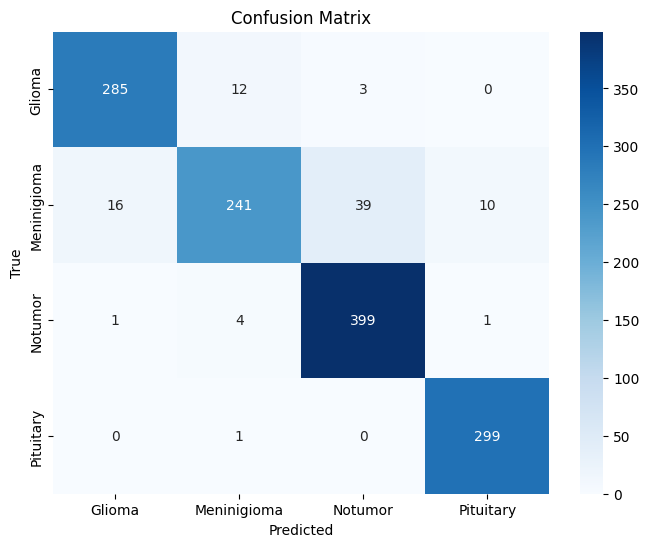

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [60]:
model_1.save("SSL_2_30-70.h5")

# SSL 2

In [61]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_2_30-70.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/low_confidence"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/very_low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.95
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/278 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  0%|          | 1/278 [00:00<03:05,  1.49it/s]

Tr-me_1026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1026.jpg to BT100/Training/pituitary/20250331_220348_Tr-me_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0041.jpg -> Class: notumor, Confidence: 0.50
Moved low-confidence image Tr-pi_0041.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 3/278 [00:00<01:01,  4.45it/s]

Tr-me_0366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0366.jpg to BT100/Training/notumor/20250331_220348_Tr-me_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-gl_0920.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0920.jpg to BT100/Training/glioma/20250331_220348_Tr-gl_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 5/278 [00:00<00:38,  7.01it/s]

Tr-me_0186.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0186.jpg to BT100/Training/meningioma/20250331_220348_Tr-me_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0945.jpg -> Class: meningioma, Confidence: 0.74
Moved low-confidence image Tr-me_0945.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 7/278 [00:01<00:29,  9.09it/s]

Tr-me_1216.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1216.jpg to BT100/Training/glioma/20250331_220348_Tr-me_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1025.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1025.jpg to BT100/Training/glioma/20250331_220348_Tr-gl_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  3%|▎         | 9/278 [00:01<00:27,  9.90it/s]

Tr-me_1120.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1120.jpg to BT100/Training/meningioma/20250331_220348_Tr-me_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-pi_0040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-pi_0040.jpg to BT100/Training/notumor/20250331_220348_Tr-pi_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 11/278 [00:01<00:23, 11.17it/s]

Tr-me_0293.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0293.jpg to BT100/Training/glioma/20250331_220348_Tr-me_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0810.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0810.jpg to BT100/Training/meningioma/20250331_220348_Tr-me_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 13/278 [00:01<00:21, 12.12it/s]

Tr-me_0715.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0715.jpg to BT100/Training/meningioma/20250331_220349_Tr-me_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1155.jpg -> Class: meningioma, Confidence: 0.63
Moved low-confidence image Tr-me_1155.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  5%|▌         | 15/278 [00:01<00:20, 13.10it/s]

Tr-me_0815.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0815.jpg to BT100/Training/meningioma/20250331_220349_Tr-me_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1131.jpg -> Class: glioma, Confidence: 0.97
Moving Tr-gl_1131.jpg to BT100/Training/glioma/20250331_220349_Tr-gl_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 17/278 [00:01<00:19, 13.41it/s]

Tr-me_0955.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0955.jpg to BT100/Training/meningioma/20250331_220349_Tr-me_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1248.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1248.jpg to BT100/Training/meningioma/20250331_220349_Tr-me_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 19/278 [00:01<00:18, 13.64it/s]

Tr-gl_0987.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0987.jpg to BT100/Training/glioma/20250331_220349_Tr-gl_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1112.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-me_1112.jpg to BT100/Training/glioma/20250331_220349_Tr-me_1112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 21/278 [00:02<00:18, 13.94it/s]

Tr-gl_1172.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1172.jpg to BT100/Training/glioma/20250331_220349_Tr-gl_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0047.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0047.jpg to BT100/Training/notumor/20250331_220349_Tr-no_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 23/278 [00:02<00:19, 13.10it/s]

Tr-no_0044.jpg -> Class: notumor, Confidence: 0.79
Moved low-confidence image Tr-no_0044.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1266.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1266.jpg to BT100/Training/glioma/20250331_220349_Tr-gl_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 25/278 [00:02<00:19, 13.30it/s]

Tr-gl_1241.jpg -> Class: glioma, Confidence: 0.55
Moved low-confidence image Tr-gl_1241.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0417.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-gl_0417.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 27/278 [00:02<00:18, 13.64it/s]

Tr-me_0143.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0143.jpg to BT100/Training/meningioma/20250331_220350_Tr-me_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0655.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0655.jpg to BT100/Training/meningioma/20250331_220350_Tr-me_0655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|█         | 29/278 [00:02<00:17, 14.16it/s]

Tr-me_0167.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0167.jpg to BT100/Training/glioma/20250331_220350_Tr-me_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0069.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0069.jpg to BT100/Training/pituitary/20250331_220350_Tr-pi_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█         | 31/278 [00:02<00:18, 13.23it/s]

Tr-gl_0922.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0922.jpg to BT100/Training/glioma/20250331_220350_Tr-gl_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0256.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0256.jpg to BT100/Training/notumor/20250331_220350_Tr-no_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 33/278 [00:02<00:17, 13.64it/s]

Tr-me_0796.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0796.jpg to BT100/Training/glioma/20250331_220350_Tr-me_0796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1209.jpg to BT100/Training/glioma/20250331_220350_Tr-gl_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 35/278 [00:03<00:17, 14.10it/s]

Tr-gl_0358.jpg -> Class: glioma, Confidence: 0.50
Moved low-confidence image Tr-gl_0358.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0190.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0190.jpg to BT100/Training/pituitary/20250331_220350_Tr-pi_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 37/278 [00:03<00:18, 13.11it/s]

Tr-gl_1293.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1293.jpg to BT100/Training/glioma/20250331_220350_Tr-gl_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0186.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0186.jpg to BT100/Training/notumor/20250331_220350_Tr-gl_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▍        | 39/278 [00:03<00:20, 11.42it/s]

Tr-gl_0984.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0984.jpg to BT100/Training/glioma/20250331_220350_Tr-gl_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0710.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0710.jpg to BT100/Training/meningioma/20250331_220351_Tr-me_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▍        | 41/278 [00:03<00:22, 10.50it/s]

Tr-no_0097.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0097.jpg to BT100/Training/notumor/20250331_220351_Tr-no_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0340.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0340.jpg to BT100/Training/glioma/20250331_220351_Tr-me_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█▌        | 43/278 [00:03<00:23,  9.81it/s]

Tr-gl_1219.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1219.jpg to BT100/Training/glioma/20250331_220351_Tr-gl_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0647.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0647.jpg to BT100/Training/glioma/20250331_220351_Tr-me_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 45/278 [00:04<00:24,  9.60it/s]

Tr-me_0619.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0619.jpg to BT100/Training/meningioma/20250331_220351_Tr-me_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 46/278 [00:04<00:26,  8.92it/s]

Tr-me_0080.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0080.jpg to BT100/Training/meningioma/20250331_220351_Tr-me_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 47/278 [00:04<00:26,  8.59it/s]

Tr-me_0712.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0712.jpg to BT100/Training/meningioma/20250331_220351_Tr-me_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 48/278 [00:04<00:27,  8.38it/s]

Tr-gl_1161.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1161.jpg to BT100/Training/glioma/20250331_220352_Tr-gl_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 49/278 [00:04<00:28,  8.03it/s]

Tr-gl_0841.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0841.jpg to BT100/Training/glioma/20250331_220352_Tr-gl_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 50/278 [00:04<00:27,  8.18it/s]

Tr-me_1324.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_1324.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 51/278 [00:04<00:28,  7.89it/s]

Tr-pi_1078.jpg -> Class: glioma, Confidence: 0.67
Moved low-confidence image Tr-pi_1078.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1100.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1100.jpg to BT100/Training/glioma/20250331_220352_Tr-gl_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 53/278 [00:05<00:23,  9.42it/s]

Tr-me_1330.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1330.jpg to BT100/Training/meningioma/20250331_220352_Tr-me_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 54/278 [00:05<00:24,  9.27it/s]

Tr-me_0240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0240.jpg to BT100/Training/notumor/20250331_220352_Tr-me_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0278.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0278.jpg to BT100/Training/notumor/20250331_220352_Tr-no_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 56/278 [00:05<00:20, 10.73it/s]

Tr-me_0124.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0124.jpg to BT100/Training/meningioma/20250331_220352_Tr-me_0124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0603.jpg -> Class: meningioma, Confidence: 0.76
Moved low-confidence image Tr-me_0603.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 58/278 [00:05<00:18, 12.13it/s]

Tr-me_1328.jpg -> Class: meningioma, Confidence: 0.97
Moving Tr-me_1328.jpg to BT100/Training/meningioma/20250331_220353_Tr-me_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1272.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1272.jpg to BT100/Training/glioma/20250331_220353_Tr-gl_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 60/278 [00:05<00:16, 13.06it/s]

Tr-no_0377.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0377.jpg to BT100/Training/notumor/20250331_220353_Tr-no_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0615.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0615.jpg to BT100/Training/glioma/20250331_220353_Tr-me_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0045.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0045.jpg to BT100/Training/glioma/20250331_220353_Tr-gl_0045.jpg


 22%|██▏       | 62/278 [00:05<00:15, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0049.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_0049.jpg to BT100/Training/glioma/20250331_220353_Tr-gl_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 64/278 [00:05<00:15, 13.67it/s]

Tr-gl_0890.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0890.jpg to BT100/Training/glioma/20250331_220353_Tr-gl_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1174.jpg to BT100/Training/pituitary/20250331_220353_Tr-pi_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▎       | 66/278 [00:06<00:15, 13.86it/s]

Tr-me_0519.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0519.jpg to BT100/Training/glioma/20250331_220353_Tr-me_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0910.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0910.jpg to BT100/Training/glioma/20250331_220353_Tr-me_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 68/278 [00:06<00:14, 14.14it/s]

Tr-pi_1116.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1116.jpg to BT100/Training/pituitary/20250331_220353_Tr-pi_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0074.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0074.jpg to BT100/Training/meningioma/20250331_220353_Tr-me_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 70/278 [00:06<00:14, 13.96it/s]

Tr-me_0228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0228.jpg to BT100/Training/notumor/20250331_220353_Tr-me_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0174.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0174.jpg to BT100/Training/meningioma/20250331_220353_Tr-me_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 26%|██▌       | 72/278 [00:06<00:14, 14.35it/s]

Tr-me_0691.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0691.jpg to BT100/Training/meningioma/20250331_220353_Tr-me_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0109.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0109.jpg to BT100/Training/glioma/20250331_220354_Tr-me_0109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 74/278 [00:06<00:14, 14.45it/s]

Tr-me_1137.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1137.jpg to BT100/Training/meningioma/20250331_220354_Tr-me_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0305.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0305.jpg to BT100/Training/glioma/20250331_220354_Tr-gl_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 76/278 [00:06<00:13, 14.59it/s]

Tr-me_0785.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0785.jpg to BT100/Training/glioma/20250331_220354_Tr-me_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0948.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-me_0948.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 78/278 [00:06<00:14, 14.23it/s]

Tr-pi_1090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1090.jpg to BT100/Training/pituitary/20250331_220354_Tr-pi_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0850.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0850.jpg to BT100/Training/glioma/20250331_220354_Tr-me_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 80/278 [00:07<00:13, 14.47it/s]

Tr-me_0012.jpg -> Class: glioma, Confidence: 0.58
Moved low-confidence image Tr-me_0012.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0191.jpg -> Class: glioma, Confidence: 0.57
Moved low-confidence image Tr-gl_0191.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 82/278 [00:07<00:13, 14.63it/s]

Tr-me_0278.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0278.jpg to BT100/Training/notumor/20250331_220354_Tr-me_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1237.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1237.jpg to BT100/Training/meningioma/20250331_220354_Tr-me_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|███       | 84/278 [00:07<00:13, 14.15it/s]

Tr-gl_0947.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_0947.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0306.jpg to BT100/Training/glioma/20250331_220354_Tr-no_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 86/278 [00:07<00:13, 14.18it/s]

Tr-gl_1261.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1261.jpg to BT100/Training/glioma/20250331_220354_Tr-gl_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0116.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-me_0116.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 88/278 [00:07<00:13, 14.40it/s]

Tr-me_1029.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-me_1029.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1335.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-me_1335.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 90/278 [00:07<00:12, 14.63it/s]

Tr-no_0086.jpg -> Class: glioma, Confidence: 0.55
Moved low-confidence image Tr-no_0086.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0117.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0117.jpg to BT100/Training/pituitary/20250331_220355_Tr-pi_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 92/278 [00:07<00:13, 14.23it/s]

Tr-no_0098.jpg -> Class: notumor, Confidence: 0.97
Moving Tr-no_0098.jpg to BT100/Training/notumor/20250331_220355_Tr-no_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1121.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1121.jpg to BT100/Training/pituitary/20250331_220355_Tr-pi_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 34%|███▍      | 94/278 [00:08<00:12, 14.34it/s]

Tr-gl_0197.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0197.jpg to BT100/Training/glioma/20250331_220355_Tr-gl_0197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1050.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_1050.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▍      | 96/278 [00:08<00:13, 13.16it/s]

Tr-me_0171.jpg -> Class: notumor, Confidence: 0.87
Moved low-confidence image Tr-me_0171.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0749.jpg -> Class: pituitary, Confidence: 0.91
Moved low-confidence image Tr-me_0749.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 35%|███▌      | 98/278 [00:08<00:14, 12.25it/s]

Tr-gl_0185.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0185.jpg to BT100/Training/glioma/20250331_220355_Tr-gl_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0249.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0249.jpg to BT100/Training/meningioma/20250331_220355_Tr-gl_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 36%|███▌      | 100/278 [00:08<00:13, 13.10it/s]

Tr-me_0748.jpg -> Class: pituitary, Confidence: 0.82
Moved low-confidence image Tr-me_0748.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1211.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1211.jpg to BT100/Training/meningioma/20250331_220356_Tr-me_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 102/278 [00:08<00:12, 13.66it/s]

Tr-me_0263.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0263.jpg to BT100/Training/meningioma/20250331_220356_Tr-me_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0996.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0996.jpg to BT100/Training/glioma/20250331_220356_Tr-gl_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1191.jpg -> Class: glioma, Confidence: 0.98

 37%|███▋      | 104/278 [00:08<00:12, 14.09it/s]


Moving Tr-gl_1191.jpg to BT100/Training/glioma/20250331_220356_Tr-gl_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0621.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-me_0621.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 106/278 [00:08<00:12, 14.04it/s]

Tr-no_0040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0040.jpg to BT100/Training/notumor/20250331_220356_Tr-no_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0238.jpg -> Class: meningioma, Confidence: 0.51
Moved low-confidence image Tr-me_0238.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 39%|███▉      | 108/278 [00:09<00:11, 14.39it/s]

Tr-me_1116.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_1116.jpg to BT100/Training/glioma/20250331_220356_Tr-me_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0479.jpg -> Class: notumor, Confidence: 0.94
Moved low-confidence image Tr-gl_0479.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0237.jpg -> Class: glioma, Confidence: 0.96
Moving Tr-gl_0237.jpg to BT100/Training/glioma/20250331_220356_Tr-gl_0237.jpg


 40%|███▉      | 110/278 [00:09<00:11, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1168.jpg -> Class: meningioma, Confidence: 0.95
Moving Tr-gl_1168.jpg to BT100/Training/meningioma/20250331_220356_Tr-gl_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 40%|████      | 112/278 [00:09<00:12, 13.04it/s]

Tr-no_0208.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0208.jpg to BT100/Training/notumor/20250331_220356_Tr-no_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0107.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0107.jpg to BT100/Training/meningioma/20250331_220356_Tr-gl_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████      | 114/278 [00:09<00:12, 13.49it/s]

Tr-gl_0895.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0895.jpg to BT100/Training/glioma/20250331_220357_Tr-gl_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0010.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-no_0010.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 42%|████▏     | 116/278 [00:09<00:11, 14.11it/s]

Tr-me_1156.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-me_1156.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0806.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0806.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 42%|████▏     | 118/278 [00:09<00:11, 14.35it/s]

Tr-gl_0924.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0924.jpg to BT100/Training/glioma/20250331_220357_Tr-gl_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1050.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-me_1050.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0390.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0390.jpg to BT100/Training/meningioma/20250331_220357_Tr-me_0390.jpg


 43%|████▎     | 120/278 [00:09<00:10, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0046.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0046.jpg to BT100/Training/meningioma/20250331_220357_Tr-me_0046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 122/278 [00:10<00:11, 14.02it/s]

Tr-me_0644.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0644.jpg to BT100/Training/glioma/20250331_220357_Tr-me_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0370.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0370.jpg to BT100/Training/glioma/20250331_220357_Tr-me_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 124/278 [00:10<00:10, 14.02it/s]

Tr-gl_1218.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1218.jpg to BT100/Training/glioma/20250331_220357_Tr-gl_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0328.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0328.jpg to BT100/Training/glioma/20250331_220357_Tr-me_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▌     | 126/278 [00:10<00:10, 13.84it/s]

Tr-me_0499.jpg -> Class: glioma, Confidence: 0.65
Moved low-confidence image Tr-me_0499.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0918.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0918.jpg to BT100/Training/glioma/20250331_220357_Tr-me_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 46%|████▌     | 128/278 [00:10<00:10, 14.24it/s]

Tr-gl_1015.jpg -> Class: glioma, Confidence: 0.69
Moved low-confidence image Tr-gl_1015.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0416.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0416.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0076.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0076.jpg to BT100/Training/glioma/20250331_220358_Tr-me_0076.jpg


 47%|████▋     | 130/278 [00:10<00:10, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0870.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0870.jpg to BT100/Training/pituitary/20250331_220358_Tr-pi_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 47%|████▋     | 132/278 [00:10<00:09, 14.69it/s]

Tr-me_1317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1317.jpg to BT100/Training/pituitary/20250331_220358_Tr-me_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1315.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_1315.jpg to BT100/Training/glioma/20250331_220358_Tr-me_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|████▊     | 134/278 [00:10<00:09, 14.62it/s]

Tr-gl_1149.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1149.jpg to BT100/Training/glioma/20250331_220358_Tr-gl_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0794.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0794.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 136/278 [00:11<00:09, 14.40it/s]

Tr-me_1250.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1250.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1314.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1314.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|████▉     | 138/278 [00:11<00:09, 14.31it/s]

Tr-pi_0754.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0754.jpg to BT100/Training/pituitary/20250331_220358_Tr-pi_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0423.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0423.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 50%|█████     | 140/278 [00:11<00:10, 12.97it/s]

Tr-me_0493.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0493.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0513.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0513.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 51%|█████     | 142/278 [00:11<00:10, 13.53it/s]

Tr-me_1067.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1067.jpg to BT100/Training/meningioma/20250331_220358_Tr-me_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1049.jpg -> Class: glioma, Confidence: 0.57
Moved low-confidence image Tr-me_1049.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 52%|█████▏    | 144/278 [00:11<00:09, 14.15it/s]

Tr-me_0685.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0685.jpg to BT100/Training/meningioma/20250331_220359_Tr-me_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0140.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0140.jpg to BT100/Training/meningioma/20250331_220359_Tr-gl_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 53%|█████▎    | 146/278 [00:11<00:10, 12.99it/s]

Tr-me_0040.jpg -> Class: meningioma, Confidence: 0.73
Moved low-confidence image Tr-me_0040.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0078.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0078.jpg to BT100/Training/glioma/20250331_220359_Tr-me_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 53%|█████▎    | 148/278 [00:11<00:09, 13.35it/s]

Tr-me_0242.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0242.jpg to BT100/Training/meningioma/20250331_220359_Tr-me_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0180.jpg to BT100/Training/notumor/20250331_220359_Tr-me_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 54%|█████▍    | 150/278 [00:12<00:09, 13.33it/s]

Tr-me_1326.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_1326.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0661.jpg -> Class: meningioma, Confidence: 0.60
Moved low-confidence image Tr-me_0661.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 152/278 [00:12<00:09, 13.39it/s]

Tr-me_1323.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1323.jpg to BT100/Training/meningioma/20250331_220359_Tr-me_1323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0492.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0492.jpg to BT100/Training/meningioma/20250331_220359_Tr-me_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 55%|█████▌    | 154/278 [00:12<00:09, 13.66it/s]

Tr-me_0227.jpg -> Class: meningioma, Confidence: 0.51
Moved low-confidence image Tr-me_0227.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0655.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0655.jpg to BT100/Training/pituitary/20250331_220359_Tr-pi_0655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 56%|█████▌    | 156/278 [00:12<00:08, 14.08it/s]

Tr-me_1094.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1094.jpg to BT100/Training/meningioma/20250331_220400_Tr-me_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1081.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1081.jpg to BT100/Training/glioma/20250331_220400_Tr-gl_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 158/278 [00:12<00:08, 14.13it/s]

Tr-me_0711.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0711.jpg to BT100/Training/meningioma/20250331_220400_Tr-me_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0348.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0348.jpg to BT100/Training/notumor/20250331_220400_Tr-no_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 58%|█████▊    | 160/278 [00:12<00:08, 14.47it/s]

Tr-me_0330.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0330.jpg to BT100/Training/meningioma/20250331_220400_Tr-me_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0153.jpg -> Class: glioma, Confidence: 0.54
Moved low-confidence image Tr-me_0153.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 162/278 [00:12<00:08, 14.45it/s]

Tr-me_1188.jpg -> Class: glioma, Confidence: 0.79
Moved low-confidence image Tr-me_1188.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1221.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_1221.jpg to BT100/Training/notumor/20250331_220400_Tr-me_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 164/278 [00:13<00:08, 14.19it/s]

Tr-me_0872.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0872.jpg to BT100/Training/meningioma/20250331_220400_Tr-me_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0857.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0857.jpg to BT100/Training/meningioma/20250331_220400_Tr-me_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 166/278 [00:13<00:08, 13.18it/s]

Tr-me_0331.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0331.jpg to BT100/Training/meningioma/20250331_220400_Tr-me_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0273.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0273.jpg to BT100/Training/notumor/20250331_220400_Tr-no_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 168/278 [00:13<00:08, 12.53it/s]

Tr-noTr_0008.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0008.jpg to BT100/Training/notumor/20250331_220400_Tr-noTr_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0956.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0956.jpg to BT100/Training/pituitary/20250331_220400_Tr-pi_0956.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 61%|██████    | 170/278 [00:13<00:08, 13.00it/s]

Tr-me_0612.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0612.jpg to BT100/Training/meningioma/20250331_220401_Tr-me_0612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0154.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0154.jpg to BT100/Training/meningioma/20250331_220401_Tr-me_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 62%|██████▏   | 172/278 [00:13<00:07, 13.62it/s]

Tr-gl_0980.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0980.jpg to BT100/Training/glioma/20250331_220401_Tr-gl_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1066.jpg to BT100/Training/glioma/20250331_220401_Tr-me_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 63%|██████▎   | 174/278 [00:13<00:07, 13.99it/s]

Tr-gl_1201.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-gl_1201.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0694.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0694.jpg to BT100/Training/meningioma/20250331_220401_Tr-me_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 63%|██████▎   | 176/278 [00:13<00:07, 14.22it/s]

Tr-me_1141.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1141.jpg to BT100/Training/meningioma/20250331_220401_Tr-me_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0593.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0593.jpg to BT100/Training/meningioma/20250331_220401_Tr-me_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 64%|██████▍   | 178/278 [00:14<00:07, 13.18it/s]

Tr-me_0500.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0500.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1143.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1143.jpg to BT100/Training/glioma/20250331_220401_Tr-gl_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 65%|██████▍   | 180/278 [00:14<00:07, 12.44it/s]

Tr-me_0064.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0064.jpg to BT100/Training/meningioma/20250331_220401_Tr-me_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0687.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-gl_0687.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 65%|██████▌   | 182/278 [00:14<00:07, 12.91it/s]

Tr-me_0403.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0403.jpg to BT100/Training/meningioma/20250331_220401_Tr-me_0403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1183.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1183.jpg to BT100/Training/meningioma/20250331_220402_Tr-me_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 66%|██████▌   | 184/278 [00:14<00:06, 13.43it/s]

Tr-me_0613.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0613.jpg to BT100/Training/meningioma/20250331_220402_Tr-me_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1026.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1026.jpg to BT100/Training/glioma/20250331_220402_Tr-gl_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 67%|██████▋   | 186/278 [00:14<00:06, 13.87it/s]

Tr-me_0917.jpg -> Class: glioma, Confidence: 0.51
Moved low-confidence image Tr-me_0917.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1332.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1332.jpg to BT100/Training/meningioma/20250331_220402_Tr-me_1332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 188/278 [00:14<00:06, 12.92it/s]

Tr-pi_0037.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0037.jpg to BT100/Training/pituitary/20250331_220402_Tr-pi_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1210.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1210.jpg to BT100/Training/glioma/20250331_220402_Tr-gl_1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 190/278 [00:15<00:06, 12.87it/s]

Tr-me_1266.jpg -> Class: glioma, Confidence: 0.44
Moved low-confidence image Tr-me_1266.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0360.jpg -> Class: glioma, Confidence: 0.97
Moving Tr-gl_0360.jpg to BT100/Training/glioma/20250331_220402_Tr-gl_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 69%|██████▉   | 192/278 [00:15<00:08, 10.13it/s]

Tr-no_0305.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0305.jpg to BT100/Training/notumor/20250331_220402_Tr-no_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_1133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1133.jpg to BT100/Training/meningioma/20250331_220402_Tr-gl_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 194/278 [00:15<00:08,  9.38it/s]

Tr-me_0495.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-me_0495.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0069.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0069.jpg to BT100/Training/meningioma/20250331_220403_Tr-me_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 196/278 [00:15<00:09,  8.69it/s]

Tr-me_0623.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0623.jpg to BT100/Training/meningioma/20250331_220403_Tr-me_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 197/278 [00:16<00:09,  8.40it/s]

Tr-me_0172.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-me_0172.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 198/278 [00:16<00:09,  8.44it/s]

Tr-gl_1234.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1234.jpg to BT100/Training/glioma/20250331_220403_Tr-gl_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 199/278 [00:16<00:09,  8.04it/s]

Tr-gl_0359.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0359.jpg to BT100/Training/glioma/20250331_220403_Tr-gl_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 200/278 [00:16<00:09,  7.84it/s]

Tr-me_0678.jpg -> Class: meningioma, Confidence: 0.81
Moved low-confidence image Tr-me_0678.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 201/278 [00:16<00:09,  8.18it/s]

Tr-me_0226.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0226.jpg to BT100/Training/glioma/20250331_220404_Tr-me_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 202/278 [00:16<00:09,  8.05it/s]

Tr-gl_1052.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1052.jpg to BT100/Training/glioma/20250331_220404_Tr-gl_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 203/278 [00:16<00:08,  8.34it/s]

Tr-gl_0141.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0141.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 204/278 [00:16<00:09,  8.12it/s]

Tr-me_0327.jpg -> Class: meningioma, Confidence: 0.95
Moving Tr-me_0327.jpg to BT100/Training/meningioma/20250331_220404_Tr-me_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▎  | 205/278 [00:17<00:09,  7.69it/s]

Tr-me_0103.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0103.jpg to BT100/Training/meningioma/20250331_220404_Tr-me_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0477.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0477.jpg to BT100/Training/glioma/20250331_220404_Tr-gl_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 207/278 [00:17<00:07,  9.63it/s]

Tr-me_1293.jpg -> Class: notumor, Confidence: 0.56
Moved low-confidence image Tr-me_1293.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1301.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1301.jpg to BT100/Training/meningioma/20250331_220404_Tr-me_1301.jpg


 75%|███████▍  | 208/278 [00:17<00:07,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0125.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0125.jpg to BT100/Training/meningioma/20250331_220404_Tr-me_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0903.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0903.jpg to BT100/Training/meningioma/20250331_220404_Tr-me_0903.jpg


 76%|███████▌  | 210/278 [00:17<00:06, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0700.jpg -> Class: pituitary, Confidence: 0.68
Moved low-confidence image Tr-me_0700.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 76%|███████▋  | 212/278 [00:17<00:05, 12.05it/s]

Tr-me_1272.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1272.jpg to BT100/Training/meningioma/20250331_220405_Tr-me_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0419.jpg -> Class: glioma, Confidence: 0.85
Moved low-confidence image Tr-gl_0419.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 77%|███████▋  | 214/278 [00:17<00:04, 12.90it/s]

Tr-gl_1175.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1175.jpg to BT100/Training/meningioma/20250331_220405_Tr-gl_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1016.jpg -> Class: glioma, Confidence: 0.78
Moved low-confidence image Tr-gl_1016.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 78%|███████▊  | 216/278 [00:17<00:04, 13.64it/s]

Tr-me_1024.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1024.jpg to BT100/Training/meningioma/20250331_220405_Tr-me_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0998.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-gl_0998.jpg to BT100/Training/meningioma/20250331_220405_Tr-gl_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 218/278 [00:17<00:04, 13.61it/s]

Tr-me_0345.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0345.jpg to BT100/Training/glioma/20250331_220405_Tr-me_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0993.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0993.jpg to BT100/Training/glioma/20250331_220405_Tr-gl_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 79%|███████▉  | 220/278 [00:18<00:04, 12.75it/s]

Tr-gl_0162.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_0162.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0695.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0695.jpg to BT100/Training/glioma/20250331_220405_Tr-gl_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|███████▉  | 222/278 [00:18<00:04, 11.68it/s]

Tr-me_1071.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1071.jpg to BT100/Training/meningioma/20250331_220405_Tr-me_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0792.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0792.jpg to BT100/Training/pituitary/20250331_220405_Tr-pi_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 81%|████████  | 224/278 [00:18<00:04, 12.57it/s]

Tr-me_0809.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0809.jpg to BT100/Training/meningioma/20250331_220406_Tr-me_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0387.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0387.jpg to BT100/Training/notumor/20250331_220406_Tr-no_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 81%|████████▏ | 226/278 [00:18<00:03, 13.06it/s]

Tr-gl_1095.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1095.jpg to BT100/Training/glioma/20250331_220406_Tr-gl_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0299.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0299.jpg to BT100/Training/notumor/20250331_220406_Tr-no_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 82%|████████▏ | 228/278 [00:18<00:03, 13.73it/s]

Tr-no_0061.jpg -> Class: notumor, Confidence: 0.97
Moving Tr-no_0061.jpg to BT100/Training/notumor/20250331_220406_Tr-no_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0168.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0168.jpg to BT100/Training/meningioma/20250331_220406_Tr-me_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 230/278 [00:18<00:03, 13.72it/s]

Tr-me_1257.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1257.jpg to BT100/Training/meningioma/20250331_220406_Tr-me_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0033.jpg -> Class: notumor, Confidence: 0.96
Moving Tr-pi_0033.jpg to BT100/Training/notumor/20250331_220406_Tr-pi_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 232/278 [00:19<00:03, 12.65it/s]

Tr-me_0041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0041.jpg to BT100/Training/meningioma/20250331_220406_Tr-me_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1079.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_1079.jpg to BT100/Training/notumor/20250331_220406_Tr-me_1079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0975.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_0975.jpg to BT100/Training/glioma/20250331_220406_Tr-gl_0975.jpg


 84%|████████▍ | 234/278 [00:19<00:03, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1050.jpg -> Class: notumor, Confidence: 0.88
Moved low-confidence image Tr-pi_1050.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 85%|████████▍ | 236/278 [00:19<00:03, 12.48it/s]

Tr-me_0375.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0375.jpg to BT100/Training/glioma/20250331_220406_Tr-me_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1263.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1263.jpg to BT100/Training/glioma/20250331_220407_Tr-me_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▌ | 238/278 [00:19<00:03, 12.93it/s]

Tr-me_0514.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0514.jpg to BT100/Training/meningioma/20250331_220407_Tr-me_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0392.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0392.jpg to BT100/Training/notumor/20250331_220407_Tr-no_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 86%|████████▋ | 240/278 [00:19<00:02, 13.60it/s]

Tr-me_0793.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0793.jpg to BT100/Training/glioma/20250331_220407_Tr-me_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0188.jpg -> Class: glioma, Confidence: 0.96
Moving Tr-gl_0188.jpg to BT100/Training/glioma/20250331_220407_Tr-gl_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 87%|████████▋ | 242/278 [00:19<00:02, 12.82it/s]

Tr-me_0148.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0148.jpg to BT100/Training/meningioma/20250331_220407_Tr-me_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0957.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0957.jpg to BT100/Training/meningioma/20250331_220407_Tr-me_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 244/278 [00:20<00:02, 13.22it/s]

Tr-gl_1236.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1236.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1264.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1264.jpg to BT100/Training/meningioma/20250331_220407_Tr-gl_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 88%|████████▊ | 246/278 [00:20<00:02, 13.47it/s]

Tr-no_0058.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0058.jpg to BT100/Training/notumor/20250331_220407_Tr-no_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0084.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0084.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 89%|████████▉ | 248/278 [00:20<00:02, 12.54it/s]

Tr-me_0213.jpg -> Class: meningioma, Confidence: 0.97
Moving Tr-me_0213.jpg to BT100/Training/meningioma/20250331_220407_Tr-me_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0893.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0893.jpg to BT100/Training/glioma/20250331_220407_Tr-gl_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 90%|████████▉ | 250/278 [00:20<00:02, 13.23it/s]

Tr-me_0628.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0628.jpg to BT100/Training/meningioma/20250331_220407_Tr-me_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1224.jpg -> Class: meningioma, Confidence: 0.53
Moved low-confidence image Tr-gl_1224.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 91%|█████████ | 252/278 [00:20<00:01, 13.81it/s]

Tr-me_0374.jpg -> Class: meningioma, Confidence: 0.64
Moved low-confidence image Tr-me_0374.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0814.jpg -> Class: meningioma, Confidence: 0.56
Moved low-confidence image Tr-me_0814.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 91%|█████████▏| 254/278 [00:20<00:01, 14.02it/s]

Tr-me_1329.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1329.jpg to BT100/Training/meningioma/20250331_220408_Tr-me_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0795.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0795.jpg to BT100/Training/meningioma/20250331_220408_Tr-me_0795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 92%|█████████▏| 256/278 [00:20<00:01, 14.18it/s]

Tr-me_0411.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0411.jpg to BT100/Training/meningioma/20250331_220408_Tr-me_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1212.jpg -> Class: glioma, Confidence: 0.68
Moved low-confidence image Tr-gl_1212.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0554.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0554.jpg to BT100/Training/meningioma/20250331_220408_Tr-me_0554.jpg


 93%|█████████▎| 258/278 [00:21<00:01, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0215.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0215.jpg to BT100/Training/notumor/20250331_220408_Tr-me_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 94%|█████████▎| 260/278 [00:21<00:01, 14.54it/s]

Tr-no_0260.jpg -> Class: notumor, Confidence: 0.91
Moved low-confidence image Tr-no_0260.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0317.jpg to BT100/Training/pituitary/20250331_220408_Tr-me_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 262/278 [00:21<00:01, 11.95it/s]

Tr-gl_1220.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1220.jpg to BT100/Training/glioma/20250331_220408_Tr-gl_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0555.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0555.jpg to BT100/Training/meningioma/20250331_220408_Tr-me_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 95%|█████████▍| 264/278 [00:21<00:01, 12.71it/s]

Tr-me_0308.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0308.jpg to BT100/Training/pituitary/20250331_220409_Tr-me_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0321.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0321.jpg to BT100/Training/meningioma/20250331_220409_Tr-me_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▌| 266/278 [00:21<00:00, 12.96it/s]

Tr-pi_1425.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1425.jpg to BT100/Training/pituitary/20250331_220409_Tr-pi_1425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0211.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0211.jpg to BT100/Training/notumor/20250331_220409_Tr-me_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 96%|█████████▋| 268/278 [00:21<00:00, 13.40it/s]

Tr-me_0023.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0023.jpg to BT100/Training/pituitary/20250331_220409_Tr-me_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0227.jpg -> Class: glioma, Confidence: 0.95
Moving Tr-gl_0227.jpg to BT100/Training/glioma/20250331_220409_Tr-gl_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 270/278 [00:21<00:00, 13.65it/s]

Tr-gl_1124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1124.jpg to BT100/Training/glioma/20250331_220409_Tr-gl_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1273.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1273.jpg to BT100/Training/glioma/20250331_220409_Tr-me_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 272/278 [00:22<00:00, 12.95it/s]

Tr-me_0914.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0914.jpg to BT100/Training/glioma/20250331_220409_Tr-me_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0563.jpg -> Class: meningioma, Confidence: 0.53
Moved low-confidence image Tr-me_0563.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 99%|█████████▊| 274/278 [00:22<00:00, 11.48it/s]

Tr-me_0329.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0329.jpg to BT100/Training/meningioma/20250331_220409_Tr-me_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0176.jpg to BT100/Training/notumor/20250331_220409_Tr-me_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 99%|█████████▉| 276/278 [00:22<00:00, 11.55it/s]

Tr-gl_0050.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0050.jpg to BT100/Training/glioma/20250331_220410_Tr-gl_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1136.jpg -> Class: glioma, Confidence: 0.59
Moved low-confidence image Tr-gl_1136.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


100%|██████████| 278/278 [00:22<00:00, 12.26it/s]

Tr-gl_0923.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0923.jpg to BT100/Training/glioma/20250331_220410_Tr-gl_0923.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [64]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/very_low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/very_low_confidence': 62


62

In [65]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")

Total number of files in the Training folder: 5650


In [66]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

In [67]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [68]:

# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5650

Testing
Number of Labels: 1311


In [69]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)


In [70]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [71]:
model_2 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_2.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

In [73]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)


In [74]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_2.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_2 = model_2.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.4990 - loss: 1.0786 - val_accuracy: 0.6125 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.7913 - loss: 0.5328 - val_accuracy: 0.7422 - val_loss: 0.5873 - learning_rate: 0.0010
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.8675 - loss: 0.3389 - val_accuracy: 0.8093 - val_loss: 0.5144 - learning_rate: 0.0010
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9123 - loss: 0.2364 - val_accuracy: 0.8368 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.9331 - loss: 0.1789 - val_accuracy: 0.8757 - val_loss: 0.4073 - learning_rate: 0.0010
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.9314 - loss: 0.1827 - val_accuracy: 0.8787 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9492

In [75]:
test_loss, test_acc = model_2.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9227 - loss: 1.5513
Test accuracy: 92.6773%


In [76]:
from sklearn.metrics import classification_report

y_pred = model_2.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       300
           1       0.90      0.80      0.85       306
           2       0.90      0.99      0.94       405
           3       0.97      1.00      0.98       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



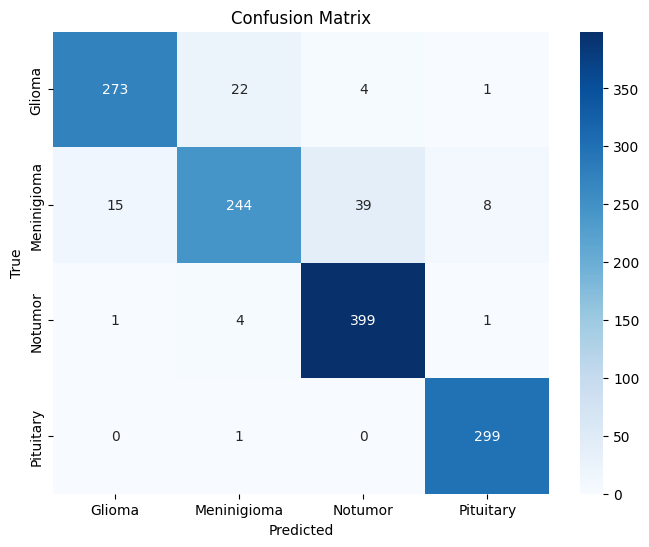

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [79]:
model_2.save("SSL_3_30-70.h5")

In [84]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_3_30-70.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/very_low_confidence"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/waste"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.90
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")

  0%|          | 0/62 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  2%|▏         | 1/62 [00:00<00:41,  1.48it/s]

Tr-pi_0041.jpg -> Class: pituitary, Confidence: 0.85
Moved low-confidence image Tr-pi_0041.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0945.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0945.jpg to BT100/Training/meningioma/20250331_222818_Tr-me_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▍         | 3/62 [00:00<00:13,  4.48it/s]

Tr-me_1155.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1155.jpg to BT100/Training/meningioma/20250331_222819_Tr-me_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-no_0044.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0044.jpg to BT100/Training/notumor/20250331_222819_Tr-no_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  8%|▊         | 5/62 [00:00<00:08,  7.05it/s]

Tr-gl_1241.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1241.jpg to BT100/Training/meningioma/20250331_222819_Tr-gl_1241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-gl_0417.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0417.jpg to BT100/Training/meningioma/20250331_222819_Tr-gl_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|█▏        | 7/62 [00:01<00:06,  9.14it/s]

Tr-gl_0358.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0358.jpg to BT100/Training/notumor/20250331_222819_Tr-gl_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1324.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1324.jpg to BT100/Training/meningioma/20250331_222819_Tr-me_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▍        | 9/62 [00:01<00:04, 10.68it/s]

Tr-pi_1078.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1078.jpg to BT100/Training/pituitary/20250331_222819_Tr-pi_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0603.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0603.jpg to BT100/Training/meningioma/20250331_222819_Tr-me_0603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0948.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0948.jpg to BT100/Training/meningioma/20250331_222819_Tr-me_0948.jpg


 18%|█▊        | 11/62 [00:01<00:04, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0012.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0012.jpg to BT100/Training/meningioma/20250331_222819_Tr-me_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 13/62 [00:01<00:04, 11.70it/s]

Tr-gl_0191.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0191.jpg to BT100/Training/glioma/20250331_222819_Tr-gl_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0947.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_0947.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 15/62 [00:01<00:03, 12.52it/s]

Tr-me_0116.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0116.jpg to BT100/Training/glioma/20250331_222819_Tr-me_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1029.jpg -> Class: glioma, Confidence: 0.77
Moved low-confidence image Tr-me_1029.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 27%|██▋       | 17/62 [00:01<00:03, 13.42it/s]

Tr-me_1335.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1335.jpg to BT100/Training/meningioma/20250331_222820_Tr-me_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-no_0086.jpg -> Class: glioma, Confidence: 0.96
Moving Tr-no_0086.jpg to BT100/Training/glioma/20250331_222820_Tr-no_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 31%|███       | 19/62 [00:01<00:03, 14.21it/s]

Tr-gl_1050.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1050.jpg to BT100/Training/glioma/20250331_222820_Tr-gl_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0171.jpg -> Class: notumor, Confidence: 0.91
Moving Tr-me_0171.jpg to BT100/Training/notumor/20250331_222820_Tr-me_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 34%|███▍      | 21/62 [00:02<00:02, 13.94it/s]

Tr-me_0749.jpg -> Class: meningioma, Confidence: 0.90
Moving Tr-me_0749.jpg to BT100/Training/meningioma/20250331_222820_Tr-me_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0748.jpg -> Class: meningioma, Confidence: 0.76
Moved low-confidence image Tr-me_0748.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 23/62 [00:02<00:02, 13.86it/s]

Tr-me_0621.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0621.jpg to BT100/Training/glioma/20250331_222820_Tr-me_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0238.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0238.jpg to BT100/Training/meningioma/20250331_222820_Tr-me_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 40%|████      | 25/62 [00:02<00:02, 13.60it/s]

Tr-gl_0479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0479.jpg to BT100/Training/notumor/20250331_222820_Tr-gl_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0010.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0010.jpg to BT100/Training/notumor/20250331_222820_Tr-no_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▎     | 27/62 [00:02<00:02, 12.74it/s]

Tr-me_1156.jpg -> Class: meningioma, Confidence: 0.92
Moving Tr-me_1156.jpg to BT100/Training/meningioma/20250331_222820_Tr-me_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0806.jpg -> Class: meningioma, Confidence: 0.73
Moved low-confidence image Tr-me_0806.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 47%|████▋     | 29/62 [00:02<00:02, 13.31it/s]

Tr-me_1050.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-me_1050.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0499.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0499.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 50%|█████     | 31/62 [00:02<00:02, 13.91it/s]

Tr-gl_1015.jpg -> Class: meningioma, Confidence: 0.72
Moved low-confidence image Tr-gl_1015.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1049.jpg -> Class: meningioma, Confidence: 0.60
Moved low-confidence image Tr-me_1049.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 53%|█████▎    | 33/62 [00:02<00:02, 14.37it/s]

Tr-me_0040.jpg -> Class: notumor, Confidence: 0.94
Moving Tr-me_0040.jpg to BT100/Training/notumor/20250331_222821_Tr-me_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1326.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1326.jpg to BT100/Training/meningioma/20250331_222821_Tr-me_1326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 56%|█████▋    | 35/62 [00:03<00:01, 14.66it/s]

Tr-me_0661.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0661.jpg to BT100/Training/meningioma/20250331_222821_Tr-me_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0227.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0227.jpg to BT100/Training/meningioma/20250331_222821_Tr-me_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 60%|█████▉    | 37/62 [00:03<00:01, 14.69it/s]

Tr-me_0153.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0153.jpg to BT100/Training/meningioma/20250331_222821_Tr-me_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1188.jpg -> Class: meningioma, Confidence: 0.63
Moved low-confidence image Tr-me_1188.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 63%|██████▎   | 39/62 [00:03<00:01, 13.69it/s]

Tr-gl_1201.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1201.jpg to BT100/Training/meningioma/20250331_222821_Tr-gl_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0500.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0500.jpg to BT100/Training/meningioma/20250331_222821_Tr-me_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 41/62 [00:03<00:01, 12.64it/s]

Tr-gl_0687.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0687.jpg to BT100/Training/glioma/20250331_222821_Tr-gl_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0917.jpg -> Class: glioma, Confidence: 0.62
Moved low-confidence image Tr-me_0917.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 69%|██████▉   | 43/62 [00:03<00:01, 13.16it/s]

Tr-me_1266.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-me_1266.jpg to BT100/Training/notumor/20250331_222821_Tr-me_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0495.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0495.jpg to BT100/Training/meningioma/20250331_222821_Tr-me_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 73%|███████▎  | 45/62 [00:03<00:01, 13.88it/s]

Tr-me_0172.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0172.jpg to BT100/Training/meningioma/20250331_222822_Tr-me_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0678.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0678.jpg to BT100/Training/meningioma/20250331_222822_Tr-me_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 76%|███████▌  | 47/62 [00:03<00:01, 14.27it/s]

Tr-gl_0141.jpg -> Class: meningioma, Confidence: 0.88
Moved low-confidence image Tr-gl_0141.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1293.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1293.jpg to BT100/Training/meningioma/20250331_222822_Tr-me_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 79%|███████▉  | 49/62 [00:04<00:00, 14.31it/s]

Tr-me_0700.jpg -> Class: meningioma, Confidence: 0.91
Moving Tr-me_0700.jpg to BT100/Training/meningioma/20250331_222822_Tr-me_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0419.jpg -> Class: pituitary, Confidence: 0.55
Moved low-confidence image Tr-gl_0419.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 51/62 [00:04<00:01,  8.01it/s]

Tr-gl_1016.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1016.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0162.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0162.jpg to BT100/Training/glioma/20250331_222822_Tr-gl_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 53/62 [00:04<00:01,  8.67it/s]

Tr-pi_1050.jpg -> Class: pituitary, Confidence: 0.76
Moved low-confidence image Tr-pi_1050.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1236.jpg -> Class: glioma, Confidence: 0.55
Moved low-confidence image Tr-gl_1236.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▊ | 55/62 [00:04<00:00,  8.74it/s]

Tr-me_0084.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0084.jpg to BT100/Training/meningioma/20250331_222823_Tr-me_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1224.jpg -> Class: glioma, Confidence: 0.66
Moved low-confidence image Tr-gl_1224.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 57/62 [00:05<00:00,  9.28it/s]

Tr-me_0374.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-me_0374.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0814.jpg -> Class: meningioma, Confidence: 0.91
Moving Tr-me_0814.jpg to BT100/Training/meningioma/20250331_222823_Tr-me_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 59/62 [00:05<00:00,  9.63it/s]

Tr-gl_1212.jpg -> Class: glioma, Confidence: 0.64
Moved low-confidence image Tr-gl_1212.jpg to BT100/waste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0260.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0260.jpg to BT100/Training/notumor/20250331_222823_Tr-no_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 61/62 [00:05<00:00,  9.87it/s]

Tr-me_0563.jpg -> Class: glioma, Confidence: 0.94
Moving Tr-me_0563.jpg to BT100/Training/glioma/20250331_222823_Tr-me_0563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|██████████| 62/62 [00:05<00:00, 11.00it/s]

Tr-gl_1136.jpg -> Class: notumor, Confidence: 0.89
Moved low-confidence image Tr-gl_1136.jpg to BT100/waste
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


# SSL 3

In [86]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/waste"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/waste': 20


20

In [87]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [88]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [89]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5692

Testing
Number of Labels: 1311


In [90]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [91]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [92]:
model_3 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_3.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)


In [94]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_3.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_3 = model_3.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.5162 - loss: 1.0458 - val_accuracy: 0.7529 - val_loss: 0.6667 - learning_rate: 0.0010
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8169 - loss: 0.4658 - val_accuracy: 0.8032 - val_loss: 0.5147 - learning_rate: 0.0010
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.8753 - loss: 0.3362 - val_accuracy: 0.8459 - val_loss: 0.4636 - learning_rate: 0.0010
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9069 - loss: 0.2362 - val_accuracy: 0.8734 - val_loss: 0.4427 - learning_rate: 0.0010
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.9376 - loss: 0.1741 - val_accuracy: 0.8680 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9349 - loss: 0.1581 - val_accuracy: 0.9031 - val_loss: 0.5107 - learning_rate: 0.0010
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.9504 

In [95]:
test_loss, test_acc = model_3.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9259 - loss: 1.8287
Test accuracy: 92.9062%


In [96]:
from sklearn.metrics import classification_report

y_pred = model_3.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       300
           1       0.91      0.79      0.85       306
           2       0.91      0.99      0.94       405
           3       0.96      1.00      0.98       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311



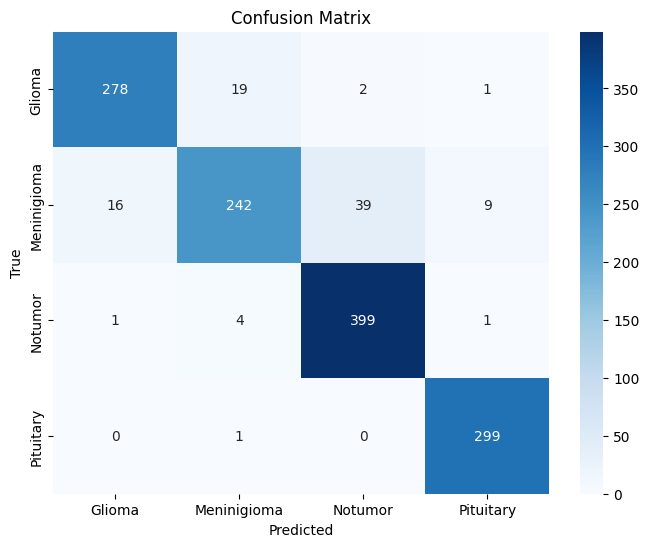

In [97]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()